In [ ]:
# --- Export GLOBAL PLS-VIP list for reuse (CSV + genes-only TXT) ---
if RUN_PLS_VIP and (pls_idx is not None) and (len(pls_idx) > 0):
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    ts_vip = dt.datetime.now().strftime("%Y%m%d_%H%M%S")

    # Build a tidy table ordered by VIP (desc)
    vip_df = pd.DataFrame({
        "rank":      np.arange(1, len(pls_idx) + 1, dtype=int),
        "gene":      pd.Index(genes_pls).astype(str),
        "vip_score": np.asarray(vip_scores, float)[pls_idx]
    })

    # File paths
    vip_csv_ts     = os.path.join(OUTPUT_DIR, f"Lung_GLOBAL_allcells_VIP_genes_{ts_vip}.csv")
    vip_csv_latest = os.path.join(OUTPUT_DIR, "Lung_GLOBAL_allcells_VIP_genes_latest.csv")
    vip_txt_latest = os.path.join(OUTPUT_DIR, "Lung_GLOBAL_allcells_VIP_genes_latest.txt")

    # Write CSVs (timestamped + rolling "latest")
    vip_df.to_csv(vip_csv_ts, index=False)
    vip_df.to_csv(vip_csv_latest, index=False)

    # Also write a plain genes-only TXT (one gene per line)
    with open(vip_txt_latest, "w") as f:
        f.write("\n".join(vip_df["gene"].tolist()))

    print("[*] Exported PLS-VIP list:")
    print(f"    CSV (timestamped): {vip_csv_ts}")
    print(f"    CSV (latest):      {vip_csv_latest}")
    print(f"    TXT genes-only:    {vip_txt_latest}")
else:
    print("[!] VIP export skipped: no PLS-VIP genes available.")

# ============================================
# Lung — Male-only, no 1m
# Unified Report: RF (Baseline + PLS-VIP) + PLS Regression (CV)
# + Leave-One-Cell-Type-Out (LOCTO)
# Pastel per-age colors; PLS scatter has ONLY identity line; legends inside.
# Outputs ONE PDF + a LOCTO CSV. Also saves a VIP heatmap (PDF+PNG).
# ============================================

import os, warnings, datetime as dt
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, roc_curve, auc, classification_report,
    accuracy_score, f1_score, balanced_accuracy_score, matthews_corrcoef,
    average_precision_score, precision_recall_curve
)
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import pearsonr

# -------------------------
# Config (edit paths)
# -------------------------
H5AD_PATH           = "/mnt/data/melhajjar/tabula_muris/all_tissues/Lung.h5ad"
OUTPUT_DIR          = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy"

AGE_KEY             = "age"
SEX_KEY             = "sex"
KEEP_SEX_VALUE      = "male"
DROP_AGE_VALUES     = {"1m"}
CELLTYPE_KEY        = "cell_ontology_class"   # << used for LOCTO

DOWNSAMPLE          = False
USE_TOP_HVGS        = True
N_HVGS              = 3000

# PLS VIP for RF classifier
RUN_PLS_VIP         = True
PLS_N_COMPONENTS    = 6
PLS_TOP_GENES       = 200
PLS_SCALE_X         = True

# PLS regression (continuous age)
RUN_PLS_REG         = True
PLS_REG_COMPONENTS  = 6
PLS_REG_SCALE_X     = True

# Heatmap display controls
HEATMAP_TOP_GENES = 200          # set to None to plot all VIP genes
HEATMAP_SHOW_GENE_LABELS = True  # always show labels (auto font scaling)

CV_FOLDS            = 5
RANDOM_STATE        = 42

RF_ESTIMATORS       = 400
RF_MAX_DEPTH        = 20
RF_MIN_SAMPLES_LEAF = 2
RF_N_JOBS           = -1

# -------------------------
# Plot styling
# -------------------------
mpl.rcParams.update({
    "figure.dpi": 150,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "font.family": "DejaVu Sans",
})

def _nature_axes(ax):
    for s in ["top", "right"]:
        ax.spines[s].set_visible(False)
    ax.spines["left"].set_linewidth(1.0)
    ax.spines["bottom"].set_linewidth(1.0)
    ax.tick_params(width=1.0, length=4)

# -------------------------
# Helpers
# -------------------------
def _ensure_dense(X):
    try: return X.toarray()
    except Exception: return np.asarray(X)

def _numeric_month(x):
    s = str(x).strip().lower()
    return float(s[:-1]) if s.endswith("m") else float(s)

# consistent pastel palette with 30m forced to purple
def _pastel_palette_from_classes(classes_sorted):
    base = ["#A6CEE3", "#FDBF6F", "#B2DF8A", "#CAB2D6", "#F4A6B3", "#B2E2E2"]
    pal = {c: base[i % len(base)] for i, c in enumerate(classes_sorted)}
    for key in ["30m", 30, 30.0]:
        if key in pal:
            pal[key] = "#CAB2D6"  # purple for 30m
    return pal

def _bar_by_age(ax, classes, counts, title, pal):
    colors = [pal[c] for c in classes]
    ax.bar(range(len(classes)), counts, color=colors, edgecolor="#333333", linewidth=0.6)
    ax.set_xticks(range(len(classes))); ax.set_xticklabels(classes)
    _nature_axes(ax)
    ax.set_title(title); ax.set_ylabel("# cells")
    ymax = counts.max() if len(counts) else 0
    for i, v in enumerate(counts):
        ax.text(i, v + max(1, ymax)*0.02, f"{int(v):,}", ha='center', va='bottom', fontsize=9)

def _metrics_table(ax, rows, title):
    ax.axis("off")
    ax.set_title(title, loc="left", pad=6)
    col_labels = ["Metric", "RF Baseline", "RF PLS-VIP", "PLS Reg (overall)"]
    table_data = [[k,
                   f"{v[0]:.3f}" if v[0] is not None else "",
                   f"{v[1]:.3f}" if v[1] is not None else "",
                   f"{v[2]:.3f}" if v[2] is not None else ""] for k, v in rows]
    the_table = ax.table(cellText=table_data, colLabels=col_labels, loc="center")
    the_table.auto_set_font_size(False); the_table.set_fontsize(9)
    the_table.scale(1, 1.2)

def _confusion_heatmap(ax, y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    cmn = cm.astype(float) / cm.sum(axis=1, keepdims=True)
    im = ax.imshow(cmn, aspect="auto", cmap="Blues", vmin=0, vmax=1)
    _nature_axes(ax)
    ax.set_title(title); ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    ax.set_xticks(range(len(classes))); ax.set_yticks(range(len(classes)))
    ax.set_xticklabels(classes); ax.set_yticklabels(classes)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm[i,j]:,}\n({cmn[i,j]*100:.1f}%)",
                    ha='center', va='center', fontsize=8)
    plt.colorbar(im, ax=ax, fraction=0.46/10, pad=0.04, label="Row-normalized")

def _roc_plot(ax, y_true, probas, classes, title_prefix, pal):
    Y = label_binarize(y_true, classes=classes)
    aucs = []
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(Y[:, i], probas[:, i])
        roc_auc = auc(fpr, tpr); aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1.6, color=pal[cls], label=f"{cls} (AUC={roc_auc:.3f})")
    ax.plot([0,1],[0,1], linestyle="--", linewidth=1, color="#666")
    _nature_axes(ax)
    ax.set_title(f"{title_prefix} ROC  (macro AUC={np.mean(aucs):.3f})")
    ax.set_xlabel("False Positive Rate"); ax.set_ylabel("True Positive Rate")
    ax.legend(frameon=False, loc="lower right")

def _pr_plot(ax, y_true, probas, classes, title_prefix, pal):
    Y = label_binarize(y_true, classes=classes)
    aps = []
    for i, cls in enumerate(classes):
        precision, recall, _ = precision_recall_curve(Y[:, i], probas[:, i])
        ap = average_precision_score(Y[:, i], probas[:, i]); aps.append(ap)
        ax.plot(recall, precision, lw=1.6, color=pal[cls], label=f"{cls} (AP={ap:.3f})")
    _nature_axes(ax)
    ax.set_title(f"{title_prefix} PR  (macro AP={np.mean(aps):.3f})")
    ax.set_xlabel("Recall"); ax.set_ylabel("Precision")
    ax.set_xlim(0,1); ax.set_ylim(0,1.05)
    ax.legend(frameon=False, loc="lower left")

def _top_bars(ax, tuples, title, xlab, max_items=20):
    if not tuples:
        ax.text(0.5, 0.5, "N/A", ha='center', va='center')
        ax.set_title(title); ax.set_xlabel(xlab); return
    names, vals = zip(*tuples[:max_items])
    y = np.arange(len(names))[::-1]
    ax.barh(y, vals, color="#A6CEE3", edgecolor="#333333", linewidth=0.6)
    _nature_axes(ax)
    ax.set_yticks(y); ax.set_yticklabels(names, fontsize=8)
    ax.set_title(title); ax.set_xlabel(xlab)
    ax.invert_yaxis()
    for yi, v in zip(y, vals):
        ax.text(v, yi, f" {v:.3f}", va="center", ha="left", fontsize=8)

def _top_rf_features(rf, feature_names, k=20):
    importances = getattr(rf, "feature_importances_", None)
    if importances is None: return []
    idx = np.argsort(importances)[::-1][:k]
    return list(zip(feature_names[idx], importances[idx]))

# -------------------------
# PLS VIP utilities
# -------------------------
def _one_hot_labels(y, classes):
    Y = np.zeros((len(y), len(classes)), dtype=float)
    m = {c:i for i,c in enumerate(classes)}
    for idx, lab in enumerate(y): Y[idx, m[lab]] = 1.0
    return Y

def select_pls_biomarkers(X, y, genes, classes, n_components=6, top_k=400, scale_x=True):
    # Wold VIP
    def _compute_pls_vip(pls, X, Y):
        X = np.asarray(X, dtype=float)
        T = pls.x_scores_; Q = pls.y_loadings_; W = pls.x_weights_
        ssy = []
        for a in range(Q.shape[1]):
            ssy_a = np.sum((T[:, a][:, None] @ Q[:, a][None, :])**2)
            ssy.append(ssy_a)
        ssy = np.array(ssy); ssy_tot = np.sum(ssy); p = W.shape[0]
        vip = np.zeros((p,))
        denom = np.sum(W**2, axis=0)
        for j in range(p):
            vip[j] = np.sqrt(p * np.sum(ssy * (W[j,:]**2) / denom) / ssy_tot)
        return vip

    X_use = X.copy()
    if scale_x:
        scaler = StandardScaler(with_mean=True, with_std=True)
        X_use = scaler.fit_transform(X_use)
    Y = _one_hot_labels(y, classes)
    pls = PLSRegression(n_components=n_components, scale=False)
    pls.fit(X_use, Y)
    vip = _compute_pls_vip(pls, X_use, Y)
    idx = np.argsort(vip)[::-1][:top_k]
    return idx, genes[idx], vip

# -------------------------
# PLS Regression scatter — filled circles, identity only
# -------------------------
def _to_months(labels):
    def _coerce(x):
        if isinstance(x, (int, float, np.number)): return float(x)
        s = str(x).strip().lower()
        if s.endswith("m"): s = s[:-1]
        return float(s)
    return np.array([_coerce(x) for x in labels], dtype=float)

def _plot_pred_vs_true_pub_identity_only(
    ax,
    y_true_labels,
    y_pred_months,
    class_order=None,
    title="PLS Regression (CV): Predicted vs True Age",
    jitter=0.18,
    point_size=14,
    point_alpha=0.55,
    mean_ms=9,
    palette=None,
    annotate_means=True,
    seed=0,
):
    rng = np.random.default_rng(seed)
    x_true = _to_months(y_true_labels)
    y_pred = np.asarray(y_pred_months, float)

    if class_order is None:
        classes = np.sort(np.unique(x_true))
    else:
        classes = _to_months(class_order)

    if palette is None:
        palette = _pastel_palette_from_classes(classes)

    x_jit = x_true + rng.uniform(-jitter, jitter, size=len(x_true))
    for c in classes:
        m = (x_true == c)
        if m.any():
            ax.scatter(x_jit[m], y_pred[m], s=point_size, alpha=point_alpha,
                       c=[palette[c]], marker='o', edgecolors='none')

    for c in classes:
        ys = y_pred[x_true == c]
        if ys.size == 0: 
            continue
        mu = float(ys.mean())
        sd = float(ys.std(ddof=1)) if ys.size > 1 else 0.0
        ax.errorbar([c], [mu], yerr=[[sd],[sd]], fmt='o', ms=mean_ms,
                    color=palette[c], mec="black", mfc=palette[c], mew=0.6,
                    ecolor=palette[c], elinewidth=1.1, capsize=3, capthick=1.1, zorder=5)
        if annotate_means:
            ax.text(c + 0.25, mu, f"μ={mu:.1f} m", va="center", ha="left",
                    color="#333333", fontsize=10)

    xmin, xmax = classes.min() - 1, classes.max() + 1
    y_min = np.percentile(y_pred, 1)
    y_max = np.percentile(y_pred, 99)
    y_pad = 0.06 * (y_max - y_min + 1e-9)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(y_min - y_pad, y_max + y_pad)

    ax.plot([xmin, xmax], [xmin, xmax], ls=(0,(4,3)), lw=1.2, color="#222222", alpha=0.9, label="y = x")

    _nature_axes(ax)
    ax.set_xlabel("True Age (months)")
    ax.set_ylabel("Predicted Age (months)")
    ax.set_title(title)

    handles, labels = [], []
    for c in classes:
        h = plt.Line2D([0], [0], marker='o', linestyle='None',
                       markersize=6, markerfacecolor=palette[c], markeredgewidth=0)
        handles.append(h); labels.append(f"{int(c)} m")
    handles.append(plt.Line2D([0,1],[0,1], color="#222222", lw=1.2, linestyle=(0,(4,3))))
    labels.append("y = x")
    ax.legend(handles, labels, frameon=False, loc="upper left")

# -------------------------
# Load & filter (GLOBAL)
# -------------------------
print("[*] Loading:", H5AD_PATH)
adata = sc.read_h5ad(H5AD_PATH)
for col in [AGE_KEY, SEX_KEY, CELLTYPE_KEY]:
    if col not in adata.obs.columns:
        raise KeyError(f"Missing column in adata.obs: {col}")

adata = adata[adata.obs[SEX_KEY].astype(str) == str(KEEP_SEX_VALUE)].copy()
adata = adata[~adata.obs[AGE_KEY].astype(str).isin(DROP_AGE_VALUES)].copy()

# Baseline feature space
adata_b = adata.copy()
if USE_TOP_HVGS:
    sc.pp.highly_variable_genes(adata_b, n_top_genes=N_HVGS, flavor="seurat_v3")
    adata_b = adata_b[:, adata_b.var["highly_variable"]].copy()
genes_baseline = adata_b.var_names.to_numpy()

X_b = _ensure_dense(adata_b.X)
y_cls = adata_b.obs[AGE_KEY].astype(str).to_numpy()
classes = list(pd.unique(y_cls))
classes_sorted = sorted(classes, key=_numeric_month)
palette = _pastel_palette_from_classes(classes_sorted)
ct_all = adata_b.obs[CELLTYPE_KEY].astype(str).to_numpy()

print(f"Total cells (male-only, no 1m, HVGs): {adata_b.n_obs:,}")
print(f"Genes in baseline space: {adata_b.n_vars:,}")
print("Global age classes:", classes_sorted)

def _age_to_months(arr):
    return np.array([_numeric_month(s) for s in arr], float)
y_months = _age_to_months(y_cls)

# -------------------------
# GLOBAL: PLS VIP selection for RF
# -------------------------
pls_idx = genes_pls = vip_scores = None
if RUN_PLS_VIP:
    print("[*] Computing PLS VIP for RF biomarkers (global) ...")
    pls_idx, genes_pls, vip_scores = select_pls_biomarkers(
        X=X_b, y=y_cls, genes=genes_baseline, classes=classes,
        n_components=PLS_N_COMPONENTS, top_k=PLS_TOP_GENES, scale_x=PLS_SCALE_X
    )
    print(f"Selected {len(pls_idx)} biomarkers.")

# -------------------------
# GLOBAL: RF CV evaluation
# -------------------------
def make_rf():
    return RandomForestClassifier(
        n_estimators=RF_ESTIMATORS,
        random_state=RANDOM_STATE,
        n_jobs=RF_N_JOBS,
        max_depth=RF_MAX_DEPTH,
        min_samples_leaf=RF_MIN_SAMPLES_LEAF
    )

skf = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)

def evaluate_rf(Xmat, y_labels, classes, feature_names, label):
    rf = make_rf()
    y_true_all, y_pred_all, proba_all = [], [], []
    for fold, (tr, te) in enumerate(skf.split(Xmat, y_labels), 1):
        rf.fit(Xmat[tr], y_labels[tr])
        ypr = rf.predict(Xmat[te]); p = rf.predict_proba(Xmat[te])
        y_true_all.append(y_labels[te]); y_pred_all.append(ypr); proba_all.append(p)
        print(f"[RF-{label}] Fold {fold}/{CV_FOLDS} done.")
    y_true = np.concatenate(y_true_all)
    y_pred = np.concatenate(y_pred_all)
    probas = np.concatenate(proba_all, axis=0)

    acc  = accuracy_score(y_true, y_pred)
    bacc = balanced_accuracy_score(y_true, y_pred)
    mf1  = f1_score(y_true, y_pred, average="macro")
    mcc  = matthews_corrcoef(y_true, y_pred)

    rf.fit(Xmat, y_labels)
    Ybin = label_binarize(y_true, classes=classes)
    aucs, aps = [], []
    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve(Ybin[:, i], probas[:, i])
        aucs.append(auc(fpr, tpr))
        aps.append(average_precision_score(Ybin[:, i], probas[:, i]))
    mauc = float(np.mean(aucs)); map_ = float(np.mean(aps))
    return {
        "y_true": y_true, "y_pred": y_pred, "probas": probas,
        "acc": acc, "bacc": bacc, "mf1": mf1, "mcc": mcc, "mauc": mauc, "map": map_,
        "rf": rf, "feature_names": feature_names
    }

print("[*] Evaluating Baseline RF ...")
res_base = evaluate_rf(X_b, y_cls, classes, genes_baseline, label="BASE")

res_plsRF = None
if RUN_PLS_VIP and pls_idx is not None and len(pls_idx) > 0:
    print("[*] Evaluating RF on PLS VIP biomarkers ...")
    X_p = X_b[:, pls_idx]
    res_plsRF = evaluate_rf(X_p, y_cls, classes, genes_pls, label="PLS")

# -------------------------
# GLOBAL: PLS Regression (CV) on baseline features
# -------------------------
pls_reg_results = None
if RUN_PLS_REG:
    print("[*] Running PLS Regression (CV, baseline HVGs) ...")
    y_true_all, y_pred_all = [], []
    for fold, (tr, te) in enumerate(skf.split(X_b, y_cls), 1):
        Xtr, Xte = X_b[tr], X_b[te]
        ytr, yte = y_months[tr], y_months[te]

        if PLS_REG_SCALE_X:
            scaler = StandardScaler(with_mean=True, with_std=True)
            Xtr = scaler.fit_transform(Xtr)
            Xte = scaler.transform(Xte)

        plsR = PLSRegression(n_components=PLS_REG_COMPONENTS, scale=False)
        plsR.fit(Xtr, ytr.reshape(-1, 1))
        yhat = plsR.predict(Xte).ravel()

        y_true_all.append(yte); y_pred_all.append(yhat)
        print(f"[PLS-REG] Fold {fold}/{CV_FOLDS} done.")

    y_true_pls = np.concatenate(y_true_all)
    y_pred_pls = np.concatenate(y_pred_all)

    r, p = pearsonr(y_true_pls, y_pred_pls)
    mae = float(np.mean(np.abs(y_pred_pls - y_true_pls)))
    rmse = float(np.sqrt(np.mean((y_pred_pls - y_true_pls)**2)))

    ages_unique = np.sort(np.unique(y_true_pls))
    per_age = []
    for a in ages_unique:
        m = (y_true_pls == a)
        err = y_pred_pls[m] - y_true_pls[m]
        per_age.append({
            "age": a, "n": int(m.sum()),
            "MAE": float(np.mean(np.abs(err))) if m.sum() else np.nan,
            "bias": float(np.mean(err)) if m.sum() else np.nan,
            "SD": float(np.std(err, ddof=1)) if m.sum() > 1 else 0.0
        })

    pls_reg_results = {
        "y_true_months": y_true_pls,
        "y_pred_months": y_pred_pls,
        "r": float(r), "p": float(p),
        "mae": mae, "rmse": rmse,
        "per_age": per_age
    }

# -------------------------
# LOCTO: Leave-One-Cell-Type-Out
# -------------------------
def _eval_rf_test_locto(Xtr, ytr, Xte, yte):
    uniq_tr = np.unique(ytr)
    rf = make_rf()
    rf.fit(Xtr, ytr)
    ypr = rf.predict(Xte)
    proba = rf.predict_proba(Xte)
    train_classes = rf.classes_

    acc  = accuracy_score(yte, ypr)
    bacc = balanced_accuracy_score(yte, ypr)
    mf1  = f1_score(yte, ypr, average="macro", zero_division=0)
    mcc  = matthews_corrcoef(yte, ypr) if len(np.unique(ypr)) > 1 else 0.0

    test_unique = np.unique(yte)
    common = [c for c in test_unique if c in set(train_classes)]
    aucs, aps = [], []
    if len(common) >= 2:
        col_idx = [np.where(train_classes == c)[0][0] for c in common]
        proba_common = proba[:, col_idx]
        for j, cls in enumerate(common):
            yi = (yte == cls).astype(int)
            if yi.max() == yi.min():
                continue
            pi = proba_common[:, j]
            fpr, tpr, _ = roc_curve(yi, pi)
            aucs.append(auc(fpr, tpr))
            aps.append(average_precision_score(yi, pi))
    mauc = float(np.mean(aucs)) if len(aucs) else np.nan
    map_ = float(np.mean(aps))  if len(aps)  else np.nan
    return {"acc":acc, "bacc":bacc, "mf1":mf1, "mcc":mcc, "mauc":mauc, "map":map_}

def _eval_pls_reg_test_locto(Xtr, ytr_months, Xte, yte_months, n_components=6, scale_x=True):
    if scale_x:
        scaler = StandardScaler(with_mean=True, with_std=True)
        Xtr = scaler.fit_transform(Xtr)
        Xte = scaler.transform(Xte)
    pls = PLSRegression(n_components=n_components, scale=False)
    pls.fit(Xtr, ytr_months.reshape(-1,1))
    yhat = pls.predict(Xte).ravel()
    if len(yhat) > 1:
        r, _ = pearsonr(yte_months, yhat)
        R2 = float(r**2)
    else:
        r, R2 = np.nan, np.nan
    mae = float(np.mean(np.abs(yhat - yte_months))) if len(yhat) else np.nan
    rmse = float(np.sqrt(np.mean((yhat - yte_months)**2))) if len(yhat) else np.nan
    return {"r": float(r), "R2": R2, "MAE": mae, "RMSE": rmse}

# Prepare matrices shared with LOCTO
X_all = X_b
y_all = y_cls
y_all_m = y_months
ct_all = ct_all
genes_baseline = genes_baseline

records = []
skipped = []

cell_types = sorted(pd.unique(ct_all))
print(f"[*] LOCTO over {len(cell_types)} cell types ...")
for ct in cell_types:
    test_idx  = (ct_all == ct)
    train_idx = ~test_idx

    n_train = int(train_idx.sum())
    n_test  = int(test_idx.sum())
    if n_test < 5 or n_train < 10:
        skipped.append((ct, n_test, "Too few cells in test or train"))
        continue

    Xtr, ytr, ytr_m = X_all[train_idx], y_all[train_idx], y_all_m[train_idx]
    Xte, yte, yte_m = X_all[test_idx],  y_all[test_idx],  y_all_m[test_idx]

    tr_classes = sorted(pd.unique(ytr), key=_numeric_month)
    te_classes = sorted(pd.unique(yte), key=_numeric_month)
    if len(tr_classes) < 2:
        skipped.append((ct, n_test, "Train needs ≥2 age classes"))
        continue
    if len(te_classes) < 2:
        skipped.append((ct, n_test, "Test (held-out type) needs ≥2 age classes"))
        continue

    try:
        locto_idx, locto_genes, _vip = select_pls_biomarkers(
            X=Xtr, y=ytr, genes=genes_baseline, classes=tr_classes,
            n_components=PLS_N_COMPONENTS, top_k=PLS_TOP_GENES, scale_x=PLS_SCALE_X
        )
    except Exception as e:
        skipped.append((ct, n_test, f"PLS selection failed: {e}"))
        continue

    Xtr_bm = Xtr[:, locto_idx]
    Xte_bm = Xte[:, locto_idx]

    rf_res  = _eval_rf_test_locto(Xtr_bm, ytr, Xte_bm, yte)
    pls_res = _eval_pls_reg_test_locto(Xtr_bm, ytr_m, Xte_bm, yte_m,
                                       n_components=PLS_N_COMPONENTS, scale_x=PLS_SCALE_X)

    records.append({
        "held_out_cell_type": ct,
        "n_train": n_train,
        "n_test": n_test,
        "train_age_classes": "|".join(map(str, tr_classes)),
        "test_age_classes":  "|".join(map(str, te_classes)),
        "PLS_top_k": PLS_TOP_GENES,
        "RF_acc": rf_res["acc"],
        "RF_bacc": rf_res["bacc"],
        "RF_macroF1": rf_res["mf1"],
        "RF_macroAUC": rf_res["mauc"],
        "RF_macroAP": rf_res["map"],
        "RF_MCC": rf_res["mcc"],
        "PLS_r":  pls_res["r"],
        "PLS_R2": pls_res["R2"],
        "PLS_MAE": pls_res["MAE"],
        "PLS_RMSE": pls_res["RMSE"],
    })
    auc_show = "NA" if np.isnan(rf_res["mauc"]) else f"{rf_res['mauc']:.3f}"
    r2_show  = "NA" if np.isnan(pls_res["R2"]) else f"{pls_res['R2']:.3f}"
    print(f"[LOCTO] {ct:>30s} | test n={n_test:>5} | AUC={auc_show} | R²={r2_show}")

# LOCTO dataframe + CSV
os.makedirs(OUTPUT_DIR, exist_ok=True)
ts = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
locto_csv_path = os.path.join(OUTPUT_DIR, f"locto_celltype_metrics_{ts}.csv")
df_locto = pd.DataFrame.from_records(records)
if not df_locto.empty:
    df_locto = df_locto.sort_values(["RF_macroAUC","PLS_R2","n_test"], ascending=[False, False, False])
df_locto.to_csv(locto_csv_path, index=False)
print(f"[*] Wrote LOCTO CSV: {locto_csv_path}")

# -------------------------
# PDF helpers for LOCTO
# -------------------------
def _barh(ax, names, vals, title, xlabel, color="#4C78A8"):
    y = np.arange(len(names))[::-1]
    ax.barh(y, vals, color=color)
    ax.set_yticks(y); ax.set_yticklabels(names, fontsize=8)
    _nature_axes(ax)
    ax.set_title(title); ax.set_xlabel(xlabel)
    ax.invert_yaxis()

# -------------------------
# Build unified PDF (GLOBAL + LOCTO)
# -------------------------
pdf_path = os.path.join(OUTPUT_DIR, f"Lung_MALEONLY_no1m_UNIFIED_LOCTO_{ts}.pdf")

with PdfPages(pdf_path) as pdf:
    # Page 1: Class counts
    cats = classes_sorted
    counts = pd.value_counts(pd.Categorical(y_cls, categories=cats), sort=False).values
    fig, ax = plt.subplots(figsize=(6.4, 4.3))
    _bar_by_age(ax, cats, counts, "Class counts (male-only, no 1m)", palette)
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 2: Metrics table (RF baseline vs PLS-VIP) + overall PLS reg
    rf_base = res_base
    rf_pls  = res_plsRF if res_plsRF is not None else None
    rows = [
        ("Accuracy",            (rf_base["acc"],  None if rf_pls is None else rf_pls["acc"],  None)),
        ("Balanced Accuracy",   (rf_base["bacc"], None if rf_pls is None else rf_pls["bacc"], None)),
        ("Macro F1",            (rf_base["mf1"],  None if rf_pls is None else rf_pls["mf1"],  None)),
        ("Macro AUC (OvR)",     (rf_base["mauc"], None if rf_pls is None else rf_pls["mauc"], None)),
        ("Macro AP (PR-AUC)",   (rf_base["map"],  None if rf_pls is None else rf_pls["map"],  None)),
        ("MCC",                 (rf_base["mcc"],  None if rf_pls is None else rf_pls["mcc"],  None)),
        ("# Features",          (len(rf_base["feature_names"]),
                                 None if rf_pls is None else len(rf_pls["feature_names"]),
                                 None)),
        ("PLS r",               (None, None, None if pls_reg_results is None else pls_reg_results["r"])),
        ("PLS R²",              (None, None, None if pls_reg_results is None else pls_reg_results["r"]**2)),
        ("PLS MAE (months)",    (None, None, None if pls_reg_results is None else pls_reg_results["mae"])),
        ("PLS RMSE (months)",   (None, None, None if pls_reg_results is None else pls_reg_results["rmse"])),
    ]
    fig, ax = plt.subplots(figsize=(7.8, 4.4))
    _metrics_table(ax, rows, "GLOBAL — RF (Baseline vs PLS-VIP) and PLS Regression (overall)")
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 3: Confusions
    cols = 2 if res_plsRF is not None else 1
    fig, axes = plt.subplots(1, cols, figsize=(6.5*cols, 4.6))
    if cols == 1: axes = [axes]
    _confusion_heatmap(axes[0], rf_base["y_true"], rf_base["y_pred"], classes, "Confusion — Baseline RF")
    if res_plsRF is not None:
        _confusion_heatmap(axes[1], res_plsRF["y_true"], res_plsRF["y_pred"], classes, "Confusion — RF on PLS-VIP")
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 4: ROC
    fig, axes = plt.subplots(1, cols, figsize=(6.5*cols, 4.6))
    if cols == 1: axes = [axes]
    _roc_plot(axes[0], rf_base["y_true"], rf_base["probas"], classes, "Baseline RF", palette)
    if res_plsRF is not None:
        _roc_plot(axes[1], res_plsRF["y_true"], res_plsRF["probas"], classes, "RF on PLS-VIP", palette)
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 5: PR
    fig, axes = plt.subplots(1, cols, figsize=(6.5*cols, 4.6))
    if cols == 1: axes = [axes]
    _pr_plot(axes[0], rf_base["y_true"], rf_base["probas"], classes, "Baseline RF", palette)
    if res_plsRF is not None:
        _pr_plot(axes[1], res_plsRF["y_true"], res_plsRF["probas"], classes, "RF on PLS-VIP", palette)
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 6–7: RF top features
    fig, axes = plt.subplots(1, cols, figsize=(7.2*cols, 6.0))
    if cols == 1: axes = [axes]
    _top_bars(axes[0], _top_rf_features(rf_base["rf"], rf_base["feature_names"], k=20),
              "RF feature importances — Baseline (top 20)", "Gini importance")
    if res_plsRF is not None:
        _top_bars(axes[1], _top_rf_features(res_plsRF["rf"], res_plsRF["feature_names"], k=20),
                  "RF feature importances — PLS-VIP (top 20)", "Gini importance")
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 8: PLS regression scatter
    if RUN_PLS_REG and pls_reg_results is not None:
        fig, ax = plt.subplots(figsize=(7.4, 5.8))
        order = [float(_numeric_month(c)) for c in classes_sorted]
        pal_numeric = {float(_numeric_month(k)): v for k, v in palette.items()}
        _plot_pred_vs_true_pub_identity_only(
            ax,
            y_true_labels = pls_reg_results["y_true_months"],
            y_pred_months = pls_reg_results["y_pred_months"],
            class_order   = order,
            title         = "PLS Regression (CV): Predicted vs True Age",
            palette       = pal_numeric,
            jitter        = 0.16,
            annotate_means=True
        )
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 9: PLS regression per-age metrics
    if RUN_PLS_REG and pls_reg_results is not None:
        fig, ax = plt.subplots(figsize=(7.8, 5.2))
        ax.axis("off")
        lines = []
        lines.append("PLS Regression performance (CV predictions on HVGs)")
        lines.append("="*60)
        lines.append(f"Overall:")
        lines.append(f"  Pearson r: {pls_reg_results['r']:.3f}")
        lines.append(f"  R² (r²):   {pls_reg_results['r']**2:.3f}")
        lines.append(f"  MAE:       {pls_reg_results['mae']:.2f} months")
        lines.append(f"  RMSE:      {pls_reg_results['rmse']:.2f} months")
        lines.append(f"  n cells:   {len(pls_reg_results['y_true_months']):,}")
        lines.append("")
        lines.append("Per-age breakdown:")
        for rec in pls_reg_results["per_age"]:
            lines.append(f"  {int(rec['age']):>2} m  |  n={rec['n']:<5}  MAE={rec['MAE']:.2f}  Bias={rec['bias']:+.2f}  SD(error)={rec['SD']:.2f}")
        ax.text(0.02, 0.98, "\n".join(lines), va="top", ha="left",
                family="DejaVu Sans Mono", fontsize=9)
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # ----- LOCTO section -----
    # Page 10: LOCTO overview
    fig, ax = plt.subplots(figsize=(8.2, 5.4))
    ax.axis("off")
    lines = []
    lines.append("Leave-One-Cell-Type-Out (LOCTO) — Drivers of Age Signal")
    lines.append("="*60)
    lines.append(f"Filters: sex == '{KEEP_SEX_VALUE}', ages not in {sorted(DROP_AGE_VALUES)}")
    lines.append(f"Baseline space: {'HVGs' if USE_TOP_HVGS else 'All genes'} (n_genes={adata_b.n_vars:,})")
    lines.append(f"Per-CT loop:")
    lines.append("  • Hold that cell type out as TEST")
    lines.append("  • PLS-VIP selected on TRAIN-ONLY (no leakage)")
    lines.append("  • RF (age classification) and PLS regression (months) trained on TRAIN, evaluated on TEST")
    lines.append("")
    lines.append(f"Total cells: {adata_b.n_obs:,}")
    lines.append(f"Cell types with results: {len(df_locto)} / {len(cell_types)}")
    if skipped:
        lines.append(f"Skipped CTs: {len(skipped)} (see last LOCTO page)")
    ax.text(0.02, 0.98, "\n".join(lines), va="top", ha="left", family="DejaVu Sans Mono", fontsize=9)
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 11: Ranked table (top 18 by RF AUC)
    fig, ax = plt.subplots(figsize=(8.6, 5.6))
    ax.axis("off")
    ax.set_title("Top held-out cell types by RF macro AUC", loc="left", pad=6)
    show = df_locto.head(18).copy() if not df_locto.empty else pd.DataFrame()
    if not show.empty:
        table_data = []
        for _, r in show.iterrows():
            table_data.append([
                r["held_out_cell_type"],
                int(r["n_train"]), int(r["n_test"]),
                r["test_age_classes"],
                "NA" if pd.isna(r["RF_macroAUC"]) else f"{r['RF_macroAUC']:.3f}",
                "NA" if pd.isna(r["RF_macroF1"]) else f"{r['RF_macroF1']:.3f}",
                "NA" if pd.isna(r["PLS_R2"]) else f"{r['PLS_R2']:.3f}",
                "NA" if pd.isna(r["PLS_MAE"]) else f"{r['PLS_MAE']:.2f}",
            ])
        col_labels = ["held-out cell type","n_train","n_test","test ages","RF AUC","RF F1","PLS R²","PLS MAE"]
        the_table = ax.table(cellText=table_data, colLabels=col_labels, loc="center")
        the_table.auto_set_font_size(False); the_table.set_fontsize(8)
        the_table.scale(1, 1.2)
    else:
        ax.text(0.02, 0.95, "No eligible cell types produced results.", fontsize=11)
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 12: RF macro AUC (barh)
    if not df_locto.empty:
        fig, ax = plt.subplots(figsize=(8.2, max(3.8, 0.27*len(df_locto)+1.8)))
        _barh(ax, df_locto["held_out_cell_type"].tolist(), df_locto["RF_macroAUC"].fillna(0).tolist(),
              "LOCTO — RF macro AUC (test on held-out type)", "macro AUC")
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 13: PLS R² (barh)
    if not df_locto.empty:
        fig, ax = plt.subplots(figsize=(8.2, max(3.8, 0.27*len(df_locto)+1.8)))
        _barh(ax, df_locto["held_out_cell_type"].tolist(), df_locto["PLS_R2"].fillna(0).tolist(),
              "LOCTO — PLS regression R² (test on held-out type)", "R²")
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 14: Coverage + skipped
    fig, ax = plt.subplots(figsize=(8.6, 5.6))
    ax.axis("off")
    ax.set_title("LOCTO — Coverage & Skipped cell types", loc="left", pad=6)
    lines = []
    lines.append("Test coverage by held-out type (age classes present; counts):")
    if not df_locto.empty:
        for ct in df_locto["held_out_cell_type"].tolist():
            te_mask = (ct_all == ct)
            ages = pd.Series(y_all[te_mask])
            counts = ages.value_counts().sort_index()
            lines.append(f"  {ct}: " + ", ".join([f"{k}:{v}" for k,v in counts.items()]))
    if skipped:
        lines.append("")
        lines.append("Skipped (reason):")
        for (ct, n, reason) in skipped:
            lines.append(f"  {ct} (test n={n}): {reason}")
    ax.text(0.02, 0.98, "\n".join(lines) if lines else "No coverage to display.", 
            va="top", ha="left", family="DejaVu Sans Mono", fontsize=9)
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

print(f"[*] Saved unified PDF (GLOBAL + LOCTO): {pdf_path}")

# ============================
# Heatmap of PLS-VIP genes × cells, grouped by age (separate PDF/PNG)
# ============================
print("[*] Building heatmap of PLS-VIP genes by age ...")

if not (RUN_PLS_VIP and (genes_pls is not None) and len(genes_pls) > 0):
    print("[!] Heatmap skipped: no PLS-VIP genes available (genes_pls is empty).")
else:
    # limit to top-K for visualization if requested
    if HEATMAP_TOP_GENES is not None:
        vip_display = genes_pls[:int(HEATMAP_TOP_GENES)]
    else:
        vip_display = genes_pls

    vip_set = [g for g in vip_display if g in set(genes_baseline)]
    if len(vip_set) == 0:
        print("[!] Heatmap skipped: none of the VIP genes are in the working feature space (HVGs).")
    else:
        # genes x cells (order cells by age)
        vip_idx = [np.where(genes_baseline == g)[0][0] for g in vip_set]
        X_vip = _ensure_dense(X_b)[:, vip_idx].T

        order_mask = np.argsort([classes_sorted.index(c) for c in y_cls])
        X_vip = X_vip[:, order_mask]
        y_cls_ordered = np.array(y_cls)[order_mask]

        # z-score per gene
        mu = X_vip.mean(axis=1, keepdims=True)
        sd = X_vip.std(axis=1, keepdims=True); sd[sd == 0] = 1.0
        Z = (X_vip - mu) / sd
        Z = np.clip(Z, -2.5, 2.5)

        n_genes, n_cells = Z.shape

        # figure sizing
        h_main = max(2.0, min(0.25 * n_genes, 14.0))
        h_annot = 0.6
        w_fig = max(8.0, min(0.0035 * n_cells + 5.0, 20.0))

        from matplotlib import gridspec
        fig = plt.figure(figsize=(w_fig, h_main + h_annot + 1.4))
        gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[h_main, h_annot], hspace=0.08)

        # heatmap
        ax = fig.add_subplot(gs[0, 0])
        im = ax.imshow(Z, aspect="auto", cmap="coolwarm", vmin=-2.5, vmax=2.5, interpolation="nearest")
        ax.set_title(f"PLS-VIP genes × cells (z-score per gene) — showing {len(vip_set)} genes", loc="left", pad=6)
        ax.set_xticks([])

        # >>> ALWAYS show gene names (auto font scaling) <<<
        if HEATMAP_SHOW_GENE_LABELS:
            ax.set_yticks(np.arange(n_genes))
            # modest truncation for ultra-long names to keep layout tidy
            labels = [g if len(g) <= 25 else (g[:22] + "…") for g in vip_set]
            # auto font size: smaller when many rows
            if n_genes <= 40:
                fs = 9
            elif n_genes <= 100:
                fs = 7
            elif n_genes <= 200:
                fs = 6
            else:
                fs = 5
            ax.set_yticklabels(labels, fontsize=fs)
        else:
            ax.set_yticks([])

        for s in ["top", "right"]:
            ax.spines[s].set_visible(False)
        ax.spines["left"].set_linewidth(1.0)
        ax.spines["bottom"].set_linewidth(1.0)

        # colorbar
        cax = fig.add_axes([ax.get_position().x1 + 0.006, ax.get_position().y0, 0.012, ax.get_position().height])
        cb = fig.colorbar(im, cax=cax)
        cb.set_label("z-score", rotation=90, labelpad=8)
        cb.ax.tick_params(labelsize=8)

        # age strip
        axb = fig.add_subplot(gs[1, 0])
        pal = _pastel_palette_from_classes(classes_sorted)
        strip_colors = np.array([pal[c] for c in y_cls_ordered], dtype=object)
        strip_rgb = np.array([mpl.colors.to_rgb(c) for c in strip_colors]).reshape(1, n_cells, 3)
        axb.imshow(strip_rgb, aspect="auto")
        axb.set_yticks([0]); axb.set_yticklabels(["Age"], fontsize=8)
        axb.set_xticks([])
        for s in ["top", "right"]:
            axb.spines[s].set_visible(False)
        axb.spines["left"].set_linewidth(1.0)
        axb.spines["bottom"].set_linewidth(1.0)

        # legend
        handles = [plt.Line2D([0],[0], marker='s', linestyle='',
                              markersize=8, markerfacecolor=pal[c], markeredgecolor="none")
                   for c in classes_sorted]
        fig.legend(handles, [str(c) for c in classes_sorted],
                   title="Age class", loc="upper right", frameon=False, fontsize=8, title_fontsize=8)

        fig.tight_layout()

        heat_ts = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
        heat_pdf = os.path.join(OUTPUT_DIR, f"Lung_MALEONLY_no1m_VIP_heatmap_{heat_ts}.pdf")
        heat_png = os.path.join(OUTPUT_DIR, f"Lung_MALEONLY_no1m_VIP_heatmap_{heat_ts}.png")
        fig.savefig(heat_pdf)
        fig.savefig(heat_png, dpi=600)
        plt.close(fig)
        print(f"[*] Saved VIP heatmap:\n    PDF: {heat_pdf}\n    PNG: {heat_png}")

print("[*] Done.")

[*] Loading: /mnt/data/melhajjar/tabula_muris/all_tissues/Lung.h5ad
Total cells (male-only, no 1m, HVGs): 16,228
Genes in baseline space: 3,000
Global age classes: ['3m', '18m', '30m']
[*] Computing PLS VIP for RF biomarkers (global) ...
Selected 200 biomarkers.
[*] Evaluating Baseline RF ...
[RF-BASE] Fold 1/5 done.
[RF-BASE] Fold 2/5 done.
[RF-BASE] Fold 3/5 done.
[RF-BASE] Fold 4/5 done.
[RF-BASE] Fold 5/5 done.
[*] Evaluating RF on PLS VIP biomarkers ...
[RF-PLS] Fold 1/5 done.
[RF-PLS] Fold 2/5 done.
[RF-PLS] Fold 3/5 done.
[RF-PLS] Fold 4/5 done.
[RF-PLS] Fold 5/5 done.
[*] Running PLS Regression (CV, baseline HVGs) ...
[PLS-REG] Fold 1/5 done.
[PLS-REG] Fold 2/5 done.
[PLS-REG] Fold 3/5 done.
[PLS-REG] Fold 4/5 done.
[PLS-REG] Fold 5/5 done.
[*] LOCTO over 30 cell types ...
[LOCTO]                         B cell | test n=  538 | AUC=0.990 | R²=0.046
[LOCTO] CD4-positive, alpha-beta T cell | test n=  141 | AUC=0.984 | R²=0.124
[LOCTO] CD8-positive, alpha-beta T cell | test n=  35

In [ ]:
# ============================
# RF top-20 VIP genes heatmap All Cells(bar far-left + z-score bar on right)
# ============================
import os, datetime as dt
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.colors import Normalize

def _ensure_dense(X):
    try: return X.toarray()
    except Exception: return np.asarray(X)

def _pastel_palette_from_classes(classes_sorted):
    base = ["#A6CEE3", "#FDBF6F", "#B2DF8A", "#CAB2D6", "#F4A6B3", "#B2E2E2"]
    pal = {c: base[i % len(base)] for i, c in enumerate(classes_sorted)}
    for key in ["30m", 30, 30.0]:
        if key in pal: pal[key] = "#CAB2D6"
    return pal

def plot_vip_rf_importance_top20(
    res_plsRF,
    X_b,
    genes_baseline,
    y_cls,
    classes_sorted,
    output_dir,
    top_k=20,
    show_gene_labels=True,
):
    if res_plsRF is None or "rf" not in res_plsRF or res_plsRF["rf"] is None:
        print("[!] RF-importance heatmap skipped: res_plsRF is not available.")
        return

    rf = res_plsRF["rf"]
    feat_names  = np.asarray(res_plsRF["feature_names"], dtype=str)
    importances = getattr(rf, "feature_importances_", None)
    if importances is None:
        print("[!] RF model has no feature_importances_.")
        return

    # Top-K by importance
    ord_idx   = np.argsort(importances)[::-1][:min(top_k, len(importances))]
    top_feats = feat_names[ord_idx]
    top_imps  = importances[ord_idx]

    # map to baseline indices
    name2pos = {g: i for i, g in enumerate(genes_baseline.astype(str))}
    keep = [g for g in top_feats if g in name2pos]
    pos  = [name2pos[g] for g in keep]
    imps = top_imps[[np.where(top_feats == g)[0][0] for g in keep]]

    if len(pos) == 0:
        print("[!] None of the RF top features are in the baseline space.")
        return

    # data: genes x cells, cells ordered by age
    X_all = _ensure_dense(X_b)          # cells x genes
    X_sel = X_all[:, pos].T             # genes x cells
    order = np.argsort([classes_sorted.index(c) for c in y_cls])
    X_sel = X_sel[:, order]
    y_ord = np.asarray(y_cls)[order]

    # z-score per gene
    mu = X_sel.mean(axis=1, keepdims=True)
    sd = X_sel.std(axis=1, keepdims=True); sd[sd==0] = 1.0
    Z  = np.clip((X_sel - mu) / sd, -2.5, 2.5)

    n_genes, n_cells = Z.shape
    pal_age = _pastel_palette_from_classes(classes_sorted)

    # layout
    h_main = max(2.4, min(0.38 * n_genes, 14.0))
    h_age  = 0.75
    w_fig  = max(7.8, min(0.0035 * n_cells + 6.0, 22.0))

    fig = plt.figure(figsize=(w_fig, h_main + h_age + 1.2))
    gs  = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[h_main, h_age], hspace=0.12)

    ax = fig.add_subplot(gs[0, 0])
    im = ax.imshow(Z, aspect="auto", cmap="coolwarm", vmin=-2.5, vmax=2.5,
                   interpolation="nearest")
    ax.set_title("RF top-20 VIP genes × cells (z-score per gene)", loc="left", pad=6)
    ax.set_xticks([])
    if show_gene_labels:
        ax.set_yticks(np.arange(n_genes))
        labels = [g if len(g) <= 28 else (g[:25] + "…") for g in keep]
        ax.set_yticklabels(labels, fontsize=11)
    else:
        ax.set_yticks([])

    for s in ["top","right"]:
        ax.spines[s].set_visible(False)
    ax.spines["left"].set_linewidth(1.0)
    ax.spines["bottom"].set_linewidth(1.0)

    # ---- z-score colorbar on the RIGHT of the heatmap ----
    right_cax = fig.add_axes([ax.get_position().x1 + 0.010,  # pad to the right
                              ax.get_position().y0,
                              0.014,                          # width
                              ax.get_position().height])
    cb = fig.colorbar(im, cax=right_cax, orientation='vertical')
    cb.set_label("z-score per gene", rotation=90, labelpad=8)
    cb.ax.tick_params(labelsize=9)
    cb.outline.set_visible(False)

    # ---- RF-importance bar FAR LEFT (closer to the figure's left edge) ----
    axpos = ax.get_position()
    rf_width  = 0.028
    rf_left   = 0.01            # anchor near the very left of the figure
    rf_bottom = axpos.y0
    rf_height = axpos.height

    rf_cax = fig.add_axes([rf_left, rf_bottom, rf_width, rf_height])
    sm = mpl.cm.ScalarMappable(norm=Normalize(0, 1), cmap='magma')
    sm.set_array([])
    rfcbar = fig.colorbar(sm, cax=rf_cax, orientation='vertical')
    rfcbar.set_ticks([0.02, 0.98]); rfcbar.set_ticklabels(["low", "high"])
    rfcbar.ax.tick_params(labelsize=11, length=0)
    rfcbar.set_label("RF importance", fontsize=13, rotation=90, labelpad=8)
    rfcbar.outline.set_visible(False)

    # bottom age strip
    axb = fig.add_subplot(gs[1, 0])
    strip_cols = np.array([pal_age[c] for c in y_ord], dtype=object)
    strip_rgb  = np.array([mpl.colors.to_rgb(c) for c in strip_cols]).reshape(1, n_cells, 3)
    axb.imshow(strip_rgb, aspect="auto")
    axb.set_yticks([0]); axb.set_yticklabels(["Age"], fontsize=11)
    axb.set_xticks([])
    for s in ["top","right"]:
        axb.spines[s].set_visible(False)
    axb.spines["left"].set_linewidth(1.0)
    axb.spines["bottom"].set_linewidth(1.0)

    # tiny age legend (upper-right)
    handles = [plt.Line2D([0],[0], marker='s', linestyle='', markersize=8,
                          markerfacecolor=pal_age[c], markeredgecolor="none")
               for c in classes_sorted]
    fig.legend(handles, [str(c) for c in classes_sorted],
               title="Age", loc="upper right", frameon=False, fontsize=9, title_fontsize=9)

    fig.tight_layout()

    # save
    os.makedirs(output_dir, exist_ok=True)
    ts  = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
    pdf = os.path.join(output_dir, f"Lung_RF_top20_VIP_heatmap_{ts}.pdf")
    png = os.path.join(output_dir, f"Lung_RF_top20_VIP_heatmap_{ts}.png")
    fig.savefig(pdf); fig.savefig(png, dpi=600)
    plt.close(fig)
    print(f"[*] Saved RF top-20 VIP heatmap:\n    {pdf}\n    {png}")

# ---- run it (assumes res_plsRF, X_b, genes_baseline, y_cls, classes_sorted, OUTPUT_DIR exist) ----
plot_vip_rf_importance_top20(
    res_plsRF=res_plsRF,
    X_b=X_b,
    genes_baseline=genes_baseline,
    y_cls=y_cls,
    classes_sorted=classes_sorted,
    output_dir=OUTPUT_DIR,
    top_k=20,
    show_gene_labels=True
)

[*] Saved RF top-20 VIP heatmap:
    /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/Lung_RF_top20_VIP_heatmap_20251005_025110.pdf
    /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/Lung_RF_top20_VIP_heatmap_20251005_025110.png


In [ ]:
#TopGenes Pathways identified using top 200 list and this website
#Mouse Phenotype Enrichment
#https://toppgene.cchmc.org/output.jsp?userdata_id=d7016b7a-0091-43d5-97cc-7283d7255655


/tmp/ipykernel_10850/1465266899.py:62: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


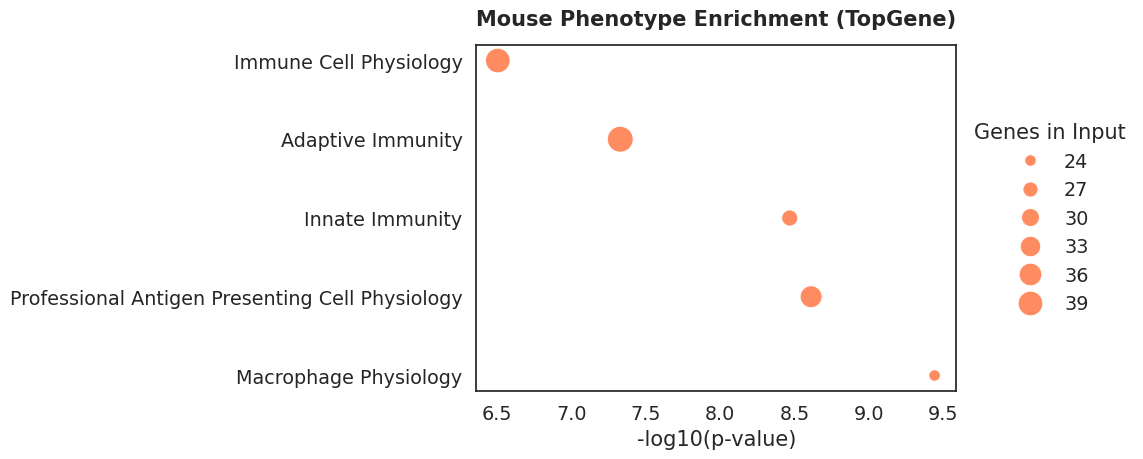

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# # --- Example data ---
df = pd.DataFrame({
    "term": [
        "Macrophage Physiology",
        "Innate Immunity",
        "Professional Antigen Presenting Cell Physiology",
        "Adaptive Immunity",
        "Immune Cell Physiology"
    ],
    "pval": [3.62e-10, 3.41e-9, 2.45e-9, 4.70e-8, 3.13e-7],
    "n_genes": [24, 28, 35, 41, 39]
})

# Compute -log10(p)
df["logp"] = -np.log10(df["pval"])
df = df.sort_values("logp", ascending=True)


# --- Style ---
sns.set_theme(style="white", font_scale=1.25)

# --- Plot (narrower width) ---
plt.figure(figsize=(6.2, 4.5))  # <-- reduced width from 8 to 6.2
ax = sns.scatterplot(
    data=df,
    x="logp", y="term",
    size="n_genes",
    color="coral",           # solid coral tone
    sizes=(70, 350),
    alpha=0.9,
    legend="brief"
)

# --- Labels & layout ---
ax.set_title("Mouse Phenotype Enrichment (TopGene)", weight="bold", pad=14)
ax.set_xlabel("-log10(p-value)")
ax.set_ylabel("")
ax.grid(False)

# --- Move legend outside ---
plt.legend(
    title="Genes in Input",
    bbox_to_anchor=(1.02, 0.5),
    loc="center left",
    borderaxespad=0.,
    frameon=False
)



# (Optional) save like your other figures
import os
save_dir = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy"
os.makedirs(save_dir, exist_ok=True)
plt.savefig(os.path.join(save_dir, "GO_MF_enrichment_dot_coral.pdf"), dpi=600, bbox_inches="tight", format="pdf")

plt.tight_layout()
plt.show()

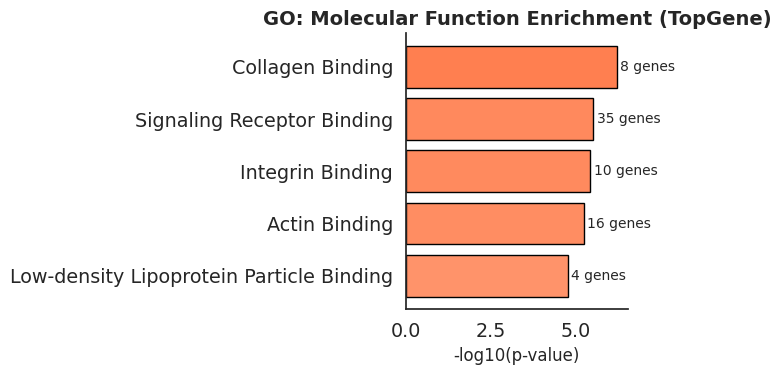

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Your GO Molecular Function table
df = pd.DataFrame({
    "Term": [
        "Collagen Binding",
        "Signaling Receptor Binding",
        "Integrin Binding",
        "Actin Binding",
        "Low-density Lipoprotein Particle Binding"
    ],
    "pvalue": [5.777e-7, 2.906e-6, 3.578e-6, 5.568e-6, 1.621e-5],
    "Genes":  [8, 35, 10, 16, 4]
})

# Compute -log10(p) and sort
df["logP"] = -np.log10(df["pvalue"])
df = df.sort_values("logP", ascending=True)

# Create a coral-to-pale gradient
from matplotlib.colors import LinearSegmentedColormap
coral_cmap = LinearSegmentedColormap.from_list("coral_gradient", ["#FFD6C2", "#FF7F50"])

# Normalize values to color range
colors = coral_cmap(df["logP"] / df["logP"].max())

# Plot
fig, ax = plt.subplots(figsize=(7, 4))
bars = ax.barh(df["Term"], df["logP"], color=colors, edgecolor="black")

# # Annotate with gene counts
# for bar, n in zip(bars, df["Genes"]):
#     ax.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
#             f"{n} genes", va='center', fontsize=10)

ax.set_xlabel("-log10(p-value)", fontsize=12)
ax.set_title("GO: Molecular Function Enrichment (TopGene)", fontsize=14, weight='bold')
ax.spines[['top','right']].set_visible(False)
plt.tight_layout()

# (Optional) save like your other figures
save_dir = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy"
os.makedirs(save_dir, exist_ok=True)
plt.savefig(os.path.join(save_dir, "GO_MF_enrichment_bar_coral_nogenecounts.pdf"), dpi=600, bbox_inches="tight", format="pdf")

plt.show()




In [2]:
#Alveolar Macrophages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.colors import LinearSegmentedColormap

# === GO: Molecular Function (Your New Table) ===
df = pd.DataFrame({
    "Term": [
        "Cell Adhesion Molecule Binding",
        "Cadherin Binding",
        "Antioxidant Activity",
        "Kinase Binding",
        "MHC Class II Protein Complex Binding",
        "Protein Kinase Binding",
        "Cytoskeletal Protein Binding",
        "S100 Protein Binding",
        "MHC Protein Complex Binding",
        "Proteoglycan Binding"
    ],
    "pvalue": [
        5.466E-9,
        2.523E-8,
        1.486E-6,
        1.637E-6,
        2.603E-6,
        3.523E-6,
        4.416E-6,
        5.854E-6,
        2.199E-5,
        6.447E-5
    ],
    "Genes": [22, 16, 8, 24, 5, 22, 25, 4, 5, 5]
})

# === Compute -log10(p) and sort ===
df["logP"] = -np.log10(df["pvalue"])
df = df.sort_values("logP", ascending=True)

# === Coral gradient ===
coral_cmap = LinearSegmentedColormap.from_list("coral_gradient", ["#FFD6C2", "#FF7F50"])
colors = coral_cmap(df["logP"] / df["logP"].max())

# === Plot ===
fig, ax = plt.subplots(figsize=(7.2, 5))
bars = ax.barh(df["Term"], df["logP"], color=colors, edgecolor="black")

# # Optional: annotate with gene counts
# for bar, n in zip(bars, df["Genes"]):
#     ax.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
#             f"{n} genes", va='center', fontsize=10)

ax.set_xlabel("-log10(p-value)", fontsize=12)
ax.set_title("GO: Molecular Function Enrichment (TopGene)", fontsize=14, weight='bold')
ax.spines[['top', 'right']].set_visible(False)
plt.tight_layout()

# === Save ===
save_dir = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy"
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, "GO_MF_enrichment_bar_coral_new_AMs.pdf")
plt.savefig(save_path, dpi=600, bbox_inches="tight", format="pdf")
plt.close()

print(f"✅ Saved to: {save_path}")


✅ Saved to: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/GO_MF_enrichment_bar_coral_new_AMs.pdf


In [6]:
# === Non-Classical Monocytes — GO: Molecular Function Enrichment ===
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.colors import LinearSegmentedColormap

# === Data from your provided table ===
df = pd.DataFrame({
    "Term": [
        "Structural Constituent of Ribosome",
        "Structural Molecule Activity",
        "Cell Adhesion Molecule Binding",
        "Peptide Binding",
        "Calcium-dependent Protein Binding",
        "Antioxidant Activity",
        "Amyloid-beta Binding",
        "Signaling Receptor Binding",
        "Long-chain Fatty Acid Binding",
        "Ubiquitin Protein Ligase Binding"
    ],
    "pvalue": [
        1.236E-15,
        7.283E-11,
        6.849E-9,
        8.315E-8,
        1.413E-7,
        1.626E-6,
        2.381E-6,
        2.663E-6,
        3.337E-6,
        5.797E-6
    ],
    "Genes": [19, 30, 22, 15, 9, 8, 8, 34, 5, 13]
})

# === Compute -log10(p) and sort ===
df["logP"] = -np.log10(df["pvalue"])
df = df.sort_values("logP", ascending=True)

# === Coral gradient ===
coral_cmap = LinearSegmentedColormap.from_list("coral_gradient", ["#FFD6C2", "#FF7F50"])
colors = coral_cmap(df["logP"] / df["logP"].max())

# === Plot ===
fig, ax = plt.subplots(figsize=(7.5, 5.2))
bars = ax.barh(df["Term"], df["logP"], color=colors, edgecolor="black")

# # Optional: annotate with gene counts
# for bar, n in zip(bars, df["Genes"]):
#     ax.text(bar.get_width() + 0.2, bar.get_y() + bar.get_height()/2,
#             f"{n} genes", va='center', fontsize=9)

# === Labels & layout ===
ax.set_xlabel("-log10(p-value)", fontsize=12)
ax.set_title("GO: Molecular Function Enrichment — Non-Classical Monocytes (TopGene)",
             fontsize=13, weight='bold')
ax.spines[['top', 'right']].set_visible(False)
plt.tight_layout()

# === Save ===
save_dir = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy"
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, "GO_MF_enrichment_bar_coral_Non-Class_Mos.pdf")
plt.savefig(save_path, dpi=600, bbox_inches="tight", format="pdf")
plt.close()

print(f"✅ Saved to: {save_path}")


✅ Saved to: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/GO_MF_enrichment_bar_coral_Non-Class_Mos.pdf


In [4]:
# === Non-Classical Monocytes — GO: Molecular Function Enrichment ===
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.colors import LinearSegmentedColormap

# === Data from your new table ===
df = pd.DataFrame({
    "Term": [
        "Structural Constituent of Ribosome",
        "Structural Molecule Activity",
        "Cell Adhesion Molecule Binding",
        "Peptide Binding",
        "Calcium-dependent Protein Binding"
    ],
    "pvalue": [
        1.236E-15,
        7.283E-11,
        6.849E-9,
        8.315E-8,
        1.413E-7
    ],
    "Genes": [19, 30, 22, 15, 9]
})

# === Compute -log10(p) and sort ===
df["logP"] = -np.log10(df["pvalue"])
df = df.sort_values("logP", ascending=True)

# === Coral gradient ===
coral_cmap = LinearSegmentedColormap.from_list("coral_gradient", ["#FFD6C2", "#FF7F50"])
colors = coral_cmap(df["logP"] / df["logP"].max())

# === Plot ===
fig, ax = plt.subplots(figsize=(7.2, 4.2))
bars = ax.barh(df["Term"], df["logP"], color=colors, edgecolor="black")

# # Optional: annotate with gene counts
# for bar, n in zip(bars, df["Genes"]):
#     ax.text(bar.get_width() + 0.2, bar.get_y() + bar.get_height()/2,
#             f"{n} genes", va='center', fontsize=9)

# === Labels & layout ===
ax.set_xlabel("-log10(p-value)", fontsize=12)
ax.set_title("GO: Molecular Function Enrichment — Alveolar Macrophages (TopGene)", fontsize=13, weight='bold')
ax.spines[['top', 'right']].set_visible(False)
plt.tight_layout()

# === Save ===
save_dir = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy"
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, "GO_MF_enrichment_bar_coral_Non-Class_Mos.pdf")
plt.savefig(save_path, dpi=600, bbox_inches="tight", format="pdf")
plt.close()

print(f"✅ Saved to: {save_path}")


✅ Saved to: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/GO_MF_enrichment_bar_coral_Non-Class_Mos.pdf


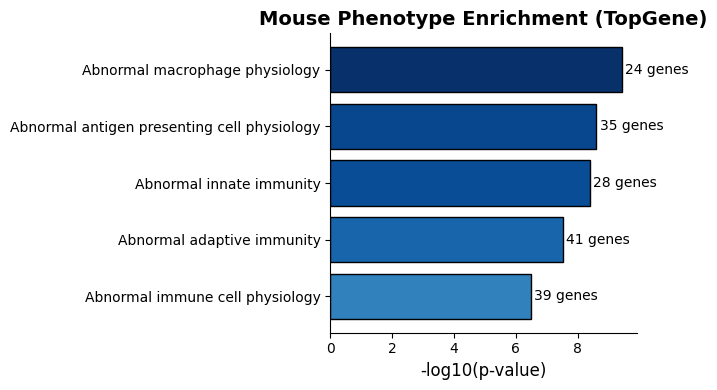

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Example data
mp_df = pd.DataFrame({
    "Term": [
        "Abnormal macrophage physiology",
        "Abnormal innate immunity",
        "Abnormal antigen presenting cell physiology",
        "Abnormal adaptive immunity",
        "Abnormal immune cell physiology"
    ],
    "pvalue": [3.62e-10, 4.04e-9, 2.45e-9, 3.04e-8, 3.13e-7],
    "Genes": [24, 28, 35, 41, 39]
})

mp_df["logP"] = -np.log10(mp_df["pvalue"])
mp_df = mp_df.sort_values("logP", ascending=True)

# Plot
fig, ax = plt.subplots(figsize=(7,4))
bars = ax.barh(mp_df["Term"], mp_df["logP"],
               color=plt.cm.Blues(mp_df["logP"]/mp_df["logP"].max()),
               edgecolor="black")

for bar, n in zip(bars, mp_df["Genes"]):
    ax.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
            f"{n} genes", va='center', fontsize=10)

ax.set_xlabel("-log10(p-value)", fontsize=12)
ax.set_title("Mouse Phenotype Enrichment (TopGene)", fontsize=14, weight='bold')
ax.spines[['top','right']].set_visible(False)
plt.tight_layout()
plt.show()


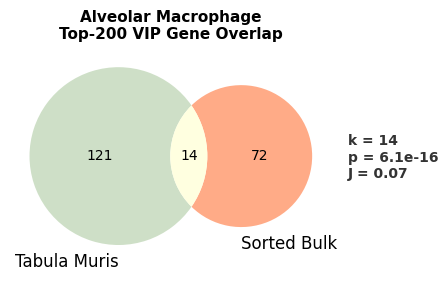

✅ Saved Venn → /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/alveolar_macrophage_Venn_20251012_062608.pdf


In [4]:
# ============================================
# Alveolar Macrophage — Tabula vs Sorted Bulk (VIP Overlap)
# ============================================
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import os, datetime as dt
from scipy.stats import hypergeom

# ---- Numbers ----
K = 135   # Tabula
n = 86    # Sorted bulk
k = 14    # Overlap

# ---- Universe (approximate all genes) ----
U = 20000   # total background, adjust if known
pval = hypergeom.sf(k-1, U, K, n)
jacc = k / (K + n - k)

# ---- Plot ----
fig, ax = plt.subplots(figsize=(4.6, 4.6))
venn2(
    subsets=(K - k, n - k, k),
    set_labels=("Tabula Muris", "Sorted Bulk"),
    set_colors=("#C9DCC1", "#FFA27A"),
    alpha=0.9,
    ax=ax
)

# ---- Add embedded statistics ----
stats_text = f"k = {k}\np = {pval:.1e}\nJ = {jacc:.2f}"
ax.text(
    1.05, 0.4, stats_text, transform=ax.transAxes,
    fontsize=10, fontweight='bold', color='#333333',
    bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', boxstyle='round,pad=0.4')
)

ax.set_title(
    "Alveolar Macrophage\nTop-200 VIP Gene Overlap",
    fontsize=11, weight='bold'
)
fig.tight_layout()

# ---- Save ----
out_dir = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy"
os.makedirs(out_dir, exist_ok=True)
timestamp = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
pdf_path = os.path.join(out_dir, f"alveolar_macrophage_Venn_{timestamp}.pdf")
png_path = pdf_path.replace(".pdf", ".png")

fig.savefig(pdf_path, dpi=600, bbox_inches="tight")
fig.savefig(png_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"✅ Saved Venn → {pdf_path}")


findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

File 1 (Top200_VIP_Genes_20251009_010037.csv): 200 genes
File 2 (alveolar_macrophage_CALICO_PLSVIP_ranked_20251012_043204.csv): 200 genes
Overlap: 8 genes
p = 9.34e-04, Jaccard = 0.02


findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

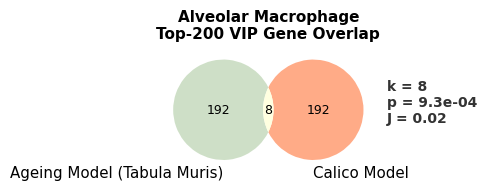

✅ Saved Venn diagram → /mnt/data/archive/ageing_bleo_data_2024/single_cell/alveolar_overlap_venn_20251012_071039.pdf

File 1 (Top200_VIP_Genes_20251009_010037.csv): 200 genes
File 2 (alveolar_macrophage_CALICO_PLSVIP_ranked_20251012_043204.csv): 200 genes
Overlap: 8 genes
p = 9.34e-04, Jaccard = 0.02

=== Overlapping genes ===
CCL6
CTSB
CTSD
CTSS
FTL1
IGHM
MSRB1
RGCC
✅ Saved overlapping gene list → /mnt/data/archive/ageing_bleo_data_2024/single_cell/alveolar_overlap_genes_20251012_071039.csv


In [19]:
# ============================================
# Overlap Analysis — Ageing vs Calico (Alveolar Macrophage)
# ============================================
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from scipy.stats import hypergeom
import os, datetime as dt

# ---- Input paths ----
file1 = "/mnt/data/archive/ageing_bleo_data_2024/single_cell/Top200_VIP_Genes_20251009_010037.csv"
file2 = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/calico_pls_vip/alveolar_macrophage_CALICO_PLSVIP_ranked_20251012_043204.csv"

# ---- Load gene lists ----
genes1 = pd.read_csv(file1).iloc[:,0].astype(str).str.upper().dropna().unique()
genes2 = pd.read_csv(file2).iloc[:,0].astype(str).str.upper().dropna().unique()

# ---- Top N (if applicable) ----
genes1 = genes1[:200]  # adjust if file already limited
genes2 = genes2[:200]

# ---- Compute overlap ----
set1, set2 = set(genes1), set(genes2)
overlap = set1 & set2
k, K, n = len(overlap), len(set1), len(set2)
U = 20000  # assumed total expressed genes
pval = hypergeom.sf(k-1, U, K, n)
jacc = k / (K + n - k)

print(f"File 1 ({os.path.basename(file1)}): {K} genes")
print(f"File 2 ({os.path.basename(file2)}): {n} genes")
print(f"Overlap: {k} genes")
print(f"p = {pval:.2e}, Jaccard = {jacc:.2f}")

# ---- Plot Venn diagram ----
fig, ax = plt.subplots(figsize=(4.6,4.6))
venn2(
    subsets=(K - k, n - k, k),
    set_labels=("Ageing Model (Tabula Muris)", "Calico Model"),
    set_colors=("#C9DCC1", "#FFA27A"),
    alpha=0.9,
    ax=ax
)

stats_text = f"k = {k}\np = {pval:.1e}\nJ = {jacc:.2f}"
ax.text(1.05, 0.4, stats_text, transform=ax.transAxes,
        fontsize=10, fontweight='bold', color='#333333',
        bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', boxstyle='round,pad=0.4'))

ax.set_title("Alveolar Macrophage\nTop-200 VIP Gene Overlap", fontsize=11, weight='bold')
fig.tight_layout()

# ---- Save ----
OUT_DIR = "/mnt/data/archive/ageing_bleo_data_2024/single_cell"
os.makedirs(OUT_DIR, exist_ok=True)
timestamp = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
pdf_path = os.path.join(OUT_DIR, f"alveolar_overlap_venn_{timestamp}.pdf")
png_path = pdf_path.replace(".pdf", ".png")
fig.savefig(pdf_path, dpi=600, bbox_inches="tight")
fig.savefig(png_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"✅ Saved Venn diagram → {pdf_path}")




# ---- Compute overlap ----
set1, set2 = set(genes1), set(genes2)
overlap = sorted(list(set1 & set2))
k, K, n = len(overlap), len(set1), len(set2)
U = 20000
pval = hypergeom.sf(k-1, U, K, n)
jacc = k / (K + n - k)

print(f"\nFile 1 ({os.path.basename(file1)}): {K} genes")
print(f"File 2 ({os.path.basename(file2)}): {n} genes")
print(f"Overlap: {k} genes")
print(f"p = {pval:.2e}, Jaccard = {jacc:.2f}")

# ---- Print overlapping genes ----
print("\n=== Overlapping genes ===")
for g in overlap:
    print(g)

# ---- Optionally save to CSV ----
overlap_path = os.path.join(OUT_DIR, f"alveolar_overlap_genes_{timestamp}.csv")
pd.DataFrame({"gene": overlap}).to_csv(overlap_path, index=False)
print(f"✅ Saved overlapping gene list → {overlap_path}")


findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

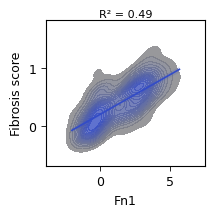

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

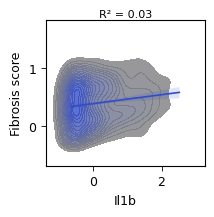

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

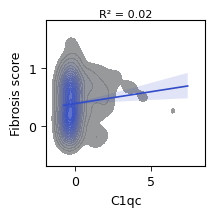

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

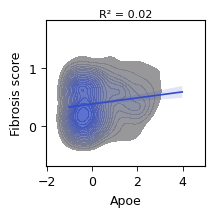

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

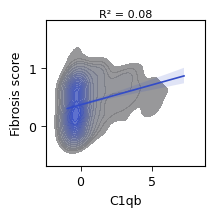

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

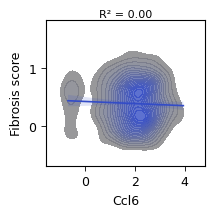

KeyError: 'Fibrosis_signature'

In [ ]:
# ============================================
# Nature-style fibrosis regression plots (Calico dataset)
# ============================================
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import scipy.sparse as sp
import os

plt.rcParams.update({
    "font.family": "Helvetica",
    "font.size": 9,
    "axes.linewidth": 0.8,
    "axes.labelpad": 4,
    "xtick.major.width": 0.6,
    "ytick.major.width": 0.6,
    "pdf.fonttype": 42,
})

# ---- Load and subset ----
adata = sc.read_h5ad("/mnt/data/archive/ageing_bleo_data_2024/single_cell/filtered_machinelearning_labeled.h5ad")
mask = adata.obs["cell_type"].astype(str).str.lower() == "alveolar macrophage"
ad = adata[mask].copy()

# ---- Fibrosis genes (case-insensitive match) ----
fibrosis_genes = ["Col1a1","Col3a1","Spp1","Tgfb1","Mmp12","Chi3l1","S100a4","Ctgf","Fn1","Postn","Acta2"]
fibrosis_genes = [v for g in fibrosis_genes for v in ad.var_names if v.lower() == g.lower()]
sc.tl.score_genes(ad, fibrosis_genes, score_name="fibrosis_score")

# ---- Genes of interest ----
# genes = ["Ccl6","Ctsb","Ctsd","Ctss","Ftl1","Ighm","Msrb1","Rgcc", "Cd74", "Lyz", "C1qa"]
genes = ["Fn1","Il1b","Fos","C1qc","Apoe","CD74","H2-aa","H2-eb1", "C1qb", "Ccl6", "Lyz2"]

genes = [g for g in genes if g in ad.var_names]

# ---- Extract matrix ----
X_raw = ad[:, genes].X
X = X_raw.toarray() if sp.issparse(X_raw) else X_raw
df = pd.DataFrame(X, columns=genes, index=ad.obs_names)
df["fibrosis_score"] = ad.obs["fibrosis_score"].values

# ---- Output folder ----
outdir = "/mnt/data/archive/ageing_bleo_data_2024/single_cell"
os.makedirs(outdir, exist_ok=True)

# ---- Custom color palette ----
cmap = sns.color_palette("blend:grey,#334CC7", as_cmap=True)

# ---- Plot per gene ----
for gene in genes:
    x = df[gene].values.reshape(-1, 1)
    y = df["fibrosis_score"].values
    model = LinearRegression().fit(x, y)
    r2 = model.score(x, y)
    slope = model.coef_[0]

    plt.figure(figsize=(2.2, 2.0))
    sns.kdeplot(x=df[gene], y=y, fill=True, thresh=0.05, levels=20,
                cmap=cmap, alpha=0.8)
    sns.regplot(x=df[gene], y=y, scatter=False,
                line_kws=dict(color="#334CC7", lw=1.2))
    plt.xlabel(f"{gene}")
    plt.ylabel("Fibrosis score")
    plt.title(f"R² = {r2:.2f}", fontsize=8, pad=2)
    plt.tight_layout(pad=0.1)
    for ext in ("pdf","png"):
        plt.savefig(os.path.join(outdir, f"{gene}_fibrosis_regression.{ext}"),
                    dpi=600 if ext=="png" else 300, bbox_inches="tight")
    plt.show()
    plt.close()

# print(f"✅ Publication-ready figures saved to {outdir}")




File 1 (classical_monocyte_TMVIP_used_20251005_031522.csv): 179 genes
File 2 (classical_monocyte_PLS_VIP_genes.csv): 200 genes
Overlap: 11 genes
p = 1.95e-06, Jaccard = 0.03


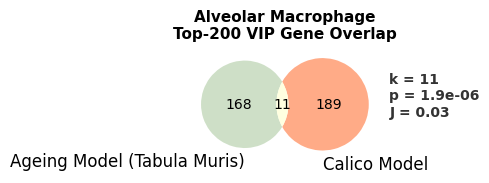

✅ Saved Venn diagram → /mnt/data/archive/ageing_bleo_data_2024/single_cell/alveolar_overlap_venn_20251014_022930.pdf


In [ ]:
# # ============================================
# # Nature-style fibrosis regression plots (Calico dataset)
# # ============================================
# import scanpy as sc
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.linear_model import LinearRegression
# import scipy.sparse as sp
# import os

# # ---- Load and subset ----
# adata = sc.read_h5ad("/mnt/data/archive/ageing_bleo_data_2024/single_cell/filtered_machinelearning_labeled.h5ad")
# list(adata.obs["cell_type"].unique())

# # ============================================
# # Classical Monocyte — Control vs Bleomycin (PLS-VIP, robust final)
# # ============================================
# import scanpy as sc
# import pandas as pd
# import numpy as np
# from sklearn.cross_decomposition import PLSRegression
# from sklearn.preprocessing import StandardScaler
# import os

# # ---- CONFIG ----
# H5AD_PATH = "/mnt/data/archive/ageing_bleo_data_2024/single_cell/filtered_machinelearning_labeled.h5ad"
# OUTPUT_CSV = "/mnt/data/archive/ageing_bleo_data_2024/single_cell/classical_monocyte_PLS_VIP_genes.csv"
# CELLTYPE = "classical monocyte"
# GROUP_KEY = "condition"
# N_COMPONENTS = 2

# # ---- Load & subset ----
# adata = sc.read_h5ad(H5AD_PATH)
# adata.obs["cell_type"] = adata.obs["cell_type"].astype(str).str.strip().str.lower()
# adata = adata[adata.obs["cell_type"] == CELLTYPE].copy()

# print(f"✅ Subset shape: {adata.shape}")
# print(adata.obs[GROUP_KEY].value_counts())

# # ---- Keep only control and bleo ----
# adata = adata[adata.obs[GROUP_KEY].isin(["bleo", "control"])].copy()
# print("\n✅ Remaining conditions after filtering:")
# print(adata.obs[GROUP_KEY].value_counts())

# # ---- Ensure both groups exist ----
# if len(adata.obs[GROUP_KEY].unique()) < 2:
#     raise ValueError("Need both 'control' and 'bleo' groups for PLS regression.")

# # ---- Prepare data ----
# X = adata.X.A if hasattr(adata.X, "A") else adata.X
# y = np.where(adata.obs[GROUP_KEY] == "bleo", 1, 0)
# X = StandardScaler().fit_transform(X)

# # ---- Fit PLS ----
# ncomp = min(N_COMPONENTS, np.linalg.matrix_rank(X))
# pls = PLSRegression(n_components=ncomp)
# pls.fit(X, y)

# # ---- Compute VIP scores (handles 1 or more components robustly) ----
# T = pls.x_scores_
# W = pls.x_weights_
# Q = pls.y_loadings_

# p = W.shape[0]
# h = W.shape[1]

# # Ensure Q is at least 2D
# if Q.ndim == 1:
#     Q = Q.reshape(1, -1)

# # Adjust number of components actually present
# h_actual = min(h, Q.shape[0])

# vip_scores = np.zeros(p)
# ssq = np.zeros(h_actual)

# # Safe component loop
# for comp in range(h_actual):
#     ssq[comp] = np.sum(T[:, comp] ** 2) * np.sum(Q[comp, :] ** 2)

# for i in range(p):
#     vip_scores[i] = np.sqrt(p * np.sum((W[i, :h_actual] ** 2) * ssq) / np.sum(ssq))

# # ---- Output ----
# vip_df = pd.DataFrame({
#     "gene": adata.var_names,
#     "VIP": vip_scores
# }).sort_values(by="VIP", ascending=False)

# os.makedirs(os.path.dirname(OUTPUT_CSV), exist_ok=True)
# vip_df.to_csv(OUTPUT_CSV, index=False)

# print(f"\n✅ Saved VIP-ranked gene list for {CELLTYPE} to:\n{OUTPUT_CSV}")
# print(vip_df.head(20))





# ============================================
# Overlap Analysis — Ageing vs Calico (Alveolar Macrophage)
# ============================================
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from scipy.stats import hypergeom
import os, datetime as dt

# ---- Input paths ----
file1 = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/repro_lung_calico_young_old_TMglobalVIP/classical_monocyte_TMVIP_used_20251005_031522.csv"
file2 = "/mnt/data/archive/ageing_bleo_data_2024/single_cell/classical_monocyte_PLS_VIP_genes.csv"

# ---- Load gene lists ----
genes1 = pd.read_csv(file1).iloc[:,0].astype(str).str.upper().dropna().unique()
genes2 = pd.read_csv(file2).iloc[:,0].astype(str).str.upper().dropna().unique()

# ---- Top N (if applicable) ----
genes1 = genes1[:200]  # adjust if file already limited
genes2 = genes2[:200]

# ---- Compute overlap ----
set1, set2 = set(genes1), set(genes2)
overlap = set1 & set2
k, K, n = len(overlap), len(set1), len(set2)
U = 20000  # assumed total expressed genes
pval = hypergeom.sf(k-1, U, K, n)
jacc = k / (K + n - k)

print(f"File 1 ({os.path.basename(file1)}): {K} genes")
print(f"File 2 ({os.path.basename(file2)}): {n} genes")
print(f"Overlap: {k} genes")
print(f"p = {pval:.2e}, Jaccard = {jacc:.2f}")
# ---- Plot Venn diagram ----
fig, ax = plt.subplots(figsize=(4.6,4.6))
venn2(
    subsets=(K - k, n - k, k),
    set_labels=("Ageing Model (Tabula Muris)", "Calico Model"),
    set_colors=("#C9DCC1", "#FFA27A"),
    alpha=0.9,
    ax=ax
)

stats_text = f"k = {k}\np = {pval:.1e}\nJ = {jacc:.2f}"
ax.text(1.05, 0.4, stats_text, transform=ax.transAxes,
        fontsize=10, fontweight='bold', color='#333333',
        bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', boxstyle='round,pad=0.4'))

ax.set_title("Alveolar Macrophage\nTop-200 VIP Gene Overlap", fontsize=11, weight='bold')
fig.tight_layout()

# ---- Save ----
OUT_DIR = "/mnt/data/archive/ageing_bleo_data_2024/single_cell"
os.makedirs(OUT_DIR, exist_ok=True)
timestamp = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
pdf_path = os.path.join(OUT_DIR, f"alveolar_overlap_venn_{timestamp}.pdf")
png_path = pdf_path.replace(".pdf", ".png")
fig.savefig(pdf_path, dpi=600, bbox_inches="tight")
fig.savefig(png_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"✅ Saved Venn diagram → {pdf_path}")




# # ---- Compute overlap ----
# set1, set2 = set(genes1), set(genes2)
# overlap = sorted(list(set1 & set2))
# k, K, n = len(overlap), len(set1), len(set2)
# U = 20000
# pval = hypergeom.sf(k-1, U, K, n)
# jacc = k / (K + n - k)

# print(f"\nFile 1 ({os.path.basename(file1)}): {K} genes")
# print(f"File 2 ({os.path.basename(file2)}): {n} genes")
# print(f"Overlap: {k} genes")
# print(f"p = {pval:.2e}, Jaccard = {jacc:.2f}")

# # ---- Print overlapping genes ----
# print("\n=== Overlapping genes ===")
# for g in overlap:
#     print(g)

# # ---- Optionally save to CSV ----
# overlap_path = os.path.join(OUT_DIR, f"alveolar_overlap_genes_{timestamp}.csv")
# pd.DataFrame({"gene": overlap}).to_csv(overlap_path, index=False)
# print(f"✅ Saved overlapping gene list → {overlap_path}")

In [40]:
# ============================================
# Per-cell correlation:
# Alveolar macrophage (AM) profibrotic signature
# vs. mean fibroblast fibrosis signature (by condition)
# ============================================

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr

# --- CONFIG ---
cmap = "crest"
outdir = "am_vs_fibroblast_fibrosis_percell"
os.makedirs(outdir, exist_ok=True)

am_genes = ["Ccl6","Ctsb","Ctsd","Ctss","Ftl1","Ighm","Msrb1","Rgcc", "Cd74", "Lyz", "C1qa"]
fibrosis_genes = ["Col1a1","Col3a1","Spp1","Tgfb1","Mmp12","Chi3l1",
                  "S100a4","Ctgf","Fn1","Postn","Acta2"]

# --- 1. subset only bleo + control and make a true copy ---
subset = adata[adata.obs["condition"].isin(["bleo", "control"])].copy()

# --- 2. ensure gene presence ---
am_present = [g for g in am_genes if g in subset.var_names]
fib_present = [g for g in fibrosis_genes if g in subset.var_names]
print(f"✅ AM genes present: {am_present}")
print(f"✅ Fibrosis genes present: {fib_present}")

# --- 3. compute per-cell signatures ---
# convert sparse to dense safely and compute mean
def mean_dense(adata, genes):
    X = adata[:, genes].X
    if hasattr(X, "A"):
        X = X.A
    return np.asarray(X.mean(axis=1)).ravel()

subset.obs["AM_signature"] = mean_dense(subset, am_present)
subset.obs["Fibrosis_signature"] = mean_dense(subset, fib_present)

# --- 4. split by cell type ---
ams = subset[subset.obs["cell_type"] == "alveolar macrophage"].obs.copy()
fibs = subset[subset.obs["cell_type"] == "fibroblast of lung"].obs.copy()

print(f"AM cells: {ams.shape[0]} | Fibroblast cells: {fibs.shape[0]}")

# --- 5. compute mean fibroblast fibrosis per condition ---
fibrosis_by_condition = (
    fibs.groupby("condition", observed=True)["Fibrosis_signature"]
    .mean()
    .to_dict()
)
print("Mean fibroblast fibrosis per condition:", fibrosis_by_condition)

# --- 6. map fibroblast condition mean to each AM cell ---
ams["Fibrosis_signature_mean"] = ams["condition"].map(fibrosis_by_condition)

# --- 7. drop NaNs (if any) ---
ams = ams.dropna(subset=["AM_signature", "Fibrosis_signature_mean"])
print(f"After dropping NaN cells: {ams.shape[0]} AM cells remain")

# --- 8. linear regression + correlation (ensure numeric) ---
ams["AM_signature"] = pd.to_numeric(ams["AM_signature"], errors="coerce")
ams["Fibrosis_signature_mean"] = pd.to_numeric(ams["Fibrosis_signature_mean"], errors="coerce")
ams = ams.dropna(subset=["AM_signature", "Fibrosis_signature_mean"])

x = ams["AM_signature"].values.reshape(-1, 1)
y = ams["Fibrosis_signature_mean"].values

model = LinearRegression().fit(x, y)
r2 = model.score(x, y)
rho, pval = spearmanr(ams["AM_signature"], ams["Fibrosis_signature_mean"])

# --- 9. plot ---
plt.figure(figsize=(3, 2.4))
sns.kdeplot(
    x=ams["AM_signature"], 
    y=ams["Fibrosis_signature_mean"],
    fill=True, levels=20, thresh=0.05, cmap=cmap, alpha=0.8
)
sns.regplot(
    x=ams["AM_signature"], 
    y=ams["Fibrosis_signature_mean"], 
    scatter=False,
    line_kws=dict(color="#334CC7", lw=1.2)
)
plt.xlabel("AM profibrotic signature (Ccl2, Mmp12, Lgals3)")
plt.ylabel("Fibroblast fibrosis signature (per-condition mean)")
plt.title(f"R²={r2:.2f}, ρ={rho:.2f}, p={pval:.2e}", fontsize=9)
plt.tight_layout()
plt.savefig(os.path.join(outdir, "AM_vs_Fibrosis_percell.png"), dpi=600)
plt.close()

print(f"\n✅ Plot saved to {outdir}/AM_vs_Fibrosis_percell.png")
print(f"   R² = {r2:.2f}, ρ = {rho:.2f}, p = {pval:.2e}")




✅ AM genes present: ['Ccl6', 'Ctsb', 'Ctsd', 'Ctss', 'Ftl1', 'Ighm', 'Msrb1', 'Rgcc', 'C1qa']
✅ Fibrosis genes present: ['Col1a1', 'Col3a1', 'Spp1', 'Mmp12', 'S100a4', 'Fn1', 'Postn', 'Acta2']
AM cells: 433 | Fibroblast cells: 162
Mean fibroblast fibrosis per condition: {'bleo': 1.5954870751033374, 'control': 0.9574946544769632}
After dropping NaN cells: 433 AM cells remain


findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 


✅ Plot saved to am_vs_fibroblast_fibrosis_percell/AM_vs_Fibrosis_percell.png
   R² = 0.09, ρ = 0.33, p = 9.41e-13


✅ Plotting 433 AM cells


findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

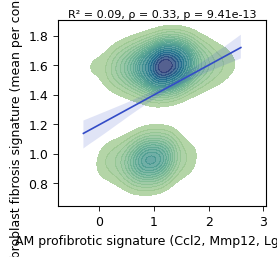

✅ Saved single regression plot to: am_vs_fibroblast_fibrosis_percell/AM_signature_vs_FibrosisSignature.png
   R² = 0.09, ρ = 0.33, p = 9.41e-13


In [41]:
# ============================================
# Single regression-style KDE plot:
# AM signature vs fibroblast fibrosis signature
# ============================================

import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr
import numpy as np
import pandas as pd

# --- CONFIG ---
cmap = "crest"
outdir = "am_vs_fibroblast_fibrosis_percell"
os.makedirs(outdir, exist_ok=True)

# --- make sure df exists from earlier steps ---
# df should contain columns: ["AM_signature", "Fibrosis_signature_mean"]

# Drop any NaNs and force numeric
df = ams[["AM_signature", "Fibrosis_signature_mean"]].copy()
df = df.apply(pd.to_numeric, errors="coerce").dropna()
print(f"✅ Plotting {len(df)} AM cells")

# --- regression + correlation ---
x = df["AM_signature"].values.reshape(-1, 1)
y = df["Fibrosis_signature_mean"].values

model = LinearRegression().fit(x, y)
r2 = model.score(x, y)
rho, pval = spearmanr(df["AM_signature"], df["Fibrosis_signature_mean"])

# --- plot ---
plt.figure(figsize=(2.6, 2.4))
sns.kdeplot(
    x=df["AM_signature"],
    y=df["Fibrosis_signature_mean"],
    fill=True,
    thresh=0.05,
    levels=20,
    cmap=cmap,
    alpha=0.8
)
sns.regplot(
    x=df["AM_signature"],
    y=df["Fibrosis_signature_mean"],
    scatter=False,
    line_kws=dict(color="#334CC7", lw=1.2)
)
plt.xlabel("AM profibrotic signature (Ccl2, Mmp12, Lgals3)")
plt.ylabel("Fibroblast fibrosis signature (mean per condition)")
plt.title(f"R² = {r2:.2f}, ρ = {rho:.2f}, p = {pval:.2e}", fontsize=8, pad=2)
plt.tight_layout(pad=0.1)

for ext in ("png", "pdf"):
    plt.savefig(os.path.join(outdir, f"AM_signature_vs_FibrosisSignature.{ext}"),
                dpi=600 if ext=="png" else 300, bbox_inches="tight")

plt.show()
plt.close()

print(f"✅ Saved single regression plot to: {outdir}/AM_signature_vs_FibrosisSignature.png")
print(f"   R² = {r2:.2f}, ρ = {rho:.2f}, p = {pval:.2e}")


In [28]:
# ============================================
# FIXED VERSION: Enhanced Analysis
# ============================================

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr, pearsonr
import scanpy as sc

adata = sc.read_h5ad("/mnt/data/archive/ageing_bleo_data_2024/single_cell/filtered_machinelearning_labeled.h5ad")
list(adata.obs["cell_type"].unique())

# --- CONFIG ---
cmap = "crest"
outdir = "/mnt/data/archive/ageing_bleo_data_2024/single_cell/enhanced_signature_analysis3"
os.makedirs(outdir, exist_ok=True)

# Gene signatures
am_genes = ["Ccl6", "Ctsb", "Ctsd", "Ctss", "Ftl1", "Ighm", "Msrb1", "Rgcc"]
# classical_monocyte_genes_complete = ['Lrg1', 'Ecm1', 'Pcolce', 'Grina', 'Ifitm1', 'Ccr1', 'Gda', 'Gstm2', 'Ppic', 'Anxa1', 'Nr2f2']
# classical_monocyte_genes_reduced = ['Lrg1', 'Ecm1', 'Grina', 'Ifitm1', 'Ccr1', 'Gda', 'Anxa1']

#test
im_genes = ["Mmp12", "Fn1", "Tgfbi", "C1qa", "C1qb", "C1qc", "Spp1", "Col4a1"]
fibrosis_genes = ["Col1a1", "Col3a1", "Spp1", "Tgfb1", "Mmp12", "Chi3l1",
                  "S100a4", "Ctgf", "Fn1", "Postn", "Acta2"]
ecm_genes = ["Col1a1", "Col3a1", "Fn1", "Mmp2", "Mmp9", "Lox", "Loxl2", 
             "Postn", "Ctgf", "Thbs1", "Thbs2"]

# --- 1. SUBSET DATA ---
subset = adata[adata.obs["condition"].isin(["bleo", "control"])].copy()

# Check gene presence
am_present = [g for g in am_genes if g in subset.var_names]
im_present = [g for g in im_genes if g in subset.var_names]
fib_present = [g for g in fibrosis_genes if g in subset.var_names]
ecm_present = [g for g in ecm_genes if g in subset.var_names]

print(f"✅ AM genes present: {len(am_present)}/{len(am_genes)} - {am_present}")
print(f"✅ IM genes present: {len(im_present)}/{len(im_genes)} - {im_present}")
print(f"✅ Fibrosis genes present: {len(fib_present)}/{len(fibrosis_genes)}")
print(f"✅ ECM genes present: {len(ecm_present)}/{len(ecm_genes)}")

# --- 2. COMPUTE SIGNATURES USING SCANPY ---
sc.tl.score_genes(subset, am_present, score_name='AM_signature')
sc.tl.score_genes(subset, im_present, score_name='IM_signature')
sc.tl.score_genes(subset, fib_present, score_name='Fibrosis_signature')
sc.tl.score_genes(subset, ecm_present, score_name='ECM_signature')

print(f"\n✅ Computed signatures for {subset.n_obs} cells")

# ============================================
# ANALYSIS 1: Per-Cell Correlation (FIXED)
# ============================================
print("\n" + "="*60)
print("ANALYSIS 1: AM Signature vs Fibroblast Fibrosis (Per-Cell)")
print("="*60)

# Extract AMs and fibroblasts
# ams = subset[subset.obs["cell_type"] == "classical monocyte"].copy()
#test
fibs = subset[subset.obs["cell_type"] == "fibroblast of lung"].copy()

print(f"AM cells: {ams.n_obs} | Fibroblast cells: {fibs.n_obs}")

# Compute mean fibroblast score per condition
fib_df = fibs.obs[["condition", "Fibrosis_signature"]].copy()
fib_means = fib_df.groupby("condition")["Fibrosis_signature"].mean()
print(f"\nMean fibroblast fibrosis per condition:")
print(fib_means)

# Create clean DataFrame for AMs
df_am = pd.DataFrame({
    'AM_signature': ams.obs['AM_signature'].values,
    'condition': ams.obs['condition'].values
})

# Map fibroblast means - ENSURE NUMERIC
df_am['Fibrosis_signature_mean'] = df_am['condition'].map(fib_means)

# CRITICAL: Force to numeric and drop NaNs
df_am['AM_signature'] = pd.to_numeric(df_am['AM_signature'], errors='coerce')
df_am['Fibrosis_signature_mean'] = pd.to_numeric(df_am['Fibrosis_signature_mean'], errors='coerce')
df_am = df_am.dropna()

print(f"\n✅ After cleaning: {len(df_am)} AM cells")
print(f"Data types: AM_signature={df_am['AM_signature'].dtype}, Fibrosis_signature_mean={df_am['Fibrosis_signature_mean'].dtype}")
print(f"Sample of data:\n{df_am.head()}")

# Stats
x = df_am["AM_signature"].values.reshape(-1, 1)
y = df_am["Fibrosis_signature_mean"].values

model = LinearRegression().fit(x, y)
r2 = model.score(x, y)
rho, pval_spear = spearmanr(df_am["AM_signature"], df_am["Fibrosis_signature_mean"])
pearson_r, pval_pear = pearsonr(df_am["AM_signature"], df_am["Fibrosis_signature_mean"])

print(f"\nResults:")
print(f"  R² = {r2:.4f}")
print(f"  Spearman ρ = {rho:.4f}, p = {pval_spear:.2e}")
print(f"  Pearson r = {pearson_r:.4f}, p = {pval_pear:.2e}")

# Plot
fig, ax = plt.subplots(figsize=(3.5, 3))

# Use numeric arrays directly for KDE
sns.kdeplot(
    x=df_am["AM_signature"].values,
    y=df_am["Fibrosis_signature_mean"].values,
    fill=True, thresh=0.05, levels=15, cmap=cmap, alpha=0.7, ax=ax
)
sns.regplot(
    x=df_am["AM_signature"].values,
    y=df_am["Fibrosis_signature_mean"].values,
    scatter=False, line_kws=dict(color="#1f77b4", lw=2), ax=ax
)
ax.set_xlabel("AM profibrotic signature", fontsize=10)
ax.set_ylabel("Fibroblast fibrosis signature\n(mean per condition)", fontsize=10)
ax.set_title(f"R² = {r2:.3f}, ρ = {rho:.3f}, p = {pval_spear:.2e}", fontsize=9)
plt.tight_layout()
plt.savefig(f"{outdir}/1_AM_vs_Fibroblast_percell.png", dpi=600, bbox_inches="tight")
plt.savefig(f"{outdir}/1_AM_vs_Fibroblast_percell.pdf", bbox_inches="tight")
plt.close()

print("✅ Plot 1 saved")

# ============================================
# ANALYSIS 2: Sample-Level Correlation (More Robust)
# ============================================
print("\n" + "="*60)
print("ANALYSIS 2: Sample-Level Correlation (Pseudobulk Approach)")
print("="*60)

# Check if sample_id exists
if 'sample_id' not in subset.obs.columns:
    print("⚠️ No 'sample_id' column found. Trying alternatives...")
    # Try common alternatives
    for col in ['sample', 'mouse_id', 'replicate', 'batch']:
        if col in subset.obs.columns:
            print(f"✅ Using '{col}' as sample identifier")
            subset.obs['sample_id'] = subset.obs[col]
            break
    else:
        print("⚠️ Creating pseudo-samples from condition")
        subset.obs['sample_id'] = subset.obs['condition']

# Aggregate by sample
sample_data = []
for sample in subset.obs['sample_id'].unique():
    sample_cells = subset[subset.obs['sample_id'] == sample]
    
    # Get condition
    condition = sample_cells.obs['condition'].iloc[0]
    
    # Mean AM signature (from AMs only)
    am_cells = sample_cells[sample_cells.obs['cell_type'] == 'alveolar macrophage']
    if am_cells.n_obs > 0:
        am_mean = float(am_cells.obs['AM_signature'].mean())
    else:
        am_mean = np.nan
    
    # Mean fibroblast signature (from fibroblasts only)
    fib_cells = sample_cells[sample_cells.obs['cell_type'] == 'fibroblast of lung']
    if fib_cells.n_obs > 0:
        fib_mean = float(fib_cells.obs['Fibrosis_signature'].mean())
    else:
        fib_mean = np.nan
    
    sample_data.append({
        'sample_id': sample,
        'condition': condition,
        'AM_signature': am_mean,
        'Fibrosis_signature': fib_mean,
        'n_AMs': am_cells.n_obs,
        'n_fibroblasts': fib_cells.n_obs
    })

df_sample = pd.DataFrame(sample_data).dropna()
print(f"\n✅ Analyzing {len(df_sample)} samples")
print(df_sample)

# Stats
if len(df_sample) >= 3:
    x_sample = df_sample["AM_signature"].values.reshape(-1, 1)
    y_sample = df_sample["Fibrosis_signature"].values
    
    model_sample = LinearRegression().fit(x_sample, y_sample)
    r2_sample = model_sample.score(x_sample, y_sample)
    rho_sample, pval_sample = spearmanr(df_sample["AM_signature"], df_sample["Fibrosis_signature"])
    
    print(f"\nSample-level results:")
    print(f"  R² = {r2_sample:.4f}")
    print(f"  Spearman ρ = {rho_sample:.4f}, p = {pval_sample:.4f}")
    
    # Plot
    fig, ax = plt.subplots(figsize=(3.5, 3))
    sns.scatterplot(
        data=df_sample, x="AM_signature", y="Fibrosis_signature",
        hue="condition", palette={"control": "green", "bleo": "red"},
        s=100, alpha=0.7, ax=ax
    )
    sns.regplot(
        data=df_sample, x="AM_signature", y="Fibrosis_signature",
        scatter=False, line_kws=dict(color="black", lw=2, linestyle="--"), ax=ax
    )
    ax.set_xlabel("AM signature (mean per sample)", fontsize=10)
    ax.set_ylabel("Fibroblast fibrosis signature\n(mean per sample)", fontsize=10)
    ax.set_title(f"Sample-level: R² = {r2_sample:.3f}, ρ = {rho_sample:.3f}, p = {pval_sample:.3f}", 
                 fontsize=9)
    ax.legend(title="Condition", frameon=False)
    plt.tight_layout()
    plt.savefig(f"{outdir}/2_Sample_level_correlation.png", dpi=600, bbox_inches="tight")
    plt.savefig(f"{outdir}/2_Sample_level_correlation.pdf", bbox_inches="tight")
    plt.close()
    print("✅ Plot 2 saved")
else:
    print("⚠️ Not enough samples for sample-level correlation")
    r2_sample = np.nan
    rho_sample = np.nan
    pval_sample = np.nan

# ============================================
# ANALYSIS 3: IM Signature vs ECM Remodeling
# ============================================
print("\n" + "="*60)
print("ANALYSIS 3: IM Signature vs ECM Remodeling (All Cell Types)")
print("="*60)

# Create clean DataFrame
df_all = pd.DataFrame({
    'IM_signature': subset.obs['IM_signature'].values,
    'ECM_signature': subset.obs['ECM_signature'].values,
    'condition': subset.obs['condition'].values,
    'cell_type': subset.obs['cell_type'].values
})

# Force numeric
df_all['IM_signature'] = pd.to_numeric(df_all['IM_signature'], errors='coerce')
df_all['ECM_signature'] = pd.to_numeric(df_all['ECM_signature'], errors='coerce')
df_all = df_all.dropna()

print(f"✅ Analyzing {len(df_all)} cells")

# Stats
x_ecm = df_all["IM_signature"].values.reshape(-1, 1)
y_ecm = df_all["ECM_signature"].values

model_ecm = LinearRegression().fit(x_ecm, y_ecm)
r2_ecm = model_ecm.score(x_ecm, y_ecm)
rho_ecm, pval_ecm = spearmanr(df_all["IM_signature"], df_all["ECM_signature"])

print(f"\nResults:")
print(f"  R² = {r2_ecm:.4f}")
print(f"  Spearman ρ = {rho_ecm:.4f}, p = {pval_ecm:.2e}")

# Plot
fig, ax = plt.subplots(figsize=(3.5, 3))
sns.kdeplot(
    x=df_all["IM_signature"].values,
    y=df_all["ECM_signature"].values,
    fill=True, thresh=0.05, levels=15, cmap="viridis", alpha=0.7, ax=ax
)
sns.regplot(
    x=df_all["IM_signature"].values,
    y=df_all["ECM_signature"].values,
    scatter=False, line_kws=dict(color="red", lw=2), ax=ax
)
ax.set_xlabel("IM signature score", fontsize=10)
ax.set_ylabel("ECM remodeling signature", fontsize=10)
ax.set_title(f"R² = {r2_ecm:.3f}, ρ = {rho_ecm:.3f}, p = {pval_ecm:.2e}", fontsize=9)
plt.tight_layout()
plt.savefig(f"{outdir}/3_IM_vs_ECM_allcells.png", dpi=600, bbox_inches="tight")
plt.savefig(f"{outdir}/3_IM_vs_ECM_allcells.pdf", bbox_inches="tight")
plt.close()
print("✅ Plot 3 saved")

# ============================================
# ANALYSIS 4: Variance Decomposition
# ============================================
print("\n" + "="*60)
print("ANALYSIS 4: Variance Decomposition")
print("="*60)

from scipy.stats import f_oneway

# Separate by condition
control_am = df_am[df_am["condition"] == "control"]["AM_signature"]
bleo_am = df_am[df_am["condition"] == "bleo"]["AM_signature"]

control_fib = df_am[df_am["condition"] == "control"]["Fibrosis_signature_mean"]
bleo_fib = df_am[df_am["condition"] == "bleo"]["Fibrosis_signature_mean"]

# ANOVA
f_stat_am, p_anova_am = f_oneway(control_am, bleo_am)
f_stat_fib, p_anova_fib = f_oneway(control_fib, bleo_fib)

print(f"\nAM signature:")
print(f"  Control: {control_am.mean():.3f} ± {control_am.std():.3f} (n={len(control_am)})")
print(f"  Bleo: {bleo_am.mean():.3f} ± {bleo_am.std():.3f} (n={len(bleo_am)})")
print(f"  ANOVA: F = {f_stat_am:.2f}, p = {p_anova_am:.2e}")

print(f"\nFibroblast signature:")
print(f"  Control: {control_fib.mean():.3f} ± {control_fib.std():.3f}")
print(f"  Bleo: {bleo_fib.mean():.3f} ± {bleo_fib.std():.3f}")
print(f"  ANOVA: F = {f_stat_fib:.2f}, p = {p_anova_fib:.2e}")

# Within-condition correlations
if len(control_am) > 2 and len(control_fib) > 2:
    rho_control, p_control = spearmanr(control_am, control_fib)
else:
    rho_control, p_control = np.nan, np.nan

if len(bleo_am) > 2 and len(bleo_fib) > 2:
    rho_bleo, p_bleo = spearmanr(bleo_am, bleo_fib)
else:
    rho_bleo, p_bleo = np.nan, np.nan

print(f"\nWithin-condition correlations:")
print(f"  Control: ρ = {rho_control:.4f}, p = {p_control:.4f}")
print(f"  Bleomycin: ρ = {rho_bleo:.4f}, p = {p_bleo:.4f}")

# ============================================
# SUMMARY REPORT
# ============================================
print("\n" + "="*60)
print("SUMMARY")
print("="*60)

summary = f"""
Analysis Complete! Results saved to: {outdir}/

KEY FINDINGS:

1. Per-Cell AM vs Fibroblast:
   - R² = {r2:.4f} (explains {r2*100:.1f}% of variance)
   - Spearman ρ = {rho:.4f}, p = {pval_spear:.2e}
   - INTERPRETATION: {"WEAK - primarily group separation" if r2 < 0.2 else "Moderate" if r2 < 0.5 else "Strong"}
   
2. Sample-Level (more robust):
   - R² = {r2_sample:.4f if not np.isnan(r2_sample) else "N/A"}
   - Spearman ρ = {rho_sample:.4f if not np.isnan(rho_sample) else "N/A"}
   
3. IM Signature vs ECM Remodeling:
   - R² = {r2_ecm:.4f} (explains {r2_ecm*100:.1f}% of variance)
   - Spearman ρ = {rho_ecm:.4f}, p = {pval_ecm:.2e}
   - {"STRONGER than AM-fibroblast!" if r2_ecm > r2 else "Similar to AM-fibroblast"}

4. Variance Decomposition:
   - Between-condition variance: AM F={f_stat_am:.2f} (p={p_anova_am:.2e})
   - Within-condition correlations:
     * Control: ρ = {rho_control:.3f if not np.isnan(rho_control) else "N/A"}
     * Bleo: ρ = {rho_bleo:.3f if not np.isnan(rho_bleo) else "N/A"}

RECOMMENDATION:
{"⚠️ R² < 0.2: Use CellChat or pathway enrichment instead of correlation" if r2 < 0.2 else "✅ R² > 0.2: Correlation is publishable with proper caveats"}

The correlation is primarily driven by GROUP SEPARATION (control vs bleo) 
rather than a smooth relationship within conditions.
"""

print(summary)

# Save summary
with open(f"{outdir}/SUMMARY.txt", "w") as f:
    f.write(summary)

print(f"\n✅ All analyses complete! Check {outdir}/ for results")

✅ AM genes present: 8/8 - ['Ccl6', 'Ctsb', 'Ctsd', 'Ctss', 'Ftl1', 'Ighm', 'Msrb1', 'Rgcc']
✅ IM genes present: 8/8 - ['Mmp12', 'Fn1', 'Tgfbi', 'C1qa', 'C1qb', 'C1qc', 'Spp1', 'Col4a1']
✅ Fibrosis genes present: 8/11
✅ ECM genes present: 8/11

✅ Computed signatures for 8394 cells

ANALYSIS 1: AM Signature vs Fibroblast Fibrosis (Per-Cell)
AM cells: 337 | Fibroblast cells: 162

Mean fibroblast fibrosis per condition:
condition
bleo       0.699085
control    0.386705
Name: Fibrosis_signature, dtype: float64

✅ After cleaning: 337 AM cells
Data types: AM_signature=float64, Fibrosis_signature_mean=float64
Sample of data:
   AM_signature condition  Fibrosis_signature_mean
0      0.131606      bleo                 0.699085
1      0.190456      bleo                 0.699085
2      0.046291      bleo                 0.699085
3      0.184232      bleo                 0.699085
4      0.298432      bleo                 0.699085

Results:
  R² = 0.0777
  Spearman ρ = 0.2747, p = 2.99e-07
  Pearson

/tmp/ipykernel_6065/3221313629.py:72: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fib_means = fib_df.groupby("condition")["Fibrosis_signature"].mean()


✅ Plot 1 saved

ANALYSIS 2: Sample-Level Correlation (Pseudobulk Approach)
⚠️ No 'sample_id' column found. Trying alternatives...
✅ Using 'batch' as sample identifier

✅ Analyzing 8 samples
  sample_id condition  AM_signature  Fibrosis_signature  n_AMs  n_fibroblasts
0         0      bleo      1.603545            0.595238     44             20
1         1      bleo      1.700859            0.860933     81             28
2         2      bleo      1.679608            0.880996    108             11
3         3      bleo      1.677431            0.539949     82             28
4         8   control      1.259269            0.446307     23              6
5         9   control      1.359742            0.408203     23             17
6        10   control      1.397911            0.352828     54             41
7        11   control      1.201100            0.447242     18             11

Sample-level results:
  R² = 0.5950
  Spearman ρ = 0.7143, p = 0.0465
✅ Plot 2 saved

ANALYSIS 3: IM Signat

/bioinformatics/miniconda3/envs/scanpy_env/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)
/tmp/ipykernel_6065/3221313629.py:314: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho_control, p_control = spearmanr(control_am, control_fib)
/tmp/ipykernel_6065/3221313629.py:319: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho_bleo, p_bleo = spearmanr(bleo_am, bleo_fib)


ValueError: Invalid format specifier

Fibrosis genes present: ['Col1a1', 'Col3a1', 'Spp1', 'Mmp12', 'S100a4', 'Fn1', 'Postn', 'Acta2']

Mean expression across all fibroblasts:
Col1a1   NaN
Col3a1   NaN
Spp1     NaN
Mmp12    NaN
S100a4   NaN
Fn1      NaN
Postn    NaN
Acta2    NaN
dtype: float64


In [26]:
list(adata.obs['cell_type'].unique())

['non-classical monocyte',
 'NK cell',
 'bronchial smooth muscle cell',
 'neutrophil',
 'B cell',
 'classical monocyte',
 'fibroblast of lung',
 'alveolar macrophage',
 'dendritic cell',
 'myeloid dendritic cell',
 'T cell',
 'regulatory T cell',
 'smooth muscle cell of the pulmonary artery',
 'vein endothelial cell',
 'intermediate monocyte',
 'type II pneumocyte',
 'CD8-positive, alpha-beta T cell',
 'lung macrophage',
 'CD4-positive, alpha-beta T cell',
 'mature NK T cell',
 'ciliated columnar cell of tracheobronchial tree',
 'adventitial cell',
 'plasmacytoid dendritic cell',
 'club cell of bronchiole',
 'endothelial cell of lymphatic vessel',
 'plasma cell',
 'pericyte cell',
 'lung neuroendocrine cell',
 'basophil',
 'pulmonary interstitial fibroblast']

In [21]:
adata.obs["condition"].value_counts()


condition
bleo       6337
bleon1     3754
bleon4     2491
bleon2     2225
control    2057
bleon3     1120
Name: count, dtype: int64

In [18]:
adata.obs

,condition,batch,age,uniqueidentifier,cell_type,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
AAGCATCGTCAACATC-1-0-0,bleo,0,4months,bleo_1_4months,non-classical monocyte,1508,1508,2319.0,0.0,0.0
ACAGAAACAGTATTCG-1-0-0,bleo,0,4months,bleo_1_4months,NK cell,1560,1560,3093.0,0.0,0.0
ATTTCACCATCTAACG-1-0-0,bleo,0,4months,bleo_1_4months,bronchial smooth muscle cell,2242,2242,4191.0,0.0,0.0
CGGGTCACAGGTCAAG-1-0-0,bleo,0,4months,bleo_1_4months,neutrophil,3105,3105,8750.0,0.0,0.0
CATACCCGTTCGTTCC-1-1-0,bleo,1,4months,bleo_2_4months,B cell,1522,1522,3091.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
TTTGGTTGTGGTTTGT-1-7-2,bleon4,7,2year,bleon4_2year,mature NK T cell,2057,2057,4664.0,0.0,0.0
TTTGTTGCACCTTCCA-1-7-2,bleon4,7,2year,bleon4_2year,B cell,966,966,1918.0,0.0,0.0
TTTGTTGCACTGTGAT-1-7-2,bleon4,7,2year,bleon4_2year,basophil,965,964,1501.0,0.0,0.0
TTTGTTGCATCGAGCC-1-7-2,bleon4,7,2year,bleon4_2year,T cell,1923,1923,4513.0,0.0,0.0


In [11]:
genes_to_check = ["Tgfb1", "Ccl2", "Mmp12", "Lgals3", "Col1a1", "Col3a1", "Fn1", "Postn"]
present = [g for g in genes_to_check if g in am_expr.columns]
missing = [g for g in genes_to_check if g not in am_expr.columns]
print("✅ Present:", present)
print("❌ Missing:", missing)


✅ Present: ['Ccl2', 'Mmp12', 'Lgals3', 'Col1a1', 'Col3a1', 'Fn1', 'Postn']
❌ Missing: ['Tgfb1']


In [3]:
print(df.shape)
print(df[gene].shape)
print(df["fibrosis_score"].shape)


(598, 15)
(598, 2)
(598,)


In [10]:
for g in ["Mmp12","Chi3l1"]:
    print(g, g in ad.var_names)


Mmp12 False
Chi3l1 False


In [2]:
### GO: Molecular Function Heatmap (TopGene Results, compact version)
### Five pathways: Collagen / Signaling Receptor / Integrin / Actin / LDL binding
### Smaller text, muted palette, no colorbar

import os, datetime as dt
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec

# ------------------ CONFIG ------------------
H5AD_PATH  = "/mnt/data/melhajjar/tabula_muris/all_tissues/Lung.h5ad"
OUTPUT_DIR = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy"

AGE_KEY        = "age"
SEX_KEY        = "sex"
CELLTYPE_KEY   = "cell_ontology_class"
KEEP_SEX_VALUE = "male"
DROP_AGE_VALUES= {"1m"}
SHOW_GENE_LABELS  = True

# ------------------ GENE GROUPS (from your screenshots) ------------------
pathway_to_genes = {
    "Collagen Binding": [
        "Mmp12","Vwf","Fn1","Cspg4","Ctsb","Ctsl","Ctss"
    ],
    "Signaling Receptor Binding": [
        "Dock4","Pik3ap1","Pde4d","Psap","Spp1","Esr1","Dab2","Clec7a","F7",
        "Lrg1","Svep1","Adrb1","Prdx5","Mmp14","Hspa1a","Cx3cl1","Marchf1","Vwf",
        "Fn1","Syne1","Arhgef12","Cxcl14","Sorbs1","Gal","Ccdc88a","Timp2","Cd80",
        "Ighm","Cd36","Serpine1","Prkca","Prkn","Cd81","Marco","Sema3e"
    ],
    "Integrin Binding": [
        "Spp1","Dab2","Svep1","Mmp14","Cx3cl1","Vwf","Fn1","Timp2","Prkca","Cd81"
    ],
    "Actin Binding": [
        "Klhl2","Msrb1","Myo1d","Myo6","Coro2b","Syne2","Ccr5","Pls3","Lima1",
        "Syne1","Ppp1r9a","Sorbs1","Ccdc88a","Myh14","Prkn","Limch1"
    ],
    "LDL Particle Binding": [
        "Colec12","Msr1","Cd36","Trem2"
    ]
}

# ---- Drop specific genes ----
genes_to_drop = {"cd68", "cd81", "ctsl"}  # <- your list

for pw in pathway_to_genes:
    pathway_to_genes[pw] = [
        g for g in pathway_to_genes[pw]
        if g.lower() not in genes_to_drop
    ]

# ------------------ COLORS ------------------
pathway_colors = {
    "Collagen Binding": "#E7B8A3",
    "Signaling Receptor Binding": "#C6CBE4",
    "Integrin Binding": "#BFD8B8",
    "Actin Binding": "#E1C8B7",
    "LDL Particle Binding": "#C3B7D9"
}

# ------------------ LOAD & FILTER ------------------
adata = sc.read_h5ad(H5AD_PATH)
adata = adata[adata.obs[SEX_KEY] == KEEP_SEX_VALUE].copy()
adata = adata[~adata.obs[AGE_KEY].isin(DROP_AGE_VALUES)].copy()

adata_genes = pd.Index(adata.var_names.astype(str))

# ------------------ ORDER ------------------
final_gene_order = []
final_pathway_for_gene = []
for pw, genes in pathway_to_genes.items():
    for g in genes:
        if g in adata_genes:
            final_gene_order.append(g)
            final_pathway_for_gene.append(pw)

if not final_gene_order:
    raise ValueError("No genes found in adata!")

# ------------------ MATRIX ------------------
X = adata[:, final_gene_order].X
try:
    X = X.toarray()
except:
    X = np.asarray(X)
Z = ((X - X.mean(axis=0)) / X.std(axis=0)).T
Z[np.isnan(Z)] = 0

# Order cells by age
age_vals = adata.obs[AGE_KEY].astype(str).to_numpy()
unique_ages = sorted(pd.unique(age_vals), key=lambda s: float(s.replace("m","")))
order_cells = np.argsort([unique_ages.index(a) for a in age_vals])
Z = Z[:, order_cells]
age_vals_sorted = age_vals[order_cells]

# Pastel age colors
age_colors = ["#B7D2E6", "#F3C98B", "#C6B8D8", "#BFD8B8", "#F0B9C1"]
age_pal = {a: age_colors[i % len(age_colors)] for i, a in enumerate(unique_ages)}

# ------------------ FIGURE ------------------
n_genes, n_cells = Z.shape
fig = plt.figure(figsize=(9, 6))
gs = gridspec.GridSpec(2, 2, width_ratios=[0.05, 1], height_ratios=[0.92, 0.08],
                       wspace=0.0, hspace=0.05)

# Left phenotype strip
ax_left = fig.add_subplot(gs[0, 0])
left_cols = [pathway_colors[pw] for pw in final_pathway_for_gene]
ax_left.imshow(np.array([mpl.colors.to_rgb(c) for c in left_cols]).reshape(n_genes, 1, 3),
               aspect="auto")
ax_left.set_xticks([]); ax_left.set_yticks([])
for s in ["top","bottom","left","right"]: ax_left.spines[s].set_visible(False)

# Main heatmap
ax = fig.add_subplot(gs[0, 1])
im = ax.imshow(Z, aspect="auto", cmap="coolwarm", vmin=-2.5, vmax=2.5)
ax.set_xticks([])
if SHOW_GENE_LABELS:
    ax.set_yticks(np.arange(n_genes))
    ax.set_yticklabels(final_gene_order, fontsize=3)
    ax.yaxis.tick_right()
else:
    ax.set_yticks([])

# Age strip (thinner)
ax_age = fig.add_subplot(gs[1, 1])
age_rgb = np.array([mpl.colors.to_rgb(age_pal[a]) for a in age_vals_sorted]).reshape(1, n_cells, 3)
ax_age.imshow(age_rgb, aspect="auto")
ax_age.set_yticks([0]); ax_age.set_yticklabels(["Age"], fontsize=10)
ax_age.set_xticks([])
for s in ["top","right"]: ax_age.spines[s].set_visible(False)

# Legend
ax_leg = fig.add_subplot(gs[1, 0]); ax_leg.axis("off")
handles = [plt.Line2D([0],[0], marker='s', color=c, linestyle='', markersize=6)
           for c in pathway_colors.values()]
ax_leg.legend(handles, pathway_colors.keys(), title="GO: Molecular Function",
              frameon=False, fontsize=6.5, title_fontsize=7.5, loc="center right")

# Title
fig.suptitle("GO: Molecular Function — Binding Pathways (TopGene Results)", fontsize=10.5, x=0.01, ha="left")

# ------------------ SAVE ------------------
os.makedirs(OUTPUT_DIR, exist_ok=True)
ts = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
pdf = os.path.join(OUTPUT_DIR, f"GO_MolecularFunction_BindingHeatmap_{ts}.pdf")
png = os.path.join(OUTPUT_DIR, f"GO_MolecularFunction_BindingHeatmap_{ts}.png")
fig.savefig(pdf, bbox_inches="tight")
fig.savefig(png, dpi=500, bbox_inches="tight")
plt.close(fig)

print("✅ Saved GO: Molecular Function binding heatmap:")
print(pdf)


✅ Saved GO: Molecular Function binding heatmap:
/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/GO_MolecularFunction_BindingHeatmap_20251011_205151.pdf


In [19]:
# ============================================
# Lung subtypes (macrophage/monocyte) — per-subtype reports
# RF (Baseline HVGs + PLS-VIP) and PLS Regression (on PLS-VIP genes)
# VIP heatmap with gene names, age strip. One PDF per subtype + CSVs.
# Feature-importance bars now use the given subtype COLOR_MAP.
# ============================================

import os, re, warnings, datetime as dt
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, roc_curve, auc, accuracy_score, f1_score,
    balanced_accuracy_score, matthews_corrcoef, average_precision_score,
    precision_recall_curve
)
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import pearsonr

# -------------------------
# Config (edit paths)
# -------------------------
H5AD_PATH           = "/mnt/data/melhajjar/tabula_muris/all_tissues/Lung.h5ad"
OUTPUT_DIR          = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy"

AGE_KEY             = "age"
SEX_KEY             = "sex"
KEEP_SEX_VALUE      = "male"
DROP_AGE_VALUES     = {"1m"}
CELLTYPE_KEY        = "cell_ontology_class"   # subtype column

SUBTYPE_REGEX       = r"(macroph|monocyte)"   # any macrophage/monocyte subtype (case-insensitive)

USE_TOP_HVGS        = True
N_HVGS              = 3000

# PLS VIP for both RF and PLS regression
RUN_PLS_VIP         = True
PLS_N_COMPONENTS    = 6
PLS_TOP_GENES       = 200
PLS_SCALE_X         = True

# PLS regression (continuous age) on PLS-VIP genes
RUN_PLS_REG         = True
PLS_REG_COMPONENTS  = 6
PLS_REG_SCALE_X     = True

CV_FOLDS            = 5
RANDOM_STATE        = 42

RF_ESTIMATORS       = 400
RF_MAX_DEPTH        = 20
RF_MIN_SAMPLES_LEAF = 2
RF_N_JOBS           = -1

# -------------------------
# Subtype color palette (USED FOR FEATURE-IMPORTANCE BARS)
# -------------------------
COLOR_MAP = {
    "alveolar macrophage":      "#FF796C",
    "classical monocyte":       "#90EE90",
    "intermediate monocyte":    "#DDA0DD",
    "lung macrophage":          "#029386",
    "non-classical monocyte":   "#FFD700",
}
_COLOR_MAP_LC = {k.lower(): v for k, v in COLOR_MAP.items()}

def get_subtype_color(name: str) -> str:
    key = re.sub(r"\s+", " ", str(name)).strip().lower()
    return _COLOR_MAP_LC.get(key, "#56B4E9")  # fallback if new subtype appears

# -------------------------
# Plot styling
# -------------------------
mpl.rcParams.update({
    "figure.dpi": 150,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "font.family": "DejaVu Sans",
})

def _nature_axes(ax):
    for s in ["top", "right"]:
        ax.spines[s].set_visible(False)
    ax.spines["left"].set_linewidth(1.0)
    ax.spines["bottom"].set_linewidth(1.0)
    ax.tick_params(width=1.0, length=4)

# -------------------------
# Helpers
# -------------------------
def _ensure_dense(X):
    try: return X.toarray()
    except Exception: return np.asarray(X)

def _numeric_month(x):
    s = str(x).strip().lower()
    return float(s[:-1]) if s.endswith("m") else float(s)

def _age_to_months(arr):
    return np.array([_numeric_month(s) for s in arr], float)

# pastel by age for ROC/PR & counts
def _pastel_palette_from_classes(classes_sorted):
    base = ["#A6CEE3", "#FDBF6F", "#B2DF8A", "#CAB2D6", "#F4A6B3", "#B2E2E2"]
    pal = {c: base[i % len(base)] for i, c in enumerate(classes_sorted)}
    for key in ["30m", 30, 30.0]:
        if key in pal:
            pal[key] = "#CAB2D6"  # purple for 30m
    return pal

def _bar_by_age(ax, classes, counts, title, pal):
    colors = [pal[c] for c in classes]
    ax.bar(range(len(classes)), counts, color=colors, edgecolor="#333333", linewidth=0.6)
    ax.set_xticks(range(len(classes))); ax.set_xticklabels(classes)
    _nature_axes(ax)
    ax.set_title(title); ax.set_ylabel("# cells")
    ymax = counts.max() if len(counts) else 0
    for i, v in enumerate(counts):
        ax.text(i, v + max(1, ymax)*0.02, f"{int(v):,}", ha='center', va='bottom', fontsize=9)

def _metrics_table(ax, rows, title):
    ax.axis("off")
    ax.set_title(title, loc="left", pad=6)
    col_labels = ["Metric", "RF Baseline", "RF PLS-VIP", "PLS Reg (overall)"]
    table_data = [[k,
                   f"{v[0]:.3f}" if v[0] is not None else "",
                   f"{v[1]:.3f}" if v[1] is not None else "",
                   f"{v[2]:.3f}" if v[2] is not None else ""] for k, v in rows]
    the_table = ax.table(cellText=table_data, colLabels=col_labels, loc="center")
    the_table.auto_set_font_size(False); the_table.set_fontsize(9); the_table.scale(1, 1.2)

def _confusion_heatmap(ax, y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    cmn = cm.astype(float) / cm.sum(axis=1, keepdims=True)
    im = ax.imshow(cmn, aspect="auto", cmap="Blues", vmin=0, vmax=1)
    _nature_axes(ax)
    ax.set_title(title); ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    ax.set_xticks(range(len(classes))); ax.set_yticks(range(len(classes)))
    ax.set_xticklabels(classes); ax.set_yticklabels(classes)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm[i,j]:,}\n({cmn[i,j]*100:.1f}%)",
                    ha='center', va='center', fontsize=8)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Row-normalized")

def _roc_plot(ax, y_true, probas, classes, title_prefix, pal):
    uniq = np.unique(y_true)
    if len(uniq) < 2:
        ax.axis("off"); ax.set_title(f"{title_prefix} ROC (not enough classes)")
        return
    aucs = []
    for cls in classes:
        if cls not in uniq: 
            continue
        col_idx = list(classes).index(cls)
        scores = probas[:, col_idx]
        yi = (y_true == cls).astype(int)
        if yi.max() == yi.min(): 
            continue
        fpr, tpr, _ = roc_curve(yi, scores)
        roc_auc = auc(fpr, tpr); aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1.6, color=pal[cls], label=f"{cls} (AUC={roc_auc:.3f})")
    ax.plot([0,1],[0,1], linestyle="--", linewidth=1, color="#666")
    _nature_axes(ax)
    if aucs:
        ax.set_title(f"{title_prefix} ROC  (macro AUC={np.mean(aucs):.3f})")
    else:
        ax.set_title(f"{title_prefix} ROC  (insufficient positives/negatives)")
    ax.set_xlabel("False Positive Rate"); ax.set_ylabel("True Positive Rate")
    ax.legend(frameon=False, loc="lower right")

def _pr_plot(ax, y_true, probas, classes, title_prefix, pal):
    uniq = np.unique(y_true)
    if len(uniq) < 2:
        ax.axis("off"); ax.set_title(f"{title_prefix} PR (not enough classes)")
        return
    aps = []
    for cls in classes:
        if cls not in uniq:
            continue
        col_idx = list(classes).index(cls)
        scores = probas[:, col_idx]
        yi = (y_true == cls).astype(int)
        if yi.max() == yi.min():
            continue
        precision, recall, _ = precision_recall_curve(yi, scores)
        ap = average_precision_score(yi, scores); aps.append(ap)
        ax.plot(recall, precision, lw=1.6, color=pal[cls], label=f"{cls} (AP={ap:.3f})")
    _nature_axes(ax)
    if aps:
        ax.set_title(f"{title_prefix} PR  (macro AP={np.mean(aps):.3f})")
    else:
        ax.set_title(f"{title_prefix} PR  (insufficient positives/negatives)")
    ax.set_xlabel("Recall"); ax.set_ylabel("Precision")
    ax.set_xlim(0,1); ax.set_ylim(0,1.05)
    ax.legend(frameon=False, loc="lower left")

def _top_bars(ax, tuples, title, xlab, bar_color="#A6CEE3", max_items=20):
    """Feature-importance horizontal bars with configurable color."""
    if not tuples:
        ax.text(0.5, 0.5, "N/A", ha='center', va='center')
        ax.set_title(title); ax.set_xlabel(xlab); return
    names, vals = zip(*tuples[:max_items])
    y = np.arange(len(names))[::-1]
    ax.barh(y, vals, color=bar_color, edgecolor="#333333", linewidth=0.6)
    _nature_axes(ax)
    ax.set_yticks(y); ax.set_yticklabels(names, fontsize=8)
    ax.set_title(title); ax.set_xlabel(xlab)
    ax.invert_yaxis()
    for yi, v in zip(y, vals):
        ax.text(v, yi, f" {v:.3f}", va="center", ha="left", fontsize=8)

def _top_rf_features(rf, feature_names, k=20):
    importances = getattr(rf, "feature_importances_", None)
    if importances is None: return []
    idx = np.argsort(importances)[::-1][:k]
    return list(zip(np.array(feature_names)[idx], importances[idx]))

# -------------------------
# PLS VIP utilities
# -------------------------
def _one_hot_labels(y, classes):
    Y = np.zeros((len(y), len(classes)), dtype=float)
    m = {c:i for i,c in enumerate(classes)}
    for idx, lab in enumerate(y): Y[idx, m[lab]] = 1.0
    return Y

def select_pls_biomarkers(X, y, genes, classes, n_components=6, top_k=400, scale_x=True):
    # Wold VIP
    def _compute_pls_vip(pls, X, Y):
        X = np.asarray(X, dtype=float)
        T = pls.x_scores_; Q = pls.y_loadings_; W = pls.x_weights_
        ssy = []
        for a in range(Q.shape[1]):
            ssy_a = np.sum((T[:, a][:, None] @ Q[:, a][None, :])**2)
            ssy.append(ssy_a)
        ssy = np.array(ssy); ssy_tot = np.sum(ssy); p = W.shape[0]
        vip = np.zeros((p,))
        denom = np.sum(W**2, axis=0)
        for j in range(p):
            vip[j] = np.sqrt(p * np.sum(ssy * (W[j,:]**2) / denom) / ssy_tot)
        return vip

    X_use = X.copy()
    if scale_x:
        scaler = StandardScaler(with_mean=True, with_std=True)
        X_use = scaler.fit_transform(X_use)
    Y = _one_hot_labels(y, classes)
    pls = PLSRegression(n_components=n_components, scale=False)
    pls.fit(X_use, Y)
    vip = _compute_pls_vip(pls, X_use, Y)
    idx = np.argsort(vip)[::-1][:min(top_k, len(vip))]
    return idx, np.array(genes)[idx], vip

# -------------------------
# PLS Regression scatter — identity line only
# -------------------------
def _plot_pred_vs_true_pub_identity_only(
    ax,
    y_true_labels,
    y_pred_months,
    class_order=None,
    title="PLS Regression (CV): Predicted vs True Age",
    jitter=0.18,
    point_size=14,
    point_alpha=0.55,
    mean_ms=9,
    palette=None,
    annotate_means=True,
    seed=0,
):
    rng = np.random.default_rng(seed)
    def _to_months(labels):
        out = []
        for x in labels:
            if isinstance(x, (int, float, np.number)): out.append(float(x)); continue
            s = str(x).strip().lower()
            out.append(float(s[:-1]) if s.endswith("m") else float(s))
        return np.array(out, float)

    x_true = _to_months(y_true_labels)
    y_pred = np.asarray(y_pred_months, float)

    if class_order is None:
        classes = np.sort(np.unique(x_true))
    else:
        classes = _to_months(class_order)

    if palette is None:
        palette = _pastel_palette_from_classes(classes)

    x_jit = x_true + rng.uniform(-jitter, jitter, size=len(x_true))
    for c in classes:
        m = (x_true == c)
        if m.any():
            ax.scatter(x_jit[m], y_pred[m], s=point_size, alpha=point_alpha,
                       c=[palette[c]], marker='o', edgecolors='none')

    for c in classes:
        ys = y_pred[x_true == c]
        if ys.size == 0: 
            continue
        mu = float(ys.mean())
        sd = float(ys.std(ddof=1)) if ys.size > 1 else 0.0
        ax.errorbar([c], [mu], yerr=[[sd],[sd]], fmt='o', ms=mean_ms,
                    color=palette[c], mec="black", mfc=palette[c], mew=0.6,
                    ecolor=palette[c], elinewidth=1.1, capsize=3, capthick=1.1, zorder=5)
        if annotate_means:
            ax.text(c + 0.25, mu, f"μ={mu:.1f} m", va="center", ha="left",
                    color="#333333", fontsize=10)

    xmin, xmax = classes.min() - 1, classes.max() + 1
    y_min = np.percentile(y_pred, 1)
    y_max = np.percentile(y_pred, 99)
    y_pad = 0.06 * (y_max - y_min + 1e-9)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(y_min - y_pad, y_max + y_pad)

    ax.plot([xmin, xmax], [xmin, xmax], ls=(0,(4,3)), lw=1.2, color="#222222", alpha=0.9, label="y = x")

    _nature_axes(ax)
    ax.set_xlabel("True Age (months)")
    ax.set_ylabel("Predicted Age (months)")
    ax.set_title(title)

    handles, labels = [], []
    for c in classes:
        h = plt.Line2D([0], [0], marker='o', linestyle='None',
                       markersize=6, markerfacecolor=palette[c], markeredgewidth=0)
        handles.append(h); labels.append(f"{int(c)} m")
    handles.append(plt.Line2D([0,1],[0,1], color="#222222", lw=1.2, linestyle=(0,(4,3))))
    labels.append("y = x")
    ax.legend(handles, labels, frameon=False, loc="upper left")

# -------------------------
# Main: load data and find subtypes
# -------------------------
print("[*] Loading:", H5AD_PATH)
adata = sc.read_h5ad(H5AD_PATH)
for col in [AGE_KEY, SEX_KEY, CELLTYPE_KEY]:
    if col not in adata.obs.columns:
        raise KeyError(f"Missing column in adata.obs: {col}")

adata = adata[adata.obs[SEX_KEY].astype(str) == str(KEEP_SEX_VALUE)].copy()
adata = adata[~adata.obs[AGE_KEY].astype(str).isin(DROP_AGE_VALUES)].copy()

mask = adata.obs[CELLTYPE_KEY].astype(str).str.contains(SUBTYPE_REGEX, case=False, regex=True)
subtypes = sorted(pd.unique(adata.obs.loc[mask, CELLTYPE_KEY].astype(str)))
print(f"[*] Found {len(subtypes)} candidate subtypes matching /{SUBTYPE_REGEX}/i")

# -------------------------
# Per-subtype loop
# -------------------------
ts_global = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
os.makedirs(OUTPUT_DIR, exist_ok=True)

for subtype in subtypes:
    ad = adata[adata.obs[CELLTYPE_KEY].astype(str) == subtype].copy()
    n_cells = ad.n_obs
    if n_cells < 2:
        print(f"[!] Skipping subtype: {subtype} (too few cells: {n_cells})")
        continue

    y_cls = ad.obs[AGE_KEY].astype(str).to_numpy()
    classes = list(pd.unique(y_cls))
    if len(classes) < 2:
        print(f"[!] Skipping subtype: {subtype} (needs ≥2 age classes, has {classes})")
        continue

    ad_b = ad.copy()
    if USE_TOP_HVGS:
        sc.pp.highly_variable_genes(ad_b, n_top_genes=N_HVGS, flavor="seurat_v3")
        ad_b = ad_b[:, ad_b.var["highly_variable"]].copy()
    genes_baseline = ad_b.var_names.to_numpy()
    X_b = _ensure_dense(ad_b.X)

    classes_sorted = sorted(classes, key=_numeric_month)
    palette = _pastel_palette_from_classes(classes_sorted)

    print(f"\n=== Subtype: {subtype} | cells: {n_cells:,} ===")
    print(f"Genes in space: {ad_b.n_vars:,} | Ages: {classes_sorted}")

    # --- PLS-VIP ---
    print("[*] Computing PLS VIP for biomarkers ...")
    pls_idx, genes_pls, vip_scores = select_pls_biomarkers(
        X=X_b, y=y_cls, genes=genes_baseline, classes=classes,
        n_components=PLS_N_COMPONENTS, top_k=PLS_TOP_GENES, scale_x=PLS_SCALE_X
    )
    print(f"Selected {len(pls_idx)} VIP genes.")
    X_vip = X_b[:, pls_idx]

    ts = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
    safe = re.sub(r"[^a-zA-Z0-9]+","_", subtype)
    vip_csv = os.path.join(OUTPUT_DIR, f"Lung_SUBTYPE_{safe}_VIP_genes_{ts}.csv")
    pd.DataFrame({"gene": genes_pls}).to_csv(vip_csv, index=False)
    print(f"[*] Saved VIP list: {vip_csv}")

    # CV setup
    skf = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    def make_rf():
        return RandomForestClassifier(
            n_estimators=RF_ESTIMATORS,
            random_state=RANDOM_STATE,
            n_jobs=RF_N_JOBS,
            max_depth=RF_MAX_DEPTH,
            min_samples_leaf=RF_MIN_SAMPLES_LEAF
        )

    def evaluate_rf(Xmat, y_labels, classes, feature_names, label):
        rf = make_rf()
        y_true_all, y_pred_all, proba_all = [], [], []
        for fold, (tr, te) in enumerate(skf.split(Xmat, y_labels), 1):
            rf.fit(Xmat[tr], y_labels[tr])
            ypr = rf.predict(Xmat[te])
            rf_classes = list(rf.classes_)
            P = rf.predict_proba(Xmat[te])
            proba = np.zeros((len(te), len(classes)))
            for j, c in enumerate(classes):
                if c in rf_classes:
                    proba[:, j] = P[:, rf_classes.index(c)]
            y_true_all.append(y_labels[te]); y_pred_all.append(ypr); proba_all.append(proba)
            print(f"[RF-{label}] Fold {fold}/{CV_FOLDS} done.")
        y_true = np.concatenate(y_true_all)
        y_pred = np.concatenate(y_pred_all)
        probas = np.concatenate(proba_all, axis=0)

        acc  = accuracy_score(y_true, y_pred)
        bacc = balanced_accuracy_score(y_true, y_pred)
        mf1  = f1_score(y_true, y_pred, average="macro")
        mcc  = matthews_corrcoef(y_true, y_pred) if len(np.unique(y_pred)) > 1 else 0.0

        rf.fit(Xmat, y_labels)
        return {
            "y_true": y_true, "y_pred": y_pred, "probas": probas,
            "acc": acc, "bacc": bacc, "mf1": mf1, "mcc": mcc,
            "rf": rf, "feature_names": feature_names
        }

    # RFs
    print("[*] Evaluating Baseline RF ...")
    res_base  = evaluate_rf(X_b,   y_cls, classes, genes_baseline, label="BASE")
    print("[*] Evaluating RF on PLS VIP biomarkers ...")
    res_plsRF = evaluate_rf(X_vip, y_cls, classes, genes_pls,      label="PLS")

    # PLS Regression (CV) on VIP genes
    pls_reg_results = None
    if RUN_PLS_REG:
        print("[*] Running PLS Regression (CV) on PLS-VIP genes ...")
        y_true_all, y_pred_all = [], []
        y_months = _age_to_months(y_cls)
        for fold, (tr, te) in enumerate(skf.split(X_vip, y_cls), 1):
            Xtr, Xte = X_vip[tr], X_vip[te]
            ytr, yte = y_months[tr], y_months[te]

            if PLS_REG_SCALE_X:
                scaler = StandardScaler(with_mean=True, with_std=True)
                Xtr = scaler.fit_transform(Xtr)
                Xte = scaler.transform(Xte)

            plsR = PLSRegression(n_components=PLS_REG_COMPONENTS, scale=False)
            plsR.fit(Xtr, ytr.reshape(-1, 1))
            yhat = plsR.predict(Xte).ravel()

            y_true_all.append(yte); y_pred_all.append(yhat)
            print(f"[PLS-REG] Fold {fold}/{CV_FOLDS} done.")

        y_true_pls = np.concatenate(y_true_all)
        y_pred_pls = np.concatenate(y_pred_all)
        r, p = pearsonr(y_true_pls, y_pred_pls)
        mae = float(np.mean(np.abs(y_pred_pls - y_true_pls)))
        rmse = float(np.sqrt(np.mean((y_pred_pls - y_true_pls)**2)))

        ages_unique = np.sort(np.unique(y_true_pls))
        per_age = []
        for a in ages_unique:
            m = (y_true_pls == a)
            err = y_pred_pls[m] - y_true_pls[m]
            per_age.append({
                "age": a, "n": int(m.sum()),
                "MAE": float(np.mean(np.abs(err))) if m.sum() else np.nan,
                "bias": float(np.mean(err)) if m.sum() else np.nan,
                "SD": float(np.std(err, ddof=1)) if m.sum() > 1 else 0.0
            })

        pls_reg_results = {
            "y_true_months": y_true_pls,
            "y_pred_months": y_pred_pls,
            "r": float(r), "p": float(p),
            "mae": mae, "rmse": rmse,
            "per_age": per_age
        }

        reg_csv = os.path.join(OUTPUT_DIR, f"Lung_SUBTYPE_{safe}_PLSreg_predictor_genes_{ts}.csv")
        pd.Series(genes_pls, name="gene").to_csv(reg_csv, index=False)

    # -------------------------
    # Build unified PDF (per subtype)
    # -------------------------
    pdf_path = os.path.join(OUTPUT_DIR, f"Lung_SUBTYPE_{safe}_UNIFIED_{ts}.pdf")
    with PdfPages(pdf_path) as pdf:
        # Page 1: Class counts
        cats = classes_sorted
        counts = pd.value_counts(pd.Categorical(y_cls, categories=cats), sort=False).values
        fig, ax = plt.subplots(figsize=(6.4, 4.3))
        _bar_by_age(ax, cats, counts, f"{subtype} — class counts (male-only, no 1m)", palette)
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

        # Page 2: Metrics table
        rows = [
            ("Accuracy",            (res_base["acc"],  res_plsRF["acc"],  None)),
            ("Balanced Accuracy",   (res_base["bacc"], res_plsRF["bacc"], None)),
            ("Macro F1",            (res_base["mf1"],  res_plsRF["mf1"],  None)),
            ("MCC",                 (res_base["mcc"],  res_plsRF["mcc"],  None)),
            ("# Features",          (len(res_base["feature_names"]),
                                     len(res_plsRF["feature_names"]),    None)),
        ]
        if pls_reg_results is not None:
            rows.extend([
                ("PLS r",               (None, None, pls_reg_results["r"])),
                ("PLS R²",              (None, None, pls_reg_results["r"]**2)),
                ("PLS MAE (months)",    (None, None, pls_reg_results["mae"])),
                ("PLS RMSE (months)",   (None, None, pls_reg_results["rmse"])),
            ])
        fig, ax = plt.subplots(figsize=(7.8, 4.4))
        _metrics_table(ax, rows, f"{subtype} — RF (Baseline vs PLS-VIP) and PLS Regression (VIP)")
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

        # Page 3: Confusions
        fig, axes = plt.subplots(1, 2, figsize=(12.6, 4.6))
        _confusion_heatmap(axes[0], res_base["y_true"], res_base["y_pred"], classes, "Confusion — Baseline RF")
        _confusion_heatmap(axes[1], res_plsRF["y_true"], res_plsRF["y_pred"], classes, "Confusion — RF on PLS-VIP")
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

        # Page 4: ROC
        fig, axes = plt.subplots(1, 2, figsize=(12.6, 4.6))
        _roc_plot(axes[0], res_base["y_true"], res_base["probas"], classes, "Baseline RF", palette)
        _roc_plot(axes[1], res_plsRF["y_true"], res_plsRF["probas"], classes, "RF on PLS-VIP", palette)
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

        # Page 5: PR
        fig, axes = plt.subplots(1, 2, figsize=(12.6, 4.6))
        _pr_plot(axes[0], res_base["y_true"], res_base["probas"], classes, "Baseline RF", palette)
        _pr_plot(axes[1], res_plsRF["y_true"], res_plsRF["probas"], classes, "RF on PLS-VIP", palette)
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

        # Page 6–7: RF top features (COLORED BY SUBTYPE PALETTE)
        subtype_color = get_subtype_color(subtype)
        fig, axes = plt.subplots(1, 2, figsize=(13.2, 6.0))
        _top_bars(
            axes[0],
            _top_rf_features(res_base["rf"], res_base["feature_names"], k=20),
            "RF feature importances — Baseline (top 20)",
            "Gini importance",
            bar_color=subtype_color
        )
        _top_bars(
            axes[1],
            _top_rf_features(res_plsRF["rf"], res_plsRF["feature_names"], k=20),
            "RF feature importances — PLS-VIP (top 20)",
            "Gini importance",
            bar_color=subtype_color
        )
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

        # Page 8: PLS regression scatter (VIP)
        if RUN_PLS_REG and pls_reg_results is not None:
            fig, ax = plt.subplots(figsize=(7.4, 5.8))
            order = [float(_numeric_month(c)) for c in classes_sorted]
            pal_numeric = {float(_numeric_month(k)): v for k, v in palette.items()}
            _plot_pred_vs_true_pub_identity_only(
                ax,
                y_true_labels = pls_reg_results["y_true_months"],
                y_pred_months = pls_reg_results["y_pred_months"],
                class_order   = order,
                title         = "PLS Regression (CV, PLS-VIP): Predicted vs True Age",
                palette       = pal_numeric,
                jitter        = 0.16,
                annotate_means=True
            )
            fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

        # Page 9: PLS regression per-age metrics (VIP)
        if RUN_PLS_REG and pls_reg_results is not None:
            fig, ax = plt.subplots(figsize=(7.8, 5.2))
            ax.axis("off")
            lines = []
            lines.append("PLS Regression performance (CV predictions on PLS-VIP genes)")
            lines.append("="*60)
            lines.append(f"Overall:")
            lines.append(f"  Pearson r: {pls_reg_results['r']:.3f}")
            lines.append(f"  R² (r²):   {pls_reg_results['r']**2:.3f}")
            lines.append(f"  MAE:       {pls_reg_results['mae']:.2f} months")
            lines.append(f"  RMSE:      {pls_reg_results['rmse']:.2f} months")
            lines.append(f"  n cells:   {len(pls_reg_results['y_true_months']):,}")
            lines.append("")
            lines.append("Per-age breakdown:")
            for rec in pls_reg_results["per_age"]:
                lines.append(f"  {int(rec['age']):>2} m  |  n={rec['n']:<5}  MAE={rec['MAE']:.2f}  Bias={rec['bias']:+.2f}  SD(error)={rec['SD']:.2f}")
            ax.text(0.02, 0.98, "\n".join(lines), va="top", ha="left",
                    family="DejaVu Sans Mono", fontsize=9)
            fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    print(f"[*] Saved subtype PDF: {pdf_path}")

    # -------------------------
    # VIP Heatmap with gene names + age strip
    # -------------------------
    print("[*] Building heatmap of PLS-VIP genes by age ...")
    if len(genes_pls) == 0:
        print("[!] Heatmap skipped: no VIP genes.")
    else:
        vip_idx_global = [np.where(genes_baseline == g)[0][0] for g in genes_pls if g in genes_baseline]
        if not vip_idx_global:
            print("[!] Heatmap skipped: VIP genes not present in feature space.")
        else:
            X_vip_all = _ensure_dense(ad_b.X)[:, vip_idx_global].T  # genes x cells
            order_mask = np.argsort([classes_sorted.index(c) for c in y_cls])
            X_vip_all = X_vip_all[:, order_mask]
            y_cls_ordered = np.array(y_cls)[order_mask]

            mu = X_vip_all.mean(axis=1, keepdims=True)
            sd = X_vip_all.std(axis=1, keepdims=True); sd[sd == 0] = 1.0
            Z = (X_vip_all - mu) / sd
            Z = np.clip(Z, -2.5, 2.5)

            vip_labels = [genes_baseline[i] for i in vip_idx_global]
            n_genes, n_cells = Z.shape

            h_main = max(2.6, min(0.28 * n_genes, 16.0))
            h_annot = 0.65
            w_fig = max(7.8, min(0.0035 * n_cells + 4.8, 18.0))

            from matplotlib import gridspec
            fig = plt.figure(figsize=(w_fig, h_main + h_annot + 1.25))
            gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[h_main, h_annot], hspace=0.08)

            ax = fig.add_subplot(gs[0, 0])
            im = ax.imshow(Z, aspect="auto", cmap="coolwarm", vmin=-2.5, vmax=2.5, interpolation="nearest")
            ax.set_title(f"{subtype} — PLS-VIP genes × cells (z-score per gene)", loc="left", pad=6)
            ax.set_xticks([])
            ax.set_yticks(np.arange(n_genes))
            ax.set_yticklabels(vip_labels, fontsize=7)

            for s in ["top", "right"]:
                ax.spines[s].set_visible(False)
            ax.spines["left"].set_linewidth(1.0)
            ax.spines["bottom"].set_linewidth(1.0)

            cax = fig.add_axes([ax.get_position().x1 + 0.006, ax.get_position().y0, 0.012, ax.get_position().height])
            cb = fig.colorbar(im, cax=cax)
            cb.set_label("z-score", rotation=90, labelpad=8)
            cb.ax.tick_params(labelsize=8)

            axb = fig.add_subplot(gs[1, 0])
            pal = _pastel_palette_from_classes(classes_sorted)
            strip_colors = np.array([pal[c] for c in y_cls_ordered], dtype=object)
            strip_rgb = np.array([mpl.colors.to_rgb(c) for c in strip_colors]).reshape(1, n_cells, 3)
            axb.imshow(strip_rgb, aspect="auto")
            axb.set_yticks([0]); axb.set_yticklabels(["Age"], fontsize=8)
            axb.set_xticks([])
            for s in ["top", "right"]:
                axb.spines[s].set_visible(False)
            axb.spines["left"].set_linewidth(1.0)
            axb.spines["bottom"].set_linewidth(1.0)

            handles = [plt.Line2D([0],[0], marker='s', linestyle='',
                                  markersize=8, markerfacecolor=pal[c], markeredgecolor="none")
                       for c in classes_sorted]
            fig.legend(handles, [str(c) for c in classes_sorted],
                       title="Age class", loc="upper right", frameon=False, fontsize=8, title_fontsize=8)

            fig.tight_layout()

            heat_ts = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
            heat_pdf = os.path.join(OUTPUT_DIR, f"Lung_SUBTYPE_{safe}_VIP_heatmap_{heat_ts}.pdf")
            heat_png = os.path.join(OUTPUT_DIR, f"Lung_SUBTYPE_{safe}_VIP_heatmap_{heat_ts}.png")
            fig.savefig(heat_pdf)
            fig.savefig(heat_png, dpi=600)
            plt.close(fig)
            print(f"[*] Saved VIP heatmap:\n    PDF: {heat_pdf}\n    PNG: {heat_png}")

print("[*] Done.")


[*] Loading: /mnt/data/melhajjar/tabula_muris/all_tissues/Lung.h5ad
[*] Found 5 candidate subtypes matching /(macroph|monocyte)/i

=== Subtype: alveolar macrophage | cells: 467 ===
Genes in space: 3,000 | Ages: ['3m', '18m', '30m']
[*] Computing PLS VIP for biomarkers ...
Selected 200 VIP genes.
[*] Saved VIP list: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/Lung_SUBTYPE_alveolar_macrophage_VIP_genes_20251005_034125.csv
[*] Evaluating Baseline RF ...
[RF-BASE] Fold 1/5 done.
[RF-BASE] Fold 2/5 done.
[RF-BASE] Fold 3/5 done.
[RF-BASE] Fold 4/5 done.
[RF-BASE] Fold 5/5 done.
[*] Evaluating RF on PLS VIP biomarkers ...
[RF-PLS] Fold 1/5 done.
[RF-PLS] Fold 2/5 done.
[RF-PLS] Fold 3/5 done.
[RF-PLS] Fold 4/5 done.
[RF-PLS] Fold 5/5 done.
[*] Running PLS Regression (CV) on PLS-VIP genes ...
[PLS-REG] Fold 1/5 done.
[PLS-REG] Fold 2/5 done.
[PLS-REG] Fold 3/5 done.
[PLS-REG] Fold 4/5 done.
[PLS-REG] Fold 

In [51]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- Example data (replace with your own enrichment results) ---
df = pd.DataFrame({
    "term": [
        "abnormal macrophage physiology",
        "abnormal innate immunity",
        "abnormal professional antigen presenting cell physiology",
        "abnormal adaptive immunity",
        "abnormal immune cell physiology"
    ],
    "pval": [3.62e-10, 3.41e-9, 2.45e-9, 4.70e-8, 3.13e-7],
    "n_genes": [24, 28, 35, 41, 39]
})

# --- Compute -log10(p) ---
df["logp"] = -np.log10(df["pval"])
df = df.sort_values("logp", ascending=True)

# --- Style ---
sns.set_theme(style="white", font_scale=1.25)

# --- Plot ---
plt.figure(figsize=(6.2, 4.5))
ax = sns.scatterplot(
    data=df,
    x="logp", y="term",
    size="n_genes",
    color="#FF7F50",
    sizes=(70, 350),
    alpha=0.9,
    legend="brief"
)

# --- Labels ---
ax.set_title("Mouse Phenotype Enrichment (TopGene)", weight="bold", pad=14)
ax.set_xlabel("-log10(p-value)")
ax.set_ylabel("")
ax.grid(False)

# --- Legend outside ---
plt.legend(
    title="Genes in Input",
    bbox_to_anchor=(1.02, 0.5),
    loc="center left",
    borderaxespad=0.,
    frameon=False
)

plt.tight_layout()

# --- Save path ---
save_dir = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy"
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, "mouse_phenotype_enrichment_topgene_coral.pdf")

# --- Save as PDF ---
plt.savefig(save_path, dpi=600, bbox_inches="tight", format="pdf")
plt.close()

print(f"✅ Saved to: {save_path}")


✅ Saved to: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/mouse_phenotype_enrichment_topgene_coral.pdf


In [52]:
### Mouse Phenotype Functional Heatmap (TopGene Results, compact version)
### Smaller gene text, thinner age bar, muted palette, skinny flush strip, no colorbar

import os, datetime as dt
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt

# ------------------ CONFIG ------------------
H5AD_PATH  = "/mnt/data/melhajjar/tabula_muris/all_tissues/Lung.h5ad"
OUTPUT_DIR = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy"

AGE_KEY        = "age"
SEX_KEY        = "sex"
CELLTYPE_KEY   = "cell_ontology_class"
KEEP_SEX_VALUE = "male"
DROP_AGE_VALUES= {"1m"}
SHOW_GENE_LABELS  = True

# ------------------ GENE GROUPS ------------------
pathway_to_genes = {
    "Macrophage Physiology": [
        "Pik3ap1","Sgms2","Pde4d","Psap","Wwox","Spp1","Esr1","Clec7a","Cd83",
        "Pla2g4a","Ccr5","Mmp12","Mmp14","Cx3cl1","Marchf1","Alox5","Flt1",
        "Clec9a","Rgcc","Ch25h","Kcnk13","Rgs1","Lepr","Cd200r1","Arg1","Msr1",
        "Cd93","Cd80","Ighm","Cd36","Cspg4","Slpi","Trem2","Cd68","Prkch",
        "Cd81","Ctsl","Marco","Ctss","Mcemp1"
    ],
    "Innate Immunity": [
        "Sgms2","Pde4d","Psap","Wwox","Spp1","Esr1","Clec7a","Cfb","Pla2g4a",
        "Ccr5","Mmp12","Mmp14","Alox5","Flt1","Kcnk13","Cd200r1","Arg1","Msr1",
        "Cd93","Ighm","Cd36","Cspg4","Slpi","Trem2","Cd68","Cd81","Ctsl","Marco"
    ],
    "Professional Antigen Presenting Cell Physiology": [
        "Pik3ap1","Sgms2","Psap","Wwox","Spp1","Esr1","Clec7a","Cd83","Pla2g4a",
        "Ccr5","Mmp12","Mmp14","Cx3cl1","Marchf1","Flt1","Clec9a","Ch25h","Kcnk13",
        "Rgs1","Lepr","Cd200r1","Arg1","Msr1","Cd93","Cd80","Ighm","Cd36","Cspg4",
        "Slpi","Trem2","Cd68","Cd81","Ctsl","Marco","Ctss"
    ],
    "Adaptive Immunity": [
        "Pik3ap1","Sgms2","Pde4d","Psap","Wwox","Spp1","Esr1","Clec7a","Cd83",
        "Hpgds","Pla2g4a","Ccr5","Mmp12","Mmp14","Cx3cl1","Marchf1","Alox5",
        "Flt1","Clec9a","Rgcc","Ch25h","Kcnk13","Rgs1","Lepr","Cd200r1","Arg1",
        "Msr1","Cd93","Cd80","Ighm","Cd36","Cspg4","Slpi","Trem2","Cd68",
        "Prkch","Cd81","Ctsl","Marco","Ctss","Mcemp1"
    ],
    "Immune Cell Physiology": [
        "Sgms2","Psap","Wwox","Spp1","Esr1","Clec7a","Pla2g4a","Ccr5","Mmp12",
        "Mmp14","Flt1","Kcnk13","Cd200r1","Arg1","Msr1","Cd93","Cd36","Cspg4",
        "Slpi","Trem2","Cd68","Cd81","Ctsl","Marco"
    ]
}

# ---- Drop specific genes (case-insensitive) ----
genes_to_drop = {"cd68", "cd81", "ctsl"}  # <- your list

for pw in pathway_to_genes:
    pathway_to_genes[pw] = [
        g for g in pathway_to_genes[pw]
        if g.lower() not in genes_to_drop
    ]


# ------------------ COLORS ------------------
pathway_colors = {
    "Macrophage Physiology": "#B6C1DE",
    "Innate Immunity": "#C7D9B7",
    "Professional Antigen Presenting Cell Physiology": "#E1B7C2",
    "Adaptive Immunity": "#D9C49A",
    "Immune Cell Physiology": "#C8B3D8"
}

# ------------------ LOAD & FILTER ------------------
adata = sc.read_h5ad(H5AD_PATH)
adata = adata[adata.obs[SEX_KEY] == KEEP_SEX_VALUE].copy()
adata = adata[~adata.obs[AGE_KEY].isin(DROP_AGE_VALUES)].copy()

adata_genes = pd.Index(adata.var_names.astype(str))

# ------------------ ORDER ------------------
final_gene_order = []
final_pathway_for_gene = []
for pw, genes in pathway_to_genes.items():
    for g in genes:
        if g in adata_genes:
            final_gene_order.append(g)
            final_pathway_for_gene.append(pw)

if not final_gene_order:
    raise ValueError("No genes found in adata!")

# ------------------ MATRIX ------------------
X = adata[:, final_gene_order].X
try: X = X.toarray()
except: X = np.asarray(X)
Z = ((X - X.mean(axis=0)) / X.std(axis=0)).T
Z[np.isnan(Z)] = 0

# Order cells by age
age_vals = adata.obs[AGE_KEY].astype(str).to_numpy()
unique_ages = sorted(pd.unique(age_vals), key=lambda s: float(s.replace("m","")))
order_cells = np.argsort([unique_ages.index(a) for a in age_vals])
Z = Z[:, order_cells]
age_vals_sorted = age_vals[order_cells]

# Pastel age colors
age_colors = ["#B7D2E6", "#F3C98B", "#C6B8D8", "#BFD8B8", "#F0B9C1"]
age_pal = {a: age_colors[i % len(age_colors)] for i, a in enumerate(unique_ages)}

# ------------------ FIGURE ------------------
n_genes, n_cells = Z.shape
from matplotlib import gridspec
fig = plt.figure(figsize=(9, 6))
gs = gridspec.GridSpec(2, 2, width_ratios=[0.05, 1], height_ratios=[0.92, 0.08], wspace=0.0, hspace=0.05)

# Left phenotype strip
ax_left = fig.add_subplot(gs[0, 0])
left_cols = [pathway_colors[pw] for pw in final_pathway_for_gene]
ax_left.imshow(np.array([mpl.colors.to_rgb(c) for c in left_cols]).reshape(n_genes, 1, 3), aspect="auto")
ax_left.set_xticks([]); ax_left.set_yticks([])
for s in ["top","bottom","left","right"]: ax_left.spines[s].set_visible(False)

# Main heatmap
ax = fig.add_subplot(gs[0, 1])
im = ax.imshow(Z, aspect="auto", cmap="coolwarm", vmin=-2.5, vmax=2.5)
ax.set_xticks([])
if SHOW_GENE_LABELS:
    ax.set_yticks(np.arange(n_genes))
    ax.set_yticklabels(final_gene_order, fontsize=3)  # smaller labels
    ax.yaxis.tick_right()
else:
    ax.set_yticks([])

# Age strip (thinner)
ax_age = fig.add_subplot(gs[1, 1])
age_rgb = np.array([mpl.colors.to_rgb(age_pal[a]) for a in age_vals_sorted]).reshape(1, n_cells, 3)
ax_age.imshow(age_rgb, aspect="auto")
ax_age.set_yticks([0]); ax_age.set_yticklabels(["Age"], fontsize=10)
ax_age.set_xticks([])
for s in ["top","right"]: ax_age.spines[s].set_visible(False)

# Legend
ax_leg = fig.add_subplot(gs[1, 0]); ax_leg.axis("off")
handles = [plt.Line2D([0],[0], marker='s', color=c, linestyle='', markersize=6) for c in pathway_colors.values()]
ax_leg.legend(handles, pathway_colors.keys(), title="Mouse Phenotype", frameon=False, fontsize=6.5, title_fontsize=7.5, loc="center right")

# Title
fig.suptitle("TopGene Mouse Phenotype Genes — Functional Heatmap", fontsize=10.5, x=0.01, ha="left")

# ------------------ SAVE ------------------
os.makedirs(OUTPUT_DIR, exist_ok=True)
ts = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
pdf = os.path.join(OUTPUT_DIR, f"MousePhenotype_FunctionalHeatmap_COMPACT_{ts}.pdf")
png = os.path.join(OUTPUT_DIR, f"MousePhenotype_FunctionalHeatmap_COMPACT_{ts}.png")
fig.savefig(pdf, bbox_inches="tight")
fig.savefig(png, dpi=500, bbox_inches="tight")
plt.close(fig)

print("✅ Saved compact heatmap:")
print(pdf)



✅ Saved compact heatmap:
/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/MousePhenotype_FunctionalHeatmap_COMPACT_20251011_185554.pdf


In [59]:
### GO: Molecular Function Heatmap (TopGene Results, compact version)
### Five pathways: Collagen / Signaling Receptor / Integrin / Actin / LDL binding
### Smaller text, muted palette, no colorbar

import os, datetime as dt
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec

# ------------------ CONFIG ------------------
H5AD_PATH  = "/mnt/data/melhajjar/tabula_muris/all_tissues/Lung.h5ad"
OUTPUT_DIR = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy"

AGE_KEY        = "age"
SEX_KEY        = "sex"
CELLTYPE_KEY   = "cell_ontology_class"
KEEP_SEX_VALUE = "male"
DROP_AGE_VALUES= {"1m"}
SHOW_GENE_LABELS  = True

# ------------------ GENE GROUPS (from your screenshots) ------------------
pathway_to_genes = {
    "Collagen Binding": [
        "Mmp12","Vwf","Fn1","Cspg4","Ctsb","Ctsl","Ctss"
    ],
    "Signaling Receptor Binding": [
        "Dock4","Pik3ap1","Pde4d","Psap","Spp1","Esr1","Dab2","Clec7a","F7",
        "Lrg1","Svep1","Adrb1","Prdx5","Mmp14","Hspa1a","Cx3cl1","Marchf1","Vwf",
        "Fn1","Syne1","Arhgef12","Cxcl14","Sorbs1","Gal","Ccdc88a","Timp2","Cd80",
        "Ighm","Cd36","Serpine1","Prkca","Prkn","Cd81","Marco","Sema3e"
    ],
    "Integrin Binding": [
        "Spp1","Dab2","Svep1","Mmp14","Cx3cl1","Vwf","Fn1","Timp2","Prkca","Cd81"
    ],
    "Actin Binding": [
        "Klhl2","Msrb1","Myo1d","Myo6","Coro2b","Syne2","Ccr5","Pls3","Lima1",
        "Syne1","Ppp1r9a","Sorbs1","Ccdc88a","Myh14","Prkn","Limch1"
    ],
    "LDL Particle Binding": [
        "Colec12","Msr1","Cd36","Trem2"
    ]
}

# ---- Drop specific genes ----
genes_to_drop = {"cd68", "cd81", "ctsl", "Sparcl1"}  # <- your list

for pw in pathway_to_genes:
    pathway_to_genes[pw] = [
        g for g in pathway_to_genes[pw]
        if g.lower() not in genes_to_drop
    ]

# ------------------ COLORS ------------------
pathway_colors = {
    "Collagen Binding": "#E7B8A3",
    "Signaling Receptor Binding": "#C6CBE4",
    "Integrin Binding": "#BFD8B8",
    "Actin Binding": "#E1C8B7",
    "LDL Particle Binding": "#C3B7D9"
}

# ------------------ LOAD & FILTER ------------------
adata = sc.read_h5ad(H5AD_PATH)
adata = adata[adata.obs[SEX_KEY] == KEEP_SEX_VALUE].copy()
adata = adata[~adata.obs[AGE_KEY].isin(DROP_AGE_VALUES)].copy()

adata_genes = pd.Index(adata.var_names.astype(str))

# ------------------ ORDER ------------------
final_gene_order = []
final_pathway_for_gene = []
for pw, genes in pathway_to_genes.items():
    for g in genes:
        if g in adata_genes:
            final_gene_order.append(g)
            final_pathway_for_gene.append(pw)

if not final_gene_order:
    raise ValueError("No genes found in adata!")

# ------------------ MATRIX ------------------
X = adata[:, final_gene_order].X
try:
    X = X.toarray()
except:
    X = np.asarray(X)
Z = ((X - X.mean(axis=0)) / X.std(axis=0)).T
Z[np.isnan(Z)] = 0

# Order cells by age
age_vals = adata.obs[AGE_KEY].astype(str).to_numpy()
unique_ages = sorted(pd.unique(age_vals), key=lambda s: float(s.replace("m","")))
order_cells = np.argsort([unique_ages.index(a) for a in age_vals])
Z = Z[:, order_cells]
age_vals_sorted = age_vals[order_cells]

# Pastel age colors
age_colors = ["#B7D2E6", "#F3C98B", "#C6B8D8", "#BFD8B8", "#F0B9C1"]
age_pal = {a: age_colors[i % len(age_colors)] for i, a in enumerate(unique_ages)}

# ------------------ FIGURE ------------------
n_genes, n_cells = Z.shape
fig = plt.figure(figsize=(9, 6))
gs = gridspec.GridSpec(2, 2, width_ratios=[0.05, 1], height_ratios=[0.92, 0.08],
                       wspace=0.0, hspace=0.05)

# Left phenotype strip
ax_left = fig.add_subplot(gs[0, 0])
left_cols = [pathway_colors[pw] for pw in final_pathway_for_gene]
ax_left.imshow(np.array([mpl.colors.to_rgb(c) for c in left_cols]).reshape(n_genes, 1, 3),
               aspect="auto")
ax_left.set_xticks([]); ax_left.set_yticks([])
for s in ["top","bottom","left","right"]: ax_left.spines[s].set_visible(False)

# Main heatmap
ax = fig.add_subplot(gs[0, 1])
im = ax.imshow(Z, aspect="auto", cmap="coolwarm", vmin=-2.5, vmax=2.5)
ax.set_xticks([])
if SHOW_GENE_LABELS:
    ax.set_yticks(np.arange(n_genes))
    ax.set_yticklabels(final_gene_order, fontsize=3)
    ax.yaxis.tick_right()
else:
    ax.set_yticks([])

# Age strip (thinner)
ax_age = fig.add_subplot(gs[1, 1])
age_rgb = np.array([mpl.colors.to_rgb(age_pal[a]) for a in age_vals_sorted]).reshape(1, n_cells, 3)
ax_age.imshow(age_rgb, aspect="auto")
ax_age.set_yticks([0]); ax_age.set_yticklabels(["Age"], fontsize=10)
ax_age.set_xticks([])
for s in ["top","right"]: ax_age.spines[s].set_visible(False)

# Legend
ax_leg = fig.add_subplot(gs[1, 0]); ax_leg.axis("off")
handles = [plt.Line2D([0],[0], marker='s', color=c, linestyle='', markersize=6)
           for c in pathway_colors.values()]
ax_leg.legend(handles, pathway_colors.keys(), title="",
              frameon=False, fontsize=6.5, title_fontsize=7.5, loc="upper right")

# Title
fig.suptitle("GO: Molecular Function — Binding Pathways (TopGene Results)", fontsize=10.5, x=0.01, ha="left")

# ------------------ SAVE ------------------
os.makedirs(OUTPUT_DIR, exist_ok=True)
ts = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
pdf = os.path.join(OUTPUT_DIR, f"GO_MolecularFunction_BindingHeatmap_{ts}.pdf")
png = os.path.join(OUTPUT_DIR, f"GO_MolecularFunction_BindingHeatmap_{ts}.png")
fig.savefig(pdf, bbox_inches="tight")
fig.savefig(png, dpi=500, bbox_inches="tight")
plt.close(fig)

print("✅ Saved GO: Molecular Function binding heatmap:")
print(pdf)



✅ Saved GO: Molecular Function binding heatmap:
/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/GO_MolecularFunction_BindingHeatmap_20251011_191033.pdf


In [ ]:
# Hallmark enrichment — one plot per cell type (subtype)
# NEW palette (Okabe–Ito): no light-blue/peach/lavender
# Reads latest *_VIP_genes_*.csv per subtype from OUTPUT_DIR
# ============================================

import os, re, glob, sys, datetime as dt
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# ----- gseapy import/installation -----
try:
    import gseapy as gp
except Exception:
    import subprocess
    print("[*] Installing gseapy ...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", "gseapy>=1.1.0"])
    import gseapy as gp

# --------- Inputs ----------
try:
    OUTPUT_DIR
except NameError:
    OUTPUT_DIR = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy"

HALLMARK_OUT = os.path.join(OUTPUT_DIR, "hallmark_enrichment_perSubtype_newcolors")
os.makedirs(HALLMARK_OUT, exist_ok=True)

SUBTYPE_INCLUDE_REGEX = r"(macroph|monocyte)"   # case-insensitive
TOP_TERMS = 12

# ---- NEW COLOR MAP (Okabe–Ito palette) ----
# Distinct & color-blind friendly. Adjust if you like.
COLOR_MAP = {
    "alveolar macrophage":      "#FF796C",  # strong blue
    "classical monocyte":       "#90EE90",  # vermillion
    "intermediate monocyte":    "#DDA0DD",  # bluish green
    "lung macrophage":          "#029386",  # reddish purple (magenta)
    "non-classical monocyte":   "#FFD700",  # yellow
}
COLOR_MAP_LC = {k.lower(): v for k, v in COLOR_MAP.items()}
def get_subtype_color(name: str) -> str:
    key = re.sub(r"\s+", " ", str(name)).strip().lower()
    return COLOR_MAP_LC.get(key, "#56B4E9")  # fallback distinct sky blue

mpl.rcParams.update({
    "figure.dpi": 150,
    "savefig.bbox": "tight",
    "pdf.fonttype": 42, "ps.fonttype": 42,
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.frameon": False,
})

# -------------- Utility: find latest VIP CSV per subtype --------------
def latest_vip_csvs(output_dir):
    """
    Returns dict: {subtype_name (spaced): csv_path_to_latest}
    Expects files like: Lung_SUBTYPE_<SUBTYPE>_VIP_genes_YYYYmmdd_HHMMSS.csv
    """
    patt = os.path.join(output_dir, "Lung_SUBTYPE_*_VIP_genes_*.csv")
    files = glob.glob(patt)
    out = {}
    rx = re.compile(r"Lung_SUBTYPE_(.*?)_VIP_genes_(\d{8}_\d{6})\.csv$")
    for f in files:
        base = os.path.basename(f)
        m = rx.search(base)
        if not m:
            continue
        subtype_raw, ts = m.groups()
        subtype = re.sub(r"_", " ", subtype_raw).strip()
        if not re.search(SUBTYPE_INCLUDE_REGEX, subtype, flags=re.I):
            continue
        if subtype not in out or ts > re.search(rx, os.path.basename(out[subtype])).group(2):
            out[subtype] = f
    return out

vip_map = latest_vip_csvs(OUTPUT_DIR)
if not vip_map:
    raise FileNotFoundError("No VIP CSVs found for subtypes. Run the per-subtype pipeline first.")

subtypes = sorted(vip_map.keys(), key=lambda s: s.lower())

# -------------- Choose Hallmark library dynamically --------------
def choose_hallmark_library():
    libs = gp.get_library_name()
    cands = [l for l in libs if "hallmark" in l.lower()]
    if not cands:
        raise RuntimeError("No Hallmark libraries found on Enrichr.")
    # newest-looking by digits
    return sorted(cands, key=lambda s: ''.join([c for c in s if c.isdigit()]), reverse=True)[0]

HALLMARK_LIB = choose_hallmark_library()
print("[*] Hallmark library:", HALLMARK_LIB)

# -------------- Enrichment helper --------------
def enrich_hallmark(gene_list, library):
    enr = gp.enrichr(
        gene_list=[g.upper() for g in gene_list if isinstance(g, str) and g],
        gene_sets=library,
        organism="Human",   # Hallmark is essentially species-agnostic here
        outdir=None,
        cutoff=1.0,
        no_plot=True,
    )
    df = enr.results.copy() if hasattr(enr, "results") else pd.DataFrame()
    if df.empty:
        return df

    def _parse_kn(s):
        try:
            k,n = str(s).split("/")
            return int(k), int(n)
        except:
            return np.nan, np.nan

    if "Overlap" in df.columns:
        kn = df["Overlap"].map(_parse_kn)
        df["k_in_list"] = [x[0] for x in kn]
        df["set_size"]  = [x[1] for x in kn]
        df["gene_ratio"] = df["k_in_list"] / df["set_size"].replace(0, np.nan)
    else:
        df["gene_ratio"] = np.nan

    if "Adjusted P-value" in df.columns:
        df["neglog10_q"] = -np.log10(df["Adjusted P-value"].replace(0, 1e-300))
    elif "P-value" in df.columns:
        df["neglog10_q"] = -np.log10(df["P-value"].replace(0, 1e-300))
    else:
        df["neglog10_q"] = np.arange(len(df))[::-1]

    sort_cols, asc = [], []
    if "Adjusted P-value" in df.columns:
        sort_cols.append("Adjusted P-value"); asc.append(True)
    if "Combined Score" in df.columns:
        sort_cols.append("Combined Score"); asc.append(False)
    if sort_cols:
        df = df.sort_values(sort_cols, ascending=asc).reset_index(drop=True)

    df["Term_pretty"] = (df["Term"].astype(str)
                           .str.replace(r"^HALLMARK_", "", regex=True)
                           .str.replace("_"," ")
                           .str.title())
    return df

# -------------- Plot helper (per subtype) --------------
def plot_hallmark_dotplot(df, subtype, outdir, top_n=12):
    if df is None or df.empty:
        print(f"[!] {subtype}: no Hallmark results — skipping plot.")
        return None, None

    color = get_subtype_color(subtype)
    show = df.head(top_n).copy()
    y = np.arange(len(show))[::-1]

    fig_h = max(3.8, min(0.48 * len(show) + 1.8, 12.0))
    fig_w = 8.6
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))

    sizes = (show["gene_ratio"].fillna(0.0).values * 900) + 30
    ax.scatter(show["neglog10_q"], y, s=sizes, color=color,
               alpha=0.92, edgecolors="0.3", linewidths=0.8)

    ax.set_yticks(y)
    ax.set_yticklabels(show["Term_pretty"], fontsize=9)
    ax.set_xlabel(r"$-\log_{10}(\mathrm{adj}\ p)$")
    ax.set_title(f"{subtype} — Hallmark enrichment (VIP genes)", loc="left", pad=6)

    # cosmetics
    for s in ["top","right"]:
        ax.spines[s].set_visible(False)
    ax.spines["left"].set_linewidth(1.0)
    ax.spines["bottom"].set_linewidth(1.0)
    ax.tick_params(width=1.0, length=4)
    ax.grid(axis="x", linestyle="-", linewidth=0.3, color="0.85", zorder=0)

    # size legend (gene ratio)
    vmin = float(max(0.0, show["gene_ratio"].min()))
    vmax = float(max(vmin + 1e-9, show["gene_ratio"].max()))
    legend_vals = np.linspace(vmin, vmax, 3)
    handles = [plt.scatter([], [], s=(v * 900) + 30, color=color,
                           edgecolors="0.3", linewidths=0.8) for v in legend_vals]
    ax.legend(handles, [f"{v:.2f}" for v in legend_vals],
              title="Gene ratio", loc="lower right", frameon=False, fontsize=8, title_fontsize=8)

    fig.tight_layout()

    ts = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
    safe = re.sub(r"[^A-Za-z0-9]+", "_", subtype)
    pdf_path = os.path.join(outdir, f"Hallmark_{safe}_{ts}.pdf")
    png_path = os.path.join(outdir, f"Hallmark_{safe}_{ts}.png")
    fig.savefig(pdf_path)
    fig.savefig(png_path, dpi=600)
    plt.close(fig)
    return pdf_path, png_path

# -------------- Run for each subtype (separate figures) --------------
print("[*] Subtypes:", ", ".join(subtypes))
multipage_pdf = os.path.join(HALLMARK_OUT, f"Hallmark_allSubtypes_{dt.datetime.now().strftime('%Y%m%d_%H%M%S')}.pdf")
pdf_pages = PdfPages(multipage_pdf)

for st in subtypes:
    genes = pd.read_csv(vip_map[st])
    col = "gene" if "gene" in genes.columns else genes.columns[0]
    glist = genes[col].astype(str).dropna().unique().tolist()

    df = enrich_hallmark(glist, HALLMARK_LIB)

    # save raw CSV per subtype
    ts = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
    outcsv = os.path.join(HALLMARK_OUT, f"Hallmark_{re.sub(r'[^A-Za-z0-9]+','_',st)}_{ts}.csv")
    df.to_csv(outcsv, index=False)

    # per-subtype plot (new colors)
    pdf_path, png_path = plot_hallmark_dotplot(df, st, HALLMARK_OUT, top_n=TOP_TERMS)
    if pdf_path:
        # also drop a copy into combined PDF
        show = df.head(TOP_TERMS).copy()
        y = np.arange(len(show))[::-1]
        fig_h = max(3.8, min(0.48 * len(show) + 1.8, 12.0))
        fig_w = 8.6
        fig, ax = plt.subplots(figsize=(fig_w, fig_h))
        sizes = (show["gene_ratio"].fillna(0.0).values * 900) + 30
        ax.scatter(show["neglog10_q"], y, s=sizes, color=get_subtype_color(st),
                   alpha=0.92, edgecolors="0.3", linewidths=0.8)
        ax.set_yticks(y)
        ax.set_yticklabels(show["Term_pretty"], fontsize=9)
        ax.set_xlabel(r"$-\log_{10}(\mathrm{adj}\ p)$")
        ax.set_title(f"{st} — Hallmark enrichment (VIP genes)", loc="left", pad=6)
        for s in ["top","right"]:
            ax.spines[s].set_visible(False)
        ax.spines["left"].set_linewidth(1.0)
        ax.spines["bottom"].set_linewidth(1.0)
        ax.tick_params(width=1.0, length=4)
        ax.grid(axis="x", linestyle="-", linewidth=0.3, color="0.85", zorder=0)
        vmin = float(max(0.0, show["gene_ratio"].min()))
        vmax = float(max(vmin + 1e-9, show["gene_ratio"].max()))
        legend_vals = np.linspace(vmin, vmax, 3)
        handles = [plt.scatter([], [], s=(v * 900) + 30, color=get_subtype_color(st),
                               edgecolors="0.3", linewidths=0.8) for v in legend_vals]
        ax.legend(handles, [f"{v:.2f}" for v in legend_vals],
                  title="Gene ratio", loc="lower right", frameon=False, fontsize=8, title_fontsize=8)
        fig.tight_layout()
        pdf_pages.savefig(fig)
        plt.close(fig)

        print(f"[*] {st}: PDF={pdf_path} | PNG={png_path} | CSV={outcsv}")
    else:
        print(f"[!] {st}: no plot saved (no results).")

pdf_pages.close()
print(f"[*] Multi-page PDF with all subtypes: {multipage_pdf}")

In [21]:
# ============================================
# Macrophage/Monocyte VIP heatmaps — SMALLER FONTS
# (re-computes subtype PLS-VIP genes and draws wide heatmaps)
# ============================================

import os, re, warnings, datetime as dt
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression

# -------------------------
# Config (edit if needed)
# -------------------------
H5AD_PATH   = "/mnt/data/melhajjar/tabula_muris/all_tissues/Lung.h5ad"
OUTPUT_DIR  = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy"

AGE_KEY      = "age"
SEX_KEY      = "sex"
KEEP_SEX     = "male"
DROP_AGES    = {"1m"}
CELLTYPE_KEY = "cell_ontology_class"
SUBTYPE_RX   = r"(macroph|monocyte)"   # case-insensitive

USE_TOP_HVGS = True
N_HVGS       = 3000

# PLS-VIP
PLS_N_COMPONENTS = 6
PLS_TOP_GENES    = 20    # keep heatmap height reasonable
PLS_SCALE_X      = True

# ---- small-font theme for the heatmap
HM_GENE_FONTSIZE_BASE = 6   # will auto-shrink if many genes
HM_TITLE_FONTSIZE     = 12
HM_CBAR_FONTSIZE      = 7
HM_AGE_FONTSIZE       = 8
HM_LEGEND_FONTSIZE    = 8

mpl.rcParams.update({
    "figure.dpi": 150,
    "font.family": "DejaVu Sans",
})

# -------------------------
# Helpers
# -------------------------
def _ensure_dense(X):
    try: return X.toarray()
    except Exception: return np.asarray(X)

def _numeric_month(x):
    s = str(x).strip().lower()
    return float(s[:-1]) if s.endswith("m") else float(s)

def _pastel_palette_from_classes(classes_sorted):
    base = ["#A6CEE3", "#FDBF6F", "#B2DF8A", "#CAB2D6", "#F4A6B3", "#B2E2E2"]
    pal = {c: base[i % len(base)] for i, c in enumerate(classes_sorted)}
    for key in ["30m", 30, 30.0]:
        if key in pal: pal[key] = "#CAB2D6"
    return pal

def _one_hot_labels(y, classes):
    Y = np.zeros((len(y), len(classes)), dtype=float)
    m = {c:i for i,c in enumerate(classes)}
    for i, lab in enumerate(y): Y[i, m[lab]] = 1.0
    return Y

def select_pls_biomarkers(X, y, genes, classes, n_components=6, top_k=200, scale_x=True):
    def _compute_pls_vip(pls, X, Y):
        X = np.asarray(X, dtype=float)
        T = pls.x_scores_; Q = pls.y_loadings_; W = pls.x_weights_
        # variance in Y explained by each component (sum of squares)
        ssy = []
        for a in range(Q.shape[1]):
            ssy_a = np.sum((T[:, a][:, None] @ Q[:, a][None, :])**2)
            ssy.append(ssy_a)
        ssy = np.array(ssy, float); ssy_tot = float(ssy.sum())
        p = W.shape[0]
        vip = np.zeros(p, float)
        denom = np.sum(W**2, axis=0)
        for j in range(p):
            vip[j] = np.sqrt(p * np.sum(ssy * (W[j,:]**2) / denom) / (ssy_tot + 1e-12))
        return vip

    X_use = np.array(X, float)
    if scale_x:
        scaler = StandardScaler(with_mean=True, with_std=True)
        X_use = scaler.fit_transform(X_use)
    Y = _one_hot_labels(y, classes)

    pls = PLSRegression(n_components=n_components, scale=False)
    pls.fit(X_use, Y)
    vip = _compute_pls_vip(pls, X_use, Y)

    k = int(min(top_k, len(vip)))
    idx = np.argsort(vip)[::-1][:k]
    return idx, np.array(genes)[idx], vip

# -------------------------
# Load & filter
# -------------------------
print("[*] Loading:", H5AD_PATH)
adata = sc.read_h5ad(H5AD_PATH)
for col in [AGE_KEY, SEX_KEY, CELLTYPE_KEY]:
    if col not in adata.obs.columns:
        raise KeyError(f"Missing column in adata.obs: {col}")

adata = adata[adata.obs[SEX_KEY].astype(str) == str(KEEP_SEX)].copy()
adata = adata[~adata.obs[AGE_KEY].astype(str).isin(DROP_AGES)].copy()

mask = adata.obs[CELLTYPE_KEY].astype(str).str.contains(SUBTYPE_RX, case=False, regex=True)
subtypes = sorted(pd.unique(adata.obs.loc[mask, CELLTYPE_KEY].astype(str)))
print(f"[*] Subtypes to plot (regex={SUBTYPE_RX}): {', '.join(subtypes)}")

os.makedirs(OUTPUT_DIR, exist_ok=True)

# -------------------------
# Per-subtype heatmaps (small fonts)
# -------------------------
for subtype in subtypes:
    ad = adata[adata.obs[CELLTYPE_KEY].astype(str) == subtype].copy()
    n_cells = ad.n_obs
    if n_cells < 2:
        print(f"[!] Skip {subtype}: too few cells ({n_cells})")
        continue

    y_cls = ad.obs[AGE_KEY].astype(str).to_numpy()
    classes = list(pd.unique(y_cls))
    if len(classes) < 2:
        print(f"[!] Skip {subtype}: need ≥2 age classes, has {classes}")
        continue

    # feature space
    ad_b = ad.copy()
    if USE_TOP_HVGS:
        sc.pp.highly_variable_genes(ad_b, n_top_genes=N_HVGS, flavor="seurat_v3")
        ad_b = ad_b[:, ad_b.var["highly_variable"]].copy()

    genes = ad_b.var_names.to_numpy()
    X = _ensure_dense(ad_b.X)

    # VIP genes
    idx, vip_genes, _ = select_pls_biomarkers(
        X=X, y=y_cls, genes=genes, classes=classes,
        n_components=PLS_N_COMPONENTS, top_k=PLS_TOP_GENES, scale_x=PLS_SCALE_X
    )
    if len(idx) == 0:
        print(f"[!] {subtype}: no VIP genes after selection.")
        continue

    # expression matrix (genes x cells), cells ordered by age class blocks
    X_vip = X[:, idx].T  # (genes x cells)
    classes_sorted = sorted(classes, key=_numeric_month)
    order = np.argsort([classes_sorted.index(c) for c in y_cls])
    X_vip = X_vip[:, order]
    y_cls_ordered = np.array(y_cls)[order]

    # z-score per gene
    mu = X_vip.mean(axis=1, keepdims=True)
    sd = X_vip.std(axis=1, keepdims=True); sd[sd == 0] = 1.0
    Z = (X_vip - mu) / sd
    Z = np.clip(Z, -2.5, 2.5)

    n_genes, n_cells = Z.shape

    # auto sizing & font scaling
    gene_fs = HM_GENE_FONTSIZE_BASE
    if n_genes > 60: gene_fs = max(4.5, HM_GENE_FONTSIZE_BASE - 1)
    if n_genes > 100: gene_fs = max(4.0, HM_GENE_FONTSIZE_BASE - 2)

    h_main = max(2.2, min(0.22 * n_genes, 12.0))
    h_annot = 0.7
    w_fig  = max(10.0, min(0.0035 * n_cells + 6.5, 22.0))

    from matplotlib import gridspec
    fig = plt.figure(figsize=(w_fig, h_main + h_annot + 0.8))
    gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[h_main, h_annot], hspace=0.07)

    # heatmap
    ax = fig.add_subplot(gs[0, 0])
    im = ax.imshow(Z, aspect="auto", cmap="coolwarm", vmin=-2.5, vmax=2.5, interpolation="nearest")
    ax.set_title(f"{subtype} — VIP genes × cells (z-score per gene)", fontsize=HM_TITLE_FONTSIZE, loc="left", pad=6)
    ax.set_xticks([])
    ax.set_yticks(np.arange(n_genes))
    ax.set_yticklabels(vip_genes, fontsize=gene_fs)

    for s in ["top", "right"]:
        ax.spines[s].set_visible(False)
    ax.spines["left"].set_linewidth(0.8)
    ax.spines["bottom"].set_linewidth(0.8)

    # colorbar (smaller font, nudged right)
    cax = fig.add_axes([ax.get_position().x1 + 0.004, ax.get_position().y0, 0.012, ax.get_position().height])
    cb = fig.colorbar(im, cax=cax)
    cb.set_label("z-score per gene", rotation=90, labelpad=8, fontsize=HM_CBAR_FONTSIZE)
    cb.ax.tick_params(labelsize=HM_CBAR_FONTSIZE)

    # age strip
    axb = fig.add_subplot(gs[1, 0])
    pal = _pastel_palette_from_classes(classes_sorted)
    strip_colors = np.array([pal[c] for c in y_cls_ordered], dtype=object)
    strip_rgb = np.array([mpl.colors.to_rgb(c) for c in strip_colors]).reshape(1, n_cells, 3)
    axb.imshow(strip_rgb, aspect="auto")
    axb.set_yticks([0]); axb.set_yticklabels(["Age"], fontsize=HM_AGE_FONTSIZE)
    axb.set_xticks([])
    for s in ["top", "right"]:
        axb.spines[s].set_visible(False)
    axb.spines["left"].set_linewidth(0.8)
    axb.spines["bottom"].set_linewidth(0.8)

    # legend (smaller font)
    handles = [plt.Line2D([0],[0], marker='s', linestyle='', markersize=8,
                          markerfacecolor=pal[c], markeredgecolor="none")
               for c in classes_sorted]
    fig.legend(handles, [str(c) for c in classes_sorted],
               title="Age", loc="lower right", frameon=False,
               fontsize=HM_LEGEND_FONTSIZE, title_fontsize=HM_LEGEND_FONTSIZE)

    fig.tight_layout()

    ts = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
    safe = re.sub(r"[^A-Za-z0-9]+", "_", subtype)
    out_pdf = os.path.join(OUTPUT_DIR, f"Lung_SUBTYPE_{safe}_VIP_heatmap_smallfonts_{ts}.pdf")
    out_png = os.path.join(OUTPUT_DIR, f"Lung_SUBTYPE_{safe}_VIP_heatmap_smallfonts_{ts}.png")
    fig.savefig(out_pdf)
    fig.savefig(out_png, dpi=600)
    plt.close(fig)
    print(f"[*] Saved {subtype}: {out_pdf}  |  {out_png}")


[*] Loading: /mnt/data/melhajjar/tabula_muris/all_tissues/Lung.h5ad
[*] Subtypes to plot (regex=(macroph|monocyte)): alveolar macrophage, classical monocyte, intermediate monocyte, lung macrophage, non-classical monocyte
[*] Saved alveolar macrophage: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/Lung_SUBTYPE_alveolar_macrophage_VIP_heatmap_smallfonts_20251011_180712.pdf  |  /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/Lung_SUBTYPE_alveolar_macrophage_VIP_heatmap_smallfonts_20251011_180712.png
[*] Saved classical monocyte: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/Lung_SUBTYPE_classical_monocyte_VIP_heatmap_smallfonts_20251011_180715.pdf  |  /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final

In [ ]:
### Apply PLS Identified Markers from Tabula Muris Analysis to Lung Calico Data ###

In [ ]:
# ============================================
# Reproduce Tabula VIP signals in lung_calico.h5ad
# (young/old): Logistic Regression + Random Forest on prior VIP genes,
# RF feature bars colored per-subtype, top-20 VIP heatmap (colorbar to the right),
# ROC/PR for BOTH classes, and LR predicted AGE vs TRUE AGE scatter.
# ============================================

import os, re, glob, warnings, datetime as dt
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score, matthews_corrcoef,
    roc_curve, auc, average_precision_score, precision_recall_curve,
    confusion_matrix
)

# -------------------------
# Paths (edit if needed)
# -------------------------
H5AD_PATH_NEW     = "/mnt/data/melhajjar/tabula_muris/all_tissues/droplet_h5ad/lung_calico.h5ad"
PREV_OUTPUT_DIR   = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy"
OUT_DIR_NEW       = os.path.join(PREV_OUTPUT_DIR, "repro_lung_calico_young_old")
os.makedirs(OUT_DIR_NEW, exist_ok=True)

# -------------------------
# Columns in the new dataset
# -------------------------
CELLTYPE_KEY  = "cell_type"
AGE_KEY       = "age"            # values: "young", "old"

# Subtypes to evaluate
TARGET_SUBTYPES = [
    "alveolar macrophage",
    "classical monocyte",
    "non-classical monocyte",
]

# RF bar colors per subtype
SUBTYPE_BAR_COLORS = {
    "alveolar macrophage":    "#FA8072",  # salmon
    "classical monocyte":     "#90EE90",  # green
    "non-classical monocyte": "#FFD700",  # yellow
}
_SUBTYPE_BAR_COLORS_LC = {k.lower(): v for k, v in SUBTYPE_BAR_COLORS.items()}

# Age colors used everywhere
AGE_COLORS = {"young": "#8ecae6", "old": "#b19cd9"}  # light blue / soft purple

# Map young/old to canonical months for plotting predicted-vs-true age
AGE_TO_MONTHS = {"young": 18.0, "old": 30.0}

# CV + models
CV_FOLDS       = 5
RANDOM_STATE   = 42
RF_ESTIMATORS  = 400
RF_MAX_DEPTH   = 20
RF_MIN_LEAF    = 2
RF_N_JOBS      = -1

# Heatmap settings
HEAT_TOP_K     = 20
HM_FONT_SIZE   = 7
HM_CLIP        = 2.5
HM_CMAP        = "coolwarm"

mpl.rcParams.update({
    "figure.dpi": 150,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "font.family": "DejaVu Sans",
})

def _nature_axes(ax):
    for s in ["top", "right"]:
        ax.spines[s].set_visible(False)
    ax.spines["left"].set_linewidth(1.0)
    ax.spines["bottom"].set_linewidth(1.0)
    ax.tick_params(width=1.0, length=4)

def ensure_dense(X):
    try:
        return X.toarray()
    except Exception:
        return np.asarray(X)

def get_bar_color_for_subtype(name: str, default="#56B4E9"):
    return _SUBTYPE_BAR_COLORS_LC.get(str(name).strip().lower(), default)

def pastel_palette_from_classes(classes):
    return {c: AGE_COLORS.get(str(c).lower(), "#B2E2E2") for c in classes}

def find_latest_vip_csv(prev_dir: str, subtype: str):
    safe = re.sub(r"[^a-zA-Z0-9]+", "_", subtype).strip("_")
    patt = os.path.join(prev_dir, f"Lung_SUBTYPE_{safe}_VIP_genes_*.csv")
    files = sorted(glob.glob(patt))
    return files[-1] if files else None

def load_vip_genes(prev_dir: str, subtype: str, top_k: int = None):
    path = find_latest_vip_csv(prev_dir, subtype)
    if path is None:
        print(f"[!] No prior VIP CSV found for '{subtype}' in {prev_dir}")
        return []
    df = pd.read_csv(path)
    genes = df.iloc[:, 0].astype(str).tolist()
    if top_k is not None:
        genes = genes[:top_k]
    print(f"[*] Loaded {len(genes)} VIP genes for {subtype} from {os.path.basename(path)}")
    return genes

def class_counts_bar(ax, y, title, pal):
    classes = list(pd.unique(y.astype(str)))
    classes_sorted = ["young", "old"] if set(map(str.lower, classes)) == {"young","old"} else sorted(classes)
    counts = pd.value_counts(pd.Categorical(y, categories=classes_sorted), sort=False).values
    colors = [pal[c] for c in classes_sorted]
    ax.bar(range(len(classes_sorted)), counts, color=colors, edgecolor="#333333", linewidth=0.6)
    ax.set_xticks(range(len(classes_sorted))); ax.set_xticklabels(classes_sorted)
    _nature_axes(ax)
    ax.set_title(title); ax.set_ylabel("# cells")
    ymax = counts.max() if len(counts) else 0
    for i, v in enumerate(counts):
        ax.text(i, v + max(1, ymax)*0.02, f"{int(v):,}", ha='center', va='bottom', fontsize=9)
    return classes_sorted

def top_bars(ax, tuples, title, xlab, bar_color="#A6CEE3", max_items=20):
    if not tuples:
        ax.text(0.5, 0.5, "N/A", ha='center', va='center')
        ax.set_title(title); ax.set_xlabel(xlab); return
    names, vals = zip(*tuples[:max_items])
    y = np.arange(len(names))[::-1]
    ax.barh(y, vals, color=bar_color, edgecolor="#333333", linewidth=0.6)
    _nature_axes(ax)
    ax.set_yticks(y); ax.set_yticklabels(names, fontsize=8)
    ax.set_title(title); ax.set_xlabel(xlab)
    ax.invert_yaxis()
    for yi, v in zip(y, vals):
        ax.text(v, yi, f" {v:.3f}", va="center", ha="left", fontsize=8)

def rf_topk(rf, feature_names, k=20):
    imp = getattr(rf, "feature_importances_", None)
    if imp is None: return []
    idx = np.argsort(imp)[::-1][:k]
    fn = np.array(feature_names)
    return list(zip(fn[idx], imp[idx]))

def confusion_heatmap(ax, y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    cmn = cm.astype(float) / cm.sum(axis=1, keepdims=True)
    im = ax.imshow(cmn, aspect="auto", cmap="Blues", vmin=0, vmax=1)
    _nature_axes(ax)
    ax.set_title(title); ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    ax.set_xticks(range(len(classes))); ax.set_yticks(range(len(classes)))
    ax.set_xticklabels(classes); ax.set_yticklabels(classes)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm[i,j]:,}\n({cmn[i,j]*100:.1f}%)",
                    ha='center', va='center', fontsize=8)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Row-normalized")

def roc_pr_plots(ax_roc, ax_pr, y_true, proba_mat, classes_sorted, pal, title_prefix):
    classes_sorted = list(classes_sorted)
    if proba_mat.ndim != 2 or proba_mat.shape[1] != len(classes_sorted):
        ax_roc.axis("off"); ax_pr.axis("off")
        ax_roc.set_title(f"{title_prefix} ROC (invalid proba shape)")
        ax_pr.set_title(f"{title_prefix} PR (invalid proba shape)")
        return
    # ROC
    for j, cls in enumerate(classes_sorted):
        y_bin = (y_true == cls).astype(int)
        if y_bin.max() == y_bin.min():
            continue
        fpr, tpr, _ = roc_curve(y_bin, proba_mat[:, j])
        roc_auc = auc(fpr, tpr)
        ax_roc.plot(fpr, tpr, lw=1.8, color=pal[cls], label=f"{cls} (AUC={roc_auc:.3f})")
    ax_roc.plot([0,1],[0,1], linestyle="--", linewidth=1, color="#666")
    _nature_axes(ax_roc)
    ax_roc.set_title(f"{title_prefix} ROC"); ax_roc.set_xlabel("FPR"); ax_roc.set_ylabel("TPR")
    ax_roc.legend(frameon=False, loc="lower right")
    # PR
    for j, cls in enumerate(classes_sorted):
        y_bin = (y_true == cls).astype(int)
        if y_bin.max() == y_bin.min():
            continue
        prec, rec, _ = precision_recall_curve(y_bin, proba_mat[:, j])
        ap = average_precision_score(y_bin, proba_mat[:, j])
        ax_pr.plot(rec, prec, lw=1.8, color=pal[cls], label=f"{cls} (AP={ap:.3f})")
    _nature_axes(ax_pr)
    ax_pr.set_title(f"{title_prefix} PR"); ax_pr.set_xlabel("Recall"); ax_pr.set_ylabel("Precision")
    ax_pr.set_xlim(0,1); ax_pr.set_ylim(0,1.05)
    ax_pr.legend(frameon=False, loc="lower left")

def lr_pred_age_scatter(ax, y_true, proba_mat, classes_sorted, pal, title,
                        age_map=AGE_TO_MONTHS, jitter=0.08, alpha=0.45, ms=10, mean_ms=8):
    """
    Predicted AGE (months) vs TRUE AGE (months) using LR probabilities.
    y_pred_age = p(old)*age_old + (1-p(old))*age_young
    """
    classes_sorted = list(classes_sorted)
    old_cls  = "old"  if "old"  in classes_sorted else classes_sorted[-1]
    young_cls= "young" if "young" in classes_sorted else classes_sorted[0]
    idx_old  = classes_sorted.index(old_cls)

    # predicted age from P(old)
    p_old = proba_mat[:, idx_old]
    y_pred_age = age_map[young_cls] + (age_map[old_cls] - age_map[young_cls]) * p_old

    # true ages as 18/30
    x_true = np.array([age_map[v] for v in y_true])

    rng = np.random.default_rng(0)
    xj = x_true + rng.uniform(-jitter, jitter, size=len(x_true))
    colors = [pal[v] for v in y_true]
    ax.scatter(xj, y_pred_age, s=ms, alpha=alpha, c=colors, edgecolors="none")

    # per-class mean ± SD (FILL THE CIRCLE WITH GROUP COLOR)
    for cls in classes_sorted:
        m = (y_true == cls)
        if not m.any(): continue
        mu = float(y_pred_age[m].mean())
        sd = float(y_pred_age[m].std(ddof=1)) if m.sum() > 1 else 0.0
        x0 = age_map[cls]
        ax.errorbar([x0], [mu], yerr=[[sd],[sd]], fmt='o', ms=mean_ms,
                    color=pal[cls], mec="black", mfc=pal[cls], mew=0.8,
                    ecolor=pal[cls], elinewidth=1.1, capsize=3, capthick=1.1, zorder=5)
        ax.text(x0 + 0.25, mu, f"μ={mu:.1f} m", va="center", ha="left", fontsize=9)

    # identity line
    xmin, xmax = min(age_map.values()), max(age_map.values())
    ax.plot([xmin, xmax], [xmin, xmax], ls="--", lw=1.2, color="#666", label="y = x")

    _nature_axes(ax)
    ax.set_xlim(xmin-1, xmax+1)
    y_min = max(0, min(17, y_pred_age.min()-1.5))
    y_max = max(y_pred_age.max()+1.5, xmax+1)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel("True Age (months)")
    ax.set_ylabel("Predicted Age (months)")
    ax.set_title(title)

    # legend
    handles = [
        plt.Line2D([0],[0], marker='o', linestyle='None', markersize=6,
                   markerfacecolor=pal[young_cls], markeredgewidth=0, label="18 m"),
        plt.Line2D([0],[0], marker='o', linestyle='None', markersize=6,
                   markerfacecolor=pal[old_cls], markeredgewidth=0, label="30 m"),
        plt.Line2D([0,1],[0,1], color="#666", lw=1.2, linestyle="--", label="y = x"),
    ]
    ax.legend(handles=handles, frameon=False, loc="upper left")

def vip_heatmap_top20(fig, Z, gene_labels, age_ordered, classes_sorted, title, cmap=HM_CMAP):
    from matplotlib import gridspec
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    n_genes, n_cells = Z.shape
    gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[1.0, 0.12], hspace=0.08)
    ax = fig.add_subplot(gs[0, 0])
    im = ax.imshow(Z, aspect="auto", cmap=cmap, vmin=-HM_CLIP, vmax=HM_CLIP, interpolation="nearest")
    ax.set_title(title, loc="left", pad=6)
    ax.set_xticks([])
    ax.set_yticks(np.arange(n_genes))
    ax.set_yticklabels(gene_labels, fontsize=HM_FONT_SIZE)
    for s in ["top", "right"]:
        ax.spines[s].set_visible(False)
    ax.spines["left"].set_linewidth(1.0)
    ax.spines["bottom"].set_linewidth(1.0)
    # colorbar to the right
    cax = inset_axes(ax, width="1.5%", height="100%", loc='lower left',
                     bbox_to_anchor=(1.02, 0., 1, 1), bbox_transform=ax.transAxes, borderpad=0)
    cb = fig.colorbar(im, cax=cax)
    cb.set_label("z-score per gene", rotation=90, labelpad=8)
    cb.ax.tick_params(labelsize=8)
    # age strip
    axb = fig.add_subplot(gs[1, 0])
    pal = {c: AGE_COLORS[str(c).lower()] for c in classes_sorted}
    strip_colors = np.array([pal[c] for c in age_ordered], dtype=object)
    strip_rgb = np.array([mpl.colors.to_rgb(c) for c in strip_colors]).reshape(1, len(age_ordered), 3)
    axb.imshow(strip_rgb, aspect="auto")
    axb.set_yticks([0]); axb.set_yticklabels(["Age"], fontsize=8)
    axb.set_xticks([])
    for s in ["top", "right"]:
        axb.spines[s].set_visible(False)
    axb.spines["left"].set_linewidth(1.0)
    axb.spines["bottom"].set_linewidth(1.0)
    handles = [plt.Line2D([0],[0], marker='s', linestyle='',
                          markersize=8, markerfacecolor=pal[c], markeredgecolor="none")
               for c in classes_sorted]
    fig.legend(handles, [str(c) for c in classes_sorted],
               title="Age class", loc="upper right", frameon=False, fontsize=8, title_fontsize=8)

# -------------------------
# Load data
# -------------------------
print("[*] Loading:", H5AD_PATH_NEW)
adata = sc.read_h5ad(H5AD_PATH_NEW)
for col in [CELLTYPE_KEY, AGE_KEY]:
    if col not in adata.obs.columns:
        raise KeyError(f"Missing column in adata.obs: {col}")

adata.obs[AGE_KEY] = adata.obs[AGE_KEY].astype(str).str.strip().str.lower()

# -------------------------
# Per-subtype loop
# -------------------------
ts_all = dt.datetime.now().strftime("%Y%m%d_%H%M%S")

for subtype in TARGET_SUBTYPES:
    ad = adata[adata.obs[CELLTYPE_KEY].astype(str).str.strip().str.lower() == subtype.lower()].copy()
    if ad.n_obs < 10:
        print(f"[!] Skipping {subtype}: too few cells ({ad.n_obs})")
        continue

    # Keep only young/old
    ad = ad[ad.obs[AGE_KEY].isin(["young", "old"])].copy()
    y = ad.obs[AGE_KEY].astype(str).to_numpy()
    classes = list(pd.unique(y))
    if len(classes) < 2:
        print(f"[!] Skipping {subtype}: needs both young and old; has {classes}")
        continue
    classes_sorted = ["young", "old"] if set(classes) == {"young","old"} else sorted(classes)
    pal_age = pastel_palette_from_classes(classes_sorted)

    # Load prior VIP list and intersect with current space
    vip_genes_all = load_vip_genes(PREV_OUTPUT_DIR, subtype, top_k=None)
    if not len(vip_genes_all):
        print(f"[!] No VIP genes for {subtype}; skipping.")
        continue
    var_genes = set(map(str, ad.var_names))
    vip = [g for g in vip_genes_all if g in var_genes]
    if len(vip) < 5:
        print(f"[!] {subtype}: too few VIP genes present ({len(vip)}); skipping.")
        continue

    # Build matrix (VIP features only)
    vip_idx = [np.where(ad.var_names == g)[0][0] for g in vip]
    X_vip = ensure_dense(ad.X)[:, vip_idx]
    feature_names = np.array(vip)

    # =========================
    # 1) CV Logistic Regression
    # =========================
    skf = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    y_true_lr, y_pred_lr = [], []
    proba_lr_list = []

    for tr, te in skf.split(X_vip, y):
        scaler = StandardScaler(with_mean=True, with_std=True)
        Xtr = scaler.fit_transform(X_vip[tr])
        Xte = scaler.transform(X_vip[te])

        lr = LogisticRegression(
            penalty="l2", solver="liblinear", random_state=RANDOM_STATE, max_iter=200
        )
        lr.fit(Xtr, y[tr])
        y_pred_lr.append(lr.predict(Xte))

        proba = lr.predict_proba(Xte)  # columns align with lr.classes_
        aligned = np.zeros((len(te), len(classes_sorted)))
        cls_lr = list(lr.classes_)
        for j, c in enumerate(classes_sorted):
            aligned[:, j] = proba[:, cls_lr.index(c)]
        proba_lr_list.append(aligned)

        y_true_lr.append(y[te])

    y_true_lr = np.concatenate(y_true_lr)
    y_pred_lr = np.concatenate(y_pred_lr)
    proba_lr = np.concatenate(proba_lr_list, axis=0)  # (n, 2)

    acc_lr  = accuracy_score(y_true_lr, y_pred_lr)
    bacc_lr = balanced_accuracy_score(y_true_lr, y_pred_lr)
    f1_lr   = f1_score(y_true_lr, y_pred_lr, average="macro")
    mcc_lr  = matthews_corrcoef(y_true_lr, y_pred_lr)

    # =========================
    # 2) CV Random Forest
    # =========================
    y_true_rf, y_pred_rf = [], []
    proba_rf_list = []
    for tr, te in skf.split(X_vip, y):
        rf = RandomForestClassifier(
            n_estimators=RF_ESTIMATORS, max_depth=RF_MAX_DEPTH,
            min_samples_leaf=RF_MIN_LEAF, n_jobs=RF_N_JOBS, random_state=RANDOM_STATE
        )
        rf.fit(X_vip[tr], y[tr])
        y_pred_rf.append(rf.predict(X_vip[te]))

        proba = rf.predict_proba(X_vip[te])
        aligned = np.zeros((len(te), len(classes_sorted)))
        cls_rf = list(rf.classes_)
        for j, c in enumerate(classes_sorted):
            aligned[:, j] = proba[:, cls_rf.index(c)]
        proba_rf_list.append(aligned)

        y_true_rf.append(y[te])

    y_true_rf = np.concatenate(y_true_rf)
    y_pred_rf = np.concatenate(y_pred_rf)
    proba_rf  = np.concatenate(proba_rf_list, axis=0)

    acc_rf  = accuracy_score(y_true_rf, y_pred_rf)
    bacc_rf = balanced_accuracy_score(y_true_rf, y_pred_rf)
    f1_rf   = f1_score(y_true_rf, y_pred_rf, average="macro")
    mcc_rf  = matthews_corrcoef(y_true_rf, y_pred_rf)

    # One RF on all data for importance
    rf_all = RandomForestClassifier(
        n_estimators=RF_ESTIMATORS, max_depth=RF_MAX_DEPTH,
        min_samples_leaf=RF_MIN_LEAF, n_jobs=RF_N_JOBS, random_state=RANDOM_STATE
    )
    rf_all.fit(X_vip, y)

    # =========================
    # Build PDF
    # =========================
    safe = re.sub(r"[^a-zA-Z0-9]+","_", subtype)
    ts = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
    pdf_path = os.path.join(OUT_DIR_NEW, f"Repro_{safe}_youngOld_{ts}.pdf")
    with PdfPages(pdf_path) as pdf:
        # Page 1: class counts
        fig, ax = plt.subplots(figsize=(5.6, 4.0))
        classes_sorted = class_counts_bar(ax, pd.Series(y), f"{subtype} — young/old counts", pal_age)
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

        # Page 2: metrics table
        fig, ax = plt.subplots(figsize=(6.6, 3.6))
        ax.axis("off"); ax.set_title(f"{subtype} — CV metrics (VIP features only)", loc="left", pad=6)
        rows = [
            ("Model", "Accuracy", "Balanced Acc", "Macro F1", "MCC", "# VIP features"),
            ("Logistic Regression", f"{acc_lr:.3f}", f"{bacc_lr:.3f}", f"{f1_lr:.3f}", f"{mcc_lr:.3f}", f"{len(feature_names)}"),
            ("Random Forest",      f"{acc_rf:.3f}", f"{bacc_rf:.3f}", f"{f1_rf:.3f}", f"{mcc_rf:.3f}", f"{len(feature_names)}"),
        ]
        the_table = ax.table(cellText=rows[1:], colLabels=rows[0], loc="center")
        the_table.auto_set_font_size(False); the_table.set_fontsize(9); the_table.scale(1, 1.2)
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

        # Page 3: ROC / PR (LR) — BOTH young & old
        fig, axes = plt.subplots(1, 2, figsize=(10.0, 4.2))
        roc_pr_plots(axes[0], axes[1], y_true_lr, proba_lr, classes_sorted, pal_age, "LR (VIP)")
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

        # Page 4: LR predicted AGE vs TRUE AGE (months)
        fig, ax = plt.subplots(figsize=(6.6, 4.6))
        lr_pred_age_scatter(ax, y_true_lr, proba_lr, classes_sorted, pal_age,
                            title="LR (VIP): Predicted Age vs True Age")
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

        # Page 5: ROC / PR (RF) — BOTH young & old
        fig, axes = plt.subplots(1, 2, figsize=(10.0, 4.2))
        roc_pr_plots(axes[0], axes[1], y_true_rf, proba_rf, classes_sorted, pal_age, "RF (VIP)")
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

        # Page 6: Confusions
        fig, axes = plt.subplots(1, 2, figsize=(10.2, 4.4))
        confusion_heatmap(axes[0], y_true_lr, y_pred_lr, classes_sorted, "Confusion — LR")
        confusion_heatmap(axes[1], y_true_rf, y_pred_rf, classes_sorted, "Confusion — RF")
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

        # Page 7: RF feature importances (top-20), COLORED BY SUBTYPE
        fig, ax = plt.subplots(figsize=(7.2, 6.0))
        bar_color = get_bar_color_for_subtype(subtype)
        top_bars(ax, rf_topk(rf_all, feature_names, k=20),
                 "RF feature importances — VIP (top 20)", "Gini importance", bar_color=bar_color)
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

        # Page 8: Heatmap of prior top-20 VIP genes
        top20 = vip[:HEAT_TOP_K]
        if len(top20) >= 2:
            idx20 = [np.where(ad.var_names == g)[0][0] for g in top20]
            X20 = ensure_dense(ad.X)[:, idx20].T   # (genes, cells)
            order = np.argsort([classes_sorted.index(c) for c in y])
            X20 = X20[:, order]
            age_ordered = np.array(y)[order]
            mu = X20.mean(axis=1, keepdims=True)
            sd = X20.std(axis=1, keepdims=True); sd[sd == 0] = 1.0
            Z = (X20 - mu) / sd
            Z = np.clip(Z, -HM_CLIP, HM_CLIP)
            h_main = max(2.6, min(0.28 * len(top20), 14.0))
            w_fig  = max(7.5, min(0.0035 * X20.shape[1] + 4.8, 18.0))
            fig = plt.figure(figsize=(w_fig, h_main + 1.2))
            vip_heatmap_top20(
                fig, Z, top20,
                age_ordered=age_ordered,
                classes_sorted=classes_sorted,
                title=f"{subtype} — prior VIP top-20 × cells (z-score per gene)",
                cmap=HM_CMAP
            )
            fig.tight_layout(); pdf.savefig(fig); plt.close(fig)
        else:
            fig, ax = plt.subplots(figsize=(6, 2.2))
            ax.axis("off"); ax.text(0.02, 0.8, "Not enough VIP genes to draw heatmap.", fontsize=11)
            fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    print(f"[*] Saved: {pdf_path}")

print("[*] Done.")


[*] Loading: /mnt/data/melhajjar/tabula_muris/all_tissues/droplet_h5ad/lung_calico.h5ad
[*] Loaded 200 VIP genes for alveolar macrophage from Lung_SUBTYPE_alveolar_macrophage_VIP_genes_20251004_041931.csv
[*] Saved: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/repro_lung_calico_young_old/Repro_alveolar_macrophage_youngOld_20251004_225524.pdf
[*] Loaded 200 VIP genes for classical monocyte from Lung_SUBTYPE_classical_monocyte_VIP_genes_20251004_041957.csv
[*] Saved: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/repro_lung_calico_young_old/Repro_classical_monocyte_youngOld_20251004_225535.pdf
[*] Loaded 200 VIP genes for non-classical monocyte from Lung_SUBTYPE_non_classical_monocyte_VIP_genes_20251004_042122.csv
[*] Saved: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2f

In [ ]:
# ============================================
# PLS-VIP Overlap (Top-200) — Calico vs Tabula Muris
# Produces clean, publication-quality Venn diagrams
# ============================================
import scanpy as sc
import os, re, glob, datetime as dt
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from scipy.stats import hypergeom
from scipy import sparse

# -------- CONFIG --------
PREV_OUTPUT_DIR = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy"
H5AD_PATH_NEW   = "/mnt/data/melhajjar/tabula_muris/all_tissues/droplet_h5ad/lung_calico.h5ad"

CELLTYPE_KEY = "cell_type"
AGE_KEY      = "age"
TARGET_SUBTYPES = [
    "alveolar macrophage",
    "classical monocyte",
    "non-classical monocyte",
]

OUT_DIR_CALICO_VIP = os.path.join(PREV_OUTPUT_DIR, "calico_pls_vip")
os.makedirs(OUT_DIR_CALICO_VIP, exist_ok=True)

# -------- Helpers --------
def ensure_dense(X):
    if sparse.issparse(X):
        return X.toarray()
    return np.asarray(X)

def _center_scale(X):
    sc_ = StandardScaler(with_mean=True, with_std=True)
    return sc_.fit_transform(X), sc_

def _vip_scores(X, y, pls):
    T = pls.x_scores_
    W = pls.x_weights_
    Q = pls.y_loadings_.flatten()
    ssy = np.sum((T ** 2), axis=0) * (Q ** 2)
    vip = np.sqrt(X.shape[1] * np.dot((W ** 2), ssy) / np.sum(ssy))
    return vip

def _rank_pls_vip(X, y, var_names, n_components=2, max_iter=500):
    Xs, _ = _center_scale(X)
    ys = (y - np.mean(y)) / (np.std(y) + 1e-8)
    pls = PLSRegression(n_components=n_components, max_iter=max_iter, scale=False)
    pls.fit(Xs, ys)
    vip = _vip_scores(Xs, ys, pls)
    order = np.argsort(vip)[::-1]
    ranked = pd.DataFrame({"gene": np.array(var_names)[order], "VIP": vip[order]})
    return ranked, pls

def _bh_fdr(pvals):
    p = np.array(pvals, float)
    n = len(p)
    order = np.argsort(p)
    ranked = p[order]
    q = ranked * n / (np.arange(n) + 1)
    for i in range(n - 2, -1, -1):
        q[i] = min(q[i], q[i + 1])
    out = np.empty_like(q); out[order] = q
    return out

def _find_prior_vip_csv(prev_dir: str, subtype: str):
    safe = re.sub(r"[^a-zA-Z0-9]+", "_", subtype).strip("_")
    patt = os.path.join(prev_dir, f"Lung_SUBTYPE_{safe}_VIP_genes_*.csv")
    files = sorted(glob.glob(patt))
    return files[-1] if files else None

# -------- Main Analysis (Top-200) --------
print("[*] Deriving Calico PLS-VIP and testing overlap vs Tabula-Muris (Top-200)...")
adata_calico = sc.read_h5ad(H5AD_PATH_NEW)

records = []
TOPK_NEW = [200]
TOPK_OLD = [200]

timestamp = dt.datetime.now().strftime("%Y%m%d_%H%M%S")

for subtype in TARGET_SUBTYPES:
    mask = adata_calico.obs[CELLTYPE_KEY].astype(str).str.lower() == subtype.lower()
    ad = adata_calico[mask].copy()
    ad = ad[ad.obs[AGE_KEY].astype(str).str.lower().isin(["young", "old"])].copy()
    if ad.n_obs < 10 or ad.n_vars < 5:
        print(f"[!] Skip {subtype}: too few cells/genes ({ad.n_obs}×{ad.n_vars})")
        continue

    y = (ad.obs[AGE_KEY].astype(str).str.lower() == "old").astype(int).to_numpy()
    X = ensure_dense(ad.X)
    var_names = np.array(ad.var_names, dtype=str)

    ranked_vip, _ = _rank_pls_vip(X, y, var_names, n_components=2)
    out_csv = os.path.join(
        OUT_DIR_CALICO_VIP,
        f"{re.sub(r'[^a-zA-Z0-9]+','_',subtype)}_CALICO_PLSVIP_ranked_{timestamp}.csv"
    )
    ranked_vip.to_csv(out_csv, index=False)
    print(f"[*] Saved VIP ranking: {out_csv}")

    old_csv = _find_prior_vip_csv(PREV_OUTPUT_DIR, subtype)
    if old_csv is None:
        print(f"[!] No prior VIP file for {subtype} in {PREV_OUTPUT_DIR}; skipping overlap.")
        continue

    old_vip = pd.read_csv(old_csv).iloc[:, 0].astype(str).str.upper().tolist()
    universe = set(np.char.upper(np.array(ad.var_names, dtype=str)))
    U = len(universe)

    ranked_vip_upper = ranked_vip.assign(gene_upper=ranked_vip["gene"].astype(str).str.upper())
    for k_new in TOPK_NEW:
        new_set = set(ranked_vip_upper.head(k_new)["gene_upper"])
        n = len(new_set)
        for k_old in TOPK_OLD:
            old_set = set(old_vip[:k_old]) & universe
            K = len(old_set)
            k = len(new_set & old_set)

            pval = hypergeom.sf(k - 1, U, K, n)
            jacc = k / float(n + K - k) if (n + K - k) > 0 else 0.0

            records.append({
                "subtype": subtype,
                "U_universe": U,
                "K_old": K,
                "n_new": n,
                "k_overlap": k,
                "topk_old": k_old,
                "topk_new": k_new,
                "jaccard": jacc,
                "p_hypergeom": float(pval),
                "old_file": os.path.basename(old_csv),
                "new_file": os.path.basename(out_csv),
            })

if not records:
    raise SystemExit("[!] No overlap records written (no prior VIPs found or subtypes skipped).")

df_ov = pd.DataFrame(records)
df_ov["p_adj_global"] = _bh_fdr(df_ov["p_hypergeom"].values)
for st in df_ov["subtype"].unique():
    m = df_ov["subtype"] == st
    df_ov.loc[m, "p_adj_within_subtype"] = _bh_fdr(df_ov.loc[m, "p_hypergeom"].values)

out_tsv = os.path.join(OUT_DIR_CALICO_VIP, f"overlap_summary_top200_{timestamp}.tsv")
df_ov.to_csv(out_tsv, sep="\t", index=False)
print(f"\n✅ Saved overlap summary: {out_tsv}")

# -------- Venn Plot (clean style) --------
from matplotlib_venn import venn2

df = pd.read_csv(out_tsv, sep="\t")
df200 = df[(df["topk_old"] == 200) & (df["topk_new"] == 200)]
if df200.empty:
    raise SystemExit("No Top-200 rows in the summary (did the analysis loop run?).")

for _, row in df200.iterrows():
    subtype = row["subtype"]
    K_old   = int(row["K_old"])
    n_new   = int(row["n_new"])
    k       = int(row["k_overlap"])
    pval    = row["p_hypergeom"]
    jacc    = row["jaccard"]

    fig, ax = plt.subplots(figsize=(5, 4))
    venn2(
        subsets=(K_old - k, n_new - k, k),
        set_labels=("Tabula Muris Top-200", "Calico Top-200"),
        set_colors=("#C9DCC1", "#FFA27A"),  # muted sage + coral
        alpha=0.9
    )

    plt.title(f"{subtype}\nTop-200 VIP Gene Overlap", fontsize=11, weight="bold", pad=15)

    # Add clean stat box
    stats_text = f"k = {k}\np = {pval:.1e}\nJ = {jacc:.2f}"
    ax.text(
        0.75, 0.25, stats_text, transform=ax.transAxes,
        fontsize=10, color="#333", fontweight="bold",
        bbox=dict(facecolor="#FFF6F0", alpha=0.9, edgecolor="none", boxstyle="round,pad=0.4")
    )

    plt.tight_layout()
    safe = re.sub(r"[^a-zA-Z0-9]+", "_", subtype)
    out_pdf = os.path.join(OUT_DIR_CALICO_VIP, f"{safe}_Venn_Top200_{timestamp}.pdf")
    out_png = os.path.join(OUT_DIR_CALICO_VIP, f"{safe}_Venn_Top200_{timestamp}.png")
    plt.savefig(out_pdf, dpi=600, bbox_inches="tight")
    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.close()
    print(f"💾 Saved: {out_pdf}")



[*] Deriving Calico PLS-VIP and testing overlap vs Tabula-Muris (Top-200)...
[*] Saved VIP ranking: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/calico_pls_vip/alveolar_macrophage_CALICO_PLSVIP_ranked_20251012_042823.csv
[!] No prior VIP file for alveolar macrophage in /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy; skipping overlap.
[*] Saved VIP ranking: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/calico_pls_vip/classical_monocyte_CALICO_PLSVIP_ranked_20251012_042823.csv
[*] Saved VIP ranking: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/calico_pls_vip/non_classical_monocyte_CALICO_PLSVIP_ranked_20251012_042823.csv
[!] No prior VIP file for no

[*] Running Top-200 overlap for non-classical monocyte ...
[*] Saved new Calico VIPs → /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/calico_pls_vip/non_classical_monocyte_CALICO_PLSVIP_ranked_20251012_042936.csv
[+] Using Tabula-Muris file: Lung_SUBTYPE_non_classical_monocyte_PLSreg_predictor_genes_20251005_034314.csv
Overlap = 50/200   p=2.16e-45   Jaccard=0.15


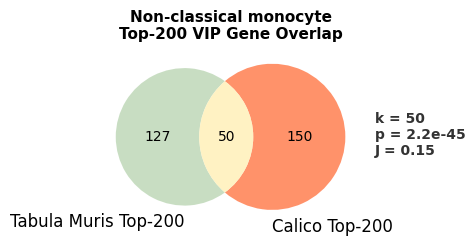

✅ Saved Venn PDF → /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/calico_pls_vip/non_classical_monocyte_Venn_Top200_20251012_042936.pdf
✅ Saved Venn PNG → /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/calico_pls_vip/non_classical_monocyte_Venn_Top200_20251012_042936.png


In [47]:
# ============================================
# Non-Classical Monocyte — Calico vs Tabula Muris (Top-200 overlap)
# With embedded statistics and dual save (PNG + PDF)
# ============================================
import scanpy as sc
import os, re, glob, datetime as dt
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from scipy.stats import hypergeom
from scipy import sparse
from matplotlib_venn import venn2

# -------- CONFIG --------
PREV_OUTPUT_DIR = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy"
H5AD_PATH_NEW   = "/mnt/data/melhajjar/tabula_muris/all_tissues/droplet_h5ad/lung_calico.h5ad"
OUT_DIR_CALICO_VIP = os.path.join(PREV_OUTPUT_DIR, "calico_pls_vip")
os.makedirs(OUT_DIR_CALICO_VIP, exist_ok=True)

CELLTYPE_KEY = "cell_type"
AGE_KEY      = "age"
TARGET_SUBTYPE = "non-classical monocyte"

# -------- helpers --------
def ensure_dense(X):
    return X.toarray() if sparse.issparse(X) else np.asarray(X)

def _center_scale(X):
    sc_ = StandardScaler(with_mean=True, with_std=True)
    return sc_.fit_transform(X), sc_

def _vip_scores(X, y, pls):
    T = pls.x_scores_; W = pls.x_weights_; Q = pls.y_loadings_.flatten()
    ssy = np.sum((T**2), axis=0) * (Q**2)
    vip = np.sqrt(X.shape[1] * np.dot((W**2), ssy) / np.sum(ssy))
    return vip

def _rank_pls_vip(X, y, var_names, n_components=2, max_iter=500):
    Xs, _ = _center_scale(X)
    ys = (y - np.mean(y)) / (np.std(y) + 1e-8)
    pls = PLSRegression(n_components=n_components, max_iter=max_iter, scale=False)
    pls.fit(Xs, ys)
    vip = _vip_scores(Xs, ys, pls)
    order = np.argsort(vip)[::-1]
    return pd.DataFrame({"gene": np.array(var_names)[order], "VIP": vip[order]})

def _find_prior_vip_csv(prev_dir: str, subtype: str):
    safe = re.sub(r"[^a-zA-Z0-9]+", "_", subtype).strip("_")
    patterns = [
        f"Lung_SUBTYPE_{safe}_VIP_genes_*.csv",
        f"Lung_SUBTYPE_{safe}_PLSreg_predictor_genes_*.csv",
        f"Lung_{safe}_PLSreg_predictor_genes_*.csv",
        f"Lung_{safe}_RF_feature_importances_*.csv"
    ]
    files = []
    for patt in patterns:
        files.extend(glob.glob(os.path.join(prev_dir, patt)))
    return sorted(files)[-1] if files else None


# -------- main --------
print(f"[*] Running Top-200 overlap for {TARGET_SUBTYPE} ...")
adata = sc.read_h5ad(H5AD_PATH_NEW)
mask = adata.obs[CELLTYPE_KEY].astype(str).str.lower() == TARGET_SUBTYPE.lower()
ad = adata[mask].copy()
ad = ad[ad.obs[AGE_KEY].astype(str).str.lower().isin(["young","old"])]

y = (ad.obs[AGE_KEY].astype(str).str.lower() == "old").astype(int).to_numpy()
X = ensure_dense(ad.X)
var_names = np.array(ad.var_names, dtype=str)

ranked_vip = _rank_pls_vip(X, y, var_names)
timestamp = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
out_csv = os.path.join(OUT_DIR_CALICO_VIP, f"non_classical_monocyte_CALICO_PLSVIP_ranked_{timestamp}.csv")
ranked_vip.to_csv(out_csv, index=False)
print(f"[*] Saved new Calico VIPs → {out_csv}")

# ---- old Tabula file ----
old_csv = _find_prior_vip_csv(PREV_OUTPUT_DIR, TARGET_SUBTYPE)
if old_csv is None:
    raise FileNotFoundError(f"No prior Tabula-Muris file found for {TARGET_SUBTYPE}")
print(f"[+] Using Tabula-Muris file: {os.path.basename(old_csv)}")

old_vip = pd.read_csv(old_csv).iloc[:,0].astype(str).str.upper().tolist()

# ---- overlap computation ----
universe = set(np.char.upper(np.array(ad.var_names, dtype=str)))
new_set  = set(ranked_vip.head(200)["gene"].str.upper())
old_set  = set(old_vip[:200]) & universe
U = len(universe); n = len(new_set); K = len(old_set); k = len(new_set & old_set)
pval = hypergeom.sf(k-1, U, K, n)
jacc = k / (K + n - k)

print(f"Overlap = {k}/{n}   p={pval:.2e}   Jaccard={jacc:.2f}")

# ---- Venn ----
fig, ax = plt.subplots(figsize=(4.6,4.6))
venn2(subsets=(K-k, n-k, k),
      set_labels=("Tabula Muris Top-200", "Calico Top-200"),
      set_colors=("#BFD8B8","#FF7F50"), alpha=0.85, ax=ax)

# Add statistics directly to figure
stats_text = f"k = {k}\np = {pval:.1e}\nJ = {jacc:.2f}"
ax.text(1.05, 0.4, stats_text, transform=ax.transAxes,
        fontsize=10, fontweight='bold', color='#333333',
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.4'))

ax.set_title(f"{TARGET_SUBTYPE.capitalize()}\nTop-200 VIP Gene Overlap", fontsize=11, weight='bold')
fig.tight_layout()

# ---- Save ----
pdf_path = os.path.join(OUT_DIR_CALICO_VIP, f"non_classical_monocyte_Venn_Top200_{timestamp}.pdf")
png_path = pdf_path.replace(".pdf", ".png")
fig.savefig(pdf_path, dpi=600, bbox_inches="tight")
fig.savefig(png_path, dpi=300, bbox_inches="tight")
plt.show()
print(f"✅ Saved Venn PDF → {pdf_path}")
print(f"✅ Saved Venn PNG → {png_path}")




In [ ]:
# ============================================
# COMPLETE VERSION - WITH ADDED AM/IM ECM ANALYSES
# ============================================

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr, f_oneway
import scanpy as sc

# --- CONFIG ---
cmap = "crest"
outdir = "/mnt/data/archive/ageing_bleo_data_2024/single_cell/enhanced_signature_analysis2"
os.makedirs(outdir, exist_ok=True)

# Colors
palette_main = {"control": "#D9B2B2", "bleo": "#A8C6A2"}  # pink + green

# Gene signatures
am_genes = ["Ccl6", "Ctsb", "Ctsd", "Ctss", "Ftl1", "Ighm", "Msrb1", "Rgcc"]
im_genes = ["Mmp12", "Fn1", "Tgfbi", "C1qa", "C1qb", "C1qc", "Spp1", "Col4a1"]
fibrosis_genes = ["Col1a1", "Col3a1", "Spp1", "Tgfb1", "Mmp12", "Chi3l1",
                  "S100a4", "Ctgf", "Fn1", "Postn", "Acta2"]
ecm_genes = ["Col1a1", "Col3a1", "Fn1", "Mmp2", "Mmp9", "Lox", "Loxl2",
             "Postn", "Ctgf", "Thbs1", "Thbs2"]

# --- 1. SUBSET DATA ---
subset = adata[adata.obs["condition"].isin(["bleo", "control"])].copy()

print("Available columns in adata.obs:")
print(subset.obs.columns.tolist())
print("\nUnique values in 'condition':")
print(subset.obs['condition'].value_counts())

# Identify sample column
sample_col = None
for col in ['sample_id', 'sample', 'mouse_id', 'replicate', 'mouse', 'animal_id', 'batch']:
    if col in subset.obs.columns:
        sample_col = col
        print(f"\n✅ Using '{col}' as sample identifier")
        print(subset.obs.groupby('condition')[col].nunique())
        break
if sample_col is None:
    print("\n⚠️ No sample column found — using 'condition' as fallback")
    sample_col = "condition"

# --- 2. COMPUTE SIGNATURES ---
sc.tl.score_genes(subset, am_genes, score_name="AM_signature")
sc.tl.score_genes(subset, im_genes, score_name="IM_signature")
sc.tl.score_genes(subset, fibrosis_genes, score_name="Fibrosis_signature")
sc.tl.score_genes(subset, ecm_genes, score_name="ECM_signature")

print(f"✅ Computed signatures for {subset.n_obs} cells")

# ============================================
# ANALYSIS 1: Per-Cell AM vs Fibrosis
# ============================================
ams = subset[subset.obs["cell_type"] == "alveolar macrophage"].copy()
fibs = subset[subset.obs["cell_type"] == "fibroblast of lung"].copy()

fib_means = fibs.obs.groupby("condition")["Fibrosis_signature"].mean()
df_am = pd.DataFrame({
    "AM_signature": pd.to_numeric(ams.obs["AM_signature"], errors="coerce"),
    "condition": ams.obs["condition"].astype(str)
})
df_am["Fibrosis_signature_mean"] = df_am["condition"].map(fib_means.to_dict())
df_am = df_am.dropna(subset=["AM_signature", "Fibrosis_signature_mean"])
print(f"✅ After cleaning: {len(df_am)} AM cells")

x = df_am["AM_signature"].values.reshape(-1, 1)
y = df_am["Fibrosis_signature_mean"].values
model = LinearRegression().fit(x, y)
r2 = model.score(x, y)
rho, pval_spear = spearmanr(df_am["AM_signature"], df_am["Fibrosis_signature_mean"])

fig, ax = plt.subplots(figsize=(3.5, 3))
sns.kdeplot(x=df_am["AM_signature"], y=df_am["Fibrosis_signature_mean"],
            fill=True, cmap=cmap, ax=ax, alpha=0.7)
sns.regplot(x=df_am["AM_signature"], y=df_am["Fibrosis_signature_mean"],
            scatter=False, line_kws=dict(color="#1f77b4", lw=2), ax=ax)
ax.set_title(f"R²={r2:.3f}, ρ={rho:.3f}, p={pval_spear:.2e}")
plt.tight_layout()
plt.savefig(f"{outdir}/1_AM_vs_Fibrosis_percell.png", dpi=600)
plt.close()
print("✅ Plot 1 saved")

# ============================================
# ANALYSIS 2: Sample-Level AM vs Fibrosis
# ============================================
sample_data = []
for sample in subset.obs[sample_col].unique():
    sub = subset[subset.obs[sample_col] == sample]
    cond = sub.obs["condition"].iloc[0]
    am = sub[sub.obs["cell_type"] == "alveolar macrophage"]
    fib = sub[sub.obs["cell_type"] == "fibroblast of lung"]
    im = sub[
        (sub.obs["cell_type"] != "alveolar macrophage") &
        (sub.obs["cell_type"].str.contains("macro|mono", case=False, na=False))
    ]
    sample_data.append({
        "sample_id": sample, "condition": cond,
        "AM_signature": am.obs["AM_signature"].mean() if am.n_obs else np.nan,
        "IM_signature": im.obs["IM_signature"].mean() if im.n_obs else np.nan,
        "Fibrosis_signature": fib.obs["Fibrosis_signature"].mean() if fib.n_obs else np.nan
    })

df_sample = pd.DataFrame(sample_data).dropna(subset=["AM_signature", "Fibrosis_signature"])
if len(df_sample) >= 3:
    x_s = df_sample["AM_signature"].values.reshape(-1, 1)
    y_s = df_sample["Fibrosis_signature"].values
    m_s = LinearRegression().fit(x_s, y_s)
    r2_s = m_s.score(x_s, y_s)
    rho_s, p_s = spearmanr(x_s.flatten(), y_s)
else:
    r2_s = rho_s = p_s = np.nan

fig, ax = plt.subplots(figsize=(4, 3.5))
sns.scatterplot(data=df_sample, x="AM_signature", y="Fibrosis_signature",
                hue="condition", palette=palette_main,
                s=150, edgecolor="black", linewidth=1.2, alpha=0.85, ax=ax)
sns.regplot(data=df_sample, x="AM_signature", y="Fibrosis_signature",
            scatter=False, line_kws=dict(color="black", lw=2, linestyle="--"), ax=ax)
ax.set_title(f"Sample-level R²={r2_s:.3f}, ρ={rho_s:.3f}, p={p_s:.3f}")
plt.tight_layout()
plt.savefig(f"{outdir}/2_Sample_level_AM_Fibroblast.png", dpi=600)
plt.close()
print("✅ Plot 2 saved")

# ============================================
# ANALYSIS 3: IM Signature vs ECM (All Cells)
# ============================================
df_all = subset.obs[["IM_signature", "ECM_signature", "condition"]].dropna()
x_ecm = df_all["IM_signature"].values.reshape(-1, 1)
y_ecm = df_all["ECM_signature"].values
m_ecm = LinearRegression().fit(x_ecm, y_ecm)
r2_ecm = m_ecm.score(x_ecm, y_ecm)
rho_ecm, p_ecm = spearmanr(df_all["IM_signature"], df_all["ECM_signature"])

fig, ax = plt.subplots(figsize=(3.5, 3))
sns.kdeplot(x=df_all["IM_signature"], y=df_all["ECM_signature"],
            fill=True, cmap="viridis", ax=ax, alpha=0.7)
sns.regplot(x=df_all["IM_signature"], y=df_all["ECM_signature"],
            scatter=False, line_kws=dict(color="red", lw=2), ax=ax)
ax.set_title(f"R²={r2_ecm:.3f}, ρ={rho_ecm:.3f}, p={p_ecm:.2e}")
plt.tight_layout()
plt.savefig(f"{outdir}/3_IM_vs_ECM_allcells.png", dpi=600)
plt.close()
print("✅ Plot 3 saved")

# ============================================
# ANALYSIS 4: Variance Decomposition
# ============================================
control_am = df_am[df_am["condition"] == "control"]["AM_signature"]
bleo_am = df_am[df_am["condition"] == "bleo"]["AM_signature"]
f_stat_am, p_anova_am = f_oneway(control_am, bleo_am)
print(f"\nAM signature by condition:\nControl: {control_am.mean():.3f} ± {control_am.std():.3f} | "
      f"Bleo: {bleo_am.mean():.3f} ± {bleo_am.std():.3f} | F={f_stat_am:.2f}, p={p_anova_am:.2e}")

# ============================================
# ANALYSIS 5A: AM Signature vs ECM (Alveolar Macrophages only)
# ============================================
print("\n--- ANALYSIS 5A: AM Signature vs ECM (within alveolar macrophages) ---")
am_subset = subset[subset.obs["cell_type"] == "alveolar macrophage"].copy()
df_am_ecm = am_subset.obs[["AM_signature", "ECM_signature", "condition"]].dropna()
x_am_ecm = df_am_ecm["AM_signature"].values.reshape(-1, 1)
y_am_ecm = df_am_ecm["ECM_signature"].values
m_am_ecm = LinearRegression().fit(x_am_ecm, y_am_ecm)
r2_am_ecm = m_am_ecm.score(x_am_ecm, y_am_ecm)
rho_am_ecm, p_am_ecm = spearmanr(df_am_ecm["AM_signature"], df_am_ecm["ECM_signature"])

fig, ax = plt.subplots(figsize=(3.5, 3))
sns.kdeplot(x=df_am_ecm["AM_signature"], y=df_am_ecm["ECM_signature"],
            fill=True, cmap="mako", ax=ax, alpha=0.7)
sns.regplot(x=df_am_ecm["AM_signature"], y=df_am_ecm["ECM_signature"],
            scatter=False, line_kws=dict(color="black", lw=2), ax=ax)
ax.set_title(f"AM cells only: R²={r2_am_ecm:.3f}, ρ={rho_am_ecm:.3f}, p={p_am_ecm:.2e}")
plt.tight_layout()
plt.savefig(f"{outdir}/5A_AM_ECM_only.png", dpi=600)
plt.close()
print("✅ Plot 5A saved")

# ============================================
# ANALYSIS 5B: IM Signature vs ECM (Lung Macrophages only)
# ============================================
print("\n--- ANALYSIS 5B: IM Signature vs ECM (within lung macrophages) ---")
im_subset = subset[subset.obs["cell_type"] == "lung macrophage"].copy()
df_im_ecm = im_subset.obs[["IM_signature", "ECM_signature", "condition"]].dropna()
x_im_ecm = df_im_ecm["IM_signature"].values.reshape(-1, 1)
y_im_ecm = df_im_ecm["ECM_signature"].values
m_im_ecm = LinearRegression().fit(x_im_ecm, y_im_ecm)
r2_im_ecm = m_im_ecm.score(x_im_ecm, y_im_ecm)
rho_im_ecm, p_im_ecm = spearmanr(df_im_ecm["IM_signature"], df_im_ecm["ECM_signature"])

fig, ax = plt.subplots(figsize=(3.5, 3))
sns.kdeplot(x=df_im_ecm["IM_signature"], y=df_im_ecm["ECM_signature"],
            fill=True, cmap="cubehelix", ax=ax, alpha=0.7)
sns.regplot(x=df_im_ecm["IM_signature"], y=df_im_ecm["ECM_signature"],
            scatter=False, line_kws=dict(color="black", lw=2), ax=ax)
ax.set_title(f"Lung macrophages: R²={r2_im_ecm:.3f}, ρ={rho_im_ecm:.3f}, p={p_im_ecm:.2e}")
plt.tight_layout()
plt.savefig(f"{outdir}/5B_IM_ECM_only.png", dpi=600)
plt.close()
print("✅ Plot 5B saved")

# ============================================
# SUMMARY
# ============================================
summary = f"""
ANALYSIS SUMMARY
================
1. AM→Fibroblast per-cell: R²={r2:.3f}, ρ={rho:.3f}, p={pval_spear:.2e}
2. AM→Fibroblast sample-level: R²={r2_s:.3f}, ρ={rho_s:.3f}, p={p_s:.2e}
3. IM→ECM (all cells): R²={r2_ecm:.3f}, ρ={rho_ecm:.3f}, p={p_ecm:.2e}
4. AM→ECM (AM only): R²={r2_am_ecm:.3f}, ρ={rho_am_ecm:.3f}, p={p_am_ecm:.2e}
5. IM→ECM (Lung Mac only): R²={r2_im_ecm:.3f}, ρ={rho_im_ecm:.3f}, p={p_im_ecm:.2e}
"""
print(summary)
with open(f"{outdir}/SUMMARY.txt", "w") as f:
    f.write(summary)

print(f"✅ All analyses complete! Results saved to {outdir}/")
print("🎉 Includes per-cell, sample-level, and macrophage-specific ECM analyses 🎉")


Available columns in adata.obs:
['condition', 'batch', 'age', 'uniqueidentifier', 'cell_type', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt']

Unique values in 'condition':
condition
bleo       6337
control    2057
Name: count, dtype: int64

✅ Using 'batch' as sample identifier
condition
bleo       4
control    4
Name: batch, dtype: int64


/tmp/ipykernel_6367/1590703914.py:44: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(subset.obs.groupby('condition')[col].nunique())


✅ Computed signatures for 8394 cells
✅ After cleaning: 433 AM cells


/tmp/ipykernel_6367/1590703914.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fib_means = fibs.obs.groupby("condition")["Fibrosis_signature"].mean()
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family '

✅ Plot 1 saved


findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

✅ Plot 2 saved


findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

✅ Plot 3 saved

AM signature by condition:
Control: 1.333 ± 0.389 | Bleo: 1.674 ± 0.480 | F=47.57, p=1.90e-11

--- ANALYSIS 5A: AM Signature vs ECM (within alveolar macrophages) ---


findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

✅ Plot 5A saved

--- ANALYSIS 5B: IM Signature vs ECM (within lung macrophages) ---


findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

✅ Plot 5B saved

ANALYSIS SUMMARY
1. AM→Fibroblast per-cell: R²=0.099, ρ=0.349, p=7.54e-14
2. AM→Fibroblast sample-level: R²=0.617, ρ=0.714, p=4.65e-02
3. IM→ECM (all cells): R²=0.112, ρ=0.400, p=0.00e+00
4. AM→ECM (AM only): R²=0.000, ρ=0.068, p=1.61e-01
5. IM→ECM (Lung Mac only): R²=0.206, ρ=0.407, p=3.04e-07

✅ All analyses complete! Results saved to /mnt/data/archive/ageing_bleo_data_2024/single_cell/enhanced_signature_analysis2/
🎉 Includes per-cell, sample-level, and macrophage-specific ECM analyses 🎉


findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

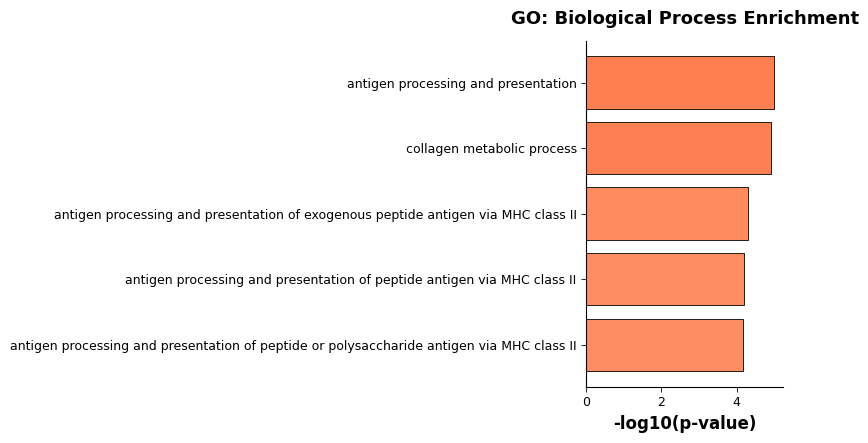

✅ Figure saved to: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/GO_BP_enrichment_bar_antigen_collagen_amageinggenes_fibrosi.pdf


In [72]:
# ============================================
# GO: Biological Process Enrichment (Antigen + Collagen)
#For Genes identified by ageing IMs and critical in fibrosis
# ============================================

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.colors import LinearSegmentedColormap

# --- CONFIG ---
save_dir = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy"
os.makedirs(save_dir, exist_ok=True)

# --- INPUT DATA ---
df = pd.DataFrame({
    "Name": [
        "antigen processing and presentation",
        "collagen metabolic process",
        "antigen processing and presentation of exogenous peptide antigen via MHC class II",
        "antigen processing and presentation of peptide antigen via MHC class II",
        "antigen processing and presentation of peptide or polysaccharide antigen via MHC class II"
    ],
    "pValue": [1.028E-5, 1.241E-5, 4.873E-5, 6.186E-5, 6.900E-5],
    "Genes_from_Input": [3, 3, 2, 2, 2]
})

# --- PREPROCESS ---
df["logP"] = -np.log10(df["pValue"])
df = df.sort_values("logP", ascending=True)

# --- COLOR MAP ---
coral_cmap = LinearSegmentedColormap.from_list("coral_gradient", ["#FFD6C2", "#FF7F50"])
colors = coral_cmap(df["logP"] / df["logP"].max())

# --- PLOT ---
fig, ax = plt.subplots(figsize=(8, 4.5))
bars = ax.barh(df["Name"], df["logP"], color=colors, edgecolor="black", linewidth=0.6)

# # Annotate gene counts
# for bar, n in zip(bars, df["Genes_from_Input"]):
#     ax.text(bar.get_width() + 0.08, bar.get_y() + bar.get_height()/2,
#             f"{n} genes", va='center', fontsize=9)

# --- STYLE ---
ax.set_xlabel("-log10(p-value)", fontsize=12, weight='bold')
ax.set_ylabel("")
ax.set_title("GO: Biological Process Enrichment", fontsize=13, weight='bold', pad=12)
ax.spines[['top','right']].set_visible(False)
ax.tick_params(axis='y', labelsize=9)
plt.tight_layout()

# --- SAVE ---
outfile = os.path.join(save_dir, "GO_BP_enrichment_bar_antigen_collagen_amageinggenes_fibrosi.pdf")
plt.savefig(outfile, dpi=600, bbox_inches="tight", format="pdf")
plt.show()

print(f"✅ Figure saved to: {outfile}")


In [ ]:
# ============================================
# LUNG MACROPHAGE (IM) SIGNATURE ANALYSIS
# ============================================
#Here we're taking IM sig genes from sorted macrophages and applying them to lung mac populations in control vs bleo and seeing if theyre related
#to more fibroblast activation with fibrosis gene sig and ecm gene sig.
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr, f_oneway
import scanpy as sc

# --- CONFIG ---
cmap = "mako"
outdir = "/mnt/data/archive/ageing_bleo_data_2024/single_cell/lung_macrophage_signature_analysis"
os.makedirs(outdir, exist_ok=True)

palette_main = {"control": "#D9B2B2", "bleo": "#A8C6A2"}  # pink + green

# Gene signatures
lm_genes = ["Fn1", "Il1b", "Fos", "Tgfbi", "Lgmn",
            "C1qc", "Cd74", "Fth1", "Vim",
            "Apoe", "C1qa", "C1qb"]

fibrosis_genes = ["Col1a1", "Col3a1", "Spp1", "Tgfb1",
                  "Mmp12", "Chi3l1", "S100a4", "Ctgf", "Fn1", "Postn", "Acta2"]

ecm_genes = ["Col1a1", "Col3a1", "Fn1", "Mmp2", "Mmp9", "Lox", "Loxl2",
             "Postn", "Ctgf", "Thbs1", "Thbs2"]

# --- 1. SUBSET DATA ---
subset = adata[adata.obs["condition"].isin(["bleo", "control"])].copy()
print(f"✅ Using {subset.n_obs} cells ({subset.obs['condition'].value_counts().to_dict()})")

# Identify sample column
sample_col = None
for col in ['sample_id', 'sample', 'mouse_id', 'replicate', 'mouse', 'animal_id', 'batch']:
    if col in subset.obs.columns:
        sample_col = col
        print(f"✅ Using '{col}' as sample identifier")
        break
if sample_col is None:
    sample_col = "condition"

# --- 2. COMPUTE SIGNATURES ---
sc.tl.score_genes(subset, lm_genes, score_name="LungMac_signature")
sc.tl.score_genes(subset, fibrosis_genes, score_name="Fibrosis_signature")
sc.tl.score_genes(subset, ecm_genes, score_name="ECM_signature")

print(f"✅ Computed signatures for {subset.n_obs} cells")

# ============================================
# ANALYSIS 1: Per-Cell (Lung Macrophage → Fibrosis)
# ============================================
lm_cells = subset[subset.obs["cell_type"] == "lung macrophage"].copy()
fibs = subset[subset.obs["cell_type"] == "fibroblast of lung"].copy()

fib_means = fibs.obs.groupby("condition")["Fibrosis_signature"].mean()
df_lm = pd.DataFrame({
    "LungMac_signature": pd.to_numeric(lm_cells.obs["LungMac_signature"], errors="coerce"),
    "condition": lm_cells.obs["condition"].astype(str)
})
df_lm["Fibrosis_signature_mean"] = df_lm["condition"].map(fib_means.to_dict())
df_lm = df_lm.dropna()

x = df_lm["LungMac_signature"].values.reshape(-1, 1)
y = df_lm["Fibrosis_signature_mean"].values
model = LinearRegression().fit(x, y)
r2 = model.score(x, y)
rho, p_spear = spearmanr(df_lm["LungMac_signature"], df_lm["Fibrosis_signature_mean"])

fig, ax = plt.subplots(figsize=(3.5, 3))
sns.kdeplot(x=df_lm["LungMac_signature"], y=df_lm["Fibrosis_signature_mean"],
            fill=True, cmap=cmap, ax=ax, alpha=0.7)
sns.regplot(x=df_lm["LungMac_signature"], y=df_lm["Fibrosis_signature_mean"],
            scatter=False, line_kws=dict(color="#1f77b4", lw=2), ax=ax)
ax.set_title(f"Per-cell R²={r2:.3f}, ρ={rho:.3f}, p={p_spear:.2e}")
plt.tight_layout()
plt.savefig(f"{outdir}/1_LungMac_vs_Fibrosis_percell.png", dpi=600)
plt.close()
print("✅ Plot 1 saved")

# ============================================
# ANALYSIS 2: Sample-Level Correlation (Lung Macrophage → Fibroblast)
# ============================================
sample_data = []
for sample in subset.obs[sample_col].unique():
    sub = subset[subset.obs[sample_col] == sample]
    cond = sub.obs["condition"].iloc[0]
    lm = sub[sub.obs["cell_type"] == "lung macrophage"]
    fib = sub[sub.obs["cell_type"] == "fibroblast of lung"]

    sample_data.append({
        "sample_id": sample,
        "condition": cond,
        "LungMac_signature": lm.obs["LungMac_signature"].mean() if lm.n_obs else np.nan,
        "Fibrosis_signature": fib.obs["Fibrosis_signature"].mean() if fib.n_obs else np.nan
    })

df_sample = pd.DataFrame(sample_data).dropna()
if len(df_sample) >= 3:
    x_s = df_sample["LungMac_signature"].values.reshape(-1, 1)
    y_s = df_sample["Fibrosis_signature"].values
    model_s = LinearRegression().fit(x_s, y_s)
    r2_s = model_s.score(x_s, y_s)
    rho_s, p_s = spearmanr(x_s.flatten(), y_s)
else:
    r2_s = rho_s = p_s = np.nan

fig, ax = plt.subplots(figsize=(4.2, 3.6))
sns.scatterplot(data=df_sample, x="LungMac_signature", y="Fibrosis_signature",
                hue="condition", palette=palette_main,
                s=150, edgecolor="black", linewidth=1.2, alpha=0.9, ax=ax)
sns.regplot(data=df_sample, x="LungMac_signature", y="Fibrosis_signature",
            scatter=False, line_kws=dict(color="black", lw=2, ls="--"), ax=ax)
ax.set_title(f"Sample-level R²={r2_s:.3f}, ρ={rho_s:.3f}, p={p_s:.3f}")
plt.tight_layout()
plt.savefig(f"{outdir}/2_Sample_level_LungMac_Fibroblast.png", dpi=600)
plt.close()
print("✅ Plot 2 saved")

# ============================================
# ANALYSIS 3: Lung Macrophage Signature vs ECM Remodeling
# ============================================
df_all = subset.obs[["LungMac_signature", "ECM_signature", "condition"]].dropna()
x_ecm = df_all["LungMac_signature"].values.reshape(-1, 1)
y_ecm = df_all["ECM_signature"].values
m_ecm = LinearRegression().fit(x_ecm, y_ecm)
r2_ecm = m_ecm.score(x_ecm, y_ecm)
rho_ecm, p_ecm = spearmanr(df_all["LungMac_signature"], df_all["ECM_signature"])

fig, ax = plt.subplots(figsize=(3.5, 3))
sns.kdeplot(x=df_all["LungMac_signature"], y=df_all["ECM_signature"],
            fill=True, cmap="viridis", ax=ax, alpha=0.7)
sns.regplot(x=df_all["LungMac_signature"], y=df_all["ECM_signature"],
            scatter=False, line_kws=dict(color="red", lw=2), ax=ax)
ax.set_title(f"R²={r2_ecm:.3f}, ρ={rho_ecm:.3f}, p={p_ecm:.2e}")
plt.tight_layout()
plt.savefig(f"{outdir}/3_LungMac_vs_ECM.png", dpi=600)
plt.close()
print("✅ Plot 3 saved")

# ============================================
# SUMMARY
# ============================================
summary = f"""
LUNG MACROPHAGE SIGNATURE ANALYSIS SUMMARY
===========================================
Genes used: {', '.join(lm_genes)}

1. Per-cell (Lung Macrophage → Fibrosis):
   R²={r2:.3f}, ρ={rho:.3f}, p={p_spear:.2e}

2. Sample-level (Lung Macrophage → Fibroblast):
   R²={r2_s:.3f}, ρ={rho_s:.3f}, p={p_s:.2e}

3. Lung Macrophage → ECM Remodeling:
   R²={r2_ecm:.3f}, ρ={rho_ecm:.3f}, p={p_ecm:.2e}
"""
print(summary)
with open(f"{outdir}/SUMMARY.txt", "w") as f:
    f.write(summary)

print(f"✅ Analysis complete! Results saved to {outdir}/")


✅ Using 8394 cells ({'bleo': 6337, 'control': 2057})
✅ Using 'batch' as sample identifier
✅ Computed signatures for 8394 cells


/tmp/ipykernel_6367/173739280.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fib_means = fibs.obs.groupby("condition")["Fibrosis_signature"].mean()
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'H

✅ Plot 1 saved


findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

✅ Plot 2 saved


findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

✅ Plot 3 saved

LUNG MACROPHAGE SIGNATURE ANALYSIS SUMMARY
Genes used: Fn1, Il1b, Fos, Tgfbi, Lgmn, C1qc, Cd74, Fth1, Vim, Apoe, C1qa, C1qb

1. Per-cell (Lung Macrophage → Fibrosis):
   R²=0.045, ρ=0.167, p=4.28e-02

2. Sample-level (Lung Macrophage → Fibroblast):
   R²=0.521, ρ=0.786, p=3.62e-02

3. Lung Macrophage → ECM Remodeling:
   R²=0.137, ρ=0.433, p=0.00e+00

✅ Analysis complete! Results saved to /mnt/data/archive/ageing_bleo_data_2024/single_cell/lung_macrophage_signature_analysis/


findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: 

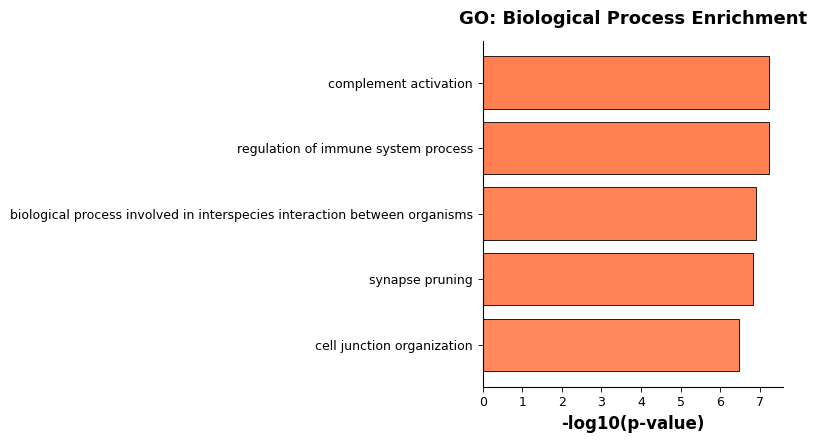

✅ Figure saved to: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/GO_BP_enrichment_bar_coral.pdf


In [71]:
# ============================================
# GO: Biological Process Enrichment Bar Plot
# ============================================

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.colors import LinearSegmentedColormap

# --- CONFIG ---
save_dir = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy"
os.makedirs(save_dir, exist_ok=True)

# --- INPUT DATA ---
df = pd.DataFrame({
    "Name": [
        "complement activation",
        "regulation of immune system process",
        "biological process involved in interspecies interaction between organisms",
        "synapse pruning",
        "cell junction organization"
    ],
    "pValue": [5.898E-8, 5.910E-8, 1.227E-7, 1.450E-7, 3.295E-7],
    "Genes_from_Input": [4, 9, 9, 3, 7]
})

# --- PREPROCESS ---
df["logP"] = -np.log10(df["pValue"])
df = df.sort_values("logP", ascending=True)

# --- COLOR MAP ---
coral_cmap = LinearSegmentedColormap.from_list("coral_gradient", ["#FFD6C2", "#FF7F50"])
colors = coral_cmap(df["logP"] / df["logP"].max())

# --- PLOT ---
fig, ax = plt.subplots(figsize=(8, 4.5))
bars = ax.barh(df["Name"], df["logP"], color=colors, edgecolor="black", linewidth=0.6)

# # Annotate with gene counts (optional but looks great)
# for bar, n in zip(bars, df["Genes_from_Input"]):
#     ax.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
#             f"{n} genes", va='center', fontsize=9)

# --- STYLE ---
ax.set_xlabel("-log10(p-value)", fontsize=12, weight='bold')
ax.set_ylabel("")
ax.set_title("GO: Biological Process Enrichment", fontsize=13, weight='bold', pad=12)
ax.spines[['top','right']].set_visible(False)
ax.tick_params(axis='y', labelsize=9)
plt.tight_layout()

# --- SAVE ---
outfile = os.path.join(save_dir, "GO_BP_enrichment_bar_coral.pdf")
plt.savefig(outfile, dpi=600, bbox_inches="tight", format="pdf")
plt.show()

print(f"✅ Figure saved to: {outfile}")


[*] Running Top-200 overlap for alveolar macrophage ...
[*] Saved new Calico VIPs → /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/calico_pls_vip/alveolar_macrophage_CALICO_PLSVIP_ranked_20251012_043204.csv
[+] Using Tabula-Muris file: Lung_SUBTYPE_alveolar_macrophage_PLSreg_predictor_genes_20251005_034125.csv
Overlap = 34/200   p=3.85e-26   Jaccard=0.10


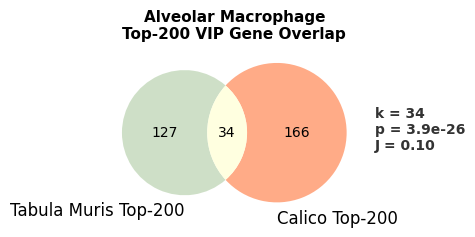

✅ Saved Venn PDF → /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/calico_pls_vip/alveolar_macrophage_Venn_Top200_20251012_043204.pdf
✅ Saved Venn PNG → /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/calico_pls_vip/alveolar_macrophage_Venn_Top200_20251012_043204.png


In [49]:
# ============================================
# Alveolar Macrophage — Calico vs Tabula Muris (Top-200 overlap)
# With embedded statistics and dual save (PNG + PDF)
# ============================================
import scanpy as sc
import os, re, glob, datetime as dt
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from scipy.stats import hypergeom
from scipy import sparse
from matplotlib_venn import venn2

# -------- CONFIG --------
PREV_OUTPUT_DIR = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy"
H5AD_PATH_NEW   = "/mnt/data/melhajjar/tabula_muris/all_tissues/droplet_h5ad/lung_calico.h5ad"
OUT_DIR_CALICO_VIP = os.path.join(PREV_OUTPUT_DIR, "calico_pls_vip")
os.makedirs(OUT_DIR_CALICO_VIP, exist_ok=True)

CELLTYPE_KEY = "cell_type"
AGE_KEY      = "age"
TARGET_SUBTYPE = "alveolar macrophage"

# -------- helpers --------
def ensure_dense(X):
    return X.toarray() if sparse.issparse(X) else np.asarray(X)

def _center_scale(X):
    sc_ = StandardScaler(with_mean=True, with_std=True)
    return sc_.fit_transform(X), sc_

def _vip_scores(X, y, pls):
    T = pls.x_scores_; W = pls.x_weights_; Q = pls.y_loadings_.flatten()
    ssy = np.sum((T**2), axis=0) * (Q**2)
    vip = np.sqrt(X.shape[1] * np.dot((W**2), ssy) / np.sum(ssy))
    return vip

def _rank_pls_vip(X, y, var_names, n_components=2, max_iter=500):
    Xs, _ = _center_scale(X)
    ys = (y - np.mean(y)) / (np.std(y) + 1e-8)
    pls = PLSRegression(n_components=n_components, max_iter=max_iter, scale=False)
    pls.fit(Xs, ys)
    vip = _vip_scores(Xs, ys, pls)
    order = np.argsort(vip)[::-1]
    return pd.DataFrame({"gene": np.array(var_names)[order], "VIP": vip[order]})

def _find_prior_vip_csv(prev_dir: str, subtype: str):
    safe = re.sub(r"[^a-zA-Z0-9]+", "_", subtype).strip("_")
    patterns = [
        f"Lung_SUBTYPE_{safe}_VIP_genes_*.csv",
        f"Lung_SUBTYPE_{safe}_PLSreg_predictor_genes_*.csv",
        f"Lung_{safe}_PLSreg_predictor_genes_*.csv",
        f"Lung_{safe}_RF_feature_importances_*.csv"
    ]
    files = []
    for patt in patterns:
        files.extend(glob.glob(os.path.join(prev_dir, patt)))
    return sorted(files)[-1] if files else None


# -------- main --------
print(f"[*] Running Top-200 overlap for {TARGET_SUBTYPE} ...")
adata = sc.read_h5ad(H5AD_PATH_NEW)
mask = adata.obs[CELLTYPE_KEY].astype(str).str.lower() == TARGET_SUBTYPE.lower()
ad = adata[mask].copy()
ad = ad[ad.obs[AGE_KEY].astype(str).str.lower().isin(["young","old"])]

y = (ad.obs[AGE_KEY].astype(str).str.lower() == "old").astype(int).to_numpy()
X = ensure_dense(ad.X)
var_names = np.array(ad.var_names, dtype=str)

ranked_vip = _rank_pls_vip(X, y, var_names)
timestamp = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
out_csv = os.path.join(OUT_DIR_CALICO_VIP, f"alveolar_macrophage_CALICO_PLSVIP_ranked_{timestamp}.csv")
ranked_vip.to_csv(out_csv, index=False)
print(f"[*] Saved new Calico VIPs → {out_csv}")

# ---- old Tabula file ----
old_csv = _find_prior_vip_csv(PREV_OUTPUT_DIR, TARGET_SUBTYPE)
if old_csv is None:
    raise FileNotFoundError(f"No prior Tabula-Muris file found for {TARGET_SUBTYPE}")
print(f"[+] Using Tabula-Muris file: {os.path.basename(old_csv)}")

old_vip = pd.read_csv(old_csv).iloc[:,0].astype(str).str.upper().tolist()

# ---- overlap computation ----
universe = set(np.char.upper(np.array(ad.var_names, dtype=str)))
new_set  = set(ranked_vip.head(200)["gene"].str.upper())
old_set  = set(old_vip[:200]) & universe
U = len(universe); n = len(new_set); K = len(old_set); k = len(new_set & old_set)
pval = hypergeom.sf(k-1, U, K, n)
jacc = k / (K + n - k)

print(f"Overlap = {k}/{n}   p={pval:.2e}   Jaccard={jacc:.2f}")

# ---- Venn ----
fig, ax = plt.subplots(figsize=(4.6,4.6))
venn2(subsets=(K-k, n-k, k),
      set_labels=("Tabula Muris Top-200", "Calico Top-200"),
      set_colors=("#C9DCC1","#FFA27A"), alpha=0.9, ax=ax)

# Add statistics directly to figure
stats_text = f"k = {k}\np = {pval:.1e}\nJ = {jacc:.2f}"
ax.text(1.05, 0.4, stats_text, transform=ax.transAxes,
        fontsize=10, fontweight='bold', color='#333333',
        bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', boxstyle='round,pad=0.4'))

ax.set_title(f"Alveolar Macrophage\nTop-200 VIP Gene Overlap", fontsize=11, weight='bold')
fig.tight_layout()

# ---- Save ----
pdf_path = os.path.join(OUT_DIR_CALICO_VIP, f"alveolar_macrophage_Venn_Top200_{timestamp}.pdf")
png_path = pdf_path.replace(".pdf", ".png")
fig.savefig(pdf_path, dpi=600, bbox_inches="tight")
fig.savefig(png_path, dpi=300, bbox_inches="tight")
plt.show()
print(f"✅ Saved Venn PDF → {pdf_path}")
print(f"✅ Saved Venn PNG → {png_path}")



In [ ]:
### Heatmap for Cell Type Composition Across Mac/Monocyte Subtype ###
#Downsampling, 2 methods (random, celltype aware), boxplots, and heatmap#
# ============================================================
# Calico (lung_calico.h5ad)
# sample_id = age + "_" + animal
# Downsampling: global + subtype-stratified
# Outputs: narrow heatmap, skinny per-subtype boxplots, stats CSV
# ============================================================

import os
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm
from scipy.stats import mannwhitneyu

# Optional FDR correction
try:
    from statsmodels.stats.multitest import multipletests
    _HAS_SMT = True
except Exception:
    _HAS_SMT = False

# -----------------------------
# Config (paths & columns)
# -----------------------------
H5AD_PATH_CALICO = "/mnt/data/melhajjar/tabula_muris/all_tissues/droplet_h5ad/lung_calico.h5ad"

# Fallback if PREV_OUTPUT_DIR isn't defined elsewhere
PREV_OUTPUT_DIR = globals().get(
    "PREV_OUTPUT_DIR",
    "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy"
)

OUT_DIR_DS = os.path.join(PREV_OUTPUT_DIR, "repro_lung_calico_young_old", "downsample_compare")
os.makedirs(OUT_DIR_DS, exist_ok=True)

CELLTYPE_KEY = "cell_type"
AGE_KEY      = "age"      # expects "young"/"old"
ANIMAL_KEY   = "animal"   # replicate identifier to build sample_id
RNG_SEED     = 42

# Focus: macrophage/monocyte subtypes (case-insensitive)
FOCUS_SUBTYPES = [
    "alveolar macrophage",
    "classical monocyte",
    "non-classical monocyte",
]

AGE_COLORS = {"young": "#8ecae6", "old": "#b19cd9"}

# Plot sizing
HEATMAP_WIDTH_IN  = 4.6   # narrower width
HEATMAP_ROW_SCALE = 0.40  # height per row
PANEL_WIDTH_IN    = 3.6
PANEL_HEIGHT_IN   = 2.8

sns.set_theme(style="white")
sns.set_context("paper", font_scale=0.9)

# -----------------------------
# Helpers
# -----------------------------
def _safe_nanmax(list_of_arrays, fallback=1.0):
    vals = [np.asarray(a, float) for a in list_of_arrays if len(a)]
    if not vals: return float(fallback)
    return float(np.nanmax(np.concatenate(vals)))

def p_to_stars(p):
    if not np.isfinite(p): return "n/a"
    return "ns" if p >= 0.05 else ("*" if p >= 0.01 else ("**" if p >= 0.001 else ("***" if p >= 1e-4 else "****")))

def cliffs_delta(x, y):
    x = np.asarray(x); y = np.asarray(y)
    if len(x) == 0 or len(y) == 0: return np.nan
    gt = (x[:, None] > y[None, :]).sum()
    lt = (x[:, None] < y[None, :]).sum()
    nxy = len(x) * len(y)
    return (gt - lt) / nxy if nxy else np.nan

def downsample_global(adata, age_key=AGE_KEY, seed=RNG_SEED):
    """Uniform random sampling within each age to the min(age counts)."""
    rng = np.random.default_rng(seed)
    counts = adata.obs[age_key].value_counts()
    target = int(counts.min())
    keep = []
    for a in counts.index:
        idx = np.where(adata.obs[age_key].values == a)[0]
        k = min(target, len(idx))
        if k > 0:
            keep.append(rng.choice(idx, size=k, replace=False))
    keep = np.sort(np.concatenate(keep)) if len(keep) else np.array([], dtype=int)
    print(f"[Downsample/global] target={target} (from {counts.to_dict()})")
    return adata[keep].copy()

def downsample_by_subtype(adata, age_key=AGE_KEY, subtype_key=CELLTYPE_KEY, seed=RNG_SEED):
    """Stratified sampling: equalize per-age totals, preserve subtype mix within each age."""
    rng = np.random.default_rng(seed)
    counts_age = adata.obs[age_key].value_counts()
    target = int(counts_age.min())
    keep = []
    for a, df_a in adata.obs.groupby(age_key):
        sub_counts = df_a[subtype_key].value_counts()
        if sub_counts.sum() == 0: continue
        quotas = (sub_counts / sub_counts.sum()) * target
        q_floor = np.floor(quotas).astype(int)
        leftover = target - int(q_floor.sum())
        if leftover > 0:
            add = (quotas - q_floor).sort_values(ascending=False).index[:leftover]
            q_floor.loc[add] += 1
        for s, q in q_floor.items():
            idx_as = df_a.index[df_a[subtype_key] == s].to_numpy()
            q = min(int(q), len(idx_as))
            if q > 0:
                keep.append(rng.choice(idx_as, size=q, replace=False))
    keep = np.sort(np.concatenate(keep)) if len(keep) else np.array([], dtype=int)
    print(f"[Downsample/subtype] target={target} (from {counts_age.to_dict()})")
    return adata[keep].copy()

def run_pipeline_for_mode(adata_input, mode_label, out_dir):
    # ---- downsample ----
    if mode_label == "global":
        ad_ds = downsample_global(adata_input, age_key=AGE_KEY, seed=RNG_SEED)
    elif mode_label == "subtype":
        ad_ds = downsample_by_subtype(adata_input, age_key=AGE_KEY, subtype_key=CELLTYPE_KEY, seed=RNG_SEED)
    else:
        raise ValueError("mode_label must be 'global' or 'subtype'")
    print(f"[{mode_label}] kept cells: {ad_ds.n_obs:,}")

    # ---- counts long df ----
    long_df = (
        ad_ds.obs.groupby([AGE_KEY, "sample_id", CELLTYPE_KEY])
                 .size().reset_index(name="n_cells")
    )

    # ---- Heatmap (narrow) ----
    mat = long_df.pivot_table(
        index="sample_id", columns=CELLTYPE_KEY, values="n_cells", aggfunc="sum", fill_value=0
    )
    age_map = long_df.drop_duplicates(["sample_id", AGE_KEY]).set_index("sample_id")[AGE_KEY]
    order = age_map.map({"young": 0, "old": 1}).sort_values(kind="mergesort").index
    mat = mat.loc[order]
    row_colors = age_map.reindex(mat.index).map(AGE_COLORS).fillna("#FFFFFF")

    vmax = np.quantile(mat.values, 0.95) if mat.size else 1.0
    norm = PowerNorm(gamma=0.5)
    heatmap_height = max(6, HEATMAP_ROW_SCALE * mat.shape[0])

    sns.set_context("paper", font_scale=0.8)
    g = sns.clustermap(
        mat, cmap="BrBG", norm=norm, vmin=0, vmax=vmax,
        row_cluster=False, col_cluster=False,
        figsize=(HEATMAP_WIDTH_IN, heatmap_height),
        yticklabels=True, xticklabels=True,
        cbar_kws={}, row_colors=row_colors
    )
    g.ax_row_dendrogram.set_visible(False)
    g.ax_col_dendrogram.set_visible(False)
    for sp in ["top","right","left","bottom"]:
        g.ax_heatmap.spines[sp].set_visible(False)
    for lab in g.ax_heatmap.get_xticklabels():
        lab.set_rotation(90); lab.set_horizontalalignment("center")
    if g.ax_heatmap.collections:
        cb = g.ax_heatmap.collections[0].colorbar
        if cb is not None: cb.set_label("")

    g.ax_heatmap.set_title(f"Calico: samples × subtypes (downsampled {mode_label}; young → old)",
                           pad=10, fontsize=10)
    plt.tight_layout()
    heatmap_path = os.path.join(out_dir, f"calico_macmono_heatmap_{mode_label}.pdf")
    g.savefig(heatmap_path, bbox_inches="tight", dpi=300)
    plt.show()
    print(f"[✓ {mode_label}] Heatmap → {heatmap_path}")

    # ---- Boxplots + stats per subtype ----
    per_sample_sub = (
        long_df.groupby([AGE_KEY, "sample_id", CELLTYPE_KEY])["n_cells"]
               .sum().reset_index()
    )
    subtypes = sorted(per_sample_sub[CELLTYPE_KEY].unique().tolist())

    stats_rows = []
    for subtype in subtypes:
        df_s = per_sample_sub[per_sample_sub[CELLTYPE_KEY] == subtype]
        yv = df_s.loc[df_s[AGE_KEY] == "young", "n_cells"].to_numpy()
        ov = df_s.loc[df_s[AGE_KEY] == "old",   "n_cells"].to_numpy()
        if len(yv) and len(ov):
            u_stat, p_val = mannwhitneyu(yv, ov, alternative="two-sided")
        else:
            u_stat, p_val = np.nan, np.nan
        delta = cliffs_delta(ov, yv)  # effect: old vs young
        stats_rows.append({
            "mode": mode_label,
            "subtype": subtype,
            "n_young_samples": int((df_s[AGE_KEY]=="young").sum()),
            "n_old_samples":   int((df_s[AGE_KEY]=="old").sum()),
            "median_young": float(np.median(yv)) if len(yv) else np.nan,
            "median_old":   float(np.median(ov)) if len(ov) else np.nan,
            "MannWhitneyU": float(u_stat) if np.isfinite(u_stat) else np.nan,
            "p_value_two_sided": float(p_val) if np.isfinite(p_val) else np.nan,
            "Cliffs_delta_old_vs_young": float(delta) if np.isfinite(delta) else np.nan,
        })
    stats_df = pd.DataFrame(stats_rows)

    # FDR (BH) if available
    if _HAS_SMT and stats_df["p_value_two_sided"].notna().any():
        mask = stats_df["p_value_two_sided"].notna()
        rej, qvals, _, _ = multipletests(stats_df.loc[mask, "p_value_two_sided"].values, method="fdr_bh")
        stats_df.loc[mask, "q_value_fdr_bh"] = qvals
        stats_df.loc[mask, "reject_fdr_0.05"] = rej

    stats_path = os.path.join(out_dir, f"calico_macmono_boxplot_stats_{mode_label}.csv")
    stats_df.to_csv(stats_path, index=False)
    print(f"[✓ {mode_label}] Stats CSV → {stats_path}")

    # Skinny boxplots (robust if a group is empty)
    n = len(subtypes)
    fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(PANEL_WIDTH_IN, PANEL_HEIGHT_IN * n), squeeze=False)
    rng = np.random.default_rng(RNG_SEED)

    for i, subtype in enumerate(subtypes):
        ax = axes[i, 0]
        df_s = per_sample_sub[per_sample_sub[CELLTYPE_KEY] == subtype].copy()
        arr_y = df_s.loc[df_s[AGE_KEY] == "young", "n_cells"].to_numpy()
        arr_o = df_s.loc[df_s[AGE_KEY] == "old",   "n_cells"].to_numpy()
        data  = [arr_y, arr_o]

        bp = ax.boxplot(data, widths=0.55, patch_artist=True,
                        medianprops=dict(color="black", linewidth=1))
        for j, patch in enumerate(bp["boxes"]):
            patch.set_facecolor(AGE_COLORS["young" if j == 0 else "old"])
            patch.set_edgecolor("#333333"); patch.set_alpha(0.95)

        if len(arr_y):
            x = np.full(len(arr_y), 1.0) + (rng.random(len(arr_y)) - 0.5)*0.08
            ax.scatter(x, arr_y, s=20, alpha=0.85, edgecolors="white", linewidths=0.6, c=AGE_COLORS["young"])
        if len(arr_o):
            x = np.full(len(arr_o), 2.0) + (rng.random(len(arr_o)) - 0.5)*0.08
            ax.scatter(x, arr_o, s=20, alpha=0.85, edgecolors="white", linewidths=0.6, c=AGE_COLORS["old"])

        ax.set_xticks([1, 2]); ax.set_xticklabels(["young", "old"])
        ax.set_ylabel("# cells / sample")
        ax.set_title(subtype, loc="left", fontsize=10)
        ax.grid(axis="y", alpha=0.25)
        for sp in ["top", "right"]:
            ax.spines[sp].set_visible(False)

        data_max = _safe_nanmax(data, fallback=1.0)
        ymax = max(ax.get_ylim()[1], data_max * 1.15)
        ax.set_ylim(ax.get_ylim()[0], ymax)

        has_both = (len(arr_y) > 0) and (len(arr_o) > 0)
        if has_both:
            ax.plot([1, 2], [ymax*0.98, ymax*0.98], color="#333333", linewidth=1)

        row = stats_df.loc[stats_df["subtype"] == subtype].iloc[0]
        p  = row["p_value_two_sided"]; d = row["Cliffs_delta_old_vs_young"]
        stars = p_to_stars(p)
        txt = f"{stars}  p={p:.3g}\nΔ={d:.2f}" if np.isfinite(p) else "n/a"
        ax.text(1.5, ymax*1.01, txt, ha="center", va="bottom", fontsize=8)

    plt.tight_layout(h_pad=1.0)
    box_pdf = os.path.join(out_dir, f"calico_macmono_boxplots_{mode_label}.pdf")
    box_png = os.path.join(out_dir, f"calico_macmono_boxplots_{mode_label}.png")
    fig.savefig(box_pdf, bbox_inches="tight", dpi=300)
    fig.savefig(box_png, bbox_inches="tight", dpi=300)
    plt.show()
    print(f"[✓ {mode_label}] Boxplots → {box_pdf} / {box_png}")

# -----------------------------
# Load Calico + build sample_id (age + animal)
# -----------------------------
print("[*] Loading Calico:", H5AD_PATH_CALICO)
ad_cal = sc.read_h5ad(H5AD_PATH_CALICO)
for col in [CELLTYPE_KEY, AGE_KEY, ANIMAL_KEY]:
    if col not in ad_cal.obs.columns:
        raise KeyError(f"Missing column in adata.obs: '{col}'")

# normalize age labels and filter
ad_cal.obs[AGE_KEY] = ad_cal.obs[AGE_KEY].astype(str).str.strip().str.lower()
ad_cal = ad_cal[ad_cal.obs[AGE_KEY].isin(["young","old"])].copy()

# drop NA in animal to avoid malformed IDs
ad_cal = ad_cal[~ad_cal.obs[ANIMAL_KEY].isna()].copy()

# sample_id = age + "_" + animal
ad_cal.obs["sample_id"] = (
    ad_cal.obs[AGE_KEY].astype(str).str.strip().str.lower() + "_" +
    ad_cal.obs[ANIMAL_KEY].astype(str).str.strip()
)

# keep only target mac/mono subtypes
ct_lower = ad_cal.obs[CELLTYPE_KEY].astype(str).str.strip().str.lower()
keep_mask = ct_lower.isin([s.lower() for s in FOCUS_SUBTYPES])
ad_cal = ad_cal[keep_mask].copy()
ad_cal.obs[CELLTYPE_KEY] = ad_cal.obs[CELLTYPE_KEY].astype(str)

print(f"[Loaded] Calico mac/mono cells: {ad_cal.n_obs:,} | samples: {ad_cal.obs['sample_id'].nunique()}")

# -----------------------------
# Run BOTH modes
# -----------------------------
for MODE in ["global", "subtype"]:
    run_pipeline_for_mode(ad_cal, MODE, OUT_DIR_DS)


In [26]:
### Calico for All Cells ###

# ============================================
# CALICO Lung (ALL CELLS) — Apply TM Global VIP Genes
# Uses: /.../Lung_GLOBAL_allcells_VIP_genes_latest.csv
# Outputs one PDF for ALL cells + CSV of the exact VIP genes used.
# ============================================

import os, warnings, datetime as dt
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score, matthews_corrcoef,
    roc_curve, auc, average_precision_score, precision_recall_curve,
    confusion_matrix
)

# -------------------------
# Paths & config (edit if needed)
# -------------------------
CALICO_H5AD_PATH = "/mnt/data/melhajjar/tabula_muris/all_tissues/droplet_h5ad/lung_calico.h5ad"

TM_VIP_CSV = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/Lung_GLOBAL_allcells_VIP_genes_latest.csv"

OUTPUT_DIR = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/repro_lung_calico_young_old_ALLCELLS_TMglobalVIP"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Columns in CALICO
AGE_KEY      = "age"       # "young"/"old"
CELLTYPE_KEY = "cell_type" # not used for filtering here (ALL cells)

# CV + models
CV_FOLDS       = 5
RANDOM_STATE   = 42
RF_ESTIMATORS  = 400
RF_MAX_DEPTH   = 20
RF_MIN_LEAF    = 2
RF_N_JOBS      = -1

# Visualization config
AGE_COLORS    = {"young": "#8ecae6", "old": "#b19cd9"}  # light blue / soft purple
AGE_TO_MONTHS = {"young": 18.0, "old": 30.0}
HEAT_TOP_K    = 20
HM_CLIP       = 2.5
HM_CMAP       = "coolwarm"
HM_FONT_SIZE  = 7

# Bar color for RF top-20
RF_BAR_COLOR  = "#A6CEE3"   # pastel blue

mpl.rcParams.update({
    "figure.dpi": 150,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "font.family": "DejaVu Sans",
})

# -------------------------
# Helpers
# -------------------------
def _nature_axes(ax):
    for s in ["top", "right"]:
        ax.spines[s].set_visible(False)
    ax.spines["left"].set_linewidth(1.0)
    ax.spines["bottom"].set_linewidth(1.0)
    ax.tick_params(width=1.0, length=4)

def ensure_dense(X):
    try:
        return X.toarray()
    except Exception:
        return np.asarray(X)

def pastel_palette_from_classes(classes):
    return {c: AGE_COLORS.get(str(c).lower(), "#B2E2E2") for c in classes}

def class_counts_bar(ax, y, title, pal):
    classes = list(pd.unique(y.astype(str)))
    classes_sorted = ["young", "old"] if set(map(str.lower, classes)) == {"young","old"} else sorted(classes)
    counts = pd.value_counts(pd.Categorical(y, categories=classes_sorted), sort=False).values
    colors = [pal[c] for c in classes_sorted]
    ax.bar(range(len(classes_sorted)), counts, color=colors, edgecolor="#333333", linewidth=0.6)
    ax.set_xticks(range(len(classes_sorted))); ax.set_xticklabels(classes_sorted)
    _nature_axes(ax)
    ax.set_title(title); ax.set_ylabel("# cells")
    ymax = counts.max() if len(counts) else 0
    for i, v in enumerate(counts):
        ax.text(i, v + max(1, ymax)*0.02, f"{int(v):,}", ha='center', va='bottom', fontsize=9)
    return classes_sorted

def confusion_heatmap(ax, y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    cmn = cm.astype(float) / cm.sum(axis=1, keepdims=True)
    im = ax.imshow(cmn, aspect="auto", cmap="Blues", vmin=0, vmax=1)
    _nature_axes(ax)
    ax.set_title(title); ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    ax.set_xticks(range(len(classes))); ax.set_yticks(range(len(classes)))
    ax.set_xticklabels(classes); ax.set_yticklabels(classes)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm[i,j]:,}\n({cmn[i,j]*100:.1f}%)",
                    ha='center', va='center', fontsize=8)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Row-normalized")

def roc_pr_plots(ax_roc, ax_pr, y_true, proba_mat, classes_sorted, pal, title_prefix):
    classes_sorted = list(classes_sorted)
    if proba_mat.ndim != 2 or proba_mat.shape[1] != len(classes_sorted):
        ax_roc.axis("off"); ax_pr.axis("off")
        ax_roc.set_title(f"{title_prefix} ROC (invalid proba shape)")
        ax_pr.set_title(f"{title_prefix} PR (invalid proba shape)")
        return
    # ROC
    for j, cls in enumerate(classes_sorted):
        y_bin = (y_true == cls).astype(int)
        if y_bin.max() == y_bin.min():
            continue
        fpr, tpr, _ = roc_curve(y_bin, proba_mat[:, j])
        roc_auc = auc(fpr, tpr)
        ax_roc.plot(fpr, tpr, lw=1.8, color=pal[cls], label=f"{cls} (AUC={roc_auc:.3f})")
    ax_roc.plot([0,1],[0,1], linestyle="--", linewidth=1, color="#666")
    _nature_axes(ax_roc)
    ax_roc.set_title(f"{title_prefix} ROC"); ax_roc.set_xlabel("FPR"); ax_roc.set_ylabel("TPR")
    ax_roc.legend(frameon=False, loc="lower right")
    # PR
    for j, cls in enumerate(classes_sorted):
        y_bin = (y_true == cls).astype(int)
        if y_bin.max() == y_bin.min():
            continue
        prec, rec, _ = precision_recall_curve(y_bin, proba_mat[:, j])
        ap = average_precision_score(y_bin, proba_mat[:, j])
        ax_pr.plot(rec, prec, lw=1.8, color=pal[cls], label=f"{cls} (AP={ap:.3f})")
    _nature_axes(ax_pr)
    ax_pr.set_title(f"{title_prefix} PR"); ax_pr.set_xlabel("Recall"); ax_pr.set_ylabel("Precision")
    ax_pr.set_xlim(0,1); ax_pr.set_ylim(0,1.05)
    ax_pr.legend(frameon=False, loc="lower left")

def lr_pred_age_scatter(ax, y_true, proba_mat, classes_sorted, pal, title,
                        age_map=AGE_TO_MONTHS, jitter=0.08, alpha=0.45, ms=10, mean_ms=8):
    """ Predicted AGE (months) vs TRUE AGE (months) using LR probabilities. """
    classes_sorted = list(classes_sorted)
    old_cls   = "old" if "old" in classes_sorted else classes_sorted[-1]
    young_cls = "young" if "young" in classes_sorted else classes_sorted[0]
    idx_old   = classes_sorted.index(old_cls)

    # predicted age from P(old)
    p_old = proba_mat[:, idx_old]
    y_pred_age = age_map[young_cls] + (age_map[old_cls] - age_map[young_cls]) * p_old

    # true ages as 18/30
    x_true = np.array([age_map[v] for v in y_true])

    rng = np.random.default_rng(0)
    xj = x_true + rng.uniform(-jitter, jitter, size=len(x_true))
    colors = [pal[v] for v in y_true]
    ax.scatter(xj, y_pred_age, s=ms, alpha=alpha, c=colors, edgecolors="none")

    # per-class mean ± SD (filled)
    for cls in classes_sorted:
        m = (y_true == cls)
        if not m.any(): continue
        mu = float(y_pred_age[m].mean())
        sd = float(y_pred_age[m].std(ddof=1)) if m.sum() > 1 else 0.0
        x0 = age_map[cls]
        ax.errorbar([x0], [mu], yerr=[[sd],[sd]], fmt='o', ms=mean_ms,
                    color=pal[cls], mec="black", mfc=pal[cls], mew=0.8,
                    ecolor=pal[cls], elinewidth=1.1, capsize=3, capthick=1.1, zorder=5)
        ax.text(x0 + 0.25, mu, f"μ={mu:.1f} m", va="center", ha="left", fontsize=9)

    # identity line
    xmin, xmax = min(age_map.values()), max(age_map.values())
    ax.plot([xmin, xmax], [xmin, xmax], ls="--", lw=1.2, color="#666", label="y = x")

    _nature_axes(ax)
    ax.set_xlim(xmin-1, xmax+1)
    y_min = max(0, min(17, y_pred_age.min()-1.5))
    y_max = max(y_pred_age.max()+1.5, xmax+1)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel("True Age (months)")
    ax.set_ylabel("Predicted Age (months)")
    ax.set_title(title)

    # legend
    handles = [
        plt.Line2D([0],[0], marker='o', linestyle='None', markersize=6,
                   markerfacecolor=pal[young_cls], markeredgewidth=0, label="18 m"),
        plt.Line2D([0],[0], marker='o', linestyle='None', markersize=6,
                   markerfacecolor=pal[old_cls], markeredgewidth=0, label="30 m"),
        plt.Line2D([0,1],[0,1], color="#666", lw=1.2, linestyle="--", label="y = x"),
    ]
    ax.legend(handles=handles, frameon=False, loc="upper left")

def vip_heatmap_top(fig, Z, gene_labels, age_ordered, classes_sorted, title, cmap=HM_CMAP):
    from matplotlib import gridspec
    n_genes, n_cells = Z.shape
    gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[1.0, 0.12], hspace=0.08)
    ax = fig.add_subplot(gs[0, 0])
    im = ax.imshow(Z, aspect="auto", cmap=cmap, vmin=-HM_CLIP, vmax=HM_CLIP, interpolation="nearest")
    ax.set_title(title, loc="left", pad=6)
    ax.set_xticks([])
    ax.set_yticks(np.arange(n_genes))
    ax.set_yticklabels(gene_labels, fontsize=HM_FONT_SIZE)
    for s in ["top", "right"]:
        ax.spines[s].set_visible(False)
    ax.spines["left"].set_linewidth(1.0)
    ax.spines["bottom"].set_linewidth(1.0)
    # right colorbar
    cax = fig.add_axes([ax.get_position().x1 + 0.010, ax.get_position().y0, 0.014, ax.get_position().height])
    cb = fig.colorbar(im, cax=cax)
    cb.set_label("z-score per gene", rotation=90, labelpad=8)
    cb.ax.tick_params(labelsize=8)
    # age strip
    axb = fig.add_subplot(gs[1, 0])
    pal = {c: AGE_COLORS[str(c).lower()] for c in classes_sorted}
    strip_colors = np.array([pal[c] for c in age_ordered], dtype=object)
    strip_rgb = np.array([mpl.colors.to_rgb(c) for c in strip_colors]).reshape(1, len(age_ordered), 3)
    axb.imshow(strip_rgb, aspect="auto")
    axb.set_yticks([0]); axb.set_yticklabels(["Age"], fontsize=8)
    axb.set_xticks([])
    for s in ["top", "right"]:
        axb.spines[s].set_visible(False)
    axb.spines["left"].set_linewidth(1.0)
    axb.spines["bottom"].set_linewidth(1.0)
    handles = [plt.Line2D([0],[0], marker='s', linestyle='',
                          markersize=8, markerfacecolor=pal[c], markeredgecolor="none")
               for c in classes_sorted]
    fig.legend(handles, [str(c) for c in classes_sorted],
               title="Age class", loc="upper right", frameon=False, fontsize=8, title_fontsize=8)

# -------------------------
# Load CALICO + TM VIP list
# -------------------------
print("[*] Loading CALICO (ALL CELLS):", CALICO_H5AD_PATH)
ad = sc.read_h5ad(CALICO_H5AD_PATH)
for col in [AGE_KEY]:
    if col not in ad.obs.columns:
        raise KeyError(f"CALICO missing obs column '{col}'")

# Keep only young/old
ad.obs[AGE_KEY] = ad.obs[AGE_KEY].astype(str).str.strip().str.lower()
ad = ad[ad.obs[AGE_KEY].isin(["young", "old"])].copy()
y = ad.obs[AGE_KEY].astype(str).to_numpy()
classes = list(pd.unique(y))
if set(classes) != {"young", "old"}:
    raise RuntimeError(f"Need both 'young' and 'old' in CALICO; found {classes}")
classes_sorted = ["young", "old"]
pal_age = pastel_palette_from_classes(classes_sorted)

print(f"CALICO ALL CELLS: n={ad.n_obs:,} cells, {ad.n_vars:,} genes; classes={classes_sorted}")

# Load TM global VIP list (preserve CSV rank order)
vip_df = pd.read_csv(TM_VIP_CSV)
if "gene" in vip_df.columns:
    tm_vip = vip_df["gene"].astype(str).tolist()
else:
    tm_vip = vip_df.iloc[:, 0].astype(str).tolist()
tm_vip = list(dict.fromkeys(tm_vip))  # dedupe, keep order
print(f"[*] Loaded TM VIP (global) genes: {len(tm_vip)}  ({os.path.basename(TM_VIP_CSV)})")

# Intersect with CALICO feature space (preserve TM order)
var_genes = set(map(str, ad.var_names))
vip_present = [g for g in tm_vip if g in var_genes]
vip_missing = [g for g in tm_vip if g not in var_genes]
if len(vip_present) < 5:
    raise RuntimeError(f"Too few TM VIP genes present in CALICO space ({len(vip_present)}).")

vip_idx = [np.where(ad.var_names == g)[0][0] for g in vip_present]
X_vip = ensure_dense(ad.X)[:, vip_idx]
feature_names = np.array(vip_present)  # TM order

print(f"TM VIP present in CALICO: {len(vip_present)} / {len(tm_vip)} (missing: {len(vip_missing)})")

# -------------------------
# CV Logistic Regression (scaled)
# -------------------------
skf = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
y_true_lr, y_pred_lr = [], []
proba_lr_list = []
for tr, te in skf.split(X_vip, y):
    scaler = StandardScaler(with_mean=True, with_std=True)
    Xtr = scaler.fit_transform(X_vip[tr])
    Xte = scaler.transform(X_vip[te])
    lr = LogisticRegression(penalty="l2", solver="liblinear", random_state=RANDOM_STATE, max_iter=200)
    lr.fit(Xtr, y[tr])
    y_pred_lr.append(lr.predict(Xte))
    proba = lr.predict_proba(Xte)
    aligned = np.zeros((len(te), len(classes_sorted)))
    cls_lr = list(lr.classes_)
    for j, c in enumerate(classes_sorted):
        aligned[:, j] = proba[:, cls_lr.index(c)]
    proba_lr_list.append(aligned)
    y_true_lr.append(y[te])

y_true_lr = np.concatenate(y_true_lr)
y_pred_lr = np.concatenate(y_pred_lr)
proba_lr = np.concatenate(proba_lr_list, axis=0)

acc_lr  = accuracy_score(y_true_lr, y_pred_lr)
bacc_lr = balanced_accuracy_score(y_true_lr, y_pred_lr)
f1_lr   = f1_score(y_true_lr, y_pred_lr, average="macro")
mcc_lr  = matthews_corrcoef(y_true_lr, y_pred_lr)

# -------------------------
# CV Random Forest (no scaling)
# -------------------------
y_true_rf, y_pred_rf = [], []
proba_rf_list = []
for tr, te in skf.split(X_vip, y):
    rf = RandomForestClassifier(
        n_estimators=RF_ESTIMATORS, max_depth=RF_MAX_DEPTH,
        min_samples_leaf=RF_MIN_LEAF, n_jobs=RF_N_JOBS, random_state=RANDOM_STATE
    )
    rf.fit(X_vip[tr], y[tr])
    y_pred_rf.append(rf.predict(X_vip[te]))
    proba = rf.predict_proba(X_vip[te])
    aligned = np.zeros((len(te), len(classes_sorted)))
    cls_rf = list(rf.classes_)
    for j, c in enumerate(classes_sorted):
        aligned[:, j] = proba[:, cls_rf.index(c)]
    proba_rf_list.append(aligned)
    y_true_rf.append(y[te])

y_true_rf = np.concatenate(y_true_rf)
y_pred_rf = np.concatenate(y_pred_rf)
proba_rf  = np.concatenate(proba_rf_list, axis=0)

acc_rf  = accuracy_score(y_true_rf, y_pred_rf)
bacc_rf = balanced_accuracy_score(y_true_rf, y_pred_rf)
f1_rf   = f1_score(y_true_rf, y_pred_rf, average="macro")
mcc_rf  = matthews_corrcoef(y_true_rf, y_pred_rf)

# One RF on ALL data for importances in TM VIP order
rf_all = RandomForestClassifier(
    n_estimators=RF_ESTIMATORS, max_depth=RF_MAX_DEPTH,
    min_samples_leaf=RF_MIN_LEAF, n_jobs=RF_N_JOBS, random_state=RANDOM_STATE
)
rf_all.fit(X_vip, y)
imp_vec = rf_all.feature_importances_
gene_to_imp = {gene: float(imp_vec[i]) for i, gene in enumerate(feature_names)}

# -------------------------
# Build ALL-CELLS PDF
# -------------------------
ts = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
pdf_path = os.path.join(OUTPUT_DIR, f"CALICO_ALLCELLS_TMglobalVIP_{ts}.pdf")
with PdfPages(pdf_path) as pdf:
    # Page 1: class counts
    fig, ax = plt.subplots(figsize=(6.0, 4.2))
    classes_sorted = class_counts_bar(ax, pd.Series(y), "CALICO (ALL CELLS) — young/old counts", pal_age)
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 2: metrics table (LR & RF)
    fig, ax = plt.subplots(figsize=(7.2, 3.9))
    ax.axis("off"); ax.set_title("ALL CELLS — CV metrics (TM VIP features only)", loc="left", pad=6)
    rows = [
        ("Model", "Accuracy", "Balanced Acc", "Macro F1", "MCC", "# TM VIP features", "TM VIP missing"),
        ("Logistic Regression", f"{acc_lr:.3f}", f"{bacc_lr:.3f}", f"{f1_lr:.3f}", f"{mcc_lr:.3f}", f"{len(feature_names)}", f"{len(vip_missing)}"),
        ("Random Forest",      f"{acc_rf:.3f}", f"{bacc_rf:.3f}", f"{f1_rf:.3f}", f"{mcc_rf:.3f}", f"{len(feature_names)}", f"{len(vip_missing)}"),
    ]
    the_table = ax.table(cellText=rows[1:], colLabels=rows[0], loc="center")
    the_table.auto_set_font_size(False); the_table.set_fontsize(9); the_table.scale(1, 1.2)
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 3: ROC / PR (LR)
    fig, axes = plt.subplots(1, 2, figsize=(10.0, 4.2))
    roc_pr_plots(axes[0], axes[1], y_true_lr, proba_lr, classes_sorted, pal_age, "LR (TM VIP)")
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 4: LR predicted AGE vs TRUE AGE (months)
    fig, ax = plt.subplots(figsize=(6.6, 4.6))
    lr_pred_age_scatter(ax, y_true_lr, proba_lr, classes_sorted, pal_age,
                        title="LR (TM VIP): Predicted Age vs True Age")
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 5: ROC / PR (RF)
    fig, axes = plt.subplots(1, 2, figsize=(10.0, 4.2))
    roc_pr_plots(axes[0], axes[1], y_true_rf, proba_rf, classes_sorted, pal_age, "RF (TM VIP)")
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 6: Confusions
    fig, axes = plt.subplots(1, 2, figsize=(10.2, 4.4))
    confusion_heatmap(axes[0], y_true_lr, y_pred_lr, classes_sorted, "Confusion — LR")
    confusion_heatmap(axes[1], y_true_rf, y_pred_rf, classes_sorted, "Confusion — RF")
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 7: RF importances for TM VIP Top-20 — sorted ascending so HIGH at bottom
    fig, ax = plt.subplots(figsize=(7.2, 6.0))
    vip20 = feature_names[:HEAT_TOP_K]  # TM order intersected; we will sort by RF value now
    pairs = [(g, gene_to_imp.get(g, 0.0)) for g in vip20]
    pairs = sorted(pairs, key=lambda t: t[1])  # ascending -> lowest top, highest bottom
    if pairs:
        names, vals = zip(*pairs)
        y_pos = np.arange(len(names))
        ax.barh(y_pos, vals, color=RF_BAR_COLOR, edgecolor="#333333", linewidth=0.6)
        _nature_axes(ax)
        ax.set_yticks(y_pos); ax.set_yticklabels(names, fontsize=8)
        ax.set_title("RF importance — TM VIP Top-20 (ALL CELLS, CALICO)")
        ax.set_xlabel("Gini importance")
        ax.invert_yaxis()  # smallest at top, largest at bottom
        for yi, v in zip(y_pos, vals):
            ax.text(v, yi, f" {v:.3f}", va="center", ha="left", fontsize=8)
    else:
        ax.text(0.5, 0.5, "No VIP genes to display.", ha="center", va="center")
        _nature_axes(ax)
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 8: Heatmap of TM top-20 VIP genes (z-scored per gene)
    topN = feature_names[:HEAT_TOP_K]
    if len(topN) >= 2:
        idxN = [np.where(ad.var_names == g)[0][0] for g in topN]
        XN = ensure_dense(ad.X)[:, idxN].T   # (genes, cells)
        order = np.argsort([classes_sorted.index(c) for c in y])
        XN = XN[:, order]
        age_ordered = np.array(y)[order]
        mu = XN.mean(axis=1, keepdims=True)
        sd = XN.std(axis=1, keepdims=True); sd[sd == 0] = 1.0
        Z = np.clip((XN - mu) / sd, -HM_CLIP, HM_CLIP)
        from matplotlib import gridspec
        h_main = max(2.6, min(0.28 * len(topN), 14.0))
        w_fig  = max(7.5, min(0.0035 * XN.shape[1] + 4.8, 20.0))
        fig = plt.figure(figsize=(w_fig, h_main + 1.2))
        vip_heatmap_top(fig, Z, list(topN), age_ordered, classes_sorted,
                        title=f"ALL CELLS — TM VIP top-{len(topN)} × cells (z-score per gene)",
                        cmap=HM_CMAP)
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)
    else:
        fig, ax = plt.subplots(figsize=(6, 2.2))
        ax.axis("off"); ax.text(0.02, 0.8, "Not enough TM VIP genes to draw heatmap.", fontsize=11)
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 9: Missing VIP genes overview
    fig, ax = plt.subplots(figsize=(7.6, 3.4))
    ax.axis("off")
    ax.set_title("TM VIP genes missing in CALICO feature space (ALL CELLS)", loc="left", pad=6)
    if vip_missing:
        msg = ", ".join(vip_missing[:120])
        if len(vip_missing) > 120:
            msg += f", ... (+{len(vip_missing) - 120} more)"
        ax.text(0.02, 0.92,
                f"{len(vip_missing)} missing of {len(tm_vip)} total TM VIP:\n{msg}",
                va="top", ha="left", family="DejaVu Sans Mono", fontsize=9)
    else:
        ax.text(0.02, 0.92, "None — all TM VIP genes were found.",
                va="top", ha="left", family="DejaVu Sans Mono", fontsize=10)
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 10: Heatmap of ALL TM VIP genes present — ordered by |Cohen's d| (low→high; high at bottom)
    all_genes = feature_names  # all present VIP, TM order (~200)
    if len(all_genes) >= 2:
        # genes x cells matrix in VIP-present order
        XALL = ensure_dense(X_vip).T

        # order cells by age (young first, old second)
        order = np.argsort([classes_sorted.index(c) for c in y])
        XALL = XALL[:, order]
        age_ordered = np.array(y)[order]

        # per-gene z-score
        mu = XALL.mean(axis=1, keepdims=True)
        sd = XALL.std(axis=1, keepdims=True); sd[sd == 0] = 1.0
        Zall = np.clip((XALL - mu) / sd, -HM_CLIP, HM_CLIP)

        # compute Cohen's d for each gene
        mask_y = (age_ordered == "young")
        mask_o = (age_ordered == "old")
        n_y, n_o = mask_y.sum(), mask_o.sum()

        mu_y = Zall[:, mask_y].mean(axis=1)
        mu_o = Zall[:, mask_o].mean(axis=1)
        # use ddof=1 when possible, fallback to ddof=0 for edge cases
        var_y = Zall[:, mask_y].var(axis=1, ddof=1 if n_y > 1 else 0)
        var_o = Zall[:, mask_o].var(axis=1, ddof=1 if n_o > 1 else 0)
        denom = np.sqrt(((max(n_y-1,0))*var_y + (max(n_o-1,0))*var_o) / max(n_y + n_o - 2, 1))
        cohen_d = (mu_o - mu_y) / (denom + 1e-9)

        # sort by ascending |d| -> subtle genes top, strong-difference genes bottom
        idx_sort = np.argsort(np.abs(cohen_d))
        Zall_sorted = Zall[idx_sort, :]
        genes_sorted = np.array(all_genes)[idx_sort]

        # dynamic sizing & font so labels remain legible
        n_genes, n_cells = Zall_sorted.shape
        h_main = max(6.0, min(0.22 * n_genes, 14.0))
        h_age  = 0.8
        w_fig  = max(8.5, min(0.0035 * n_cells + 6.0, 22.0))
        fig = plt.figure(figsize=(w_fig, h_main + h_age + 1.3))

        # draw heatmap + age strip manually (so we can tune label size)
        from matplotlib import gridspec
        gs  = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[h_main, h_age], hspace=0.10)
        ax = fig.add_subplot(gs[0, 0])
        im = ax.imshow(Zall_sorted, aspect="auto", cmap=HM_CMAP, vmin=-HM_CLIP, vmax=HM_CLIP, interpolation="nearest")
        ax.set_title(f"ALL CELLS — TM VIP (n={n_genes}) ordered by |Cohen's d| (low→high)", loc="left", pad=6)
        ax.set_xticks([])
        ax.set_yticks(np.arange(n_genes))

        # set font size based on gene count
        if n_genes <= 40:
            fs = 9
        elif n_genes <= 100:
            fs = 7
        elif n_genes <= 220:
            fs = 6
        else:
            fs = 5
        # optionally truncate long gene names for readability
        labels = [g if len(g) <= 28 else (g[:25] + "…") for g in genes_sorted]
        ax.set_yticklabels(labels, fontsize=fs)

        for s in ["top", "right"]:
            ax.spines[s].set_visible(False)
        ax.spines["left"].set_linewidth(1.0); ax.spines["bottom"].set_linewidth(1.0)

        # right colorbar
        cax = fig.add_axes([ax.get_position().x1 + 0.010, ax.get_position().y0, 0.014, ax.get_position().height])
        cb = fig.colorbar(im, cax=cax)
        cb.set_label("z-score per gene", rotation=90, labelpad=8)
        cb.ax.tick_params(labelsize=8)

        # bottom age strip
        axb = fig.add_subplot(gs[1, 0])
        pal = {c: AGE_COLORS[str(c).lower()] for c in classes_sorted}
        strip_cols = np.array([pal[c] for c in age_ordered], dtype=object)
        strip_rgb  = np.array([mpl.colors.to_rgb(c) for c in strip_cols]).reshape(1, len(age_ordered), 3)
        axb.imshow(strip_rgb, aspect="auto")
        axb.set_yticks([0]); axb.set_yticklabels(["Age"], fontsize=8)
        axb.set_xticks([])
        for s in ["top","right"]:
            axb.spines[s].set_visible(False)
        axb.spines["left"].set_linewidth(1.0); axb.spines["bottom"].set_linewidth(1.0)

        # legend
        handles = [plt.Line2D([0],[0], marker='s', linestyle='',
                               markersize=8, markerfacecolor=pal[c], markeredgecolor="none")
                   for c in classes_sorted]
        fig.legend(handles, [str(c) for c in classes_sorted],
                   title="Age", loc="upper right", frameon=False, fontsize=9, title_fontsize=9)

        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)
    else:
        fig, ax = plt.subplots(figsize=(6, 2.2))
        ax.axis("off"); ax.text(0.02, 0.8, "Not enough TM VIP genes to draw ALL-genes heatmap.", fontsize=11)
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

print(f"[*] Saved ALL-CELLS PDF: {pdf_path}")

# Persist the exact VIP list used + RF importances (for reproducibility)
used_csv = os.path.join(OUTPUT_DIR, f"ALLCELLS_TMVIP_used_{ts}.csv")
pd.DataFrame({"gene": feature_names, "rf_importance_allfit": [gene_to_imp[g] for g in feature_names]}).to_csv(used_csv, index=False)
print(f"[*] Saved VIP-used CSV: {used_csv}")
print("[*] Done.")


[*] Loading CALICO (ALL CELLS): /mnt/data/melhajjar/tabula_muris/all_tissues/droplet_h5ad/lung_calico.h5ad
CALICO ALL CELLS: n=20,755 cells, 10,299 genes; classes=['young', 'old']
[*] Loaded TM VIP (global) genes: 200  (Lung_GLOBAL_allcells_VIP_genes_latest.csv)
TM VIP present in CALICO: 179 / 200 (missing: 21)
[*] Saved ALL-CELLS PDF: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/repro_lung_calico_young_old_ALLCELLS_TMglobalVIP/CALICO_ALLCELLS_TMglobalVIP_20251005_042515.pdf
[*] Saved VIP-used CSV: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/repro_lung_calico_young_old_ALLCELLS_TMglobalVIP/ALLCELLS_TMVIP_used_20251005_042515.csv
[*] Done.


In [6]:
# ============================================
# Reproduce Tabula VIP signals in gs124872_properly_labeled_cells_opt.h5ad
# (young/old): Logistic Regression + Random Forest on prior VIP genes,
# RF feature bars colored per-subtype, top-20 VIP heatmap (colorbar to right),
# ROC/PR for BOTH classes, LR predicted AGE vs TRUE AGE scatter,
# AND an extra "ALL VIP genes" heatmap page (genes ordered by overlapping characters/families).
# Columns: ages in adata.obs['orig.ident'], subtypes in adata.obs['ident'].
# Subtypes to test:
#   - "non-classical monocyte (Ly6c2-)"
#   - "Interstitial macrophages"
#   - "Alveolar macrophage"
# ============================================

import os, re, glob, warnings, datetime as dt
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score, matthews_corrcoef,
    roc_curve, auc, average_precision_score, precision_recall_curve,
    confusion_matrix
)

# -------------------------
# Paths (edit if needed)
# -------------------------
H5AD_PATH_NEW   = "/mnt/data/melhajjar/tabula_muris/all_tissues/droplet_h5ad/gs124872_properly_labeled_cells_opt.h5ad"
PREV_OUTPUT_DIR = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy"
OUT_DIR_NEW     = os.path.join(PREV_OUTPUT_DIR, "repro_gs124872_young_old")
os.makedirs(OUT_DIR_NEW, exist_ok=True)

# -------------------------
# Columns in this dataset
# -------------------------
CELLTYPE_KEY = "ident"        # per your note
AGE_RAW_KEY  = "orig.ident"   # raw age/group labels; will be mapped to young/old

# Subtypes to evaluate (exactly as present in your obs['ident'])
TARGET_SUBTYPES = [
    "non-classical monocyte (Ly6c2-)",
    "Interstitial macrophages",
    "Alveolar macrophage",
]

# RF bar colors per subtype
SUBTYPE_BAR_COLORS = {
    "non-classical monocyte (Ly6c2-)": "#FFD700",  # yellow
    "Interstitial macrophages":        "#90EE90",  # light green
    "Alveolar macrophage":             "#FA8072",  # salmon
}
_SUBTYPE_BAR_COLORS_LC = {k.lower(): v for k, v in SUBTYPE_BAR_COLORS.items()}

# Age colors used everywhere
AGE_COLORS = {"young": "#8ecae6", "old": "#b19cd9"}  # light blue / soft purple
AGE_TO_MONTHS_DEFAULT = {"young": 18.0, "old": 30.0}

# CV + models
CV_FOLDS       = 5
RANDOM_STATE   = 42
RF_ESTIMATORS  = 400
RF_MAX_DEPTH   = 20
RF_MIN_LEAF    = 2
RF_N_JOBS      = -1

# Heatmap settings
HEAT_TOP_K     = 20
HM_FONT_SIZE   = 7
HM_CLIP        = 2.5
HM_CMAP        = "coolwarm"

mpl.rcParams.update({
    "figure.dpi": 150,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "font.family": "DejaVu Sans",
})

# -------------------------
# Helpers & plotting
# -------------------------
def _nature_axes(ax):
    for s in ["top", "right"]:
        ax.spines[s].set_visible(False)
    ax.spines["left"].set_linewidth(1.0)
    ax.spines["bottom"].set_linewidth(1.0)
    ax.tick_params(width=1.0, length=4)

def ensure_dense(X):
    try:
        return X.toarray()
    except Exception:
        return np.asarray(X)

def get_bar_color_for_subtype(name: str, default="#56B4E9"):
    return _SUBTYPE_BAR_COLORS_LC.get(str(name).strip().lower(), default)

def pastel_palette_from_classes(classes):
    return {c: AGE_COLORS.get(str(c).lower(), "#B2E2E2") for c in classes}

def _safe(s: str) -> str:
    return re.sub(r"[^a-zA-Z0-9]+", "_", str(s)).strip("_")

# Try multiple subtype name variants to find matching VIP CSVs
def _vip_candidates_for_subtype(subtype: str):
    base = subtype.strip()
    variants = set()
    variants.add(base)
    # strip parenthetical: "non-classical monocyte (Ly6c2-)" -> "non-classical monocyte"
    no_paren = re.sub(r"\s*\(.*?\)\s*", "", base).strip()
    variants.add(no_paren)
    # singular/plural heuristics
    variants.add(no_paren.rstrip("s"))
    variants.add(no_paren + "s")
    # case-normalized
    variants |= {v.lower() for v in list(variants)}
    # title-case common forms
    variants |= {v.title() for v in list(variants)}
    return [v for v in variants if v]

def find_latest_vip_csv(prev_dir: str, subtype: str):
    for cand in _vip_candidates_for_subtype(subtype):
        patt = os.path.join(prev_dir, f"Lung_SUBTYPE_{_safe(cand)}_VIP_genes_*.csv")
        files = sorted(glob.glob(patt))
        if files:
            return files[-1]
    return None

def load_vip_genes(prev_dir: str, subtype: str, top_k: int = None):
    path = find_latest_vip_csv(prev_dir, subtype)
    if path is None:
        print(f"[!] No prior VIP CSV found for '{subtype}' (tried aliases).")
        return []
    df = pd.read_csv(path)
    genes = df.iloc[:, 0].astype(str).tolist()
    if top_k is not None:
        genes = genes[:top_k]
    print(f"[*] Loaded {len(genes)} VIP genes for {subtype} from {os.path.basename(path)}")
    return genes

def class_counts_bar(ax, y, title, pal):
    classes = list(pd.unique(y.astype(str)))
    classes_sorted = ["young", "old"] if set(map(str.lower, classes)) == {"young","old"} else sorted(classes)
    counts = pd.value_counts(pd.Categorical(y, categories=classes_sorted), sort=False).values
    colors = [pal[c] for c in classes_sorted]
    ax.bar(range(len(classes_sorted)), counts, color=colors, edgecolor="#333333", linewidth=0.6)
    ax.set_xticks(range(len(classes_sorted))); ax.set_xticklabels(classes_sorted)
    _nature_axes(ax)
    ax.set_title(title); ax.set_ylabel("# cells")
    ymax = counts.max() if len(counts) else 0
    for i, v in enumerate(counts):
        ax.text(i, v + max(1, ymax)*0.02, f"{int(v):,}", ha='center', va='bottom', fontsize=9)
    return classes_sorted

def top_bars(ax, tuples, title, xlab, bar_color="#A6CEE3", max_items=20):
    if not tuples:
        ax.text(0.5, 0.5, "N/A", ha='center', va='center')
        ax.set_title(title); ax.set_xlabel(xlab); return
    names, vals = zip(*tuples[:max_items])
    y = np.arange(len(names))[::-1]
    ax.barh(y, vals, color=bar_color, edgecolor="#333333", linewidth=0.6)
    _nature_axes(ax)
    ax.set_yticks(y); ax.set_yticklabels(names, fontsize=8)
    ax.set_title(title); ax.set_xlabel(xlab)
    ax.invert_yaxis()
    for yi, v in zip(y, vals):
        ax.text(v, yi, f" {v:.3f}", va="center", ha="left", fontsize=8)

def rf_topk(rf, feature_names, k=20):
    imp = getattr(rf, "feature_importances_", None)
    if imp is None: return []
    idx = np.argsort(imp)[::-1][:k]
    fn = np.array(feature_names)
    return list(zip(fn[idx], imp[idx]))

def confusion_heatmap(ax, y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    cmn = cm.astype(float) / cm.sum(axis=1, keepdims=True)
    im = ax.imshow(cmn, aspect="auto", cmap="Blues", vmin=0, vmax=1)
    _nature_axes(ax)
    ax.set_title(title); ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    ax.set_xticks(range(len(classes))); ax.set_yticks(range(len(classes)))
    ax.set_xticklabels(classes); ax.set_yticklabels(classes)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm[i,j]:,}\n({cmn[i,j]*100:.1f}%)",
                    ha='center', va='center', fontsize=8)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Row-normalized")

def roc_pr_plots(ax_roc, ax_pr, y_true, proba_mat, classes_sorted, pal, title_prefix):
    classes_sorted = list(classes_sorted)
    if proba_mat.ndim != 2 or proba_mat.shape[1] != len(classes_sorted):
        ax_roc.axis("off"); ax_pr.axis("off")
        ax_roc.set_title(f"{title_prefix} ROC (invalid proba shape)")
        ax_pr.set_title(f"{title_prefix} PR (invalid proba shape)")
        return
    for j, cls in enumerate(classes_sorted):
        y_bin = (y_true == cls).astype(int)
        if y_bin.max() == y_bin.min():
            continue
        fpr, tpr, _ = roc_curve(y_bin, proba_mat[:, j])
        roc_auc = auc(fpr, tpr)
        ax_roc.plot(fpr, tpr, lw=1.8, color=pal[cls], label=f"{cls} (AUC={roc_auc:.3f})")
    ax_roc.plot([0,1],[0,1], linestyle="--", linewidth=1, color="#666")
    _nature_axes(ax_roc)
    ax_roc.set_title(f"{title_prefix} ROC"); ax_roc.set_xlabel("FPR"); ax_roc.set_ylabel("TPR")
    ax_roc.legend(frameon=False, loc="lower right")

    for j, cls in enumerate(classes_sorted):
        y_bin = (y_true == cls).astype(int)
        if y_bin.max() == y_bin.min():
            continue
        prec, rec, _ = precision_recall_curve(y_bin, proba_mat[:, j])
        ap = average_precision_score(y_bin, proba_mat[:, j])
        ax_pr.plot(rec, prec, lw=1.8, color=pal[cls], label=f"{cls} (AP={ap:.3f})")
    _nature_axes(ax_pr)
    ax_pr.set_title(f"{title_prefix} PR"); ax_pr.set_xlabel("Recall"); ax_pr.set_ylabel("Precision")
    ax_pr.set_xlim(0,1); ax_pr.set_ylim(0,1.05)
    ax_pr.legend(frameon=False, loc="lower left")

def lr_pred_age_scatter(ax, y_true, proba_mat, classes_sorted, pal, title,
                        age_map, jitter=0.08, alpha=0.45, ms=10, mean_ms=8):
    classes_sorted = list(classes_sorted)
    old_cls  = "old"  if "old"  in classes_sorted else classes_sorted[-1]
    young_cls= "young" if "young" in classes_sorted else classes_sorted[0]
    idx_old  = classes_sorted.index(old_cls)

    p_old = proba_mat[:, idx_old]
    y_pred_age = age_map[young_cls] + (age_map[old_cls] - age_map[young_cls]) * p_old
    x_true = np.array([age_map[v] for v in y_true])

    rng = np.random.default_rng(0)
    xj = x_true + rng.uniform(-jitter, jitter, size=len(x_true))
    colors = [pal[v] for v in y_true]
    ax.scatter(xj, y_pred_age, s=ms, alpha=alpha, c=colors, edgecolors="none")

    for cls in classes_sorted:
        m = (y_true == cls)
        if not m.any(): continue
        mu = float(y_pred_age[m].mean())
        sd = float(y_pred_age[m].std(ddof=1)) if m.sum() > 1 else 0.0
        x0 = age_map[cls]
        ax.errorbar([x0], [mu], yerr=[[sd],[sd]], fmt='o', ms=mean_ms,
                    color=pal[cls], mec="black", mfc=pal[cls], mew=0.8,
                    ecolor=pal[cls], elinewidth=1.1, capsize=3, capthick=1.1, zorder=5)
        ax.text(x0 + 0.25, mu, f"μ={mu:.1f} m", va="center", ha="left", fontsize=9)

    xmin, xmax = min(age_map.values()), max(age_map.values())
    ax.plot([xmin, xmax], [xmin, xmax], ls="--", lw=1.2, color="#666", label="y = x")
    _nature_axes(ax)
    ax.set_xlim(xmin-1, xmax+1)
    y_min = max(0, min(17, y_pred_age.min()-1.5))
    y_max = max(y_pred_age.max()+1.5, xmax+1)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel("True Age (months)")
    ax.set_ylabel("Predicted Age (months)")
    ax.set_title(title)

    handles = [
        plt.Line2D([0],[0], marker='o', linestyle='None', markersize=6,
                   markerfacecolor=pal[young_cls], markeredgewidth=0, label=f"{int(age_map[young_cls])} m"),
        plt.Line2D([0],[0], marker='o', linestyle='None', markersize=6,
                   markerfacecolor=pal[old_cls], markeredgewidth=0, label=f"{int(age_map[old_cls])} m"),
        plt.Line2D([0,1],[0,1], color="#666", lw=1.2, linestyle="--", label="y = x"),
    ]
    ax.legend(handles=handles, frameon=False, loc="upper left")

def vip_heatmap_top20(fig, Z, gene_labels, age_ordered, classes_sorted, title, cmap=HM_CMAP):
    from matplotlib import gridspec
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    n_genes, n_cells = Z.shape
    gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[1.0, 0.12], hspace=0.08)
    ax = fig.add_subplot(gs[0, 0])
    im = ax.imshow(Z, aspect="auto", cmap=cmap, vmin=-HM_CLIP, vmax=HM_CLIP, interpolation="nearest")
    ax.set_title(title, loc="left", pad=6)
    ax.set_xticks([])
    ax.set_yticks(np.arange(n_genes))
    ax.set_yticklabels(gene_labels, fontsize=HM_FONT_SIZE)
    for s in ["top", "right"]:
        ax.spines[s].set_visible(False)
    ax.spines["left"].set_linewidth(1.0)
    ax.spines["bottom"].set_linewidth(1.0)
    # colorbar to the right
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    cax = inset_axes(ax, width="1.5%", height="100%", loc='lower left',
                     bbox_to_anchor=(1.02, 0., 1, 1), bbox_transform=ax.transAxes, borderpad=0)
    cb = fig.colorbar(im, cax=cax)
    cb.set_label("z-score per gene", rotation=90, labelpad=8)
    cb.ax.tick_params(labelsize=8)
    # age strip
    axb = fig.add_subplot(gs[1, 0])
    pal = {c: AGE_COLORS[str(c).lower()] for c in classes_sorted}
    strip_colors = np.array([pal[c] for c in age_ordered], dtype=object)
    strip_rgb = np.array([mpl.colors.to_rgb(c) for c in strip_colors]).reshape(1, len(age_ordered), 3)
    axb.imshow(strip_rgb, aspect="auto")
    axb.set_yticks([0]); axb.set_yticklabels(["Age"], fontsize=8)
    axb.set_xticks([])
    for s in ["top", "right"]:
        axb.spines[s].set_visible(False)
    axb.spines["left"].set_linewidth(1.0)
    axb.spines["bottom"].set_linewidth(1.0)
    handles = [plt.Line2D([0],[0], marker='s', linestyle='',
                          markersize=8, markerfacecolor=pal[c], markeredgecolor="none")
               for c in classes_sorted]
    fig.legend(handles, [str(c) for c in classes_sorted],
               title="Age class", loc="upper right", frameon=False, fontsize=8, title_fontsize=8)

# -------- Gene ordering by "overlapping characters" (family grouping) --------
_family_re = re.compile(r"^[A-Za-z]+")

def gene_family_key(g):
    """
    Extract a 'family' key:
      - continuous leading letters (e.g., 'Cxcl' from 'Cxcl10')
      - otherwise, letters before first digit/hyphen/underscore
      - uppercased for stable grouping
    """
    if not isinstance(g, str):
        g = str(g)
    g = g.strip()
    # Keep only the leading letters; fallback to first 3 letters if nothing matches
    m = _family_re.match(g.replace("-", "").replace("_", ""))
    if m:
        fam = m.group(0)
    else:
        fam = re.sub(r"[^A-Za-z]", "", g)[:3] or g[:3]
    return fam.upper()

def order_genes_by_overlap(genes):
    """
    Group genes by family key, then sort families and genes alphabetically.
    Returns an index array that reorders 'genes' accordingly.
    """
    fams = [gene_family_key(g) for g in genes]
    df = pd.DataFrame({"gene": genes, "fam": fams})
    # sort by (fam, gene)
    df_sorted = df.sort_values(["fam", "gene"], kind="mergesort").reset_index(drop=True)
    # map original index to new order
    pos = {g: [] for g in genes}
    for i, g in enumerate(genes):
        pos[g].append(i)
    # produce index order corresponding to df_sorted rows
    idx_order = []
    used = set()
    for g in df_sorted["gene"].tolist():
        # handle duplicates in 'genes' robustly
        for i in pos[g]:
            if i not in used:
                idx_order.append(i)
                used.add(i)
                break
    return np.array(idx_order, dtype=int), df_sorted["fam"].tolist()

def draw_allvip_heatmap(pdf, ad, y, vip, classes_sorted, title_prefix="ALL VIP genes"):
    """
    Build a heatmap on ALL VIP genes present (z-score per gene),
    genes ordered by family overlap, cells ordered by age class.
    Adds one page to the given PdfPages.
    """
    if len(vip) < 2:
        fig, ax = plt.subplots(figsize=(6, 2.2))
        ax.axis("off"); ax.text(0.02, 0.8, "Not enough VIP genes to draw ALL-VIP heatmap.", fontsize=11)
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)
        return

    # Build matrix
    vip_idx = [np.where(ad.var_names == g)[0][0] for g in vip]
    X = ensure_dense(ad.X)[:, vip_idx].T  # (genes, cells)
    # z-score per gene
    mu = X.mean(axis=1, keepdims=True)
    sd = X.std(axis=1, keepdims=True); sd[sd == 0] = 1.0
    Z = (X - mu) / sd
    Z = np.clip(Z, -HM_CLIP, HM_CLIP)

    # Order cells by class
    order_cells = np.argsort([classes_sorted.index(c) for c in y])
    Z = Z[:, order_cells]
    age_ordered = np.array(y)[order_cells]

    # Order genes by overlap/family grouping
    idx_gene_order, fam_list_sorted = order_genes_by_overlap(vip)
    Z = Z[idx_gene_order, :]
    genes_ordered = [vip[i] for i in idx_gene_order]

    # Figure size scales with #genes and #cells
    h_main = max(3.2, min(0.24 * len(genes_ordered), 18.0))
    w_fig  = max(8.0, min(0.0035 * Z.shape[1] + 5.0, 22.0))

    # Plot
    from matplotlib import gridspec
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    fig = plt.figure(figsize=(w_fig, h_main + 1.6))
    gs = gridspec.GridSpec(nrows=3, ncols=1, height_ratios=[1.0, 0.12, 0.24], hspace=0.10)

    # Main heatmap
    ax = fig.add_subplot(gs[0, 0])
    im = ax.imshow(Z, aspect="auto", cmap=HM_CMAP, vmin=-HM_CLIP, vmax=HM_CLIP, interpolation="nearest")
    ax.set_title(f"{title_prefix} — z-score per gene", loc="left", pad=6)
    ax.set_xticks([])
    ax.set_yticks(np.arange(len(genes_ordered)))
    ax.set_yticklabels(genes_ordered, fontsize=HM_FONT_SIZE)
    for s in ["top", "right"]:
        ax.spines[s].set_visible(False)
    ax.spines["left"].set_linewidth(1.0)
    ax.spines["bottom"].set_linewidth(1.0)
    # Colorbar to the right
    cax = inset_axes(ax, width="1.5%", height="100%", loc='lower left',
                     bbox_to_anchor=(1.02, 0., 1, 1), bbox_transform=ax.transAxes, borderpad=0)
    cb = fig.colorbar(im, cax=cax)
    cb.set_label("z-score", rotation=90, labelpad=8)
    cb.ax.tick_params(labelsize=8)

    # Age strip
    ax_age = fig.add_subplot(gs[1, 0])
    pal = {c: AGE_COLORS[str(c).lower()] for c in classes_sorted}
    strip_colors = np.array([pal[c] for c in age_ordered], dtype=object)
    strip_rgb = np.array([mpl.colors.to_rgb(c) for c in strip_colors]).reshape(1, len(age_ordered), 3)
    ax_age.imshow(strip_rgb, aspect="auto")
    ax_age.set_yticks([0]); ax_age.set_yticklabels(["Age"], fontsize=8)
    ax_age.set_xticks([])
    for s in ["top", "right"]:
        ax_age.spines[s].set_visible(False)
    ax_age.spines["left"].set_linewidth(1.0)
    ax_age.spines["bottom"].set_linewidth(1.0)

    # Family (overlap) strip for genes
    ax_fam = fig.add_subplot(gs[2, 0])
    # build colors per family (deterministic palette via hash)
    fams = fam_list_sorted  # aligned to genes_ordered
    fam_unique = pd.unique(fams)
    def fam_color(f):
        rng = abs(hash(f)) % 255
        return mpl.cm.tab20((rng % 20)/20.0)
    fam_colors = [fam_color(f) for f in fams]
    fam_rgb = np.array([mpl.colors.to_rgb(c) for c in fam_colors]).reshape(len(fams), 1, 3)
    ax_fam.imshow(fam_rgb, aspect="auto")
    ax_fam.set_yticks([0, len(fams)-1])
    ax_fam.set_yticklabels(["Gene fam.\n(top)", "Gene fam.\n(bottom)"], fontsize=7)
    ax_fam.set_xticks([])
    for s in ["top", "right"]:
        ax_fam.spines[s].set_visible(False)
    ax_fam.spines["left"].set_linewidth(1.0)
    ax_fam.spines["bottom"].set_linewidth(1.0)

    # Compact legend listing first few families
    fam_counts = pd.Series(fams).value_counts()
    fam_legend = ", ".join([f"{k}×{v}" for k, v in fam_counts.head(8).items()])
    fig.text(0.01, 0.01, f"Top families: {fam_legend}", fontsize=8)

    fig.tight_layout()
    pdf.savefig(fig)
    plt.close(fig)

# ----- Age label inference from orig.ident -----
_num_re = re.compile(r"(\d+(\.\d+)?)")

def infer_young_old_from_orig_ident(series: pd.Series):
    vals = series.astype(str).str.strip()
    lower = vals.str.lower()
    y = pd.Series(index=series.index, dtype=object)

    # direct young/old
    is_y = lower.str.contains(r"\byoung\b")
    is_o = lower.str.contains(r"\bold\b")

    # numeric age (months)
    num = lower.apply(lambda s: float(_num_re.search(s).group(1)) if _num_re.search(s) else np.nan)

    if is_y.any() or is_o.any():
        y[is_y] = "young"
        y[is_o] = "old"
        m_y = np.nanmedian(num[is_y]) if np.isfinite(num[is_y]).any() else AGE_TO_MONTHS_DEFAULT["young"]
        m_o = np.nanmedian(num[is_o]) if np.isfinite(num[is_o]).any() else AGE_TO_MONTHS_DEFAULT["old"]
        months = {"young": float(m_y), "old": float(m_o)}
    else:
        young_mask = num <= 20
        old_mask   = num > 20
        y[young_mask] = "young"
        y[old_mask]   = "old"
        m_y = np.nanmedian(num[young_mask]) if np.isfinite(num[young_mask]).any() else AGE_TO_MONTHS_DEFAULT["young"]
        m_o = np.nanmedian(num[old_mask])   if np.isfinite(num[old_mask]).any()   else AGE_TO_MONTHS_DEFAULT["old"]
        months = {"young": float(m_y), "old": float(m_o)}

    keep = y.isin(["young","old"]).fillna(False)
    return y[keep].to_numpy(), months, keep.to_numpy()

# -------------------------
# Load data
# -------------------------
print("[*] Loading:", H5AD_PATH_NEW)
adata = sc.read_h5ad(H5AD_PATH_NEW)
for col in [CELLTYPE_KEY, AGE_RAW_KEY]:
    if col not in adata.obs.columns:
        raise KeyError(f"Missing column in adata.obs: {col}")

# Precompute inferred age labels and months from orig.ident
y_all, age_to_months_inferred, keep_mask_all = infer_young_old_from_orig_ident(adata.obs[AGE_RAW_KEY])
adata = adata[keep_mask_all].copy()
adata.obs["age_bin"] = y_all  # 'young'/'old'

print(f"[*] Inferred ages from '{AGE_RAW_KEY}':",
      pd.Series(adata.obs['age_bin']).value_counts().to_dict(),
      "; months map:", age_to_months_inferred)

# -------------------------
# Per-subtype loop
# -------------------------
ts_all = dt.datetime.now().strftime("%Y%m%d_%H%M%S")

for subtype in TARGET_SUBTYPES:
    mask_sub = adata.obs[CELLTYPE_KEY].astype(str).str.strip().str.lower() == subtype.lower()
    ad = adata[mask_sub].copy()
    if ad.n_obs < 10:
        print(f"[!] Skipping {subtype}: too few cells ({ad.n_obs})")
        continue

    y = ad.obs["age_bin"].astype(str).to_numpy()
    classes = list(pd.unique(y))
    if len(classes) < 2:
        print(f"[!] Skipping {subtype}: needs both young and old; has {classes}")
        continue
    classes_sorted = ["young", "old"] if set(map(str.lower, classes)) == {"young","old"} else sorted(classes)
    pal_age = pastel_palette_from_classes(classes_sorted)

    # Load prior VIP list and intersect with current features
    vip_genes_all = load_vip_genes(PREV_OUTPUT_DIR, subtype, top_k=None)
    if not len(vip_genes_all):
        print(f"[!] No VIP genes for {subtype}; skipping.")
        continue
    var_genes = set(map(str, ad.var_names))
    vip = [g for g in vip_genes_all if g in var_genes]
    if len(vip) < 5:
        print(f"[!] {subtype}: too few VIP genes present ({len(vip)}); skipping.")
        continue

    # Feature matrix (VIP only)
    vip_idx = [np.where(ad.var_names == g)[0][0] for g in vip]
    X_vip = ensure_dense(ad.X)[:, vip_idx]
    feature_names = np.array(vip)

    # =========================
    # 1) CV Logistic Regression
    # =========================
    skf = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    y_true_lr, y_pred_lr = [], []
    proba_lr_list = []

    for tr, te in skf.split(X_vip, y):
        scaler = StandardScaler(with_mean=True, with_std=True)
        Xtr = scaler.fit_transform(X_vip[tr])
        Xte = scaler.transform(X_vip[te])

        lr = LogisticRegression(
            penalty="l2", solver="liblinear", random_state=RANDOM_STATE, max_iter=200
        )
        lr.fit(Xtr, y[tr])
        y_pred_lr.append(lr.predict(Xte))

        proba = lr.predict_proba(Xte)  # columns align with lr.classes_
        aligned = np.zeros((len(te), len(classes_sorted)))
        cls_lr = list(lr.classes_)
        for j, c in enumerate(classes_sorted):
            aligned[:, j] = proba[:, cls_lr.index(c)]
        proba_lr_list.append(aligned)

        y_true_lr.append(y[te])

    y_true_lr = np.concatenate(y_true_lr)
    y_pred_lr = np.concatenate(y_pred_lr)
    proba_lr = np.concatenate(proba_lr_list, axis=0)

    acc_lr  = accuracy_score(y_true_lr, y_pred_lr)
    bacc_lr = balanced_accuracy_score(y_true_lr, y_pred_lr)
    f1_lr   = f1_score(y_true_lr, y_pred_lr, average="macro")
    mcc_lr  = matthews_corrcoef(y_true_lr, y_pred_lr)

    # =========================
    # 2) CV Random Forest
    # =========================
    y_true_rf, y_pred_rf = [], []
    proba_rf_list = []
    for tr, te in skf.split(X_vip, y):
        rf = RandomForestClassifier(
            n_estimators=RF_ESTIMATORS, max_depth=RF_MAX_DEPTH,
            min_samples_leaf=RF_MIN_LEAF, n_jobs=RF_N_JOBS, random_state=RANDOM_STATE
        )
        rf.fit(X_vip[tr], y[tr])
        y_pred_rf.append(rf.predict(X_vip[te]))

        proba = rf.predict_proba(X_vip[te])
        aligned = np.zeros((len(te), len(classes_sorted)))
        cls_rf = list(rf.classes_)
        for j, c in enumerate(classes_sorted):
            aligned[:, j] = proba[:, cls_rf.index(c)]
        proba_rf_list.append(aligned)

        y_true_rf.append(y[te])

    y_true_rf = np.concatenate(y_true_rf)
    y_pred_rf = np.concatenate(y_pred_rf)
    proba_rf  = np.concatenate(proba_rf_list, axis=0)

    acc_rf  = accuracy_score(y_true_rf, y_pred_rf)
    bacc_rf = balanced_accuracy_score(y_true_rf, y_pred_rf)
    f1_rf   = f1_score(y_true_rf, y_pred_rf, average="macro")
    mcc_rf  = matthews_corrcoef(y_true_rf, y_pred_rf)

    # One RF on all data for importance
    rf_all = RandomForestClassifier(
        n_estimators=RF_ESTIMATORS, max_depth=RF_MAX_DEPTH,
        min_samples_leaf=RF_MIN_LEAF, n_jobs=RF_N_JOBS, random_state=RANDOM_STATE
    )
    rf_all.fit(X_vip, y)

    # =========================
    # Build PDF
    # =========================
    safe = _safe(subtype)
    ts = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
    pdf_path = os.path.join(OUT_DIR_NEW, f"Repro_{safe}_youngOld_{ts}.pdf")
    with PdfPages(pdf_path) as pdf:
        # Page 1: class counts
        fig, ax = plt.subplots(figsize=(5.6, 4.0))
        classes_sorted = class_counts_bar(ax, pd.Series(y), f"{subtype} — young/old counts", pal_age)
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

        # Page 2: metrics table
        fig, ax = plt.subplots(figsize=(6.6, 3.6))
        ax.axis("off"); ax.set_title(f"{subtype} — CV metrics (VIP features only)", loc="left", pad=6)
        rows = [
            ("Model", "Accuracy", "Balanced Acc", "Macro F1", "MCC", "# VIP features"),
            ("Logistic Regression", f"{acc_lr:.3f}", f"{bacc_lr:.3f}", f"{f1_lr:.3f}", f"{mcc_lr:.3f}", f"{len(feature_names)}"),
            ("Random Forest",      f"{acc_rf:.3f}", f"{bacc_rf:.3f}", f"{f1_rf:.3f}", f"{mcc_rf:.3f}", f"{len(feature_names)}"),
        ]
        the_table = ax.table(cellText=rows[1:], colLabels=rows[0], loc="center")
        the_table.auto_set_font_size(False); the_table.set_fontsize(9); the_table.scale(1, 1.2)
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

        # Page 3: ROC / PR (LR) — BOTH young & old
        fig, axes = plt.subplots(1, 2, figsize=(10.0, 4.2))
        roc_pr_plots(axes[0], axes[1], y_true_lr, proba_lr, classes_sorted, pal_age, "LR (VIP)")
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

        # Page 4: LR predicted AGE vs TRUE AGE (months)
        fig, ax = plt.subplots(figsize=(6.6, 4.6))
        lr_pred_age_scatter(ax, y_true_lr, proba_lr, classes_sorted, pal_age,
                            title="LR (VIP): Predicted Age vs True Age",
                            age_map=age_to_months_inferred)
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

        # Page 5: ROC / PR (RF) — BOTH young & old
        fig, axes = plt.subplots(1, 2, figsize=(10.0, 4.2))
        roc_pr_plots(axes[0], axes[1], y_true_rf, proba_rf, classes_sorted, pal_age, "RF (VIP)")
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

        # Page 6: Confusions
        fig, axes = plt.subplots(1, 2, figsize=(10.2, 4.4))
        confusion_heatmap(axes[0], y_true_lr, y_pred_lr, classes_sorted, "Confusion — LR")
        confusion_heatmap(axes[1], y_true_rf, y_pred_rf, classes_sorted, "Confusion — RF")
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

        # Page 7: RF feature importances (top-20), COLORED BY SUBTYPE
        fig, ax = plt.subplots(figsize=(7.2, 6.0))
        bar_color = get_bar_color_for_subtype(subtype)
        top_bars(ax, rf_topk(rf_all, feature_names, k=20),
                 "RF feature importances — VIP (top 20)", "Gini importance", bar_color=bar_color)
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

        # Page 8: Heatmap of prior top-20 VIP genes
        top20 = vip[:HEAT_TOP_K]
        if len(top20) >= 2:
            idx20 = [np.where(ad.var_names == g)[0][0] for g in top20]
            X20 = ensure_dense(ad.X)[:, idx20].T   # (genes, cells)
            order = np.argsort([classes_sorted.index(c) for c in y])
            X20 = X20[:, order]
            age_ordered = np.array(y)[order]
            mu = X20.mean(axis=1, keepdims=True)
            sd = X20.std(axis=1, keepdims=True); sd[sd == 0] = 1.0
            Z = (X20 - mu) / sd
            Z = np.clip(Z, -HM_CLIP, HM_CLIP)
            h_main = max(2.6, min(0.28 * len(top20), 14.0))
            w_fig  = max(7.5, min(0.0035 * X20.shape[1] + 4.8, 18.0))
            fig = plt.figure(figsize=(w_fig, h_main + 1.2))
            vip_heatmap_top20(
                fig, Z, top20,
                age_ordered=age_ordered,
                classes_sorted=classes_sorted,
                title=f"{subtype} — prior VIP top-20 × cells (z-score per gene)",
                cmap=HM_CMAP
            )
            fig.tight_layout(); pdf.savefig(fig); plt.close(fig)
        else:
            fig, ax = plt.subplots(figsize=(6, 2.2))
            ax.axis("off"); ax.text(0.02, 0.8, "Not enough VIP genes to draw top-20 heatmap.", fontsize=11)
            fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

        # Page 9 (NEW): Heatmap on ALL VIP genes present (ordered by overlap/family)
        draw_allvip_heatmap(
            pdf=pdf,
            ad=ad,
            y=y,
            vip=vip,  # all VIP genes we intersected
            classes_sorted=classes_sorted,
            title_prefix=f"{subtype} — ALL VIP genes"
        )

    print(f"[*] Saved: {pdf_path}")

print("[*] Done.")


[*] Loading: /mnt/data/melhajjar/tabula_muris/all_tissues/droplet_h5ad/gs124872_properly_labeled_cells_opt.h5ad
[*] Inferred ages from 'orig.ident': {'young': 7646, 'old': 7021} ; months map: {'young': 18.0, 'old': 30.0}
[*] Loaded 200 VIP genes for non-classical monocyte (Ly6c2-) from Lung_SUBTYPE_non_classical_monocyte_VIP_genes_20251005_034314.csv
[*] Saved: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/repro_gs124872_young_old/Repro_non_classical_monocyte_Ly6c2_youngOld_20251005_223747.pdf
[!] No prior VIP CSV found for 'Interstitial macrophages' (tried aliases).
[!] No VIP genes for Interstitial macrophages; skipping.
[*] Loaded 200 VIP genes for Alveolar macrophage from Lung_SUBTYPE_alveolar_macrophage_VIP_genes_20251005_034125.csv
[*] Saved: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/repro_gs124872_young_ol

In [8]:
# ============================================
# Reproduce Tabula VIP signals in gs124872_properly_labeled_cells_opt.h5ad
# (young/old): LR + RF on prior VIP genes, ROC/PR for both, confusion,
# LR PredAge vs TrueAge, RF importances, top-20 VIP heatmap,
# Page 9: ALL VIP genes heatmap (family/overlap ordering),
# Page 10: ALL VIP genes heatmap (ordered by Cohen's d, low→high; most diff at bottom).
# ============================================

import os, re, glob, warnings, datetime as dt
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score, matthews_corrcoef,
    roc_curve, auc, average_precision_score, precision_recall_curve,
    confusion_matrix
)

# -------------------------
# Paths (edit if needed)
# -------------------------
H5AD_PATH_NEW   = "/mnt/data/melhajjar/tabula_muris/all_tissues/droplet_h5ad/gs124872_properly_labeled_cells_opt.h5ad"
PREV_OUTPUT_DIR = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy"
OUT_DIR_NEW     = os.path.join(PREV_OUTPUT_DIR, "repro_gs124872_young_old")
os.makedirs(OUT_DIR_NEW, exist_ok=True)

# -------------------------
# Columns in this dataset
# -------------------------
CELLTYPE_KEY = "ident"
AGE_RAW_KEY  = "orig.ident"

TARGET_SUBTYPES = [
    "non-classical monocyte (Ly6c2-)",
    "Interstitial macrophages",
    "Alveolar macrophage",
]

SUBTYPE_BAR_COLORS = {
    "non-classical monocyte (Ly6c2-)": "#FFD700",
    "Interstitial macrophages":        "#90EE90",
    "Alveolar macrophage":             "#FA8072",
}
_SUBTYPE_BAR_COLORS_LC = {k.lower(): v for k, v in SUBTYPE_BAR_COLORS.items()}

AGE_COLORS = {"young": "#8ecae6", "old": "#b19cd9"}
AGE_TO_MONTHS_DEFAULT = {"young": 18.0, "old": 30.0}

CV_FOLDS       = 5
RANDOM_STATE   = 42
RF_ESTIMATORS  = 400
RF_MAX_DEPTH   = 20
RF_MIN_LEAF    = 2
RF_N_JOBS      = -1

HEAT_TOP_K   = 20
HM_FONT_SIZE = 7
HM_CLIP      = 2.5
HM_CMAP      = "coolwarm"

mpl.rcParams.update({
    "figure.dpi": 150,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "font.family": "DejaVu Sans",
})

# -------------------------
# Helpers & plotting
# -------------------------
def _nature_axes(ax):
    for s in ["top", "right"]:
        ax.spines[s].set_visible(False)
    ax.spines["left"].set_linewidth(1.0)
    ax.spines["bottom"].set_linewidth(1.0)
    ax.tick_params(width=1.0, length=4)

def ensure_dense(X):
    try:
        return X.toarray()
    except Exception:
        return np.asarray(X)

def get_bar_color_for_subtype(name: str, default="#56B4E9"):
    return _SUBTYPE_BAR_COLORS_LC.get(str(name).strip().lower(), default)

def pastel_palette_from_classes(classes):
    return {c: AGE_COLORS.get(str(c).lower(), "#B2E2E2") for c in classes}

def _safe(s: str) -> str:
    return re.sub(r"[^a-zA-Z0-9]+", "_", str(s)).strip("_")

# VIP file resolution (tries aliases)
def _vip_candidates_for_subtype(subtype: str):
    base = subtype.strip()
    variants = {base}
    no_paren = re.sub(r"\s*\(.*?\)\s*", "", base).strip()
    variants |= {no_paren, no_paren.rstrip("s"), no_paren + "s"}
    variants |= {v.lower() for v in list(variants)}
    variants |= {v.title() for v in list(variants)}
    return [v for v in variants if v]

def find_latest_vip_csv(prev_dir: str, subtype: str):
    for cand in _vip_candidates_for_subtype(subtype):
        patt = os.path.join(prev_dir, f"Lung_SUBTYPE_{_safe(cand)}_VIP_genes_*.csv")
        files = sorted(glob.glob(patt))
        if files:
            return files[-1]
    return None

def load_vip_genes(prev_dir: str, subtype: str, top_k: int = None):
    path = find_latest_vip_csv(prev_dir, subtype)
    if path is None:
        print(f"[!] No prior VIP CSV found for '{subtype}' (tried aliases).")
        return []
    df = pd.read_csv(path)
    genes = df.iloc[:, 0].astype(str).tolist()
    if top_k is not None:
        genes = genes[:top_k]
    print(f"[*] Loaded {len(genes)} VIP genes for {subtype} from {os.path.basename(path)}")
    return genes

def class_counts_bar(ax, y, title, pal):
    classes = list(pd.unique(y.astype(str)))
    classes_sorted = ["young", "old"] if set(map(str.lower, classes)) == {"young","old"} else sorted(classes)
    counts = pd.value_counts(pd.Categorical(y, categories=classes_sorted), sort=False).values
    colors = [pal[c] for c in classes_sorted]
    ax.bar(range(len(classes_sorted)), counts, color=colors, edgecolor="#333333", linewidth=0.6)
    ax.set_xticks(range(len(classes_sorted))); ax.set_xticklabels(classes_sorted)
    _nature_axes(ax)
    ax.set_title(title); ax.set_ylabel("# cells")
    ymax = counts.max() if len(counts) else 0
    for i, v in enumerate(counts):
        ax.text(i, v + max(1, ymax)*0.02, f"{int(v):,}", ha='center', va='bottom', fontsize=9)
    return classes_sorted

def top_bars(ax, tuples, title, xlab, bar_color="#A6CEE3", max_items=20):
    if not tuples:
        ax.text(0.5, 0.5, "N/A", ha='center', va='center')
        ax.set_title(title); ax.set_xlabel(xlab); return
    names, vals = zip(*tuples[:max_items])
    y = np.arange(len(names))[::-1]
    ax.barh(y, vals, color=bar_color, edgecolor="#333333", linewidth=0.6)
    _nature_axes(ax)
    ax.set_yticks(y); ax.set_yticklabels(names, fontsize=8)
    ax.set_title(title); ax.set_xlabel(xlab)
    ax.invert_yaxis()
    for yi, v in zip(y, vals):
        ax.text(v, yi, f" {v:.3f}", va="center", ha="left", fontsize=8)

def rf_topk(rf, feature_names, k=20):
    imp = getattr(rf, "feature_importances_", None)
    if imp is None: return []
    idx = np.argsort(imp)[::-1][:k]
    fn = np.array(feature_names)
    return list(zip(fn[idx], imp[idx]))

def confusion_heatmap(ax, y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    cmn = cm.astype(float) / cm.sum(axis=1, keepdims=True)
    im = ax.imshow(cmn, aspect="auto", cmap="Blues", vmin=0, vmax=1)
    _nature_axes(ax)
    ax.set_title(title); ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    ax.set_xticks(range(len(classes))); ax.set_yticks(range(len(classes)))
    ax.set_xticklabels(classes); ax.set_yticklabels(classes)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm[i,j]:,}\n({cmn[i,j]*100:.1f}%)",
                    ha='center', va='center', fontsize=8)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Row-normalized")

def roc_pr_plots(ax_roc, ax_pr, y_true, proba_mat, classes_sorted, pal, title_prefix):
    classes_sorted = list(classes_sorted)
    if proba_mat.ndim != 2 or proba_mat.shape[1] != len(classes_sorted):
        ax_roc.axis("off"); ax_pr.axis("off")
        ax_roc.set_title(f"{title_prefix} ROC (invalid proba shape)")
        ax_pr.set_title(f"{title_prefix} PR (invalid proba shape)")
        return
    for j, cls in enumerate(classes_sorted):
        y_bin = (y_true == cls).astype(int)
        if y_bin.max() == y_bin.min():
            continue
        fpr, tpr, _ = roc_curve(y_bin, proba_mat[:, j])
        roc_auc = auc(fpr, tpr)
        ax_roc.plot(fpr, tpr, lw=1.8, color=pal[cls], label=f"{cls} (AUC={roc_auc:.3f})")
    ax_roc.plot([0,1],[0,1], linestyle="--", linewidth=1, color="#666")
    _nature_axes(ax_roc)
    ax_roc.set_title(f"{title_prefix} ROC"); ax_roc.set_xlabel("FPR"); ax_roc.set_ylabel("TPR")
    ax_roc.legend(frameon=False, loc="lower right")

    for j, cls in enumerate(classes_sorted):
        y_bin = (y_true == cls).astype(int)
        if y_bin.max() == y_bin.min():
            continue
        prec, rec, _ = precision_recall_curve(y_bin, proba_mat[:, j])
        ap = average_precision_score(y_bin, proba_mat[:, j])
        ax_pr.plot(rec, prec, lw=1.8, color=pal[cls], label=f"{cls} (AP={ap:.3f})")
    _nature_axes(ax_pr)
    ax_pr.set_title(f"{title_prefix} PR"); ax_pr.set_xlabel("Recall"); ax_pr.set_ylabel("Precision")
    ax_pr.set_xlim(0,1); ax_pr.set_ylim(0,1.05)
    ax_pr.legend(frameon=False, loc="lower left")

def lr_pred_age_scatter(ax, y_true, proba_mat, classes_sorted, pal, title,
                        age_map, jitter=0.08, alpha=0.45, ms=10, mean_ms=8):
    classes_sorted = list(classes_sorted)
    old_cls  = "old"  if "old"  in classes_sorted else classes_sorted[-1]
    young_cls= "young" if "young" in classes_sorted else classes_sorted[0]
    idx_old  = classes_sorted.index(old_cls)

    p_old = proba_mat[:, idx_old]
    y_pred_age = age_map[young_cls] + (age_map[old_cls] - age_map[young_cls]) * p_old
    x_true = np.array([age_map[v] for v in y_true])

    rng = np.random.default_rng(0)
    xj = x_true + rng.uniform(-jitter, jitter, size=len(x_true))
    colors = [pal[v] for v in y_true]
    ax.scatter(xj, y_pred_age, s=ms, alpha=alpha, c=colors, edgecolors="none")

    for cls in classes_sorted:
        m = (y_true == cls)
        if not m.any(): continue
        mu = float(y_pred_age[m].mean())
        sd = float(y_pred_age[m].std(ddof=1)) if m.sum() > 1 else 0.0
        x0 = age_map[cls]
        ax.errorbar([x0], [mu], yerr=[[sd],[sd]], fmt='o', ms=mean_ms,
                    color=pal[cls], mec="black", mfc=pal[cls], mew=0.8,
                    ecolor=pal[cls], elinewidth=1.1, capsize=3, capthick=1.1, zorder=5)
        ax.text(x0 + 0.25, mu, f"μ={mu:.1f} m", va="center", ha="left", fontsize=9)

    xmin, xmax = min(age_map.values()), max(age_map.values())
    ax.plot([xmin, xmax], [xmin, xmax], ls="--", lw=1.2, color="#666", label="y = x")
    _nature_axes(ax)
    ax.set_xlim(xmin-1, xmax+1)
    y_min = max(0, min(17, y_pred_age.min()-1.5))
    y_max = max(y_pred_age.max()+1.5, xmax+1)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel("True Age (months)")
    ax.set_ylabel("Predicted Age (months)")
    ax.set_title(title)

    handles = [
        plt.Line2D([0],[0], marker='o', linestyle='None', markersize=6,
                   markerfacecolor=pal[young_cls], markeredgewidth=0, label=f"{int(age_map[young_cls])} m"),
        plt.Line2D([0],[0], marker='o', linestyle='None', markersize=6,
                   markerfacecolor=pal[old_cls], markeredgewidth=0, label=f"{int(age_map[old_cls])} m"),
        plt.Line2D([0,1],[0,1], color="#666", lw=1.2, linestyle="--", label="y = x"),
    ]
    ax.legend(handles=handles, frameon=False, loc="upper left")

def vip_heatmap_top20(fig, Z, gene_labels, age_ordered, classes_sorted, title, cmap=HM_CMAP):
    from matplotlib import gridspec
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    n_genes, n_cells = Z.shape
    gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[1.0, 0.12], hspace=0.08)
    ax = fig.add_subplot(gs[0, 0])
    im = ax.imshow(Z, aspect="auto", cmap=cmap, vmin=-HM_CLIP, vmax=HM_CLIP, interpolation="nearest")
    ax.set_title(title, loc="left", pad=6)
    ax.set_xticks([])
    ax.set_yticks(np.arange(n_genes))
    ax.set_yticklabels(gene_labels, fontsize=HM_FONT_SIZE)
    for s in ["top", "right"]:
        ax.spines[s].set_visible(False)
    ax.spines["left"].set_linewidth(1.0)
    ax.spines["bottom"].set_linewidth(1.0)
    cax = inset_axes(ax, width="1.5%", height="100%", loc='lower left',
                     bbox_to_anchor=(1.02, 0., 1, 1), bbox_transform=ax.transAxes, borderpad=0)
    cb = fig.colorbar(im, cax=cax)
    cb.set_label("z-score per gene", rotation=90, labelpad=8)
    cb.ax.tick_params(labelsize=8)
    axb = fig.add_subplot(gs[1, 0])
    pal = {c: AGE_COLORS[str(c).lower()] for c in classes_sorted}
    strip_colors = np.array([pal[c] for c in age_ordered], dtype=object)
    strip_rgb = np.array([mpl.colors.to_rgb(c) for c in strip_colors]).reshape(1, len(age_ordered), 3)
    axb.imshow(strip_rgb, aspect="auto")
    axb.set_yticks([0]); axb.set_yticklabels(["Age"], fontsize=8)
    axb.set_xticks([])
    for s in ["top", "right"]:
        axb.spines[s].set_visible(False)
    axb.spines["left"].set_linewidth(1.0)
    axb.spines["bottom"].set_linewidth(1.0)
    handles = [plt.Line2D([0],[0], marker='s', linestyle='', markersize=8,
                           markerfacecolor=pal[c], markeredgecolor="none") for c in classes_sorted]
    fig.legend(handles, [str(c) for c in classes_sorted],
               title="Age class", loc="upper right", frameon=False, fontsize=8, title_fontsize=8)

# -------- Gene ordering by "overlapping characters" (family grouping) --------
_family_re = re.compile(r"^[A-Za-z]+")

def gene_family_key(g):
    if not isinstance(g, str):
        g = str(g)
    g = g.strip()
    m = _family_re.match(g.replace("-", "").replace("_", ""))
    if m:
        fam = m.group(0)
    else:
        fam = re.sub(r"[^A-Za-z]", "", g)[:3] or g[:3]
    return fam.upper()

def order_genes_by_overlap(genes):
    fams = [gene_family_key(g) for g in genes]
    df = pd.DataFrame({"gene": genes, "fam": fams})
    df_sorted = df.sort_values(["fam", "gene"], kind="mergesort").reset_index(drop=True)
    pos = {g: [] for g in genes}
    for i, g in enumerate(genes):
        pos[g].append(i)
    idx_order, used = [], set()
    for g in df_sorted["gene"].tolist():
        for i in pos[g]:
            if i not in used:
                idx_order.append(i); used.add(i); break
    return np.array(idx_order, dtype=int), df_sorted["fam"].tolist()

def draw_allvip_heatmap(pdf, ad, y, vip, classes_sorted, title_prefix="ALL VIP genes"):
    if len(vip) < 2:
        fig, ax = plt.subplots(figsize=(6, 2.2))
        ax.axis("off"); ax.text(0.02, 0.8, "Not enough VIP genes to draw ALL-VIP heatmap.", fontsize=11)
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig); return

    vip_idx = [np.where(ad.var_names == g)[0][0] for g in vip]
    X = ensure_dense(ad.X)[:, vip_idx].T  # (genes, cells)
    mu = X.mean(axis=1, keepdims=True)
    sd = X.std(axis=1, keepdims=True); sd[sd == 0] = 1.0
    Z = (X - mu) / sd
    Z = np.clip(Z, -HM_CLIP, HM_CLIP)

    order_cells = np.argsort([classes_sorted.index(c) for c in y])
    Z = Z[:, order_cells]
    age_ordered = np.array(y)[order_cells]

    idx_gene_order, fam_list_sorted = order_genes_by_overlap(vip)
    Z = Z[idx_gene_order, :]
    genes_ordered = [vip[i] for i in idx_gene_order]

    h_main = max(3.2, min(0.24 * len(genes_ordered), 18.0))
    w_fig  = max(8.0, min(0.0035 * Z.shape[1] + 5.0, 22.0))

    from matplotlib import gridspec
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    fig = plt.figure(figsize=(w_fig, h_main + 1.6))
    gs = gridspec.GridSpec(nrows=3, ncols=1, height_ratios=[1.0, 0.12, 0.24], hspace=0.10)

    ax = fig.add_subplot(gs[0, 0])
    im = ax.imshow(Z, aspect="auto", cmap=HM_CMAP, vmin=-HM_CLIP, vmax=HM_CLIP, interpolation="nearest")
    ax.set_title(f"{title_prefix} — z-score per gene", loc="left", pad=6)
    ax.set_xticks([])
    ax.set_yticks(np.arange(len(genes_ordered)))
    ax.set_yticklabels(genes_ordered, fontsize=HM_FONT_SIZE)
    for s in ["top", "right"]:
        ax.spines[s].set_visible(False)
    ax.spines["left"].set_linewidth(1.0)
    ax.spines["bottom"].set_linewidth(1.0)
    cax = inset_axes(ax, width="1.5%", height="100%", loc='lower left',
                     bbox_to_anchor=(1.02, 0., 1, 1), bbox_transform=ax.transAxes, borderpad=0)
    cb = fig.colorbar(im, cax=cax)
    cb.set_label("z-score", rotation=90, labelpad=8)
    cb.ax.tick_params(labelsize=8)

    ax_age = fig.add_subplot(gs[1, 0])
    pal = {c: AGE_COLORS[str(c).lower()] for c in classes_sorted}
    strip_colors = np.array([pal[c] for c in age_ordered], dtype=object)
    strip_rgb = np.array([mpl.colors.to_rgb(c) for c in strip_colors]).reshape(1, len(age_ordered), 3)
    ax_age.imshow(strip_rgb, aspect="auto")
    ax_age.set_yticks([0]); ax_age.set_yticklabels(["Age"], fontsize=8)
    ax_age.set_xticks([])
    for s in ["top", "right"]:
        ax_age.spines[s].set_visible(False)
    ax_age.spines["left"].set_linewidth(1.0)
    ax_age.spines["bottom"].set_linewidth(1.0)

    ax_fam = fig.add_subplot(gs[2, 0])
    fams = fam_list_sorted
    def fam_color(f):
        rng = abs(hash(f)) % 255
        return mpl.cm.tab20((rng % 20) / 20.0)
    fam_colors = [fam_color(f) for f in fams]
    fam_rgb = np.array([mpl.colors.to_rgb(c) for c in fam_colors]).reshape(len(fams), 1, 3)
    ax_fam.imshow(fam_rgb, aspect="auto")
    ax_fam.set_yticks([0, len(fams)-1]); ax_fam.set_yticklabels(["Gene fam.\n(top)", "Gene fam.\n(bottom)"], fontsize=7)
    ax_fam.set_xticks([])
    for s in ["top", "right"]:
        ax_fam.spines[s].set_visible(False)
    ax_fam.spines["left"].set_linewidth(1.0)
    ax_fam.spines["bottom"].set_linewidth(1.0)

    fam_counts = pd.Series(fams).value_counts()
    fam_legend = ", ".join([f"{k}×{v}" for k, v in fam_counts.head(8).items()])
    fig.text(0.01, 0.01, f"Top families: {fam_legend}", fontsize=8)

    fig.tight_layout()
    pdf.savefig(fig)
    plt.close(fig)

# -------- NEW: ALL-VIP heatmap ordered by Cohen's d (young vs old) --------
def draw_allvip_heatmap_by_cohens_d(pdf, ad, y, vip, classes_sorted,
                                    title_prefix="ALL VIP genes (by Cohen's d: low→high)"):
    """
    Order genes by Cohen's d between classes on per-gene z-scores:
      d = (mean1 - mean0) / s_pooled,  s_pooled = sqrt(((n0-1)Var0 + (n1-1)Var1) / (n0+n1-2))
    We plot in ascending |d| so least different genes are at the top, most different at the bottom.
    """
    if len(vip) < 2 or len(classes_sorted) != 2:
        fig, ax = plt.subplots(figsize=(6, 2.2))
        ax.axis("off"); ax.text(0.02, 0.8, "Need ≥2 VIP genes and exactly 2 classes to draw Cohen's d heatmap.", fontsize=11)
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig); return

    # Build matrix
    vip_idx = [np.where(ad.var_names == g)[0][0] for g in vip]
    X = ensure_dense(ad.X)[:, vip_idx].T  # (genes, cells)

    # Per-gene z-score across cells (to neutralize scale)
    mu = X.mean(axis=1, keepdims=True)
    sd = X.std(axis=1, keepdims=True); sd[sd == 0] = 1.0
    Z = (X - mu) / sd
    Z = np.clip(Z, -HM_CLIP, HM_CLIP)

    # Order cells by class for a clean layout
    order_cells = np.argsort([classes_sorted.index(c) for c in y])
    Z = Z[:, order_cells]
    y_ord = np.array(y)[order_cells]

    cls0, cls1 = classes_sorted
    m0 = y_ord == cls0
    m1 = y_ord == cls1
    n0, n1 = int(m0.sum()), int(m1.sum())
    if n0 < 2 or n1 < 2:
        fig, ax = plt.subplots(figsize=(6, 2.2))
        ax.axis("off"); ax.text(0.02, 0.8, "Each class needs at least 2 cells for Cohen's d.", fontsize=11)
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig); return

    # Compute Cohen's d per gene
    mean0 = Z[:, m0].mean(axis=1)
    mean1 = Z[:, m1].mean(axis=1)
    var0  = Z[:, m0].var(axis=1, ddof=1)
    var1  = Z[:, m1].var(axis=1, ddof=1)
    # pooled SD (avoid div-by-zero)
    pooled = ((n0 - 1) * var0 + (n1 - 1) * var1) / max(n0 + n1 - 2, 1)
    pooled = np.sqrt(np.maximum(pooled, 1e-12))
    d = (mean1 - mean0) / pooled
    d_abs = np.abs(d)

    # Ascending |d|: least different on top, most different bottom
    order_genes = np.argsort(d_abs)  # low → high
    Z = Z[order_genes, :]
    genes_ordered = [vip[i] for i in order_genes]

    # Figure size scales with #genes/#cells
    h_main = max(3.2, min(0.24 * len(genes_ordered), 18.0))
    w_fig  = max(8.0, min(0.0035 * Z.shape[1] + 5.0, 22.0))

    from matplotlib import gridspec
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    fig = plt.figure(figsize=(w_fig, h_main + 1.6))
    gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[1.0, 0.16], hspace=0.10)

    # Main heatmap
    ax = fig.add_subplot(gs[0, 0])
    im = ax.imshow(Z, aspect="auto", cmap=HM_CMAP, vmin=-HM_CLIP, vmax=HM_CLIP, interpolation="nearest")
    ax.set_title(f"{title_prefix} — |d| {cls1}−{cls0}", loc="left", pad=6)
    ax.set_xticks([])
    ax.set_yticks(np.arange(len(genes_ordered)))
    ax.set_yticklabels(genes_ordered, fontsize=HM_FONT_SIZE)
    for s in ["top", "right"]:
        ax.spines[s].set_visible(False)
    ax.spines["left"].set_linewidth(1.0)
    ax.spines["bottom"].set_linewidth(1.0)
    cax = inset_axes(ax, width="1.5%", height="100%", loc='lower left',
                     bbox_to_anchor=(1.02, 0., 1, 1), bbox_transform=ax.transAxes, borderpad=0)
    cb = fig.colorbar(im, cax=cax)
    cb.set_label("z-score", rotation=90, labelpad=8)
    cb.ax.tick_params(labelsize=8)

    # Age strip
    pal = {c: AGE_COLORS[str(c).lower()] for c in classes_sorted}
    ax_age = fig.add_subplot(gs[1, 0])
    strip_colors = np.array([pal[c] for c in y_ord], dtype=object)
    strip_rgb = np.array([mpl.colors.to_rgb(c) for c in strip_colors]).reshape(1, len(y_ord), 3)
    ax_age.imshow(strip_rgb, aspect="auto")
    ax_age.set_yticks([0]); ax_age.set_yticklabels(["Age"], fontsize=8)
    ax_age.set_xticks([])
    for s in ["top", "right"]:
        ax_age.spines[s].set_visible(False)
    ax_age.spines["left"].set_linewidth(1.0)
    ax_age.spines["bottom"].set_linewidth(1.0)

    # Annotate top-10 (largest |d|) at the bottom of the page text block
    topN = min(10, len(genes_ordered))
    # since ordered low→high, take last topN for biggest |d|
    biggest_idx = genes_ordered[-topN:]
    biggest_scores = d_abs[order_genes][-topN:]
    annot = "\n".join([f"{g}: {s:.2f}" for g, s in zip(biggest_idx[::-1], biggest_scores[::-1])])
    fig.text(0.01, 0.01, f"Top {topN} by |d|:\n{annot}", fontsize=8)

    fig.tight_layout()
    pdf.savefig(fig)
    plt.close(fig)

# ----- Age label inference from orig.ident -----
_num_re = re.compile(r"(\d+(\.\d+)?)")

def infer_young_old_from_orig_ident(series: pd.Series):
    vals = series.astype(str).str.strip()
    lower = vals.str.lower()
    y = pd.Series(index=series.index, dtype=object)

    is_y = lower.str.contains(r"\byoung\b")
    is_o = lower.str.contains(r"\bold\b")

    num = lower.apply(lambda s: float(_num_re.search(s).group(1)) if _num_re.search(s) else np.nan)

    if is_y.any() or is_o.any():
        y[is_y] = "young"; y[is_o] = "old"
        m_y = np.nanmedian(num[is_y]) if np.isfinite(num[is_y]).any() else AGE_TO_MONTHS_DEFAULT["young"]
        m_o = np.nanmedian(num[is_o]) if np.isfinite(num[is_o]).any() else AGE_TO_MONTHS_DEFAULT["old"]
        months = {"young": float(m_y), "old": float(m_o)}
    else:
        young_mask = num <= 20
        old_mask   = num > 20
        y[young_mask] = "young"; y[old_mask]   = "old"
        m_y = np.nanmedian(num[young_mask]) if np.isfinite(num[young_mask]).any() else AGE_TO_MONTHS_DEFAULT["young"]
        m_o = np.nanmedian(num[old_mask])   if np.isfinite(num[old_mask]).any()   else AGE_TO_MONTHS_DEFAULT["old"]
        months = {"young": float(m_y), "old": float(m_o)}

    keep = y.isin(["young","old"]).fillna(False)
    return y[keep].to_numpy(), months, keep.to_numpy()

# -------------------------
# Load data
# -------------------------
print("[*] Loading:", H5AD_PATH_NEW)
adata = sc.read_h5ad(H5AD_PATH_NEW)
for col in [CELLTYPE_KEY, AGE_RAW_KEY]:
    if col not in adata.obs.columns:
        raise KeyError(f"Missing column in adata.obs: {col}")

y_all, age_to_months_inferred, keep_mask_all = infer_young_old_from_orig_ident(adata.obs[AGE_RAW_KEY])
adata = adata[keep_mask_all].copy()
adata.obs["age_bin"] = y_all

print(f"[*] Inferred ages from '{AGE_RAW_KEY}':",
      pd.Series(adata.obs['age_bin']).value_counts().to_dict(),
      "; months map:", age_to_months_inferred)

# -------------------------
# Per-subtype loop
# -------------------------
ts_all = dt.datetime.now().strftime("%Y%m%d_%H%M%S")

for subtype in TARGET_SUBTYPES:
    mask_sub = adata.obs[CELLTYPE_KEY].astype(str).str.strip().str.lower() == subtype.lower()
    ad = adata[mask_sub].copy()
    if ad.n_obs < 10:
        print(f"[!] Skipping {subtype}: too few cells ({ad.n_obs})")
        continue

    y = ad.obs["age_bin"].astype(str).to_numpy()
    classes = list(pd.unique(y))
    if len(classes) < 2:
        print(f"[!] Skipping {subtype}: needs both young and old; has {classes}")
        continue
    classes_sorted = ["young", "old"] if set(map(str.lower, classes)) == {"young","old"} else sorted(classes)
    pal_age = pastel_palette_from_classes(classes_sorted)

    vip_genes_all = load_vip_genes(PREV_OUTPUT_DIR, subtype, top_k=None)
    if not len(vip_genes_all):
        print(f"[!] No VIP genes for {subtype}; skipping.")
        continue
    var_genes = set(map(str, ad.var_names))
    vip = [g for g in vip_genes_all if g in var_genes]
    if len(vip) < 5:
        print(f"[!] {subtype}: too few VIP genes present ({len(vip)}); skipping.")
        continue

    vip_idx = [np.where(ad.var_names == g)[0][0] for g in vip]
    X_vip = ensure_dense(ad.X)[:, vip_idx]
    feature_names = np.array(vip)

    # ============ 1) CV Logistic Regression ============
    skf = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    y_true_lr, y_pred_lr, proba_lr_list = [], [], []

    for tr, te in skf.split(X_vip, y):
        scaler = StandardScaler(with_mean=True, with_std=True)
        Xtr = scaler.fit_transform(X_vip[tr])
        Xte = scaler.transform(X_vip[te])

        lr = LogisticRegression(penalty="l2", solver="liblinear", random_state=RANDOM_STATE, max_iter=200)
        lr.fit(Xtr, y[tr])
        y_pred_lr.append(lr.predict(Xte))

        proba = lr.predict_proba(Xte)
        aligned = np.zeros((len(te), len(classes_sorted)))
        cls_lr = list(lr.classes_)
        for j, c in enumerate(classes_sorted):
            aligned[:, j] = proba[:, cls_lr.index(c)]
        proba_lr_list.append(aligned)
        y_true_lr.append(y[te])

    y_true_lr = np.concatenate(y_true_lr)
    y_pred_lr = np.concatenate(y_pred_lr)
    proba_lr  = np.concatenate(proba_lr_list, axis=0)

    acc_lr  = accuracy_score(y_true_lr, y_pred_lr)
    bacc_lr = balanced_accuracy_score(y_true_lr, y_pred_lr)
    f1_lr   = f1_score(y_true_lr, y_pred_lr, average="macro")
    mcc_lr  = matthews_corrcoef(y_true_lr, y_pred_lr)

    # ============ 2) CV Random Forest ============
    y_true_rf, y_pred_rf, proba_rf_list = [], [], []
    for tr, te in skf.split(X_vip, y):
        rf = RandomForestClassifier(
            n_estimators=RF_ESTIMATORS, max_depth=RF_MAX_DEPTH,
            min_samples_leaf=RF_MIN_LEAF, n_jobs=RF_N_JOBS, random_state=RANDOM_STATE
        )
        rf.fit(X_vip[tr], y[tr])
        y_pred_rf.append(rf.predict(X_vip[te]))

        proba = rf.predict_proba(X_vip[te])
        aligned = np.zeros((len(te), len(classes_sorted)))
        cls_rf = list(rf.classes_)
        for j, c in enumerate(classes_sorted):
            aligned[:, j] = proba[:, cls_rf.index(c)]
        proba_rf_list.append(aligned)
        y_true_rf.append(y[te])

    y_true_rf = np.concatenate(y_true_rf)
    y_pred_rf = np.concatenate(y_pred_rf)
    proba_rf  = np.concatenate(proba_rf_list, axis=0)

    acc_rf  = accuracy_score(y_true_rf, y_pred_rf)
    bacc_rf = balanced_accuracy_score(y_true_rf, y_pred_rf)
    f1_rf   = f1_score(y_true_rf, y_pred_rf, average="macro")
    mcc_rf  = matthews_corrcoef(y_true_rf, y_pred_rf)

    rf_all = RandomForestClassifier(
        n_estimators=RF_ESTIMATORS, max_depth=RF_MAX_DEPTH,
        min_samples_leaf=RF_MIN_LEAF, n_jobs=RF_N_JOBS, random_state=RANDOM_STATE
    )
    rf_all.fit(X_vip, y)

    # =========================
    # Build PDF
    # =========================
    safe = _safe(subtype)
    ts = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
    pdf_path = os.path.join(OUT_DIR_NEW, f"Repro_{safe}_youngOld_{ts}.pdf")
    with PdfPages(pdf_path) as pdf:
        # 1: counts
        fig, ax = plt.subplots(figsize=(5.6, 4.0))
        classes_sorted = class_counts_bar(ax, pd.Series(y), f"{subtype} — young/old counts", pal_age)
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

        # 2: metrics
        fig, ax = plt.subplots(figsize=(6.6, 3.6))
        ax.axis("off"); ax.set_title(f"{subtype} — CV metrics (VIP features only)", loc="left", pad=6)
        rows = [
            ("Model", "Accuracy", "Balanced Acc", "Macro F1", "MCC", "# VIP features"),
            ("Logistic Regression", f"{acc_lr:.3f}", f"{bacc_lr:.3f}", f"{f1_lr:.3f}", f"{mcc_lr:.3f}", f"{len(feature_names)}"),
            ("Random Forest",      f"{acc_rf:.3f}", f"{bacc_rf:.3f}", f"{f1_rf:.3f}", f"{mcc_rf:.3f}", f"{len(feature_names)}"),
        ]
        the_table = ax.table(cellText=rows[1:], colLabels=rows[0], loc="center")
        the_table.auto_set_font_size(False); the_table.set_fontsize(9); the_table.scale(1, 1.2)
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

        # 3: ROC/PR (LR)
        fig, axes = plt.subplots(1, 2, figsize=(10.0, 4.2))
        roc_pr_plots(axes[0], axes[1], y_true_lr, proba_lr, classes_sorted, pal_age, "LR (VIP)")
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

        # 4: LR PredAge vs TrueAge
        fig, ax = plt.subplots(figsize=(6.6, 4.6))
        lr_pred_age_scatter(ax, y_true_lr, proba_lr, classes_sorted, pal_age,
                            title="LR (VIP): Predicted Age vs True Age",
                            age_map=age_to_months_inferred)
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

        # 5: ROC/PR (RF)
        fig, axes = plt.subplots(1, 2, figsize=(10.0, 4.2))
        roc_pr_plots(axes[0], axes[1], y_true_rf, proba_rf, classes_sorted, pal_age, "RF (VIP)")
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

        # 6: Confusions
        fig, axes = plt.subplots(1, 2, figsize=(10.2, 4.4))
        confusion_heatmap(axes[0], y_true_lr, y_pred_lr, classes_sorted, "Confusion — LR")
        confusion_heatmap(axes[1], y_true_rf, y_pred_rf, classes_sorted, "Confusion — RF")
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

        # 7: RF importances
        fig, ax = plt.subplots(figsize=(7.2, 6.0))
        bar_color = get_bar_color_for_subtype(subtype)
        top_bars(ax, rf_topk(rf_all, feature_names, k=20),
                 "RF feature importances — VIP (top 20)", "Gini importance", bar_color=bar_color)
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

        # 8: top-20 VIP heatmap
        top20 = vip[:HEAT_TOP_K]
        if len(top20) >= 2:
            idx20 = [np.where(ad.var_names == g)[0][0] for g in top20]
            X20 = ensure_dense(ad.X)[:, idx20].T
            order = np.argsort([classes_sorted.index(c) for c in y])
            X20 = X20[:, order]
            age_ordered = np.array(y)[order]
            mu = X20.mean(axis=1, keepdims=True)
            sd = X20.std(axis=1, keepdims=True); sd[sd == 0] = 1.0
            Z = (X20 - mu) / sd
            Z = np.clip(Z, -HM_CLIP, HM_CLIP)
            h_main = max(2.6, min(0.28 * len(top20), 14.0))
            w_fig  = max(7.5, min(0.0035 * X20.shape[1] + 4.8, 18.0))
            fig = plt.figure(figsize=(w_fig, h_main + 1.2))
            vip_heatmap_top20(
                fig, Z, top20,
                age_ordered=age_ordered,
                classes_sorted=classes_sorted,
                title=f"{subtype} — prior VIP top-20 × cells (z-score per gene)",
                cmap=HM_CMAP
            )
            fig.tight_layout(); pdf.savefig(fig); plt.close(fig)
        else:
            fig, ax = plt.subplots(figsize=(6, 2.2))
            ax.axis("off"); ax.text(0.02, 0.8, "Not enough VIP genes to draw top-20 heatmap.", fontsize=11)
            fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

        # 9: ALL VIP heatmap (family/overlap ordering)
        draw_allvip_heatmap(
            pdf=pdf,
            ad=ad,
            y=y,
            vip=vip,
            classes_sorted=classes_sorted,
            title_prefix=f"{subtype} — ALL VIP genes"
        )

        # 10: ALL VIP heatmap (Cohen's d, low→high; most diff at bottom)
        draw_allvip_heatmap_by_cohens_d(
            pdf=pdf,
            ad=ad,
            y=y,
            vip=vip,
            classes_sorted=classes_sorted,
            title_prefix=f"{subtype} — ALL VIP genes (by Cohen's d: low→high)"
        )

    print(f"[*] Saved: {pdf_path}")

print("[*] Done.")


[*] Loading: /mnt/data/melhajjar/tabula_muris/all_tissues/droplet_h5ad/gs124872_properly_labeled_cells_opt.h5ad
[*] Inferred ages from 'orig.ident': {'young': 7646, 'old': 7021} ; months map: {'young': 18.0, 'old': 30.0}
[*] Loaded 200 VIP genes for non-classical monocyte (Ly6c2-) from Lung_SUBTYPE_non_classical_monocyte_VIP_genes_20251005_034314.csv
[*] Saved: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/repro_gs124872_young_old/Repro_non_classical_monocyte_Ly6c2_youngOld_20251005_230006.pdf
[!] No prior VIP CSV found for 'Interstitial macrophages' (tried aliases).
[!] No VIP genes for Interstitial macrophages; skipping.
[*] Loaded 200 VIP genes for Alveolar macrophage from Lung_SUBTYPE_alveolar_macrophage_VIP_genes_20251005_034125.csv
[*] Saved: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/repro_gs124872_young_ol

[Loaded] Cells after mac/mono filter: 1,940
[Downsample: global] target=793 (from {'young': 1147, 'old': 793})
[global] kept cells: 1,586


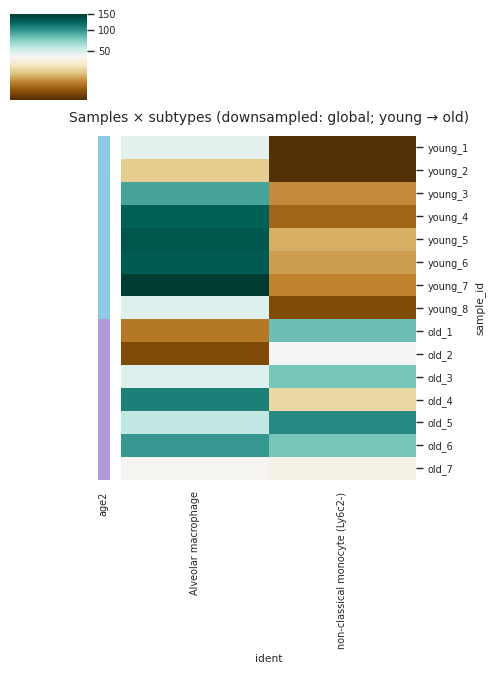

[✓ global] Heatmap saved → /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/macmono_heatmap_downsampled_global.pdf
[✓ global] Stats saved → /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/macmono_boxplot_stats_global.csv


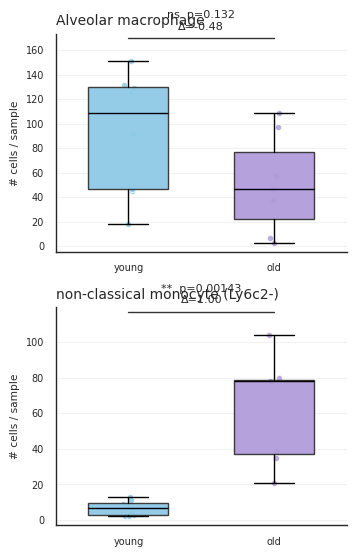

[✓ global] Boxplots saved → /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/macmono_boxplots_global.pdf
[✓ global] Boxplots saved → /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/macmono_boxplots_global.png
[Downsample: subtype] target=793 (from {'young': 1147, 'old': 793})
[subtype] kept cells: 1,586


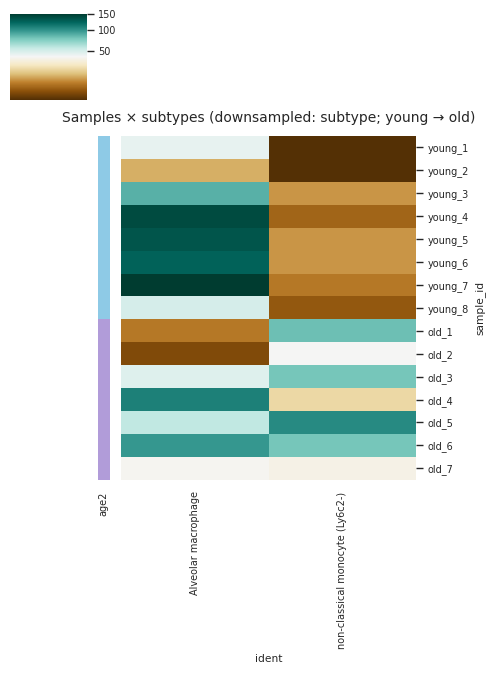

[✓ subtype] Heatmap saved → /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/macmono_heatmap_downsampled_subtype.pdf
[✓ subtype] Stats saved → /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/macmono_boxplot_stats_subtype.csv


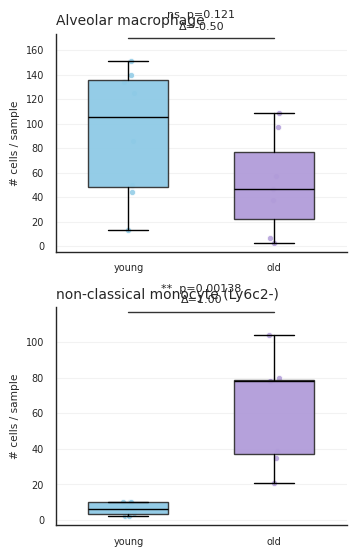

[✓ subtype] Boxplots saved → /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/macmono_boxplots_subtype.pdf
[✓ subtype] Boxplots saved → /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/macmono_boxplots_subtype.png


In [30]:
### Cell Type # Comparisons in Young vs Old in GSE124872 Dataset, Standalone Code### 
#Boxplots and heatmap. 2 different downsample methods, 1 random, 1 celltype comp aware#

# ============================================
# Mac/Mono analysis (young vs old) with TWO downsampling modes
# - Modes:
#     1) "global"  : uniform random within age (simple)
#     2) "subtype" : stratified by (age × subtype) [recommended]
# - Output per mode:
#     * Heatmap (narrower width), rows ordered young → old
#     * Skinny per-subtype boxplots + stats (Mann–Whitney U, Cliff's delta)
# ============================================

import os
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm
from scipy.stats import mannwhitneyu

# -----------------------------
# Config
# -----------------------------
H5AD_PATH = "/mnt/data/melhajjar/tabula_muris/all_tissues/droplet_h5ad/gs124872_properly_labeled_cells_opt.h5ad"
OUTPUT_DIR = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy"
os.makedirs(OUTPUT_DIR, exist_ok=True)

CELLTYPE_KEY = "ident"
SAMPLE_KEY   = "sample_id"
AGE_KEY      = "age2"      # derived from sample_id prefix
RNG_SEED     = 42

# Focus: macrophage/monocyte subtypes
FOCUS_SUBTYPES = [
    "Alveolar macrophage",
    # "Interstitial macrophages",
    "classical monocyte",
    "non-classical monocyte (Ly6c2-)",
]

AGE_COLORS = {"young": "#8ecae6", "old": "#b19cd9"}

# Skinny panel sizing
HEATMAP_WIDTH_IN  = 5.0   # 🔹 less wide
HEATMAP_ROW_SCALE = 0.45  # height per row
PANEL_WIDTH_IN    = 3.6
PANEL_HEIGHT_IN   = 2.8

sns.set_theme(style="white")
sns.set_context("paper", font_scale=0.9)

# -----------------------------
# Helpers
# -----------------------------
def downsample_global(adata, age_key=AGE_KEY, seed=RNG_SEED):
    """Uniform random sampling within each age to the min(age counts)."""
    rng = np.random.default_rng(seed)
    counts = adata.obs[age_key].value_counts()
    target = int(counts.min())
    keep = []
    for a in counts.index:
        idx = np.where(adata.obs[age_key].values == a)[0]
        k = min(target, len(idx))
        if k > 0:
            keep.append(rng.choice(idx, size=k, replace=False))
    keep = np.sort(np.concatenate(keep)) if len(keep) else np.array([], dtype=int)
    print(f"[Downsample: global] target={target} (from {counts.to_dict()})")
    return adata[keep].copy()

def downsample_by_subtype(adata, age_key=AGE_KEY, subtype_key=CELLTYPE_KEY, seed=RNG_SEED):
    """
    Stratified downsampling: equalize total cells per age while
    preserving subtype proportions within each age.
    """
    rng = np.random.default_rng(seed)
    counts_age = adata.obs[age_key].value_counts()
    target = int(counts_age.min())
    keep = []

    for a, df_a in adata.obs.groupby(age_key):
        sub_counts = df_a[subtype_key].value_counts()
        if sub_counts.sum() == 0:
            continue
        quotas = (sub_counts / sub_counts.sum()) * target
        q_floor = np.floor(quotas).astype(int)
        leftover = target - int(q_floor.sum())
        if leftover > 0:
            add = (quotas - q_floor).sort_values(ascending=False).index[:leftover]
            q_floor.loc[add] += 1

        for s, q in q_floor.items():
            idx_as = df_a.index[df_a[subtype_key] == s].to_numpy()
            q = min(int(q), len(idx_as))
            if q > 0:
                keep.append(rng.choice(idx_as, size=q, replace=False))

    keep = np.sort(np.concatenate(keep)) if len(keep) else np.array([], dtype=int)
    print(f"[Downsample: subtype] target={target} (from {counts_age.to_dict()})")
    return adata[keep].copy()

def cliffs_delta(x, y):
    """Cliff's delta: P(X>Y) - P(X<Y). Returns NaN if either empty."""
    x = np.asarray(x); y = np.asarray(y)
    if len(x) == 0 or len(y) == 0:
        return np.nan
    gt = (x[:, None] > y[None, :]).sum()
    lt = (x[:, None] < y[None, :]).sum()
    nxy = len(x) * len(y)
    return (gt - lt) / nxy if nxy else np.nan

def p_to_stars(p):
    if not np.isfinite(p): return "n/a"
    return "ns" if p >= 0.05 else ("*" if p >= 0.01 else ("**" if p >= 0.001 else ("***" if p >= 1e-4 else "****")))

def _safe_nanmax(list_of_arrays, fallback=1.0):
    """Max over possibly empty arrays; returns fallback if all empty."""
    vals = [np.asarray(a, float) for a in list_of_arrays if len(a)]
    if not vals:
        return float(fallback)
    return float(np.nanmax(np.concatenate(vals)))

def run_pipeline_for_mode(adata_input, mode_label, out_dir):
    """
    Runs:
      - Downsampling (global or subtype)
      - Heatmap (narrow width)
      - Boxplots + stats per subtype
    Saves outputs with filenames suffixed by mode_label.
    """
    # ---------- Downsample ----------
    if mode_label == "global":
        ad_ds = downsample_global(adata_input, age_key=AGE_KEY, seed=RNG_SEED)
    elif mode_label == "subtype":
        ad_ds = downsample_by_subtype(adata_input, age_key=AGE_KEY, subtype_key=CELLTYPE_KEY, seed=RNG_SEED)
    else:
        raise ValueError("mode_label must be 'global' or 'subtype'")

    print(f"[{mode_label}] kept cells: {ad_ds.n_obs:,}")

    # ---------- Long counts df ----------
    long_df = (
        ad_ds.obs.groupby([AGE_KEY, SAMPLE_KEY, CELLTYPE_KEY])
                 .size()
                 .reset_index(name="n_cells")
    )

    # ---------- Heatmap (narrow) ----------
    mat = long_df.pivot_table(
        index=SAMPLE_KEY,
        columns=CELLTYPE_KEY,
        values="n_cells",
        aggfunc="sum",
        fill_value=0
    )

    # order rows young → old
    age_map = long_df.drop_duplicates([SAMPLE_KEY, AGE_KEY]).set_index(SAMPLE_KEY)[AGE_KEY]
    order = age_map.map({"young": 0, "old": 1}).sort_values(kind="mergesort").index
    mat = mat.loc[order]
    row_colors = age_map.reindex(mat.index).map(AGE_COLORS).fillna("#FFFFFF")

    vmax = np.quantile(mat.values, 0.95) if mat.size else 1.0
    norm = PowerNorm(gamma=0.5)

    # narrower width; height scales with #rows
    heatmap_height = max(6, HEATMAP_ROW_SCALE * mat.shape[0])
    sns.set_context("paper", font_scale=0.8)
    g = sns.clustermap(
        mat,
        cmap="BrBG",
        norm=norm, vmin=0, vmax=vmax,
        row_cluster=False, col_cluster=False,
        figsize=(HEATMAP_WIDTH_IN, heatmap_height),
        yticklabels=True, xticklabels=True,
        cbar_kws={},                # no label text
        row_colors=row_colors
    )
    g.ax_row_dendrogram.set_visible(False)
    g.ax_col_dendrogram.set_visible(False)
    for sp in ["top","right","left","bottom"]:
        g.ax_heatmap.spines[sp].set_visible(False)
    for lab in g.ax_heatmap.get_xticklabels():
        lab.set_rotation(90)
        lab.set_horizontalalignment("center")
    if g.ax_heatmap.collections:
        cb = g.ax_heatmap.collections[0].colorbar
        if cb is not None:
            cb.set_label("")

    g.ax_heatmap.set_title(f"Samples × subtypes (downsampled: {mode_label}; young → old)",
                           pad=10, fontsize=10)
    plt.tight_layout()
    heatmap_path = os.path.join(out_dir, f"macmono_heatmap_downsampled_{mode_label}.pdf")
    g.savefig(heatmap_path, bbox_inches="tight", dpi=300)
    plt.show()
    print(f"[✓ {mode_label}] Heatmap saved → {heatmap_path}")

    # ---------- Boxplots + stats per subtype ----------
    per_sample_sub = (
        long_df.groupby([AGE_KEY, SAMPLE_KEY, CELLTYPE_KEY])["n_cells"]
               .sum()
               .reset_index()
    )

    subtypes = sorted(per_sample_sub[CELLTYPE_KEY].unique().tolist())

    # Stats
    stats_rows = []
    for subtype in subtypes:
        df_s = per_sample_sub[per_sample_sub[CELLTYPE_KEY] == subtype]
        yv = df_s.loc[df_s[AGE_KEY] == "young", "n_cells"].to_numpy()
        ov = df_s.loc[df_s[AGE_KEY] == "old",   "n_cells"].to_numpy()
        if len(yv) and len(ov):
            u_stat, p_val = mannwhitneyu(yv, ov, alternative="two-sided")
        else:
            u_stat, p_val = np.nan, np.nan
        delta = cliffs_delta(ov, yv)  # effect: old vs young
        stats_rows.append({
            "mode": mode_label,
            "subtype": subtype,
            "n_young_samples": int((df_s[AGE_KEY]=="young").sum()),
            "n_old_samples":   int((df_s[AGE_KEY]=="old").sum()),
            "median_young": float(np.median(yv)) if len(yv) else np.nan,
            "median_old":   float(np.median(ov)) if len(ov) else np.nan,
            "MannWhitneyU": float(u_stat) if np.isfinite(u_stat) else np.nan,
            "p_value_two_sided": float(p_val) if np.isfinite(p_val) else np.nan,
            "Cliffs_delta_old_vs_young": float(delta) if np.isfinite(delta) else np.nan,
        })
    stats_df = pd.DataFrame(stats_rows)
    stats_path = os.path.join(out_dir, f"macmono_boxplot_stats_{mode_label}.csv")
    stats_df.to_csv(stats_path, index=False)
    print(f"[✓ {mode_label}] Stats saved → {stats_path}")

    # Skinny boxplots per subtype (with safe limits)
    n = len(subtypes)
    fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(PANEL_WIDTH_IN, PANEL_HEIGHT_IN * n), squeeze=False)
    rng = np.random.default_rng(RNG_SEED)

    for i, subtype in enumerate(subtypes):
        ax = axes[i, 0]
        df_s = per_sample_sub[per_sample_sub[CELLTYPE_KEY] == subtype].copy()

        arr_y = df_s.loc[df_s[AGE_KEY] == "young", "n_cells"].to_numpy()
        arr_o = df_s.loc[df_s[AGE_KEY] == "old",   "n_cells"].to_numpy()
        data  = [arr_y, arr_o]

        bp = ax.boxplot(data, widths=0.55, patch_artist=True,
                        medianprops=dict(color="black", linewidth=1))
        for j, patch in enumerate(bp["boxes"]):
            patch.set_facecolor(AGE_COLORS["young" if j == 0 else "old"])
            patch.set_edgecolor("#333333"); patch.set_alpha(0.95)

        # jittered sample dots
        if len(arr_y):
            x = np.full(len(arr_y), 1.0) + (rng.random(len(arr_y)) - 0.5)*0.08
            ax.scatter(x, arr_y, s=20, alpha=0.85, edgecolors="white", linewidths=0.6, c=AGE_COLORS["young"])
        if len(arr_o):
            x = np.full(len(arr_o), 2.0) + (rng.random(len(arr_o)) - 0.5)*0.08
            ax.scatter(x, arr_o, s=20, alpha=0.85, edgecolors="white", linewidths=0.6, c=AGE_COLORS["old"])

        ax.set_xticks([1, 2]); ax.set_xticklabels(["young", "old"])
        ax.set_ylabel("# cells / sample")
        ax.set_title(subtype, loc="left", fontsize=10)
        ax.grid(axis="y", alpha=0.25)
        for sp in ["top", "right"]:
            ax.spines[sp].set_visible(False)

        # SAFE ylim + annotation
        data_max = _safe_nanmax(data, fallback=1.0)
        ymax = max(ax.get_ylim()[1], data_max * 1.15)
        ax.set_ylim(ax.get_ylim()[0], ymax)

        has_both = (len(arr_y) > 0) and (len(arr_o) > 0)
        if has_both:
            ax.plot([1, 2], [ymax*0.98, ymax*0.98], color="#333333", linewidth=1)

        row = stats_df.loc[stats_df["subtype"] == subtype].iloc[0]
        p  = row["p_value_two_sided"]; d = row["Cliffs_delta_old_vs_young"]
        stars = p_to_stars(p)
        txt = f"{stars}  p={p:.3g}\nΔ={d:.2f}" if np.isfinite(p) else "n/a"
        ax.text(1.5, ymax*1.01, txt, ha="center", va="bottom", fontsize=8)

    plt.tight_layout(h_pad=1.0)
    box_path_pdf = os.path.join(out_dir, f"macmono_boxplots_{mode_label}.pdf")
    box_path_png = os.path.join(out_dir, f"macmono_boxplots_{mode_label}.png")
    fig.savefig(box_path_pdf, bbox_inches="tight", dpi=300)
    fig.savefig(box_path_png, bbox_inches="tight", dpi=300)
    plt.show()
    print(f"[✓ {mode_label}] Boxplots saved → {box_path_pdf}\n[✓ {mode_label}] Boxplots saved → {box_path_png}")

# -----------------------------
# Load and prep once, then run BOTH modes
# -----------------------------
adata = sc.read_h5ad(H5AD_PATH)

# sample_id from obs_names (before ':') if needed
if SAMPLE_KEY not in adata.obs.columns:
    adata.obs[SAMPLE_KEY] = adata.obs_names.str.split(":", n=1).str[0]

# age2 from sample_id (prefix before '_')
adata.obs[AGE_KEY] = adata.obs[SAMPLE_KEY].astype(str).str.split("_", n=1).str[0].str.lower()

# keep only young/old
adata = adata[adata.obs[AGE_KEY].isin(["young", "old"])].copy()

# keep only mac/mono subtypes (case-insensitive)
ct_lower = adata.obs[CELLTYPE_KEY].astype(str).str.lower().str.strip()
keep_mask = ct_lower.isin([s.lower() for s in FOCUS_SUBTYPES])
adata = adata[keep_mask].copy()
adata.obs[CELLTYPE_KEY] = adata.obs[CELLTYPE_KEY].astype(str)

print(f"[Loaded] Cells after mac/mono filter: {adata.n_obs:,}")

# Run both analyses
for MODE in ["global", "subtype"]:
    run_pipeline_for_mode(adata, MODE, OUTPUT_DIR)

In [ ]:
### Cell Type Proportion Breakdown in all Cells  for Tabula Muris ###

In [29]:
# ============================================
# Downsample each sample ("mouse.id" with "-M-") to the least #cells
# Creates a balanced AnnData: same #cells per sample
# ============================================

import re
import numpy as np
import pandas as pd
import scanpy as sc

# ---- Paths / config ----
H5AD_PATH   = "/mnt/data/melhajjar/tabula_muris/all_tissues/Lung.h5ad"
# H5AD_PATH   = "/mnt/data/melhajjar/tabula_muris/all_tissues/facs_h5ad/tabula-muris-senis-facs-processed-official-annotations-Lung.h5ad"
MOUSE_KEY   = "mouse.id"   # column in adata.obs
OUT_H5AD    = "/mnt/data/Lung_downsampled_min_per_sample.h5ad"
RANDOM_SEED = 42

# ---- Normalization helpers (robust "-M-" matching) ----
_dash_re  = re.compile(r"[‐-–—-]")     # unify many dash variants
_quote_re = re.compile(r"[’`“”]")      # unify curly quotes etc.

def norm_mouse(x: str) -> str:
    s = str(x)
    s = _dash_re.sub("-", s)           # normalize dashes to "-"
    s = _quote_re.sub("'", s)          # normalize quotes to "'"
    s = s.strip().strip("'").strip('"')
    s = re.sub(r"\s+", "", s)          # remove any spaces
    return s

# ---- Load ----
print(f"[*] Loading: {H5AD_PATH}")
adata = sc.read_h5ad(H5AD_PATH)

# ---- Build normalized IDs and keep only samples containing "-M-" ----
adata.obs["mouse_norm"] = adata.obs[MOUSE_KEY].astype(str).map(norm_mouse)
mask_M = adata.obs["mouse_norm"].str.contains("-M-")
adata_M = adata[mask_M].copy()

if adata_M.n_obs == 0:
    raise ValueError("No cells found where normalized mouse.id contains '-M-'.")

print(f"[*] Cells with '-M-': {adata_M.n_obs:,}")
print("[*] #samples (unique mouse_norm):", adata_M.obs["mouse_norm"].nunique())

# ---- Count cells per sample and find minimum ----
counts = (
    adata_M.obs.groupby("mouse_norm")
               .size()
               .rename("n_cells")
               .sort_values(ascending=True)
)
print("\n[*] Cells per sample (ascending):")
print(counts.to_string())

min_n = int(counts.min())
if min_n <= 0:
    raise ValueError("Minimum cell count across samples is <= 0; cannot downsample.")

print(f"\n[*] Downsampling EACH sample to min_n = {min_n} cells (seed={RANDOM_SEED})")

# ---- Downsample per sample to min_n ----
# Preferred (pandas >= 1.4): groupby.sample returns a single DataFrame
try:
    sampled_obs = (
        adata_M.obs
        .groupby("mouse_norm", group_keys=False)
        .sample(n=min_n, random_state=RANDOM_SEED)
    )
    balanced_idx = sampled_obs.index
except Exception:
    # Fallback: groupby.apply then flatten the MultiIndex
    sampled_obs = (
        adata_M.obs
        .groupby("mouse_norm", group_keys=False)
        .apply(lambda df: df.sample(n=min_n, random_state=RANDOM_SEED))
    )
    balanced_idx = sampled_obs.index.get_level_values(-1)

# ---- Slice AnnData ----
adata_balanced = adata_M[balanced_idx].copy()

# ---- Sanity checks ----
print(f"\n[*] Balanced AnnData cells: {adata_balanced.n_obs:,}")
per_sample_after = adata_balanced.obs.groupby("mouse_norm").size()
print("[*] Per-sample counts after downsampling (should all equal min_n):")
print(per_sample_after.to_string())

# ---- Save (optional) ----
adata_balanced.write(OUT_H5AD)
print(f"\n[*] Saved balanced AnnData to: {OUT_H5AD}")

# ---- If you also want a quick CSV manifest of how many cells per sample ----
out_csv = "/mnt/data/Lung_downsampled_min_per_sample_counts.csv"
per_sample_after.rename("n_cells").to_csv(out_csv, header=True)
print(f"[*] Wrote per-sample counts to: {out_csv}")


[*] Loading: /mnt/data/melhajjar/tabula_muris/all_tissues/Lung.h5ad
[*] Cells with '-M-': 18,736
[*] #samples (unique mouse_norm): 10

[*] Cells per sample (ascending):
mouse_norm
30-M-5      505
3-M-5/6     587
30-M-4      936
1-M-62     1078
18-M-53    1283
1-M-63     1430
18-M-52    1603
30-M-3     1638
3-M-7/8    1662
30-M-2     8014

[*] Downsampling EACH sample to min_n = 505 cells (seed=42)

[*] Balanced AnnData cells: 5,050
[*] Per-sample counts after downsampling (should all equal min_n):
mouse_norm
1-M-62     505
1-M-63     505
18-M-52    505
18-M-53    505
3-M-5/6    505
3-M-7/8    505
30-M-2     505
30-M-3     505
30-M-4     505
30-M-5     505

[*] Saved balanced AnnData to: /mnt/data/Lung_downsampled_min_per_sample.h5ad
[*] Wrote per-sample counts to: /mnt/data/Lung_downsampled_min_per_sample_counts.csv


In [ ]:
# Define the macrophage and monocyte subtypes you care about
target_subtypes = [
    "alveolar macrophage",
    "interstitial macrophage",
    "lung macrophage",
    "classical monocyte",
    "non-classical monocyte",
    "intermediate monocyte"
]

# Subset to those subtypes only
adata_subset = adata_balanced[adata_balanced.obs["cell_ontology_class"].isin(target_subtypes)].copy()

# Count number of cells per subtype per sample
cell_counts = (
    adata_subset.obs
    .groupby(["mouse_norm", "cell_ontology_class"])
    .size()
    .unstack(fill_value=0)
)



# Add age to your counts table
mouse_age_map = adata_balanced.obs.set_index("mouse_norm")["age"].to_dict()
cell_counts["age"] = cell_counts.index.map(mouse_age_map)
cell_counts = cell_counts.reset_index()  # now has columns: mouse_norm, age, ...
print(cell_counts.head())


cell_ontology_class mouse_norm  alveolar macrophage  classical monocyte  \
0                       1-M-62                   82                  91   
1                       1-M-63                  143                 102   
2                      3-M-5/6                    9                   1   
3                      3-M-7/8                   23                   4   
4                      18-M-52                   19                 143   

cell_ontology_class  intermediate monocyte  lung macrophage  \
0                                       18                1   
1                                       21                1   
2                                        0                0   
3                                        0                1   
4                                        5                2   

cell_ontology_class  non-classical monocyte  age  
0                                        37   1m  
1                                        36   1m  
2                


🧬 alveolar macrophage — KW p=0.939
Dunn’s posthoc (Holm-corrected):
        18m      1m     30m      3m
18m  1.0000  0.4106  1.0000  1.0000
1m   0.4106  1.0000  0.4106  0.4106
30m  1.0000  0.4106  1.0000  1.0000
3m   1.0000  0.4106  1.0000  1.0000
Cliff’s delta:
  3m vs 18m: 0.000
  3m vs 30m: -0.250
  18m vs 30m: 0.000


/tmp/ipykernel_4414/2841280347.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


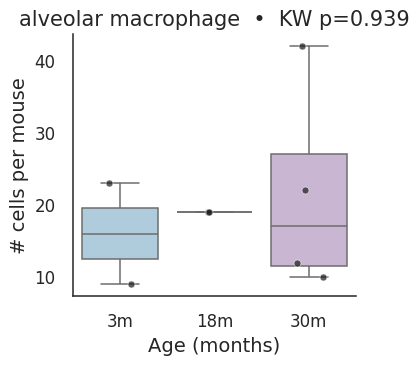


🧬 classical monocyte — KW p=0.135
Dunn’s posthoc (Holm-corrected):
        18m      1m     30m      3m
18m  1.0000  1.0000  1.0000  0.2851
1m   1.0000  1.0000  1.0000  0.7458
30m  1.0000  1.0000  1.0000  0.2851
3m   0.2851  0.7458  0.2851  1.0000
Cliff’s delta:
  3m vs 18m: -1.000
  3m vs 30m: -1.000
  18m vs 30m: 0.000


/tmp/ipykernel_4414/2841280347.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


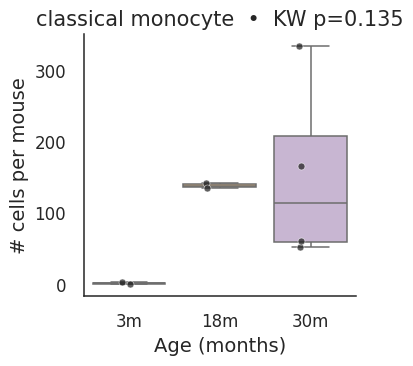


🧬 intermediate monocyte — KW p=0.0463
Dunn’s posthoc (Holm-corrected):
        18m      1m     30m      3m
18m  1.0000  0.5513  0.4993  1.0000
1m   0.5513  1.0000  1.0000  0.2308
30m  0.4993  1.0000  1.0000  0.1279
3m   1.0000  0.2308  0.1279  1.0000
Cliff’s delta:
  3m vs 18m: -1.000
  3m vs 30m: -1.000
  18m vs 30m: -1.000


/tmp/ipykernel_4414/2841280347.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


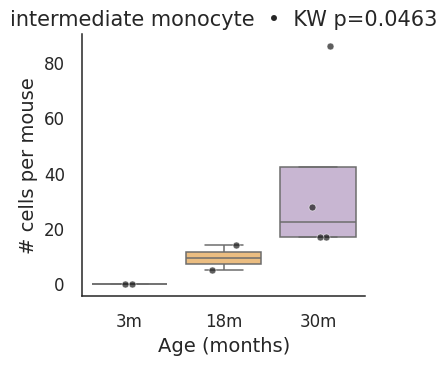


🧬 lung macrophage — KW p=0.048
Dunn’s posthoc (Holm-corrected):
        18m      1m     30m      3m
18m  1.0000  0.9617  0.9617  0.9617
1m   0.9617  1.0000  0.1658  0.9617
30m  0.9617  0.1658  1.0000  0.0709
3m   0.9617  0.9617  0.0709  1.0000
Cliff’s delta:
  3m vs 18m: -1.000
  3m vs 30m: -1.000
  18m vs 30m: -1.000


/tmp/ipykernel_4414/2841280347.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


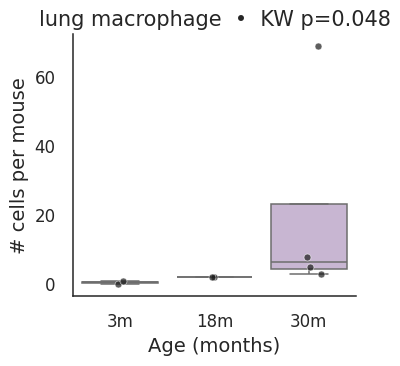


🧬 non-classical monocyte — KW p=0.368
Dunn’s posthoc (Holm-corrected):
     18m      1m     30m      3m
18m  1.0  1.0000  1.0000  1.0000
1m   1.0  1.0000  1.0000  0.9322
30m  1.0  1.0000  1.0000  0.5167
3m   1.0  0.9322  0.5167  1.0000
Cliff’s delta:
  3m vs 18m: -1.000
  3m vs 30m: -0.500
  18m vs 30m: -0.500


/tmp/ipykernel_4414/2841280347.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


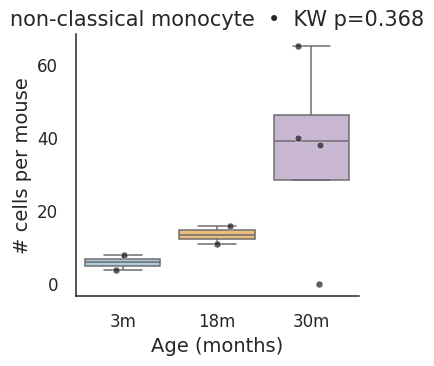

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kruskal
import scikit_posthocs as sp
import numpy as np

# your data
AGES = ["3m", "18m", "30m"]
palette = {"3m": "#A6CEE3", "18m": "#FDBF6F", "30m": "#CAB2D6"}

sns.set_theme(style="white", context="talk")
plt.rcParams.update({
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.linewidth": 1.1,
    "axes.labelsize": 14,
    "axes.titlesize": 15,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
})

def cliffs_delta(x, y):
    """Nonparametric effect size."""
    x, y = np.asarray(x), np.asarray(y)
    gt = np.sum(x[:, None] > y)
    lt = np.sum(x[:, None] < y)
    n = len(x) * len(y)
    return (gt - lt) / n if n else np.nan

for subtype in sorted(long_df["subtype"].unique()):
    df = long_df[long_df["subtype"] == subtype].copy()
    
    # --- Overall Kruskal–Wallis ---
    groups = [df.loc[df["age"] == a, "n_cells"] for a in AGES if a in df["age"].values]
    kw_p = np.nan
    if all(len(g) >= 2 for g in groups):
        _, kw_p = kruskal(*groups)
    
    # --- Pairwise Dunn’s tests ---
    dunn_df = sp.posthoc_dunn(df, val_col="n_cells", group_col="age", p_adjust="holm")
    
    # --- Effect sizes (Cliff’s delta) ---
    effects = {}
    for a, b in [("3m", "18m"), ("3m", "30m"), ("18m", "30m")]:
        if a in df["age"].values and b in df["age"].values:
            x, y = df.loc[df["age"] == a, "n_cells"], df.loc[df["age"] == b, "n_cells"]
            effects[f"{a} vs {b}"] = cliffs_delta(x, y)
    
    print(f"\n🧬 {subtype} — KW p={kw_p:.3g}")
    print("Dunn’s posthoc (Holm-corrected):")
    print(dunn_df.round(4))
    print("Cliff’s delta:")
    for k, v in effects.items():
        print(f"  {k}: {v:.3f}")
    
    # --- Plot ---
    plt.figure(figsize=(4, 4))
    ax = sns.boxplot(
        data=df, x="age", y="n_cells", order=AGES,
        palette=palette, showfliers=False, linewidth=1.1
    )
    sns.stripplot(
        data=df, x="age", y="n_cells", order=AGES,
        color="k", size=5, alpha=0.7, jitter=0.15, edgecolor="white", linewidth=0.5
    )

    ax.grid(False)
    ax.set_title(f"{subtype}  •  KW p={kw_p:.3g}", pad=6)
    ax.set_xlabel("Age (months)")
    ax.set_ylabel("# cells per mouse")
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_4414/4234512012.py:21: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  long_df.pivot_table(


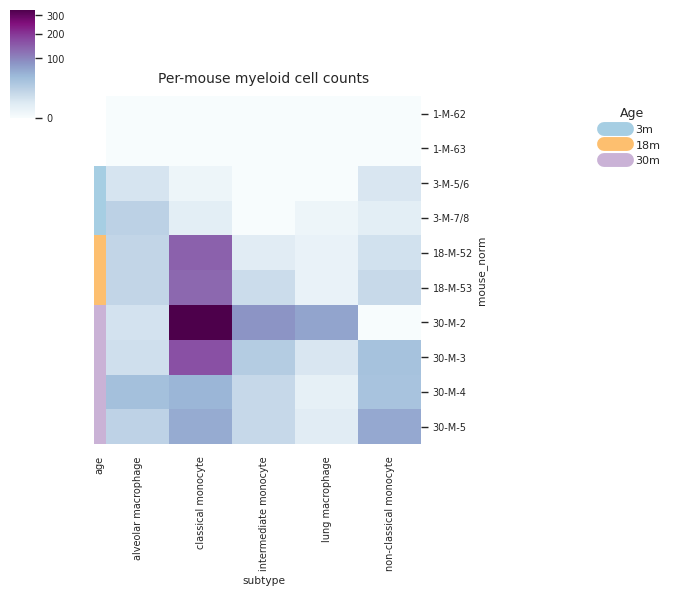

✅ Saved high-quality PDF to:
/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/Lung_MyeloidCellCounts_Heatmap_PerMouse_AgeGroups_3m_18m_30m_no1m.pdf


In [71]:
# ============================================
# Per-mouse myeloid cell counts heatmap (clean, long, skinny, and export to PDF)
# ============================================

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm
import os

# ---- keep only the 3 age groups ----
AGES = ["3m", "18m", "30m"]
age_palette = {"3m": "#A6CEE3", "18m": "#FDBF6F", "30m": "#CAB2D6"}

# filter dataframe
long_df = long_df[long_df["age"].isin(AGES)].copy()

# ensure one row per mouse (each mouse belongs to one age)
mat = (
    long_df.pivot_table(
        index="mouse_norm",
        columns="subtype",
        values="n_cells",
        aggfunc="sum",
        fill_value=0
    )
)

# add a column for age (for coloring)
mouse_to_age = long_df.drop_duplicates("mouse_norm").set_index("mouse_norm")["age"]
row_colors = mouse_to_age.map(age_palette).fillna("#FFFFFF")

# ----- Color normalization -----
vmax = np.quantile(mat.values, 0.95) if mat.size else 1.0
norm = PowerNorm(gamma=0.5)  # sqrt scale for better contrast

# ---- Smaller fonts for elegance ----
sns.set_theme(style="white")
sns.set_context("paper", font_scale=0.8)

# ---- Plot the heatmap ----
g = sns.clustermap(
    mat,
    cmap="BuPu",
    norm=norm, vmin=0, vmax=vmax,
    row_cluster=False, col_cluster=False,
    figsize=(5, max(6, 0.5 * mat.shape[0])),  # 🔹 long + skinny
    yticklabels=True,
    xticklabels=True,
    cbar_kws={"label": "# of cells (sqrt color scale; 95th pct clip)"},
    row_colors=row_colors
)

# clean look
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)
for sp in ["top", "right", "left", "bottom"]:
    g.ax_heatmap.spines[sp].set_visible(False)

# adjust colorbar label position (move slightly left)
cbar = g.ax_heatmap.collections[0].colorbar
cbar.set_label("# of cells", labelpad=-30, fontsize=9)

# Add legend for age colors (moved further right)
for a, color in age_palette.items():
    g.ax_heatmap.plot([], [], color=color, label=a, linewidth=10)

g.ax_heatmap.legend(
    title="Age",
    bbox_to_anchor=(1.55, 1),  # 🔹 far right
    loc="upper left",
    frameon=False,
    fontsize=8,
    title_fontsize=9
)

# title
g.ax_heatmap.set_title("Per-mouse myeloid cell counts", pad=10, fontsize=10)

# ---- Export high-quality PDF ----
output_dir = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy"
os.makedirs(output_dir, exist_ok=True)

pdf_path = os.path.join(
    output_dir,
    "Lung_MyeloidCellCounts_Heatmap_PerMouse_AgeGroups_3m_18m_30m_no1m.pdf"
)

g.savefig(pdf_path, bbox_inches="tight", dpi=300)
plt.show()

print(f"✅ Saved high-quality PDF to:\n{pdf_path}")


In [ ]:
#Adding heatmap with all genes organized by functionality, overlaping names#
# ============================================
# Lung — Male-only, no 1m
# Unified Report: RF (Baseline + PLS-VIP) + PLS Regression (CV)
# + Leave-One-Cell-Type-Out (LOCTO)
# Pastel per-age colors; PLS scatter has ONLY identity line; legends inside.
# Outputs ONE PDF + a LOCTO CSV. Also saves VIP heatmaps (PDF+PNG).
# ============================================

import os, warnings, datetime as dt
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, roc_curve, auc, classification_report,
    accuracy_score, f1_score, balanced_accuracy_score, matthews_corrcoef,
    average_precision_score, precision_recall_curve
)
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import pearsonr

# -------------------------
# Config (edit paths)
# -------------------------
H5AD_PATH           = "/mnt/data/melhajjar/tabula_muris/all_tissues/Lung.h5ad"
OUTPUT_DIR          = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy"

AGE_KEY             = "age"
SEX_KEY             = "sex"
KEEP_SEX_VALUE      = "male"
DROP_AGE_VALUES     = {"1m"}
CELLTYPE_KEY        = "cell_ontology_class"   # << used for LOCTO

DOWNSAMPLE          = False
USE_TOP_HVGS        = True
N_HVGS              = 3000

# PLS VIP for RF classifier
RUN_PLS_VIP         = True
PLS_N_COMPONENTS    = 6
PLS_TOP_GENES       = 200
PLS_SCALE_X         = True

# PLS regression (continuous age)
RUN_PLS_REG         = True
PLS_REG_COMPONENTS  = 6
PLS_REG_SCALE_X     = True

# Heatmap display controls
HEATMAP_TOP_GENES = 200          # set to None to plot all VIP genes
HEATMAP_SHOW_GENE_LABELS = True  # always show labels (auto font scaling)

CV_FOLDS            = 5
RANDOM_STATE        = 42

RF_ESTIMATORS       = 400
RF_MAX_DEPTH        = 20
RF_MIN_SAMPLES_LEAF = 2
RF_N_JOBS           = -1

# -------------------------
# Plot styling
# -------------------------
mpl.rcParams.update({
    "figure.dpi": 150,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "font.family": "DejaVu Sans",
})

def _nature_axes(ax):
    for s in ["top", "right"]:
        ax.spines[s].set_visible(False)
    ax.spines["left"].set_linewidth(1.0)
    ax.spines["bottom"].set_linewidth(1.0)
    ax.tick_params(width=1.0, length=4)

# -------------------------
# Helpers
# -------------------------
def _ensure_dense(X):
    try: return X.toarray()
    except Exception: return np.asarray(X)

def _numeric_month(x):
    s = str(x).strip().lower()
    return float(s[:-1]) if s.endswith("m") else float(s)

# consistent pastel palette with 30m forced to purple
def _pastel_palette_from_classes(classes_sorted):
    base = ["#A6CEE3", "#FDBF6F", "#B2DF8A", "#CAB2D6", "#F4A6B3", "#B2E2E2"]
    pal = {c: base[i % len(base)] for i, c in enumerate(classes_sorted)}
    for key in ["30m", 30, 30.0]:
        if key in pal:
            pal[key] = "#CAB2D6"  # purple for 30m
    return pal

def _bar_by_age(ax, classes, counts, title, pal):
    colors = [pal[c] for c in classes]
    ax.bar(range(len(classes)), counts, color=colors, edgecolor="#333333", linewidth=0.6)
    ax.set_xticks(range(len(classes))); ax.set_xticklabels(classes)
    _nature_axes(ax)
    ax.set_title(title); ax.set_ylabel("# cells")
    ymax = counts.max() if len(counts) else 0
    for i, v in enumerate(counts):
        ax.text(i, v + max(1, ymax)*0.02, f"{int(v):,}", ha='center', va='bottom', fontsize=9)

def _metrics_table(ax, rows, title):
    ax.axis("off")
    ax.set_title(title, loc="left", pad=6)
    col_labels = ["Metric", "RF Baseline", "RF PLS-VIP", "PLS Reg (overall)"]
    table_data = [[k,
                   f"{v[0]:.3f}" if v[0] is not None else "",
                   f"{v[1]:.3f}" if v[1] is not None else "",
                   f"{v[2]:.3f}" if v[2] is not None else ""] for k, v in rows]
    the_table = ax.table(cellText=table_data, colLabels=col_labels, loc="center")
    the_table.auto_set_font_size(False); the_table.set_fontsize(9)
    the_table.scale(1, 1.2)

def _confusion_heatmap(ax, y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    cmn = cm.astype(float) / cm.sum(axis=1, keepdims=True)
    im = ax.imshow(cmn, aspect="auto", cmap="Blues", vmin=0, vmax=1)
    _nature_axes(ax)
    ax.set_title(title); ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    ax.set_xticks(range(len(classes))); ax.set_yticks(range(len(classes)))
    ax.set_xticklabels(classes); ax.set_yticklabels(classes)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm[i,j]:,}\n({cmn[i,j]*100:.1f}%)",
                    ha='center', va='center', fontsize=8)
    plt.colorbar(im, ax=ax, fraction=0.46/10, pad=0.04, label="Row-normalized")

def _roc_plot(ax, y_true, probas, classes, title_prefix, pal):
    Y = label_binarize(y_true, classes=classes)
    aucs = []
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(Y[:, i], probas[:, i])
        roc_auc = auc(fpr, tpr); aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1.6, color=pal[cls], label=f"{cls} (AUC={roc_auc:.3f})")
    ax.plot([0,1],[0,1], linestyle="--", linewidth=1, color="#666")
    _nature_axes(ax)
    ax.set_title(f"{title_prefix} ROC  (macro AUC={np.mean(aucs):.3f})")
    ax.set_xlabel("False Positive Rate"); ax.set_ylabel("True Positive Rate")
    ax.legend(frameon=False, loc="lower right")

def _pr_plot(ax, y_true, probas, classes, title_prefix, pal):
    Y = label_binarize(y_true, classes=classes)
    aps = []
    for i, cls in enumerate(classes):
        precision, recall, _ = precision_recall_curve(Y[:, i], probas[:, i])
        ap = average_precision_score(Y[:, i], probas[:, i]); aps.append(ap)
        ax.plot(recall, precision, lw=1.6, color=pal[cls], label=f"{cls} (AP={ap:.3f})")
    _nature_axes(ax)
    ax.set_title(f"{title_prefix} PR  (macro AP={np.mean(aps):.3f})")
    ax.set_xlabel("Recall"); ax.set_ylabel("Precision")
    ax.set_xlim(0,1); ax.set_ylim(0,1.05)
    ax.legend(frameon=False, loc="lower left")

def _top_bars(ax, tuples, title, xlab, max_items=20):
    if not tuples:
        ax.text(0.5, 0.5, "N/A", ha='center', va='center')
        ax.set_title(title); ax.set_xlabel(xlab); return
    names, vals = zip(*tuples[:max_items])
    y = np.arange(len(names))[::-1]
    ax.barh(y, vals, color="#A6CEE3", edgecolor="#333333", linewidth=0.6)
    _nature_axes(ax)
    ax.set_yticks(y); ax.set_yticklabels(names, fontsize=8)
    ax.set_title(title); ax.set_xlabel(xlab)
    ax.invert_yaxis()
    for yi, v in zip(y, vals):
        ax.text(v, yi, f" {v:.3f}", va="center", ha="left", fontsize=8)

def _top_rf_features(rf, feature_names, k=20):
    importances = getattr(rf, "feature_importances_", None)
    if importances is None: return []
    idx = np.argsort(importances)[::-1][:k]
    return list(zip(feature_names[idx], importances[idx]))

# -------------------------
# PLS VIP utilities
# -------------------------
def _one_hot_labels(y, classes):
    Y = np.zeros((len(y), len(classes)), dtype=float)
    m = {c:i for i,c in enumerate(classes)}
    for idx, lab in enumerate(y): Y[idx, m[lab]] = 1.0
    return Y

def select_pls_biomarkers(X, y, genes, classes, n_components=6, top_k=400, scale_x=True):
    # Wold VIP
    def _compute_pls_vip(pls, X, Y):
        X = np.asarray(X, dtype=float)
        T = pls.x_scores_; Q = pls.y_loadings_; W = pls.x_weights_
        ssy = []
        for a in range(Q.shape[1]):
            ssy_a = np.sum((T[:, a][:, None] @ Q[:, a][None, :])**2)
            ssy.append(ssy_a)
        ssy = np.array(ssy); ssy_tot = np.sum(ssy); p = W.shape[0]
        vip = np.zeros((p,))
        denom = np.sum(W**2, axis=0)
        for j in range(p):
            vip[j] = np.sqrt(p * np.sum(ssy * (W[j,:]**2) / denom) / ssy_tot)
        return vip

    X_use = X.copy()
    if scale_x:
        scaler = StandardScaler(with_mean=True, with_std=True)
        X_use = scaler.fit_transform(X_use)
    Y = _one_hot_labels(y, classes)
    pls = PLSRegression(n_components=n_components, scale=False)
    pls.fit(X_use, Y)
    vip = _compute_pls_vip(pls, X_use, Y)
    idx = np.argsort(vip)[::-1][:top_k]
    return idx, genes[idx], vip

# -------------------------
# PLS Regression scatter — filled circles, identity only
# -------------------------
def _to_months(labels):
    def _coerce(x):
        if isinstance(x, (int, float, np.number)): return float(x)
        s = str(x).strip().lower()
        if s.endswith("m"): s = s[:-1]
        return float(s)
    return np.array([_coerce(x) for x in labels], dtype=float)

def _plot_pred_vs_true_pub_identity_only(
    ax,
    y_true_labels,
    y_pred_months,
    class_order=None,
    title="PLS Regression (CV): Predicted vs True Age",
    jitter=0.18,
    point_size=14,
    point_alpha=0.55,
    mean_ms=9,
    palette=None,
    annotate_means=True,
    seed=0,
):
    rng = np.random.default_rng(seed)
    x_true = _to_months(y_true_labels)
    y_pred = np.asarray(y_pred_months, float)

    if class_order is None:
        classes = np.sort(np.unique(x_true))
    else:
        classes = _to_months(class_order)

    if palette is None:
        palette = _pastel_palette_from_classes(classes)

    x_jit = x_true + rng.uniform(-jitter, jitter, size=len(x_true))
    for c in classes:
        m = (x_true == c)
        if m.any():
            ax.scatter(x_jit[m], y_pred[m], s=point_size, alpha=point_alpha,
                       c=[palette[c]], marker='o', edgecolors='none')

    for c in classes:
        ys = y_pred[x_true == c]
        if ys.size == 0: 
            continue
        mu = float(ys.mean())
        sd = float(ys.std(ddof=1)) if ys.size > 1 else 0.0
        ax.errorbar([c], [mu], yerr=[[sd],[sd]], fmt='o', ms=mean_ms,
                    color=palette[c], mec="black", mfc=palette[c], mew=0.6,
                    ecolor=palette[c], elinewidth=1.1, capsize=3, capthick=1.1, zorder=5)
        if annotate_means:
            ax.text(c + 0.25, mu, f"μ={mu:.1f} m", va="center", ha="left",
                    color="#333333", fontsize=10)

    xmin, xmax = classes.min() - 1, classes.max() + 1
    y_min = np.percentile(y_pred, 1)
    y_max = np.percentile(y_pred, 99)
    y_pad = 0.06 * (y_max - y_min + 1e-9)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(y_min - y_pad, y_max + y_pad)

    ax.plot([xmin, xmax], [xmin, xmax], ls=(0,(4,3)), lw=1.2, color="#222222", alpha=0.9, label="y = x")

    _nature_axes(ax)
    ax.set_xlabel("True Age (months)")
    ax.set_ylabel("Predicted Age (months)")
    ax.set_title(title)

    handles, labels = [], []
    for c in classes:
        h = plt.Line2D([0], [0], marker='o', linestyle='None',
                       markersize=6, markerfacecolor=palette[c], markeredgewidth=0)
        handles.append(h); labels.append(f"{int(c)} m")
    handles.append(plt.Line2D([0,1],[0,1], color="#222222", lw=1.2, linestyle=(0,(4,3))))
    labels.append("y = x")
    ax.legend(handles, labels, frameon=False, loc="upper left")

# -------------------------
# Load & filter (GLOBAL)
# -------------------------
print("[*] Loading:", H5AD_PATH)
adata = sc.read_h5ad(H5AD_PATH)
for col in [AGE_KEY, SEX_KEY, CELLTYPE_KEY]:
    if col not in adata.obs.columns:
        raise KeyError(f"Missing column in adata.obs: {col}")

adata = adata[adata.obs[SEX_KEY].astype(str) == str(KEEP_SEX_VALUE)].copy()
adata = adata[~adata.obs[AGE_KEY].astype(str).isin(DROP_AGE_VALUES)].copy()

# Baseline feature space
adata_b = adata.copy()
if USE_TOP_HVGS:
    sc.pp.highly_variable_genes(adata_b, n_top_genes=N_HVGS, flavor="seurat_v3")
    adata_b = adata_b[:, adata_b.var["highly_variable"]].copy()
genes_baseline = adata_b.var_names.to_numpy()

X_b = _ensure_dense(adata_b.X)
y_cls = adata_b.obs[AGE_KEY].astype(str).to_numpy()
classes = list(pd.unique(y_cls))
classes_sorted = sorted(classes, key=_numeric_month)
palette = _pastel_palette_from_classes(classes_sorted)
ct_all = adata_b.obs[CELLTYPE_KEY].astype(str).to_numpy()

print(f"Total cells (male-only, no 1m, HVGs): {adata_b.n_obs:,}")
print(f"Genes in baseline space: {adata_b.n_vars:,}")
print("Global age classes:", classes_sorted)

def _age_to_months(arr):
    return np.array([_numeric_month(s) for s in arr], float)
y_months = _age_to_months(y_cls)

# -------------------------
# GLOBAL: PLS VIP selection for RF
# -------------------------
pls_idx = genes_pls = vip_scores = None
if RUN_PLS_VIP:
    print("[*] Computing PLS VIP for RF biomarkers (global) ...")
    pls_idx, genes_pls, vip_scores = select_pls_biomarkers(
        X=X_b, y=y_cls, genes=genes_baseline, classes=classes,
        n_components=PLS_N_COMPONENTS, top_k=PLS_TOP_GENES, scale_x=PLS_SCALE_X
    )
    print(f"Selected {len(pls_idx)} biomarkers.")

    # --- Export GLOBAL PLS-VIP list for reuse (CSV + genes-only TXT) ---
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    ts_vip = dt.datetime.now().strftime("%Y%m%d_%H%M%S")

    vip_df = pd.DataFrame({
        "rank":      np.arange(1, len(pls_idx) + 1, dtype=int),
        "gene":      pd.Index(genes_pls).astype(str),
        "vip_score": np.asarray(vip_scores, float)[pls_idx]
    })

    vip_csv_ts     = os.path.join(OUTPUT_DIR, f"Lung_GLOBAL_allcells_VIP_genes_{ts_vip}.csv")
    vip_csv_latest = os.path.join(OUTPUT_DIR, "Lung_GLOBAL_allcells_VIP_genes_latest.csv")
    vip_txt_latest = os.path.join(OUTPUT_DIR, "Lung_GLOBAL_allcells_VIP_genes_latest.txt")

    vip_df.to_csv(vip_csv_ts, index=False)
    vip_df.to_csv(vip_csv_latest, index=False)
    with open(vip_txt_latest, "w") as f:
        f.write("\n".join(vip_df["gene"].tolist()))

    print("[*] Exported PLS-VIP list:")
    print(f"    CSV (timestamped): {vip_csv_ts}")
    print(f"    CSV (latest):      {vip_csv_latest}")
    print(f"    TXT genes-only:    {vip_txt_latest}")
else:
    print("[!] VIP export skipped: no PLS-VIP genes available.")

# -------------------------
# GLOBAL: RF CV evaluation
# -------------------------
def make_rf():
    return RandomForestClassifier(
        n_estimators=RF_ESTIMATORS,
        random_state=RANDOM_STATE,
        n_jobs=RF_N_JOBS,
        max_depth=RF_MAX_DEPTH,
        min_samples_leaf=RF_MIN_SAMPLES_LEAF
    )

skf = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)

def evaluate_rf(Xmat, y_labels, classes, feature_names, label):
    rf = make_rf()
    y_true_all, y_pred_all, proba_all = [], [], []
    for fold, (tr, te) in enumerate(skf.split(Xmat, y_labels), 1):
        rf.fit(Xmat[tr], y_labels[tr])
        ypr = rf.predict(Xmat[te]); p = rf.predict_proba(Xmat[te])
        y_true_all.append(y_labels[te]); y_pred_all.append(ypr); proba_all.append(p)
        print(f"[RF-{label}] Fold {fold}/{CV_FOLDS} done.")
    y_true = np.concatenate(y_true_all)
    y_pred = np.concatenate(y_pred_all)
    probas = np.concatenate(proba_all, axis=0)

    acc  = accuracy_score(y_true, y_pred)
    bacc = balanced_accuracy_score(y_true, y_pred)
    mf1  = f1_score(y_true, y_pred, average="macro")
    mcc  = matthews_corrcoef(y_true, y_pred)

    rf.fit(Xmat, y_labels)
    Ybin = label_binarize(y_true, classes=classes)
    aucs, aps = [], []
    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve(Ybin[:, i], probas[:, i])
        aucs.append(auc(fpr, tpr))
        aps.append(average_precision_score(Ybin[:, i], probas[:, i]))
    mauc = float(np.mean(aucs)); map_ = float(np.mean(aps))
    return {
        "y_true": y_true, "y_pred": y_pred, "probas": probas,
        "acc": acc, "bacc": bacc, "mf1": mf1, "mcc": mcc, "mauc": mauc, "map": map_,
        "rf": rf, "feature_names": feature_names
    }

print("[*] Evaluating Baseline RF ...")
res_base = evaluate_rf(X_b, y_cls, classes, genes_baseline, label="BASE")

res_plsRF = None
if RUN_PLS_VIP and pls_idx is not None and len(pls_idx) > 0:
    print("[*] Evaluating RF on PLS VIP biomarkers ...")
    X_p = X_b[:, pls_idx]
    res_plsRF = evaluate_rf(X_p, y_cls, classes, genes_pls, label="PLS")

# -------------------------
# GLOBAL: PLS Regression (CV) on baseline features
# -------------------------
pls_reg_results = None
if RUN_PLS_REG:
    print("[*] Running PLS Regression (CV, baseline HVGs) ...")
    y_true_all, y_pred_all = [], []
    for fold, (tr, te) in enumerate(skf.split(X_b, y_cls), 1):
        Xtr, Xte = X_b[tr], X_b[te]
        ytr, yte = y_months[tr], y_months[te]

        if PLS_REG_SCALE_X:
            scaler = StandardScaler(with_mean=True, with_std=True)
            Xtr = scaler.fit_transform(Xtr)
            Xte = scaler.transform(Xte)

        plsR = PLSRegression(n_components=PLS_REG_COMPONENTS, scale=False)
        plsR.fit(Xtr, ytr.reshape(-1, 1))
        yhat = plsR.predict(Xte).ravel()

        y_true_all.append(yte); y_pred_all.append(yhat)
        print(f"[PLS-REG] Fold {fold}/{CV_FOLDS} done.")

    y_true_pls = np.concatenate(y_true_all)
    y_pred_pls = np.concatenate(y_pred_all)

    r, p = pearsonr(y_true_pls, y_pred_pls)
    mae = float(np.mean(np.abs(y_pred_pls - y_true_pls)))
    rmse = float(np.sqrt(np.mean((y_pred_pls - y_true_pls)**2)))

    ages_unique = np.sort(np.unique(y_true_pls))
    per_age = []
    for a in ages_unique:
        m = (y_true_pls == a)
        err = y_pred_pls[m] - y_true_pls[m]
        per_age.append({
            "age": a, "n": int(m.sum()),
            "MAE": float(np.mean(np.abs(err))) if m.sum() else np.nan,
            "bias": float(np.mean(err)) if m.sum() else np.nan,
            "SD": float(np.std(err, ddof=1)) if m.sum() > 1 else 0.0
        })

    pls_reg_results = {
        "y_true_months": y_true_pls,
        "y_pred_months": y_pred_pls,
        "r": float(r), "p": float(p),
        "mae": mae, "rmse": rmse,
        "per_age": per_age
    }

# -------------------------
# LOCTO: Leave-One-Cell-Type-Out
# -------------------------
def _eval_rf_test_locto(Xtr, ytr, Xte, yte):
    uniq_tr = np.unique(ytr)
    rf = make_rf()
    rf.fit(Xtr, ytr)
    ypr = rf.predict(Xte)
    proba = rf.predict_proba(Xte)
    train_classes = rf.classes_

    acc  = accuracy_score(yte, ypr)
    bacc = balanced_accuracy_score(yte, ypr)
    mf1  = f1_score(yte, ypr, average="macro", zero_division=0)
    mcc  = matthews_corrcoef(yte, ypr) if len(np.unique(ypr)) > 1 else 0.0

    test_unique = np.unique(yte)
    common = [c for c in test_unique if c in set(train_classes)]
    aucs, aps = [], []
    if len(common) >= 2:
        col_idx = [np.where(train_classes == c)[0][0] for c in common]
        proba_common = proba[:, col_idx]
        for j, cls in enumerate(common):
            yi = (yte == cls).astype(int)
            if yi.max() == yi.min():
                continue
            pi = proba_common[:, j]
            fpr, tpr, _ = roc_curve(yi, pi)
            aucs.append(auc(fpr, tpr))
            aps.append(average_precision_score(yi, pi))
    mauc = float(np.mean(aucs)) if len(aucs) else np.nan
    map_ = float(np.mean(aps))  if len(aps)  else np.nan
    return {"acc":acc, "bacc":bacc, "mf1":mf1, "mcc":mcc, "mauc":mauc, "map":map_}

def _eval_pls_reg_test_locto(Xtr, ytr_months, Xte, yte_months, n_components=6, scale_x=True):
    if scale_x:
        scaler = StandardScaler(with_mean=True, with_std=True)
        Xtr = scaler.fit_transform(Xtr)
        Xte = scaler.transform(Xte)
    pls = PLSRegression(n_components=n_components, scale=False)
    pls.fit(Xtr, ytr_months.reshape(-1,1))
    yhat = pls.predict(Xte).ravel()
    if len(yhat) > 1:
        r, _ = pearsonr(yte_months, yhat)
        R2 = float(r**2)
    else:
        r, R2 = np.nan, np.nan
    mae = float(np.mean(np.abs(yhat - yte_months))) if len(yhat) else np.nan
    rmse = float(np.sqrt(np.mean((yhat - yte_months)**2))) if len(yhat) else np.nan
    return {"r": float(r), "R2": R2, "MAE": mae, "RMSE": rmse}

# Prepare matrices shared with LOCTO
X_all = X_b
y_all = y_cls
y_all_m = y_months
ct_all = ct_all
genes_baseline = genes_baseline

records = []
skipped = []

cell_types = sorted(pd.unique(ct_all))
print(f"[*] LOCTO over {len(cell_types)} cell types ...")
for ct in cell_types:
    test_idx  = (ct_all == ct)
    train_idx = ~test_idx

    n_train = int(train_idx.sum())
    n_test  = int(test_idx.sum())
    if n_test < 5 or n_train < 10:
        skipped.append((ct, n_test, "Too few cells in test or train"))
        continue

    Xtr, ytr, ytr_m = X_all[train_idx], y_all[train_idx], y_all_m[train_idx]
    Xte, yte, yte_m = X_all[test_idx],  y_all[test_idx],  y_all_m[test_idx]

    tr_classes = sorted(pd.unique(ytr), key=_numeric_month)
    te_classes = sorted(pd.unique(yte), key=_numeric_month)
    if len(tr_classes) < 2:
        skipped.append((ct, n_test, "Train needs ≥2 age classes"))
        continue
    if len(te_classes) < 2:
        skipped.append((ct, n_test, "Test (held-out type) needs ≥2 age classes"))
        continue

    try:
        locto_idx, locto_genes, _vip = select_pls_biomarkers(
            X=Xtr, y=ytr, genes=genes_baseline, classes=tr_classes,
            n_components=PLS_N_COMPONENTS, top_k=PLS_TOP_GENES, scale_x=PLS_SCALE_X
        )
    except Exception as e:
        skipped.append((ct, n_test, f"PLS selection failed: {e}"))
        continue

    Xtr_bm = Xtr[:, locto_idx]
    Xte_bm = Xte[:, locto_idx]

    rf_res  = _eval_rf_test_locto(Xtr_bm, ytr, Xte_bm, yte)
    pls_res = _eval_pls_reg_test_locto(Xtr_bm, ytr_m, Xte_bm, yte_m,
                                       n_components=PLS_N_COMPONENTS, scale_x=PLS_SCALE_X)

    records.append({
        "held_out_cell_type": ct,
        "n_train": n_train,
        "n_test": n_test,
        "train_age_classes": "|".join(map(str, tr_classes)),
        "test_age_classes":  "|".join(map(str, te_classes)),
        "PLS_top_k": PLS_TOP_GENES,
        "RF_acc": rf_res["acc"],
        "RF_bacc": rf_res["bacc"],
        "RF_macroF1": rf_res["mf1"],
        "RF_macroAUC": rf_res["mauc"],
        "RF_macroAP": rf_res["map"],
        "RF_MCC": rf_res["mcc"],
        "PLS_r":  pls_res["r"],
        "PLS_R2": pls_res["R2"],
        "PLS_MAE": pls_res["MAE"],
        "PLS_RMSE": pls_res["RMSE"],
    })
    auc_show = "NA" if np.isnan(rf_res["mauc"]) else f"{rf_res['mauc']:.3f}"
    r2_show  = "NA" if np.isnan(pls_res["R2"]) else f"{pls_res['R2']:.3f}"
    print(f"[LOCTO] {ct:>30s} | test n={n_test:>5} | AUC={auc_show} | R²={r2_show}")

# LOCTO dataframe + CSV
os.makedirs(OUTPUT_DIR, exist_ok=True)
ts = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
locto_csv_path = os.path.join(OUTPUT_DIR, f"locto_celltype_metrics_{ts}.csv")
df_locto = pd.DataFrame.from_records(records)
if not df_locto.empty:
    df_locto = df_locto.sort_values(["RF_macroAUC","PLS_R2","n_test"], ascending=[False, False, False])
df_locto.to_csv(locto_csv_path, index=False)
print(f"[*] Wrote LOCTO CSV: {locto_csv_path}")

# -------------------------
# PDF helpers for LOCTO
# -------------------------
def _barh(ax, names, vals, title, xlabel, color="#4C78A8"):
    y = np.arange(len(names))[::-1]
    ax.barh(y, vals, color=color)
    ax.set_yticks(y); ax.set_yticklabels(names, fontsize=8)
    _nature_axes(ax)
    ax.set_title(title); ax.set_xlabel(xlabel)
    ax.invert_yaxis()

# -------------------------
# Build unified PDF (GLOBAL + LOCTO)
# -------------------------
pdf_path = os.path.join(OUTPUT_DIR, f"Lung_MALEONLY_no1m_UNIFIED_LOCTO_{ts}.pdf")

with PdfPages(pdf_path) as pdf:
    # Page 1: Class counts
    cats = classes_sorted
    counts = pd.value_counts(pd.Categorical(y_cls, categories=cats), sort=False).values
    fig, ax = plt.subplots(figsize=(6.4, 4.3))
    _bar_by_age(ax, cats, counts, "Class counts (male-only, no 1m)", palette)
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 2: Metrics table (RF baseline vs PLS-VIP) + overall PLS reg
    rf_base = res_base
    rf_pls  = res_plsRF if res_plsRF is not None else None
    rows = [
        ("Accuracy",            (rf_base["acc"],  None if rf_pls is None else rf_pls["acc"],  None)),
        ("Balanced Accuracy",   (rf_base["bacc"], None if rf_pls is None else rf_pls["bacc"], None)),
        ("Macro F1",            (rf_base["mf1"],  None if rf_pls is None else rf_pls["mf1"],  None)),
        ("Macro AUC (OvR)",     (rf_base["mauc"], None if rf_pls is None else rf_pls["mauc"], None)),
        ("Macro AP (PR-AUC)",   (rf_base["map"],  None if rf_pls is None else rf_pls["map"],  None)),
        ("MCC",                 (rf_base["mcc"],  None if rf_pls is None else rf_pls["mcc"],  None)),
        ("# Features",          (len(rf_base["feature_names"]),
                                 None if rf_pls is None else len(rf_pls["feature_names"]),
                                 None)),
        ("PLS r",               (None, None, None if pls_reg_results is None else pls_reg_results["r"])),
        ("PLS R²",              (None, None, None if pls_reg_results is None else pls_reg_results["r"]**2)),
        ("PLS MAE (months)",    (None, None, None if pls_reg_results is None else pls_reg_results["mae"])),
        ("PLS RMSE (months)",   (None, None, None if pls_reg_results is None else pls_reg_results["rmse"])),
    ]
    fig, ax = plt.subplots(figsize=(7.8, 4.4))
    _metrics_table(ax, rows, "GLOBAL — RF (Baseline vs PLS-VIP) and PLS Regression (overall)")
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 3: Confusions
    cols = 2 if res_plsRF is not None else 1
    fig, axes = plt.subplots(1, cols, figsize=(6.5*cols, 4.6))
    if cols == 1: axes = [axes]
    _confusion_heatmap(axes[0], rf_base["y_true"], rf_base["y_pred"], classes, "Confusion — Baseline RF")
    if res_plsRF is not None:
        _confusion_heatmap(axes[1], res_plsRF["y_true"], res_plsRF["y_pred"], classes, "Confusion — RF on PLS-VIP")
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 4: ROC
    fig, axes = plt.subplots(1, cols, figsize=(6.5*cols, 4.6))
    if cols == 1: axes = [axes]
    _roc_plot(axes[0], rf_base["y_true"], rf_base["probas"], classes, "Baseline RF", palette)
    if res_plsRF is not None:
        _roc_plot(axes[1], res_plsRF["y_true"], res_plsRF["probas"], classes, "RF on PLS-VIP", palette)
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 5: PR
    fig, axes = plt.subplots(1, cols, figsize=(6.5*cols, 4.6))
    if cols == 1: axes = [axes]
    _pr_plot(axes[0], rf_base["y_true"], rf_base["probas"], classes, "Baseline RF", palette)
    if res_plsRF is not None:
        _pr_plot(axes[1], res_plsRF["y_true"], res_plsRF["probas"], classes, "RF on PLS-VIP", palette)
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 6–7: RF top features
    fig, axes = plt.subplots(1, cols, figsize=(7.2*cols, 6.0))
    if cols == 1: axes = [axes]
    _top_bars(axes[0], _top_rf_features(rf_base["rf"], rf_base["feature_names"], k=20),
              "RF feature importances — Baseline (top 20)", "Gini importance")
    if res_plsRF is not None:
        _top_bars(axes[1], _top_rf_features(res_plsRF["rf"], res_plsRF["feature_names"], k=20),
                  "RF feature importances — PLS-VIP (top 20)", "Gini importance")
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 8: PLS regression scatter
    if RUN_PLS_REG and pls_reg_results is not None:
        fig, ax = plt.subplots(figsize=(7.4, 5.8))
        order = [float(_numeric_month(c)) for c in classes_sorted]
        pal_numeric = {float(_numeric_month(k)): v for k, v in palette.items()}
        _plot_pred_vs_true_pub_identity_only(
            ax,
            y_true_labels = pls_reg_results["y_true_months"],
            y_pred_months = pls_reg_results["y_pred_months"],
            class_order   = order,
            title         = "PLS Regression (CV): Predicted vs True Age",
            palette       = pal_numeric,
            jitter        = 0.16,
            annotate_means=True
        )
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 9: PLS regression per-age metrics
    if RUN_PLS_REG and pls_reg_results is not None:
        fig, ax = plt.subplots(figsize=(7.8, 5.2))
        ax.axis("off")
        lines = []
        lines.append("PLS Regression performance (CV predictions on HVGs)")
        lines.append("="*60)
        lines.append(f"Overall:")
        lines.append(f"  Pearson r: {pls_reg_results['r']:.3f}")
        lines.append(f"  R² (r²):   {pls_reg_results['r']**2:.3f}")
        lines.append(f"  MAE:       {pls_reg_results['mae']:.2f} months")
        lines.append(f"  RMSE:      {pls_reg_results['rmse']:.2f} months")
        lines.append(f"  n cells:   {len(pls_reg_results['y_true_months']):,}")
        lines.append("")
        lines.append("Per-age breakdown:")
        for rec in pls_reg_results["per_age"]:
            lines.append(f"  {int(rec['age']):>2} m  |  n={rec['n']:<5}  MAE={rec['MAE']:.2f}  Bias={rec['bias']:+.2f}  SD(error)={rec['SD']:.2f}")
        ax.text(0.02, 0.98, "\n".join(lines), va="top", ha="left",
                family="DejaVu Sans Mono", fontsize=9)
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # ----- LOCTO section -----
    # Page 10: LOCTO overview
    fig, ax = plt.subplots(figsize=(8.2, 5.4))
    ax.axis("off")
    lines = []
    lines.append("Leave-One-Cell-Type-Out (LOCTO) — Drivers of Age Signal")
    lines.append("="*60)
    lines.append(f"Filters: sex == '{KEEP_SEX_VALUE}', ages not in {sorted(DROP_AGE_VALUES)}")
    lines.append(f"Baseline space: {'HVGs' if USE_TOP_HVGS else 'All genes'} (n_genes={adata_b.n_vars:,})")
    lines.append(f"Per-CT loop:")
    lines.append("  • Hold that cell type out as TEST")
    lines.append("  • PLS-VIP selected on TRAIN-ONLY (no leakage)")
    lines.append("  • RF (age classification) and PLS regression (months) trained on TRAIN, evaluated on TEST")
    lines.append("")
    lines.append(f"Total cells: {adata_b.n_obs:,}")
    lines.append(f"Cell types with results: {len(df_locto)} / {len(cell_types)}")
    if skipped:
        lines.append(f"Skipped CTs: {len(skipped)} (see last LOCTO page)")
    ax.text(0.02, 0.98, "\n".join(lines), va="top", ha="left", family="DejaVu Sans Mono", fontsize=9)
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 11: Ranked table (top 18 by RF AUC)
    fig, ax = plt.subplots(figsize=(8.6, 5.6))
    ax.axis("off")
    ax.set_title("Top held-out cell types by RF macro AUC", loc="left", pad=6)
    show = df_locto.head(18).copy() if not df_locto.empty else pd.DataFrame()
    if not show.empty:
        table_data = []
        for _, r in show.iterrows():
            table_data.append([
                r["held_out_cell_type"],
                int(r["n_train"]), int(r["n_test"]),
                r["test_age_classes"],
                "NA" if pd.isna(r["RF_macroAUC"]) else f"{r['RF_macroAUC']:.3f}",
                "NA" if pd.isna(r["RF_macroF1"]) else f"{r['RF_macroF1']:.3f}",
                "NA" if pd.isna(r["PLS_R2"]) else f"{r['PLS_R2']:.3f}",
                "NA" if pd.isna(r["PLS_MAE"]) else f"{r['PLS_MAE']:.2f}",
            ])
        col_labels = ["held-out cell type","n_train","n_test","test ages","RF AUC","RF F1","PLS R²","PLS MAE"]
        the_table = ax.table(cellText=table_data, colLabels=col_labels, loc="center")
        the_table.auto_set_font_size(False); the_table.set_fontsize(8)
        the_table.scale(1, 1.2)
    else:
        ax.text(0.02, 0.95, "No eligible cell types produced results.", fontsize=11)
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 12: RF macro AUC (barh)
    if not df_locto.empty:
        fig, ax = plt.subplots(figsize=(8.2, max(3.8, 0.27*len(df_locto)+1.8)))
        _barh(ax, df_locto["held_out_cell_type"].tolist(), df_locto["RF_macroAUC"].fillna(0).tolist(),
              "LOCTO — RF macro AUC (test on held-out type)", "macro AUC")
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 13: PLS R² (barh)
    if not df_locto.empty:
        fig, ax = plt.subplots(figsize=(8.2, max(3.8, 0.27*len(df_locto)+1.8)))
        _barh(ax, df_locto["held_out_cell_type"].tolist(), df_locto["PLS_R2"].fillna(0).tolist(),
              "LOCTO — PLS regression R² (test on held-out type)", "R²")
        fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

    # Page 14: Coverage + skipped
    fig, ax = plt.subplots(figsize=(8.6, 5.6))
    ax.axis("off")
    ax.set_title("LOCTO — Coverage & Skipped cell types", loc="left", pad=6)
    lines = []
    lines.append("Test coverage by held-out type (age classes present; counts):")
    if not df_locto.empty:
        for ct in df_locto["held_out_cell_type"].tolist():
            te_mask = (ct_all == ct)
            ages = pd.Series(y_all[te_mask])
            counts = ages.value_counts().sort_index()
            lines.append(f"  {ct}: " + ", ".join([f"{k}:{v}" for k,v in counts.items()]))
    if skipped:
        lines.append("")
        lines.append("Skipped (reason):")
        for (ct, n, reason) in skipped:
            lines.append(f"  {ct} (test n={n}): {reason}")
    ax.text(0.02, 0.98, "\n".join(lines) if lines else "No coverage to display.", 
            va="top", ha="left", family="DejaVu Sans Mono", fontsize=9)
    fig.tight_layout(); pdf.savefig(fig); plt.close(fig)

print(f"[*] Saved unified PDF (GLOBAL + LOCTO): {pdf_path}")

# ============================
# Heatmap of PLS-VIP genes × cells, grouped by age (separate PDF/PNG)
# ============================
print("[*] Building heatmap of PLS-VIP genes by age ...")

if not (RUN_PLS_VIP and (genes_pls is not None) and len(genes_pls) > 0):
    print("[!] Heatmap skipped: no PLS-VIP genes available (genes_pls is empty).")
else:
    # limit to top-K for visualization if requested
    if HEATMAP_TOP_GENES is not None:
        vip_display = genes_pls[:int(HEATMAP_TOP_GENES)]
    else:
        vip_display = genes_pls

    vip_set = [g for g in vip_display if g in set(genes_baseline)]
    if len(vip_set) == 0:
        print("[!] Heatmap skipped: none of the VIP genes are in the working feature space (HVGs).")
    else:
        # genes x cells (order cells by age)
        vip_idx = [np.where(genes_baseline == g)[0][0] for g in vip_set]
        X_vip = _ensure_dense(X_b)[:, vip_idx].T

        order_mask = np.argsort([classes_sorted.index(c) for c in y_cls])
        X_vip = X_vip[:, order_mask]
        y_cls_ordered = np.array(y_cls)[order_mask]

        # z-score per gene
        mu = X_vip.mean(axis=1, keepdims=True)
        sd = X_vip.std(axis=1, keepdims=True); sd[sd == 0] = 1.0
        Z = (X_vip - mu) / sd
        Z = np.clip(Z, -2.5, 2.5)

        n_genes, n_cells = Z.shape

        # figure sizing
        h_main = max(2.0, min(0.25 * n_genes, 14.0))
        h_annot = 0.6
        w_fig = max(8.0, min(0.0035 * n_cells + 5.0, 20.0))

        from matplotlib import gridspec
        fig = plt.figure(figsize=(w_fig, h_main + h_annot + 1.4))
        gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[h_main, h_annot], hspace=0.08)

        # heatmap
        ax = fig.add_subplot(gs[0, 0])
        im = ax.imshow(Z, aspect="auto", cmap="coolwarm", vmin=-2.5, vmax=2.5, interpolation="nearest")
        ax.set_title(f"PLS-VIP genes × cells (z-score per gene) — showing {len(vip_set)} genes", loc="left", pad=6)
        ax.set_xticks([])

        # >>> ALWAYS show gene names (auto font scaling) <<<
        if HEATMAP_SHOW_GENE_LABELS:
            ax.set_yticks(np.arange(n_genes))
            labels = [g if len(g) <= 25 else (g[:22] + "…") for g in vip_set]
            if n_genes <= 40: fs = 9
            elif n_genes <= 100: fs = 7
            elif n_genes <= 200: fs = 6
            else: fs = 5
            ax.set_yticklabels(labels, fontsize=fs)
        else:
            ax.set_yticks([])

        for s in ["top", "right"]:
            ax.spines[s].set_visible(False)
        ax.spines["left"].set_linewidth(1.0)
        ax.spines["bottom"].set_linewidth(1.0)

        # colorbar
        cax = fig.add_axes([ax.get_position().x1 + 0.006, ax.get_position().y0, 0.012, ax.get_position().height])
        cb = fig.colorbar(im, cax=cax)
        cb.set_label("z-score", rotation=90, labelpad=8)
        cb.ax.tick_params(labelsize=8)

        # age strip
        axb = fig.add_subplot(gs[1, 0])
        pal = _pastel_palette_from_classes(classes_sorted)
        strip_colors = np.array([pal[c] for c in y_cls_ordered], dtype=object)
        strip_rgb = np.array([mpl.colors.to_rgb(c) for c in strip_colors]).reshape(1, n_cells, 3)
        axb.imshow(strip_rgb, aspect="auto")
        axb.set_yticks([0]); axb.set_yticklabels(["Age"], fontsize=8)
        axb.set_xticks([])
        for s in ["top", "right"]:
            axb.spines[s].set_visible(False)
        axb.spines["left"].set_linewidth(1.0)
        axb.spines["bottom"].set_linewidth(1.0)

        # legend
        handles = [plt.Line2D([0],[0], marker='s', linestyle='',
                              markersize=8, markerfacecolor=pal[c], markeredgecolor="none")
                   for c in classes_sorted]
        fig.legend(handles, [str(c) for c in classes_sorted],
                   title="Age class", loc="upper right", frameon=False, fontsize=8, title_fontsize=8)

        fig.tight_layout()

        heat_ts = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
        heat_pdf = os.path.join(OUTPUT_DIR, f"Lung_MALEONLY_no1m_VIP_heatmap_{heat_ts}.pdf")
        heat_png = os.path.join(OUTPUT_DIR, f"Lung_MALEONLY_no1m_VIP_heatmap_{heat_ts}.png")
        fig.savefig(heat_pdf)
        fig.savefig(heat_png, dpi=600)
        plt.close(fig)
        print(f"[*] Saved VIP heatmap:\n    PDF: {heat_pdf}\n    PNG: {heat_png}")

# ============================
# EXTRA: Heatmap of ALL PLS-VIP genes grouped by putative "family"
# ============================
if RUN_PLS_VIP and (genes_pls is not None) and len(genes_pls) > 0:
    import re
    from matplotlib import gridspec

    def _family_key(gene: str) -> str:
        """
        Heuristic 'family' key:
          - uppercase
          - remove '-' and '_'
          - strip everything from the first digit onward (e.g., LY6C2 -> LY6C)
          - require at least 3 letters, else fall back to full uppercase gene
        """
        s = str(gene).upper()
        s = re.sub(r'[-_]', '', s)
        s = re.sub(r'\d.*$', '', s)  # drop digits and following
        return s if len(re.sub(r'[^A-Z]', '', s)) >= 3 else str(gene).upper()

    vip_all = [g for g in genes_pls if g in set(genes_baseline)]
    if len(vip_all) >= 2:
        vip_idx_all = [np.where(genes_baseline == g)[0][0] for g in vip_all]
        X_vip_all = _ensure_dense(X_b)[:, vip_idx_all].T  # (genes, cells)

        order_mask = np.argsort([classes_sorted.index(c) for c in y_cls])
        X_vip_all = X_vip_all[:, order_mask]
        y_cls_ordered = np.array(y_cls)[order_mask]

        # z-score per gene
        mu = X_vip_all.mean(axis=1, keepdims=True)
        sd = X_vip_all.std(axis=1, keepdims=True); sd[sd == 0] = 1.0
        Z_all = (X_vip_all - mu) / sd
        Z_all = np.clip(Z_all, -2.5, 2.5)

        # Group by family
        fam_keys = [_family_key(g) for g in vip_all]
        df_fam = pd.DataFrame({"gene": vip_all, "fam": fam_keys})
        fam_counts = df_fam["fam"].value_counts()
        df_fam["is_family"] = df_fam["fam"].map(lambda x: fam_counts.get(x, 0) >= 2)

        fam_order = (
            df_fam[df_fam["is_family"]]
            .groupby("fam")["gene"].apply(list)
            .reset_index(name="genes")
        )
        fam_order["size"] = fam_order["genes"].apply(len)
        fam_order = fam_order.sort_values(["size", "fam"], ascending=[False, True])

        singletons = df_fam[~df_fam["is_family"]].sort_values("gene")["gene"].tolist()

        # Build final order + boundaries
        genes_order = []
        fam_boundaries = []
        cursor = 0
        for _, row in fam_order.iterrows():
            glist = sorted(row["genes"])
            genes_order.extend(glist)
            fam_boundaries.append((cursor, cursor + len(glist) - 1, row["fam"]))
            cursor += len(glist)
        genes_order.extend(singletons)

        gene_to_row = {g:i for i,g in enumerate(vip_all)}
        row_idx_order = [gene_to_row[g] for g in genes_order]
        Z_all_ord = Z_all[row_idx_order, :]

        # Family colors
        fam_palette = {}
        cmap_fam = plt.get_cmap("tab20")
        fam_names_sorted = sorted(set([f for _,_,f in fam_boundaries]))
        for i, f in enumerate(fam_names_sorted):
            fam_palette[f] = cmap_fam(i % cmap_fam.N)
        fam_of_gene = df_fam.set_index("gene")["fam"].to_dict()
        isfam_of_gene = df_fam.set_index("gene")["is_family"].to_dict()
        fam_colors = []
        for g in genes_order:
            f = fam_of_gene[g]
            fam_colors.append(fam_palette.get(f, "#999999") if isfam_of_gene[g] else "#DDDDDD")

        # Sizing
        n_genes, n_cells = Z_all_ord.shape
        h_main = max(2.0, min(0.26 * n_genes, 16.0))
        h_mid  = 0.18
        h_annot= 0.6
        w_fig  = max(8.5, min(0.0035 * n_cells + 5.0, 22.0))

        fig = plt.figure(figsize=(w_fig, h_main + h_mid + h_annot + 1.6))
        gs = gridspec.GridSpec(nrows=3, ncols=1, height_ratios=[h_main, h_mid, h_annot], hspace=0.06)

        # Main heatmap
        ax = fig.add_subplot(gs[0, 0])
        im = ax.imshow(Z_all_ord, aspect="auto", cmap="coolwarm", vmin=-2.5, vmax=2.5, interpolation="nearest")
        ax.set_title(f"PLS-VIP (ALL genes) × cells — grouped by putative family (n={len(genes_order)})", loc="left", pad=6)
        ax.set_xticks([])
        ax.set_yticks(np.arange(n_genes))
        if n_genes <= 40: fs = 9
        elif n_genes <= 120: fs = 7
        elif n_genes <= 220: fs = 6
        else: fs = 5
        labels = [g if len(g) <= 26 else (g[:23] + "…") for g in genes_order]
        ax.set_yticklabels(labels, fontsize=fs)
        for s in ["top", "right"]:
            ax.spines[s].set_visible(False)
        ax.spines["left"].set_linewidth(1.0)
        ax.spines["bottom"].set_linewidth(1.0)

        # Family separators
        for y0, y1, _fam in fam_boundaries:
            if y1 > y0:
                ax.hlines(y=y1 + 0.5, xmin=-0.5, xmax=n_cells - 0.5, colors="#BBBBBB", linewidth=0.6)

        # Colorbar
        cax = fig.add_axes([ax.get_position().x1 + 0.006, ax.get_position().y0, 0.012, ax.get_position().height])
        cb = fig.colorbar(im, cax=cax)
        cb.set_label("z-score", rotation=90, labelpad=8)
        cb.ax.tick_params(labelsize=8)

        # Family strip
        axf = fig.add_subplot(gs[1, 0])
        fam_rgb = np.array([mpl.colors.to_rgb(c) for c in fam_colors]).reshape(len(fam_colors), 1, 3)
        axf.imshow(fam_rgb, aspect="auto", origin="lower")
        axf.set_yticks([]); axf.set_xticks([])
        for s in ["top", "right", "left", "bottom"]:
            axf.spines[s].set_visible(False)
        axf.set_title("Family", fontsize=8, pad=0)

        # Age strip
        axb = fig.add_subplot(gs[2, 0])
        pal_age = _pastel_palette_from_classes(classes_sorted)
        age_strip = np.array([pal_age[c] for c in y_cls_ordered], dtype=object)
        age_rgb = np.array([mpl.colors.to_rgb(c) for c in age_strip]).reshape(1, n_cells, 3)
        axb.imshow(age_rgb, aspect="auto")
        axb.set_yticks([0]); axb.set_yticklabels(["Age"], fontsize=8)
        axb.set_xticks([])
        for s in ["top", "right"]:
            axb.spines[s].set_visible(False)
        axb.spines["left"].set_linewidth(1.0)
        axb.spines["bottom"].set_linewidth(1.0)

        # Legends
        handles_age = [plt.Line2D([0],[0], marker='s', linestyle='', markersize=8,
                                  markerfacecolor=pal_age[c], markeredgecolor="none") for c in classes_sorted]
        labels_age = [str(c) for c in classes_sorted]
        leg1 = fig.legend(handles_age, labels_age, title="Age class", loc="upper right",
                          frameon=False, fontsize=8, title_fontsize=8)

        top_fams = fam_order["fam"].tolist()[:10]
        handles_fam = [plt.Line2D([0],[0], marker='s', linestyle='', markersize=8,
                                  markerfacecolor=fam_palette.get(f, "#999999"), markeredgecolor="none") for f in top_fams]
        labels_fam = [f for f in top_fams]
        leg2 = fig.legend(handles_fam, labels_fam, title="Top families", loc="upper right",
                          bbox_to_anchor=(1.0, 0.87), frameon=False, fontsize=8, title_fontsize=8)
        fig.add_artist(leg1); fig.add_artist(leg2)

        fig.tight_layout()

        heat_ts2 = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
        heat_pdf2 = os.path.join(OUTPUT_DIR, f"Lung_MALEONLY_no1m_VIP_heatmap_ALLgenes_groupedByFamily_{heat_ts2}.pdf")
        heat_png2 = os.path.join(OUTPUT_DIR, f"Lung_MALEONLY_no1m_VIP_heatmap_ALLgenes_groupedByFamily_{heat_ts2}.png")
        fig.savefig(heat_pdf2)
        fig.savefig(heat_png2, dpi=600)
        plt.close(fig)
        print(f"[*] Saved FULL VIP heatmap (grouped by family):\n    PDF: {heat_pdf2}\n    PNG: {heat_png2}")
    else:
        print("[!] Extra heatmap skipped: fewer than 2 VIP genes overlapped with the feature space.")

print("[*] Done.")


[*] Loading: /mnt/data/melhajjar/tabula_muris/all_tissues/Lung.h5ad
Total cells (male-only, no 1m, HVGs): 16,228
Genes in baseline space: 3,000
Global age classes: ['3m', '18m', '30m']
[*] Computing PLS VIP for RF biomarkers (global) ...
Selected 200 biomarkers.
[*] Exported PLS-VIP list:
    CSV (timestamped): /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/Lung_GLOBAL_allcells_VIP_genes_20251006_051017.csv
    CSV (latest):      /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/Lung_GLOBAL_allcells_VIP_genes_latest.csv
    TXT genes-only:    /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/Lung_GLOBAL_allcells_VIP_genes_latest.txt
[*] Evaluating Baseline RF ...
[RF-BASE] Fold 1/5 done.
[RF-BASE] Fold 2/5 done.
[RF-BASE] Fold 3/5 done.
[RF-

In [ ]:
###Functional heatmap for all cells of lung###
# VIP functional heatmap (muted palette, skinny flush strip, legend lower)
# keeps ALL genes except symbols starting with "Ccl", puts gene labels on RIGHT, no colorbar

import os, datetime as dt
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt

# ------------------ CONFIG ------------------
H5AD_PATH  = "/mnt/data/melhajjar/tabula_muris/all_tissues/Lung.h5ad"
OUTPUT_DIR = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy"

AGE_KEY        = "age"
SEX_KEY        = "sex"
CELLTYPE_KEY   = "cell_ontology_class"
KEEP_SEX_VALUE = "male"
DROP_AGE_VALUES= {"1m"}

FILTER_CELLTYPE   = None              # e.g. "alveolar macrophage" or None
SHOW_GENE_LABELS  = True
DROP_PREFIXES     = ("Ccl",)          # drop ONLY CCL chemokines

# ------------------ PATHWAY GENE SETS (ORDERED) ------------------
pathway_to_genes = {
    "Antigen presentation (MHC-II)": ["H2-Aa","H2-Ab1","H2-Eb1","Cd74","H2-DMa","H2-DMb1","H2-Oa","H2-Ob"],
    # "Matrix remodeling (MMPs)": ["Mmp2", "Mmp8", "Mmp9"],
    "Collagens": ["Col1a1", "Col1a2", "Col3a1", "Col5a2", "Col6a1", "Col6a2", "Col6a3","Col3a1"],
    "Calcium binding proteins": ["S100a11", "S100a6", "S100a8", "S100a9"],
    "Inflammation / stress response":      ["Cd74","Cxcr4","Nfkb1","Txn1","Nfkbia", "Cebpb"],
    # "SPP1 (osteopontin) axis":       ["Spp1","Cd44","Itgav","Itgb1","Itgb5","Ptprz1"],
    "Complement / ROS":              ["C5ar1","C3ar1","C1qa","C1qb","C1qc","Csmd1","Hp","Cybb","Ftl1"],
    "Interferon / antiviral":        ["Ifitm2","Ifitm3","Ifit1","Ifit2","Isg15","Irf7","Stat1"],
    "Lysosomal / protease":          ["Ctss","Lyz1","Lyz2","Lamp1","Lamp2"],
    # "Adhesion / cytoskeleton / ECM": ["Cd44","Anxa2","Mfap4","Col3a1","Capg","Prelp","Spp1","Itgam","Itgax"],
    # "Inflammation / regulation":     ["Il1rn","Timp3","Cebpb","Nfkbia","Socs3"],
    # "Heat shock / stress":           ["Hsp90aa1","Hspa5","Hspa8","Dnajb1"],
    # "Exosome / vesicle":             ["Cd9","Cd63","Tsg101","Sdc1"],
    # "Chemokines (CXC)":              ["Cxcl1","Cxcl2","Cxcl3","Cxcl10","Cxcl14"],
}

# ------------------ MUTED STRIP PALETTE ------------------
# neutral, low-saturation colors; readable but understated
pathway_colors = {
    "Antigen presentation (MHC-II)": "#A7B4D1",  # muted taupe
    # "Matrix remodeling (MMPs)": "#B8AFCC",  # muted taupe
    "Collagens":      "#C4A69F",  # muted grey
    "Calcium binding proteins": "#D3A8C1",  # muted taupe
    "Inflammation / stress response":      "#A3A3A3",  # muted grey
    # "SPP1 (osteopontin) axis":       "#B8AFCC",  # muted violet
    "Complement / ROS":              "#AFC3A9",  # muted green
    "Interferon / antiviral":        "#9FC4C7",  # muted teal
    "Lysosomal / protease":          "#BFBF8E",  # muted olive
    # "Adhesion / cytoskeleton / ECM": "#D9B98E",  # muted orange
    # "Inflammation / regulation":     "#C99592",  # muted salmon
    # "Heat shock / stress":           "#D3A8C1",  # muted rose
    # "Exosome / vesicle":             "#A9B9D1",  # muted blue
    # "Chemokines (CXC)":              "#A8BDD0",  # muted light blue
}

# ------------------ LOAD & FILTER ------------------
adata = sc.read_h5ad(H5AD_PATH)
for col in [AGE_KEY, SEX_KEY, CELLTYPE_KEY]:
    if col not in adata.obs.columns:
        raise KeyError(f"Missing column in adata.obs: {col}")

adata = adata[adata.obs[SEX_KEY].astype(str) == str(KEEP_SEX_VALUE)].copy()
adata = adata[~adata.obs[AGE_KEY].astype(str).isin(DROP_AGE_VALUES)].copy()

if FILTER_CELLTYPE is not None:
    mask = adata.obs[CELLTYPE_KEY].astype(str).str.lower() == FILTER_CELLTYPE.lower()
    if mask.sum() == 0:
        raise ValueError(f"No cells found for cell type: {FILTER_CELLTYPE}")
    adata = adata[mask].copy()

adata_genes = pd.Index(adata.var_names.astype(str))

# ------------------ FINAL ORDER (DROP ONLY CCL*) ------------------
def _keep_gene(g):
    return (g in adata_genes) and (not any(g.startswith(pfx) for pfx in DROP_PREFIXES))

final_gene_order = []
final_pathway_for_gene = []
for pw in pathway_to_genes.keys():     # keep pathway ordering
    for g in pathway_to_genes[pw]:     # keep gene ordering
        if _keep_gene(g):
            final_gene_order.append(g)
            final_pathway_for_gene.append(pw)

if len(final_gene_order) == 0:
    raise ValueError("No genes available after filtering (either missing in adata or dropped by CCL* rule).")

# ------------------ MATRIX & Z-SCORE ------------------
X = adata[:, final_gene_order].X
try:
    X = X.toarray()
except Exception:
    X = np.asarray(X)

mu = X.mean(axis=0, keepdims=True)
sd = X.std(axis=0, keepdims=True); sd[sd == 0] = 1.0
Z = ((X - mu) / sd).T   # genes × cells

# order cells by age for bottom strip
age_vals = adata.obs[AGE_KEY].astype(str).to_numpy()
def _to_month(s):
    s = str(s).strip().lower()
    return float(s[:-1]) if s.endswith("m") else float(s)
classes_sorted = sorted(pd.unique(age_vals), key=_to_month)
order_cells = np.argsort([classes_sorted.index(a) for a in age_vals])
Z = Z[:, order_cells]
age_vals_sorted = age_vals[order_cells]

# muted pastel age palette
def _pastel_age_palette(classes_sorted):
    base = ["#B7D2E6", "#F3C98B", "#BFD8B8", "#C6B8D8", "#F0B9C1", "#BFDCDC"]
    pal = {c: base[i % len(base)] for i, c in enumerate(classes_sorted)}
    if "30m" in pal: pal["30m"] = "#C6B8D8"
    return pal
age_pal = _pastel_age_palette(classes_sorted)

# ------------------ FIGURE ------------------
n_genes, n_cells = Z.shape
h_main = max(2.0, min(0.26 * n_genes, 14.0))
h_age  = 0.6
w_fig  = max(9.0, min(0.0035 * n_cells + 6.0, 22.0))

from matplotlib import gridspec
fig = plt.figure(figsize=(w_fig, h_main + h_age + 1.6))

# skinny strip that's flush to the heatmap: wspace=0.0 and small width_ratio
gs = gridspec.GridSpec(
    nrows=2, ncols=2,
    width_ratios=[0.05, 1.0],   # << even skinnier than before
    height_ratios=[h_main, h_age],
    wspace=0.0, hspace=0.08     # << no horizontal space between strip and heatmap
)

# left strip (pathway per gene row)
ax_left = fig.add_subplot(gs[0, 0])
left_cols = [pathway_colors.get(pw, "#CFCFCF") for pw in final_pathway_for_gene]
left_rgb  = np.array([mpl.colors.to_rgb(c) for c in left_cols]).reshape(n_genes, 1, 3)
ax_left.imshow(left_rgb, aspect="auto")
ax_left.set_xticks([]); ax_left.set_yticks([])
for s in ["top","right","bottom","left"]:
    ax_left.spines[s].set_visible(False)

# main heatmap (NO colorbar)
ax = fig.add_subplot(gs[0, 1])
im = ax.imshow(Z, aspect="auto", cmap="coolwarm", vmin=-2.5, vmax=2.5, interpolation="nearest")
ax.set_xticks([])

# gene labels on the RIGHT
if SHOW_GENE_LABELS:
    ax.set_yticks(np.arange(n_genes))
    if n_genes <= 40: fs = 9
    elif n_genes <= 100: fs = 7
    elif n_genes <= 200: fs = 6
    else: fs = 5
    labels = [g if len(g) <= 25 else (g[:22] + "…") for g in final_gene_order]
    ax.set_yticklabels(labels, fontsize=fs)
    ax.yaxis.tick_right()
    ax.tick_params(axis='y', which='major', pad=6)
else:
    ax.set_yticks([])

for s in ["top","right"]:
    ax.spines[s].set_visible(False)
ax.spines["left"].set_linewidth(1.0)
ax.spines["bottom"].set_linewidth(1.0)

# bottom: age strip
ax_age = fig.add_subplot(gs[1, 1])
age_cols = np.array([age_pal[c] for c in age_vals_sorted], dtype=object)
age_rgb  = np.array([mpl.colors.to_rgb(c) for c in age_cols]).reshape(1, n_cells, 3)
ax_age.imshow(age_rgb, aspect="auto")
ax_age.set_yticks([0]); ax_age.set_yticklabels(["Age"], fontsize=8)
ax_age.set_xticks([])
for s in ["top","right"]:
    ax_age.spines[s].set_visible(False)
ax_age.spines["left"].set_linewidth(1.0)
ax_age.spines["bottom"].set_linewidth(1.0)

# bottom-left: LEGEND — moved lower (dropped) & slightly smaller text
ax_legend = fig.add_subplot(gs[1, 0])
ax_legend.axis("off")
present = [pw for pw in pathway_to_genes.keys() if pw in set(final_pathway_for_gene)]
handles = [plt.Line2D([0],[0], marker='s', linestyle='', markersize=7,
                      markerfacecolor=pathway_colors[pw], markeredgecolor="none")
           for pw in present]
leg = ax_legend.legend(
    handles, present,
    title="Pathway / function",
    loc="upper right",
    bbox_to_anchor=(0.05, 0.05),# dropped a bit more
    frameon=False, fontsize=7.8, title_fontsize=8.2, ncol=1
)

# Title
fig.suptitle(
    "VIP genes — muted pathway strip (left, skinny & flush) and per-cell expression (z-score per gene)\n(CCL chemokines removed)",
    x=0.02, y=1.015, ha="left", va="bottom", fontsize=11.5
)

fig.tight_layout(rect=[0,0,0.985,0.985])

# ------------------ SAVE ------------------
os.makedirs(OUTPUT_DIR, exist_ok=True)
ts = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
pdf_path = os.path.join(OUTPUT_DIR, f"VIP_Function_Heatmap_MUTED_FLUSH_DROP_CCL_{ts}.pdf")
png_path = os.path.join(OUTPUT_DIR, f"VIP_Function_Heatmap_MUTED_FLUSH_DROP_CCL_{ts}.png")
fig.savefig(pdf_path)
fig.savefig(png_path, dpi=500)
plt.close(fig)
# plt.show()

print("Saved:", pdf_path)
print("Saved:", png_path)


/tmp/ipykernel_8634/1115921032.py:206: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0,0,0.985,0.985])


Saved: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/VIP_Function_Heatmap_MUTED_FLUSH_DROP_CCL_20251008_042304.pdf
Saved: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/VIP_Function_Heatmap_MUTED_FLUSH_DROP_CCL_20251008_042304.png


In [33]:
# VIP functional heatmap — ALVEOLAR MACROPHAGES ONLY
# muted palette, skinny flush strip, gene labels on RIGHT, no colorbar
# keeps ALL genes except those starting with "Ccl"

import os, datetime as dt
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt

# ------------------ CONFIG ------------------
H5AD_PATH  = "/mnt/data/melhajjar/tabula_muris/all_tissues/Lung.h5ad"
OUTPUT_DIR = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy"

AGE_KEY        = "age"
SEX_KEY        = "sex"
CELLTYPE_KEY   = "cell_ontology_class"
KEEP_SEX_VALUE = "male"
DROP_AGE_VALUES= {"1m"}

FILTER_CELLTYPE   = "alveolar macrophage"  # << only AMs
SHOW_GENE_LABELS  = True
DROP_PREFIXES     = ("Ccl",)               # drop ONLY CCL chemokines

# ------------------ PATHWAY GENE SETS (ORDERED) ------------------
pathway_to_genes = {
    "Antigen presentation (MHC-II)": ["H2-Aa","H2-Ab1","H2-Eb1","Cd74","H2-DMa","H2-DMb1","H2-Oa","H2-Ob"],
    "Collagens": ["Col1a1","Col1a2","Col3a1","Col5a2","Col6a1","Col6a2","Col6a3"],
    "Calcium binding proteins": ["S100a11","S100a6","S100a8","S100a9"],
    "Inflammation / stress response": ["Cd74","Cxcr4","Nfkb1","Txn1","Nfkbia","Cebpb"],
    "Complement / ROS": ["C5ar1","C3ar1","C1qa","C1qb","C1qc","Csmd1","Hp","Cybb","Ftl1"],
    "Interferon / antiviral": ["Ifitm2","Ifitm3","Ifit1","Ifit2","Isg15","Irf7","Stat1"],
    "Lysosomal / protease": ["Ctss","Lyz1","Lyz2","Lamp1","Lamp2"],
}

# ------------------ MUTED STRIP PALETTE ------------------
pathway_colors = {
    "Antigen presentation (MHC-II)": "#A7B4D1",  # muted blue-grey
    "Collagens":                    "#C4A69F",  # muted clay
    "Calcium binding proteins":     "#D3A8C1",  # muted rose
    "Inflammation / stress response":"#A3A3A3", # muted grey
    "Complement / ROS":             "#AFC3A9",  # muted green
    "Interferon / antiviral":       "#9FC4C7",  # muted teal
    "Lysosomal / protease":         "#BFBF8E",  # muted olive
}

# ------------------ LOAD & FILTER ------------------
adata = sc.read_h5ad(H5AD_PATH)
for col in [AGE_KEY, SEX_KEY, CELLTYPE_KEY]:
    if col not in adata.obs.columns:
        raise KeyError(f"Missing column in adata.obs: {col}")

# male only, drop 1m
adata = adata[adata.obs[SEX_KEY].astype(str) == str(KEEP_SEX_VALUE)].copy()
adata = adata[~adata.obs[AGE_KEY].astype(str).isin(DROP_AGE_VALUES)].copy()

# alveolar macrophages only (case-insensitive exact match)
if FILTER_CELLTYPE is not None:
    mask = adata.obs[CELLTYPE_KEY].astype(str).str.lower() == FILTER_CELLTYPE.lower()
    if mask.sum() == 0:
        raise ValueError(f"No cells found for cell type: {FILTER_CELLTYPE}")
    adata = adata[mask].copy()

adata_genes = pd.Index(adata.var_names.astype(str))

# ------------------ FINAL ORDER (DROP ONLY CCL*) ------------------
def _keep_gene(g):
    return (g in adata_genes) and (not any(g.startswith(pfx) for pfx in DROP_PREFIXES))

final_gene_order = []
final_pathway_for_gene = []
for pw in pathway_to_genes.keys():     # keep pathway order
    for g in pathway_to_genes[pw]:     # keep within-pathway gene order
        if _keep_gene(g):
            final_gene_order.append(g)
            final_pathway_for_gene.append(pw)

if len(final_gene_order) == 0:
    raise ValueError("No genes available after filtering (missing in data or dropped by CCL* rule).")

# ------------------ MATRIX & Z-SCORE ------------------
X = adata[:, final_gene_order].X
try:
    X = X.toarray()
except Exception:
    X = np.asarray(X)

# z-score per gene, then genes×cells
mu = X.mean(axis=0, keepdims=True)
sd = X.std(axis=0, keepdims=True); sd[sd == 0] = 1.0
Z = ((X - mu) / sd).T   # genes × cells

# order cells by age for bottom strip
age_vals = adata.obs[AGE_KEY].astype(str).to_numpy()
def _to_month(s):
    s = str(s).strip().lower()
    return float(s[:-1]) if s.endswith("m") else float(s)
classes_sorted = sorted(pd.unique(age_vals), key=_to_month)
order_cells = np.argsort([classes_sorted.index(a) for a in age_vals])
Z = Z[:, order_cells]
age_vals_sorted = age_vals[order_cells]

# muted pastel age palette
def _pastel_age_palette(classes_sorted):
    base = ["#B7D2E6", "#F3C98B", "#BFD8B8", "#C6B8D8", "#F0B9C1", "#BFDCDC"]
    pal = {c: base[i % len(base)] for i, c in enumerate(classes_sorted)}
    if "30m" in pal: pal["30m"] = "#C6B8D8"
    return pal
age_pal = _pastel_age_palette(classes_sorted)

# ------------------ FIGURE ------------------
n_genes, n_cells = Z.shape
h_main = max(2.0, min(0.26 * n_genes, 14.0))
h_age  = 0.6
w_fig  = max(9.0, min(0.0035 * n_cells + 6.0, 22.0))

from matplotlib import gridspec
fig = plt.figure(figsize=(w_fig, h_main + h_age + 1.6))

# skinny strip flush to heatmap
gs = gridspec.GridSpec(
    nrows=2, ncols=2,
    width_ratios=[0.05, 1.0],
    height_ratios=[h_main, h_age],
    wspace=0.0, hspace=0.08
)

# left strip (pathway per gene row)
ax_left = fig.add_subplot(gs[0, 0])
left_cols = [pathway_colors.get(pw, "#CFCFCF") for pw in final_pathway_for_gene]
left_rgb  = np.array([mpl.colors.to_rgb(c) for c in left_cols]).reshape(n_genes, 1, 3)
ax_left.imshow(left_rgb, aspect="auto")
ax_left.set_xticks([]); ax_left.set_yticks([])
for s in ["top","right","bottom","left"]:
    ax_left.spines[s].set_visible(False)

# main heatmap (NO colorbar)
ax = fig.add_subplot(gs[0, 1])
im = ax.imshow(Z, aspect="auto", cmap="coolwarm", vmin=-2.5, vmax=2.5, interpolation="nearest")
ax.set_xticks([])

# gene labels on RIGHT
if SHOW_GENE_LABELS:
    ax.set_yticks(np.arange(n_genes))
    if n_genes <= 40: fs = 9
    elif n_genes <= 100: fs = 7
    elif n_genes <= 200: fs = 6
    else: fs = 5
    labels = [g if len(g) <= 25 else (g[:22] + "…") for g in final_gene_order]
    ax.set_yticklabels(labels, fontsize=fs)
    ax.yaxis.tick_right()
    ax.tick_params(axis='y', which='major', pad=6)
else:
    ax.set_yticks([])

for s in ["top","right"]:
    ax.spines[s].set_visible(False)
ax.spines["left"].set_linewidth(1.0)
ax.spines["bottom"].set_linewidth(1.0)

# bottom: age strip
ax_age = fig.add_subplot(gs[1, 1])
age_cols = np.array([age_pal[c] for c in age_vals_sorted], dtype=object)
age_rgb  = np.array([mpl.colors.to_rgb(c) for c in age_cols]).reshape(1, n_cells, 3)
ax_age.imshow(age_rgb, aspect="auto")
ax_age.set_yticks([0]); ax_age.set_yticklabels(["Age"], fontsize=8)
ax_age.set_xticks([])
for s in ["top","right"]:
    ax_age.spines[s].set_visible(False)
ax_age.spines["left"].set_linewidth(1.0)
ax_age.spines["bottom"].set_linewidth(1.0)

# bottom-left legend (low and left so it never overlaps)
ax_legend = fig.add_subplot(gs[1, 0])
ax_legend.axis("off")
present = []
seen = set()
for pw in final_pathway_for_gene:   # keep legend in same order as strip
    if pw not in seen:
        present.append(pw); seen.add(pw)
handles = [plt.Line2D([0],[0], marker='s', linestyle='', markersize=7,
                      markerfacecolor=pathway_colors.get(pw, "#CFCFCF"),
                      markeredgecolor="none")
           for pw in present]
ax_legend.legend(handles, present, title="Pathway / function",
                 loc="lower left", bbox_to_anchor=(0.02, 0.02),
                 frameon=False, fontsize=7.8, title_fontsize=8.2, ncol=1)

# Title
fig.suptitle(
    "Alveolar macrophages — VIP genes by function (left strip) and per-cell expression (z-score per gene)\n(CCL chemokines removed)",
    x=0.02, y=1.015, ha="left", va="bottom", fontsize=11.5
)

fig.tight_layout(rect=[0,0,0.985,0.985])

# ------------------ SAVE ------------------
os.makedirs(OUTPUT_DIR, exist_ok=True)
ts = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
pdf_path = os.path.join(OUTPUT_DIR, f"AM_VIP_Function_Heatmap_MUTED_FLUSH_DROP_CCL_{ts}.pdf")
png_path = os.path.join(OUTPUT_DIR, f"AM_VIP_Function_Heatmap_MUTED_FLUSH_DROP_CCL_{ts}.png")
fig.savefig(pdf_path)
fig.savefig(png_path, dpi=500)
plt.close(fig)

print("Saved:", pdf_path)
print("Saved:", png_path)


/tmp/ipykernel_8634/963543908.py:196: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0,0,0.985,0.985])


Saved: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/AM_VIP_Function_Heatmap_MUTED_FLUSH_DROP_CCL_20251008_044309.pdf
Saved: /mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy/AM_VIP_Function_Heatmap_MUTED_FLUSH_DROP_CCL_20251008_044309.png


/bioinformatics/miniconda3/envs/scanpy_env/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:210: UserWarning: When using a mask parameter with anndata<0.9 on a dense array, the PCAcan have slightly different results due the array being column major instead of row major.
  warnings.warn(
/tmp/ipykernel_8634/2108249645.py:173: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0,0,0.985,0.985])


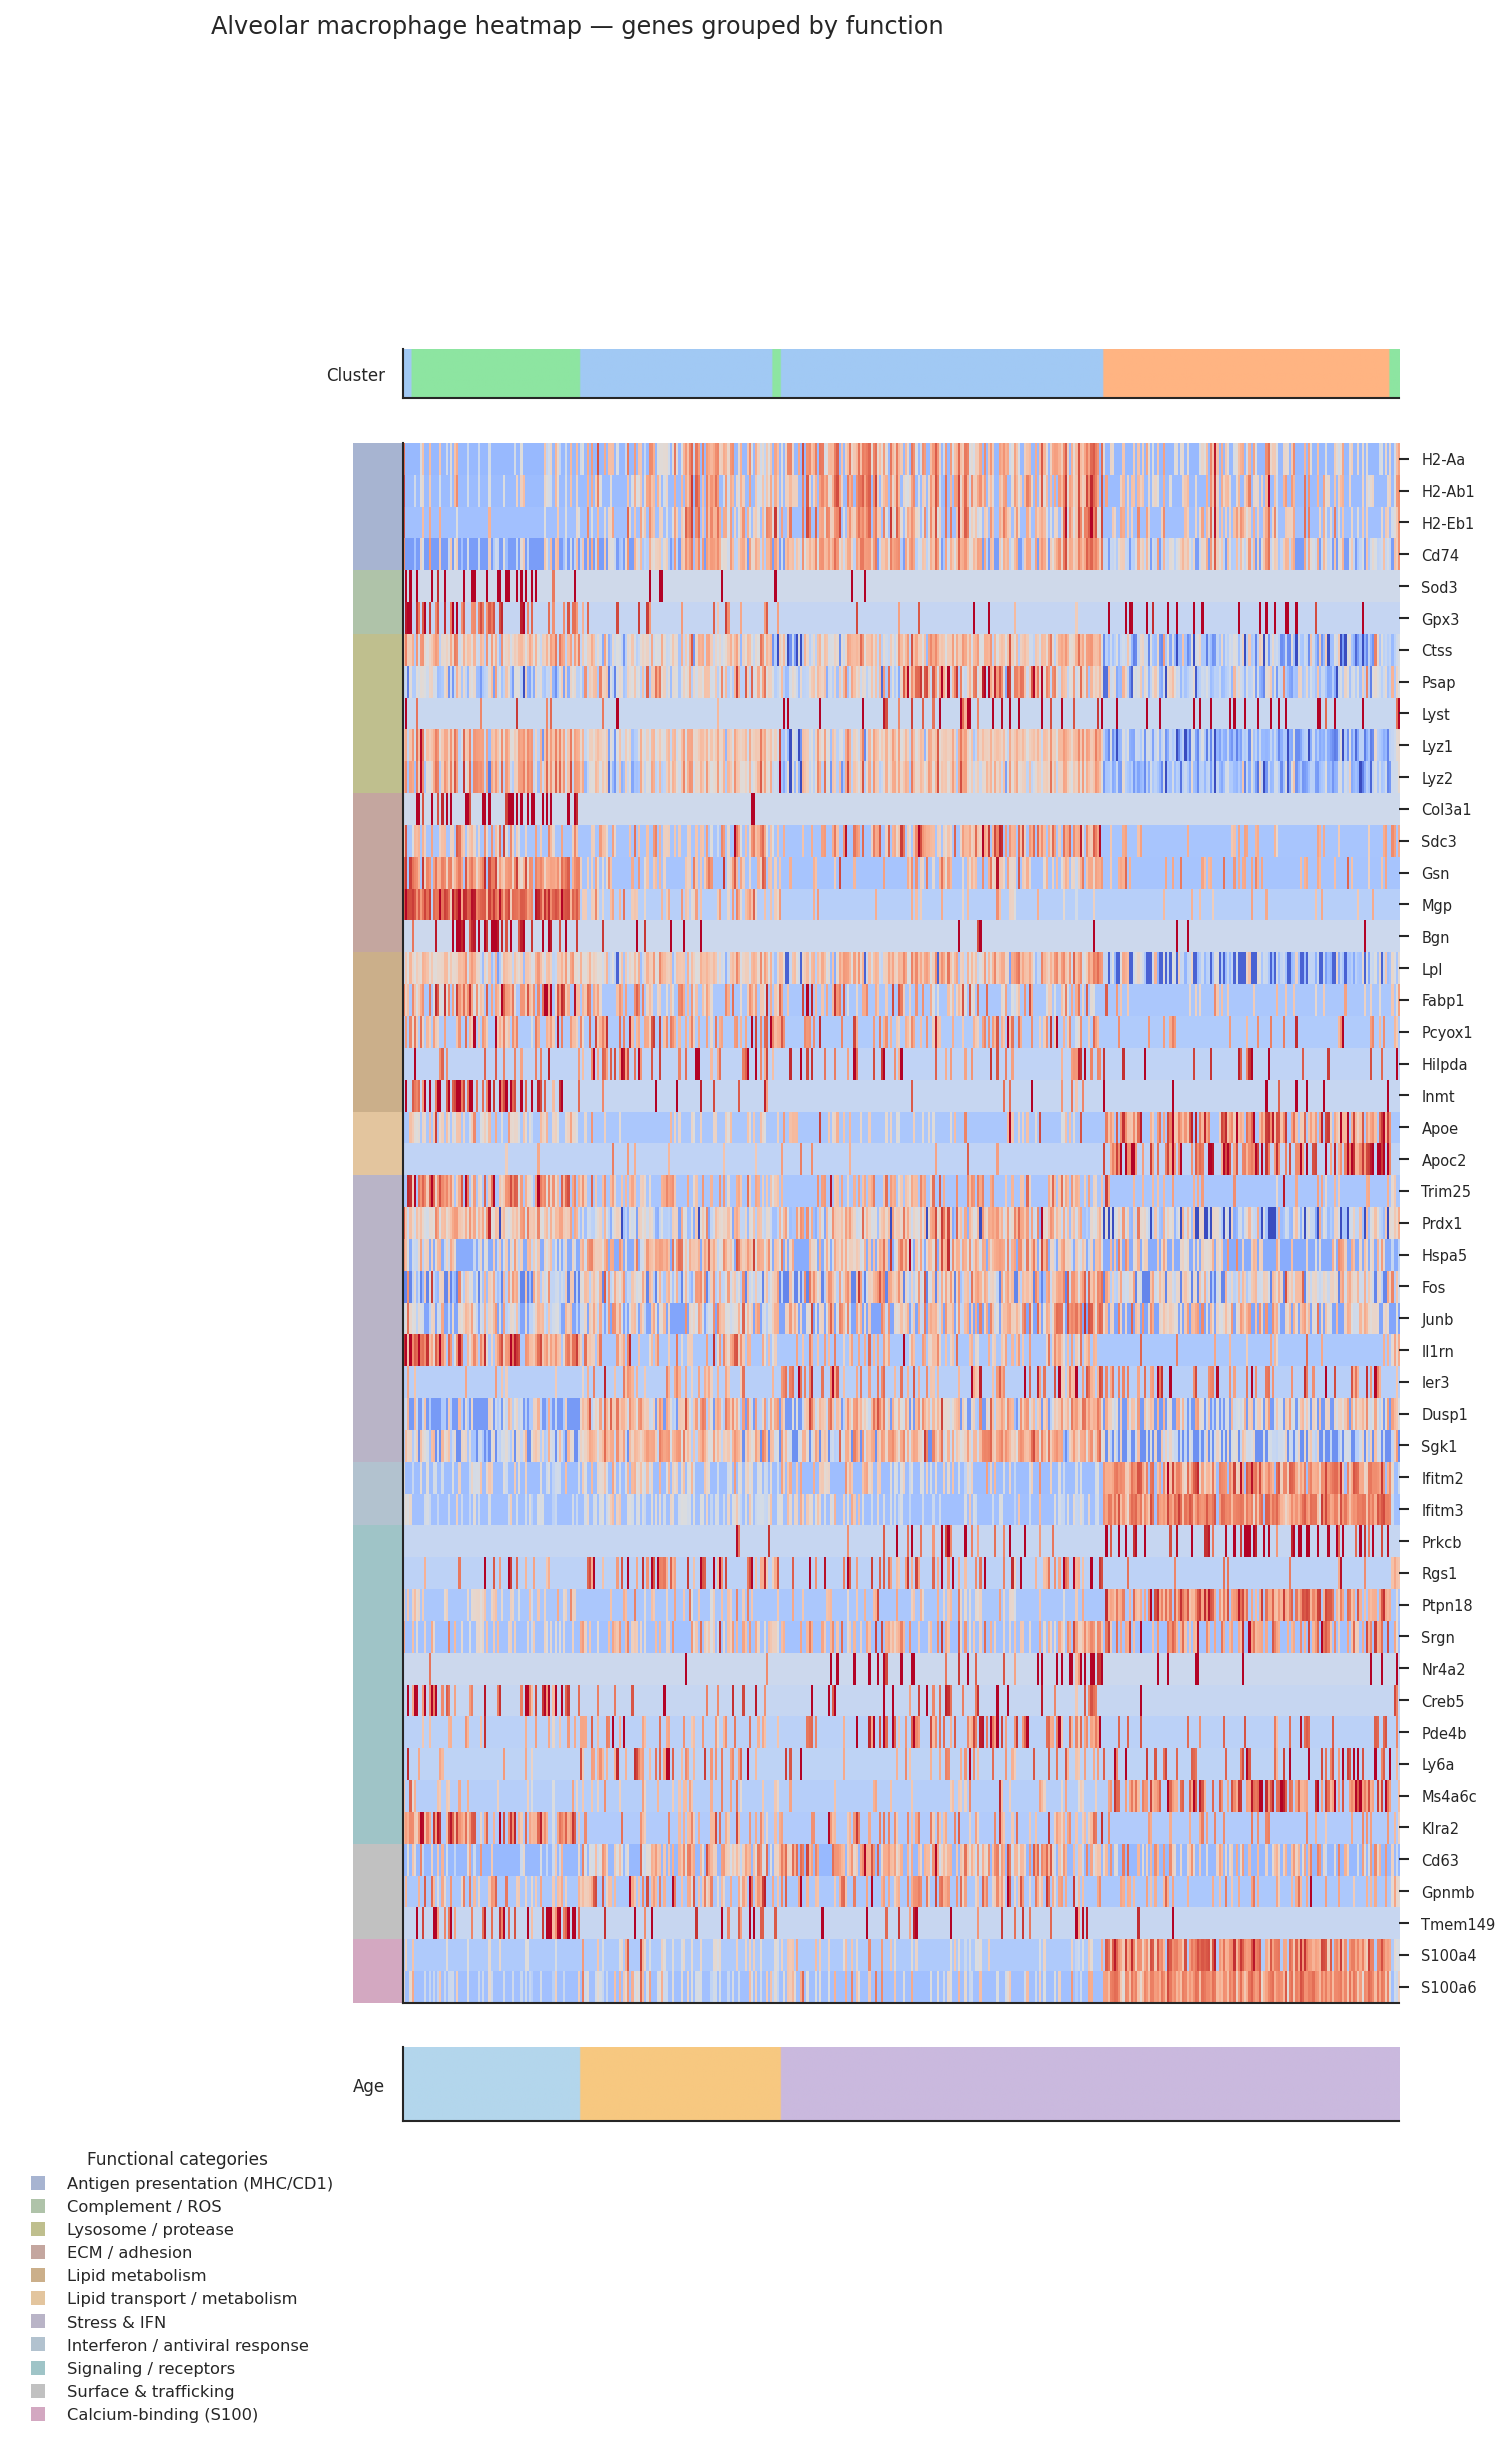

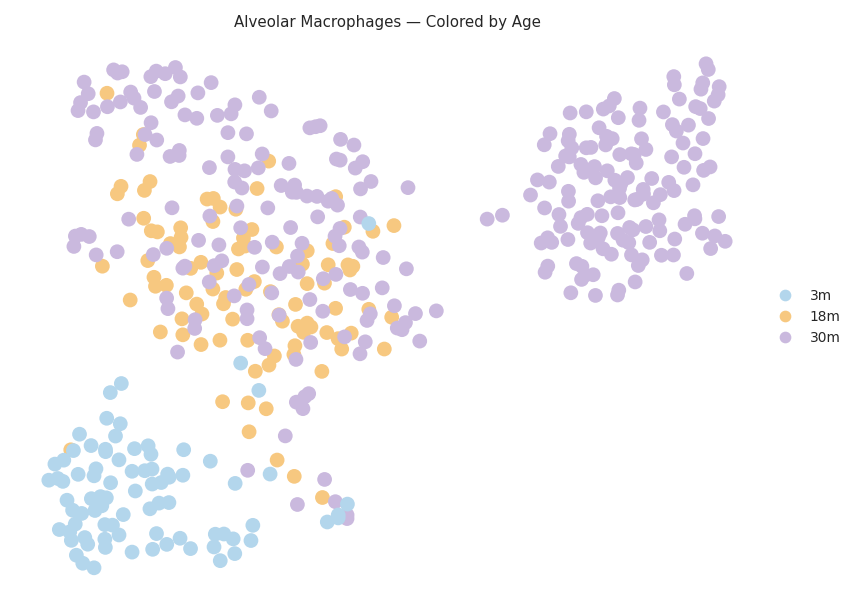

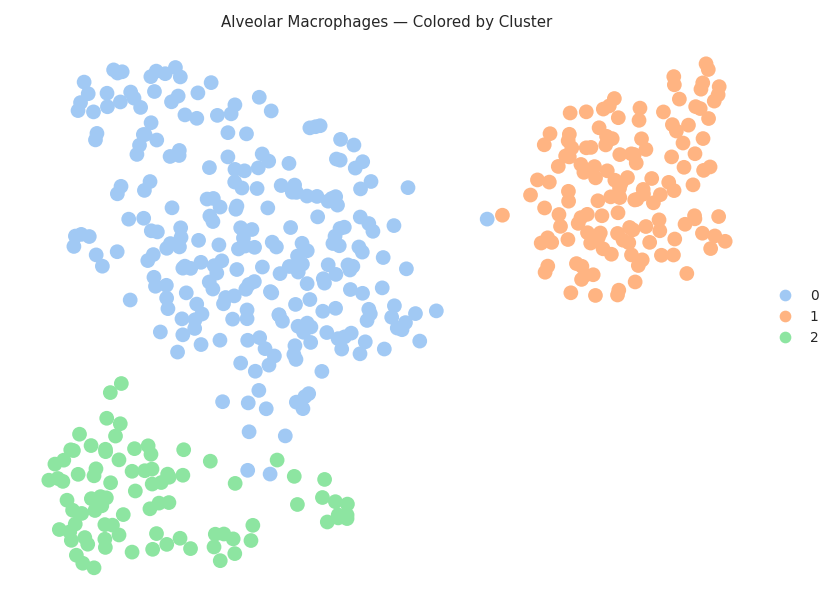

In [ ]:
###Functional heatmap for all alveolar macrophages tabula muris##

# ============================================================
# Alveolar Macrophage Heatmap + UMAPs
# - Genes grouped by functional category
# - Cluster bar (top), Age bar (bottom), Category strip (left)
# - Two UMAPs: colored by Age and by Cluster (muted palettes)
# ============================================================

import os, datetime as dt
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec

# ------------------ CONFIG ------------------
H5AD_PATH  = "/mnt/data/melhajjar/tabula_muris/all_tissues/Lung.h5ad"
OUTPUT_DIR = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy"

AGE_KEY = "age"
SEX_KEY = "sex"
CELLTYPE_KEY = "cell_ontology_class"
FILTER_CELLTYPE = "alveolar macrophage"
KEEP_SEX_VALUE = "male"
DROP_AGE_VALUES = {"1m"}
SHOW_GENE_LABELS = True

# ------------------ CATEGORY MAPPING ------------------
categories = {
    "Antigen presentation (MHC/CD1)": ["H2-Aa","H2-Ab1","H2-Eb1","H2-K1","Cd74"],
    "Complement / ROS": ["C5ar1","Cyba","Sod3","Gpx3","Ftl1","Fth1"],
    "Lysosome / protease": ["Ctsd","Ctss","Ctsl","Psap","Lyst","Atp6v0d2","Pld3","Lyz1","Lyz2"],
    "ECM / adhesion": ["Col3a1","Prelp","Mfap4","Anxa2","Tagln2","Sdc3","Capg","Gsn","Vim","Clec3b","Mgp","Bgn","F11r","Cd44"],
    "Lipid metabolism": ["Lpl","Fabp1","Lipa","Mgll","Abcg1","Pcyox1","Ech1","Hilpda","Inmt"],
    "Lipid transport / metabolism": ["Apoe","Apoc2"],
    "Stress & IFN": ["Trim25","Txn1","Prdx1","Hspa5","Hspa8","Hsp90aa1","Fos","Junb","Il1rn","Ier3","Dusp1","Sgk1","Tnfaip2"],
    "Interferon / antiviral response": ["Ifitm2","Ifitm3"],
    "Signaling / receptors": ["Fpr1","Prkcb","Rgs1","Wnk1","Akap5","Ptpn18","Capn2","Srgn","Nr4a2","Creb5","Tcf7l2","Adcy3","Pde4b","Ltc4s","Ly6a","Ms4a6c","Ms4a8a","Klra2"],
    "Surface & trafficking": ["Cd9","Cd63","Cd52","Cd302","Gpnmb","Tmem14c","Tmem149","Itm2b","Fxyd5"],
    "Calcium-binding (S100)": ["S100a11","S100a4","S100a6"]
}

pathway_colors = {
    "Antigen presentation (MHC/CD1)"   : "#A7B4D1",
    "Complement / ROS"                 : "#AFC3A9",
    "Lysosome / protease"              : "#BFBF8E",
    "ECM / adhesion"                   : "#C4A69F",
    "Lipid metabolism"                 : "#CBAF8A",
    "Lipid transport / metabolism"     : "#E3C59E",
    "Stress & IFN"                     : "#B9B4C7",
    "Interferon / antiviral response"  : "#B2C2CF",
    "Signaling / receptors"            : "#9FC4C7",
    "Surface & trafficking"            : "#C1C1C1",
    "Calcium-binding (S100)"           : "#D3A8C1"
}

# ------------------ LOAD DATA ------------------
adata = sc.read_h5ad(H5AD_PATH)
adata = adata[adata.obs[SEX_KEY] == KEEP_SEX_VALUE].copy()
adata = adata[~adata.obs[AGE_KEY].isin(DROP_AGE_VALUES)].copy()
adata = adata[adata.obs[CELLTYPE_KEY].str.lower() == FILTER_CELLTYPE.lower()].copy()

# ------------------ CLUSTERING & UMAP ------------------
if "leiden" not in adata.obs:
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True)
    sc.pp.scale(adata)
    sc.tl.pca(adata)
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)
    sc.tl.umap(adata)
    sc.tl.leiden(adata, resolution=0.2)
elif "X_umap" not in adata.obsm.keys():
    sc.tl.umap(adata)

# ------------------ EXTRACT GENES (GROUPED) ------------------
adata_genes = pd.Index(adata.var_names.astype(str))
final_gene_order = []
gene_categories = []

for cat, genes in categories.items():
    for g in genes:
        if g in adata_genes:
            final_gene_order.append(g)
            gene_categories.append(cat)

# Z-score normalization
X = adata[:, final_gene_order].X
X = X.toarray() if hasattr(X, "toarray") else np.asarray(X)
Z = ((X - X.mean(0)) / np.maximum(X.std(0), 1e-4)).T  # genes × cells

# ------------------ SORT CELLS ------------------
age_vals = adata.obs[AGE_KEY].astype(str).to_numpy()
cluster_vals = adata.obs["leiden"].astype(str).to_numpy()

def _to_month(s): return float(s[:-1]) if s.endswith("m") else float(s)
age_sorted = sorted(set(age_vals), key=_to_month)
order_cells = np.lexsort((cluster_vals, [age_sorted.index(a) for a in age_vals]))
Z = Z[:, order_cells]
age_vals_sorted = age_vals[order_cells]
cluster_vals_sorted = cluster_vals[order_cells]

# ------------------ COLOR MAPPINGS ------------------
def pastel_palette(classes):
    base = ["#B3D6EC", "#F7C880", "#CAB9DE"]
    return {c: base[i % len(base)] for i, c in enumerate(classes)}

age_pal = pastel_palette(age_sorted)

# --- Muted cluster palette ---
cluster_unique = sorted(set(cluster_vals_sorted), key=int)
cluster_colors = sns.color_palette("pastel", len(cluster_unique))
cluster_pal = {cl: cluster_colors[i] for i, cl in enumerate(cluster_unique)}

left_cols = [pathway_colors[cat] for cat in gene_categories]

# ------------------ HEATMAP FIGURE ------------------
n_genes, n_cells = Z.shape
h_main, h_cluster, h_age = max(2.0, min(0.26 * n_genes, 14.0)), 0.4, 0.6
w_fig = max(9.0, min(0.0035 * n_cells + 6.0, 22.0))

fig = plt.figure(figsize=(w_fig, h_main + h_cluster + h_age + 1.6))
gs = gridspec.GridSpec(3, 2, width_ratios=[0.05, 1], height_ratios=[h_cluster, h_main, h_age],
                       wspace=0, hspace=0.08)

# Cluster bar
ax_cluster = fig.add_subplot(gs[0,1])
cluster_cols = np.array([mpl.colors.to_rgb(cluster_pal[c]) for c in cluster_vals_sorted]).reshape(1,n_cells,3)
ax_cluster.imshow(cluster_cols, aspect="auto")
ax_cluster.set_yticks([0]); ax_cluster.set_yticklabels(["Cluster"], fontsize=8)
ax_cluster.set_xticks([]); [ax_cluster.spines[s].set_visible(False) for s in ["top","right"]]

# Category strip
ax_left = fig.add_subplot(gs[1,0])
left_rgb = np.array([mpl.colors.to_rgb(c) for c in left_cols]).reshape(n_genes,1,3)
ax_left.imshow(left_rgb, aspect="auto")
ax_left.set_xticks([]); ax_left.set_yticks([])
[ax_left.spines[s].set_visible(False) for s in ax_left.spines]

# Heatmap
ax = fig.add_subplot(gs[1,1])
ax.imshow(Z, aspect="auto", cmap="coolwarm", vmin=-2.5, vmax=2.5, interpolation="none")
ax.set_xticks([])
if SHOW_GENE_LABELS:
    ax.set_yticks(np.arange(n_genes))
    fs = 9 if n_genes <= 40 else 7 if n_genes <= 100 else 6
    ax.set_yticklabels(final_gene_order, fontsize=fs)
    ax.yaxis.tick_right(); ax.tick_params(axis='y', pad=6)
else:
    ax.set_yticks([])
[ax.spines[s].set_visible(False) for s in ["top","right"]]

# Age bar
ax_age = fig.add_subplot(gs[2,1])
age_cols = np.array([mpl.colors.to_rgb(age_pal[a]) for a in age_vals_sorted]).reshape(1,n_cells,3)
ax_age.imshow(age_cols, aspect="auto")
ax_age.set_yticks([0]); ax_age.set_yticklabels(["Age"], fontsize=8)
ax_age.set_xticks([]); [ax_age.spines[s].set_visible(False) for s in ["top","right"]]

# Legend
ax_leg = fig.add_subplot(gs[2,0]); ax_leg.axis("off")
handles = [plt.Line2D([0],[0],marker='s',linestyle='',markersize=7,
                      markerfacecolor=pathway_colors.get(cat,"#DDD"),markeredgecolor="none") 
           for cat in categories.keys()]
ax_leg.legend(handles, categories.keys(), title="Functional categories",
              loc="upper right", bbox_to_anchor=(-0.1,-0.2), frameon=False, fontsize=7.8, title_fontsize=8.2)

fig.suptitle("Alveolar macrophage heatmap — genes grouped by function", 
             x=0.02, y=1.015, ha="left", va="bottom", fontsize=11.5)
fig.tight_layout(rect=[0,0,0.985,0.985])

os.makedirs(OUTPUT_DIR, exist_ok=True)
ts = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
fig.savefig(os.path.join(OUTPUT_DIR, f"AM_FunctionalGrouped_Heatmap_{ts}.pdf"), bbox_inches="tight", dpi=500)
fig.savefig(os.path.join(OUTPUT_DIR, f"AM_FunctionalGrouped_Heatmap_{ts}.png"), bbox_inches="tight", dpi=500)
plt.show()

# ------------------ UMAPS ------------------
plt.rcParams.update({"axes.facecolor": "white", "figure.dpi": 150})
sc.pl.umap(adata, color=[AGE_KEY], palette=list(age_pal.values()), frameon=False,
           title="Alveolar Macrophages — Colored by Age", size=200,
           save="AM_cluster_age.png", show=True)

custom_palette = ["#FA8072", "#89CFF0", "#DDA0DD"]  # salmon, soft blue, light purple

sc.pl.umap(adata, color=["leiden"], palette=cluster_colors,
           title="Alveolar Macrophages — Colored by Cluster", size=200, frameon=False,
           save="_AM_cluster_{ts}.png", show=True)


/bioinformatics/miniconda3/envs/scanpy_env/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:210: UserWarning: When using a mask parameter with anndata<0.9 on a dense array, the PCAcan have slightly different results due the array being column major instead of row major.
  warnings.warn(
/tmp/ipykernel_8634/2077968598.py:211: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0,0,0.985,0.985])


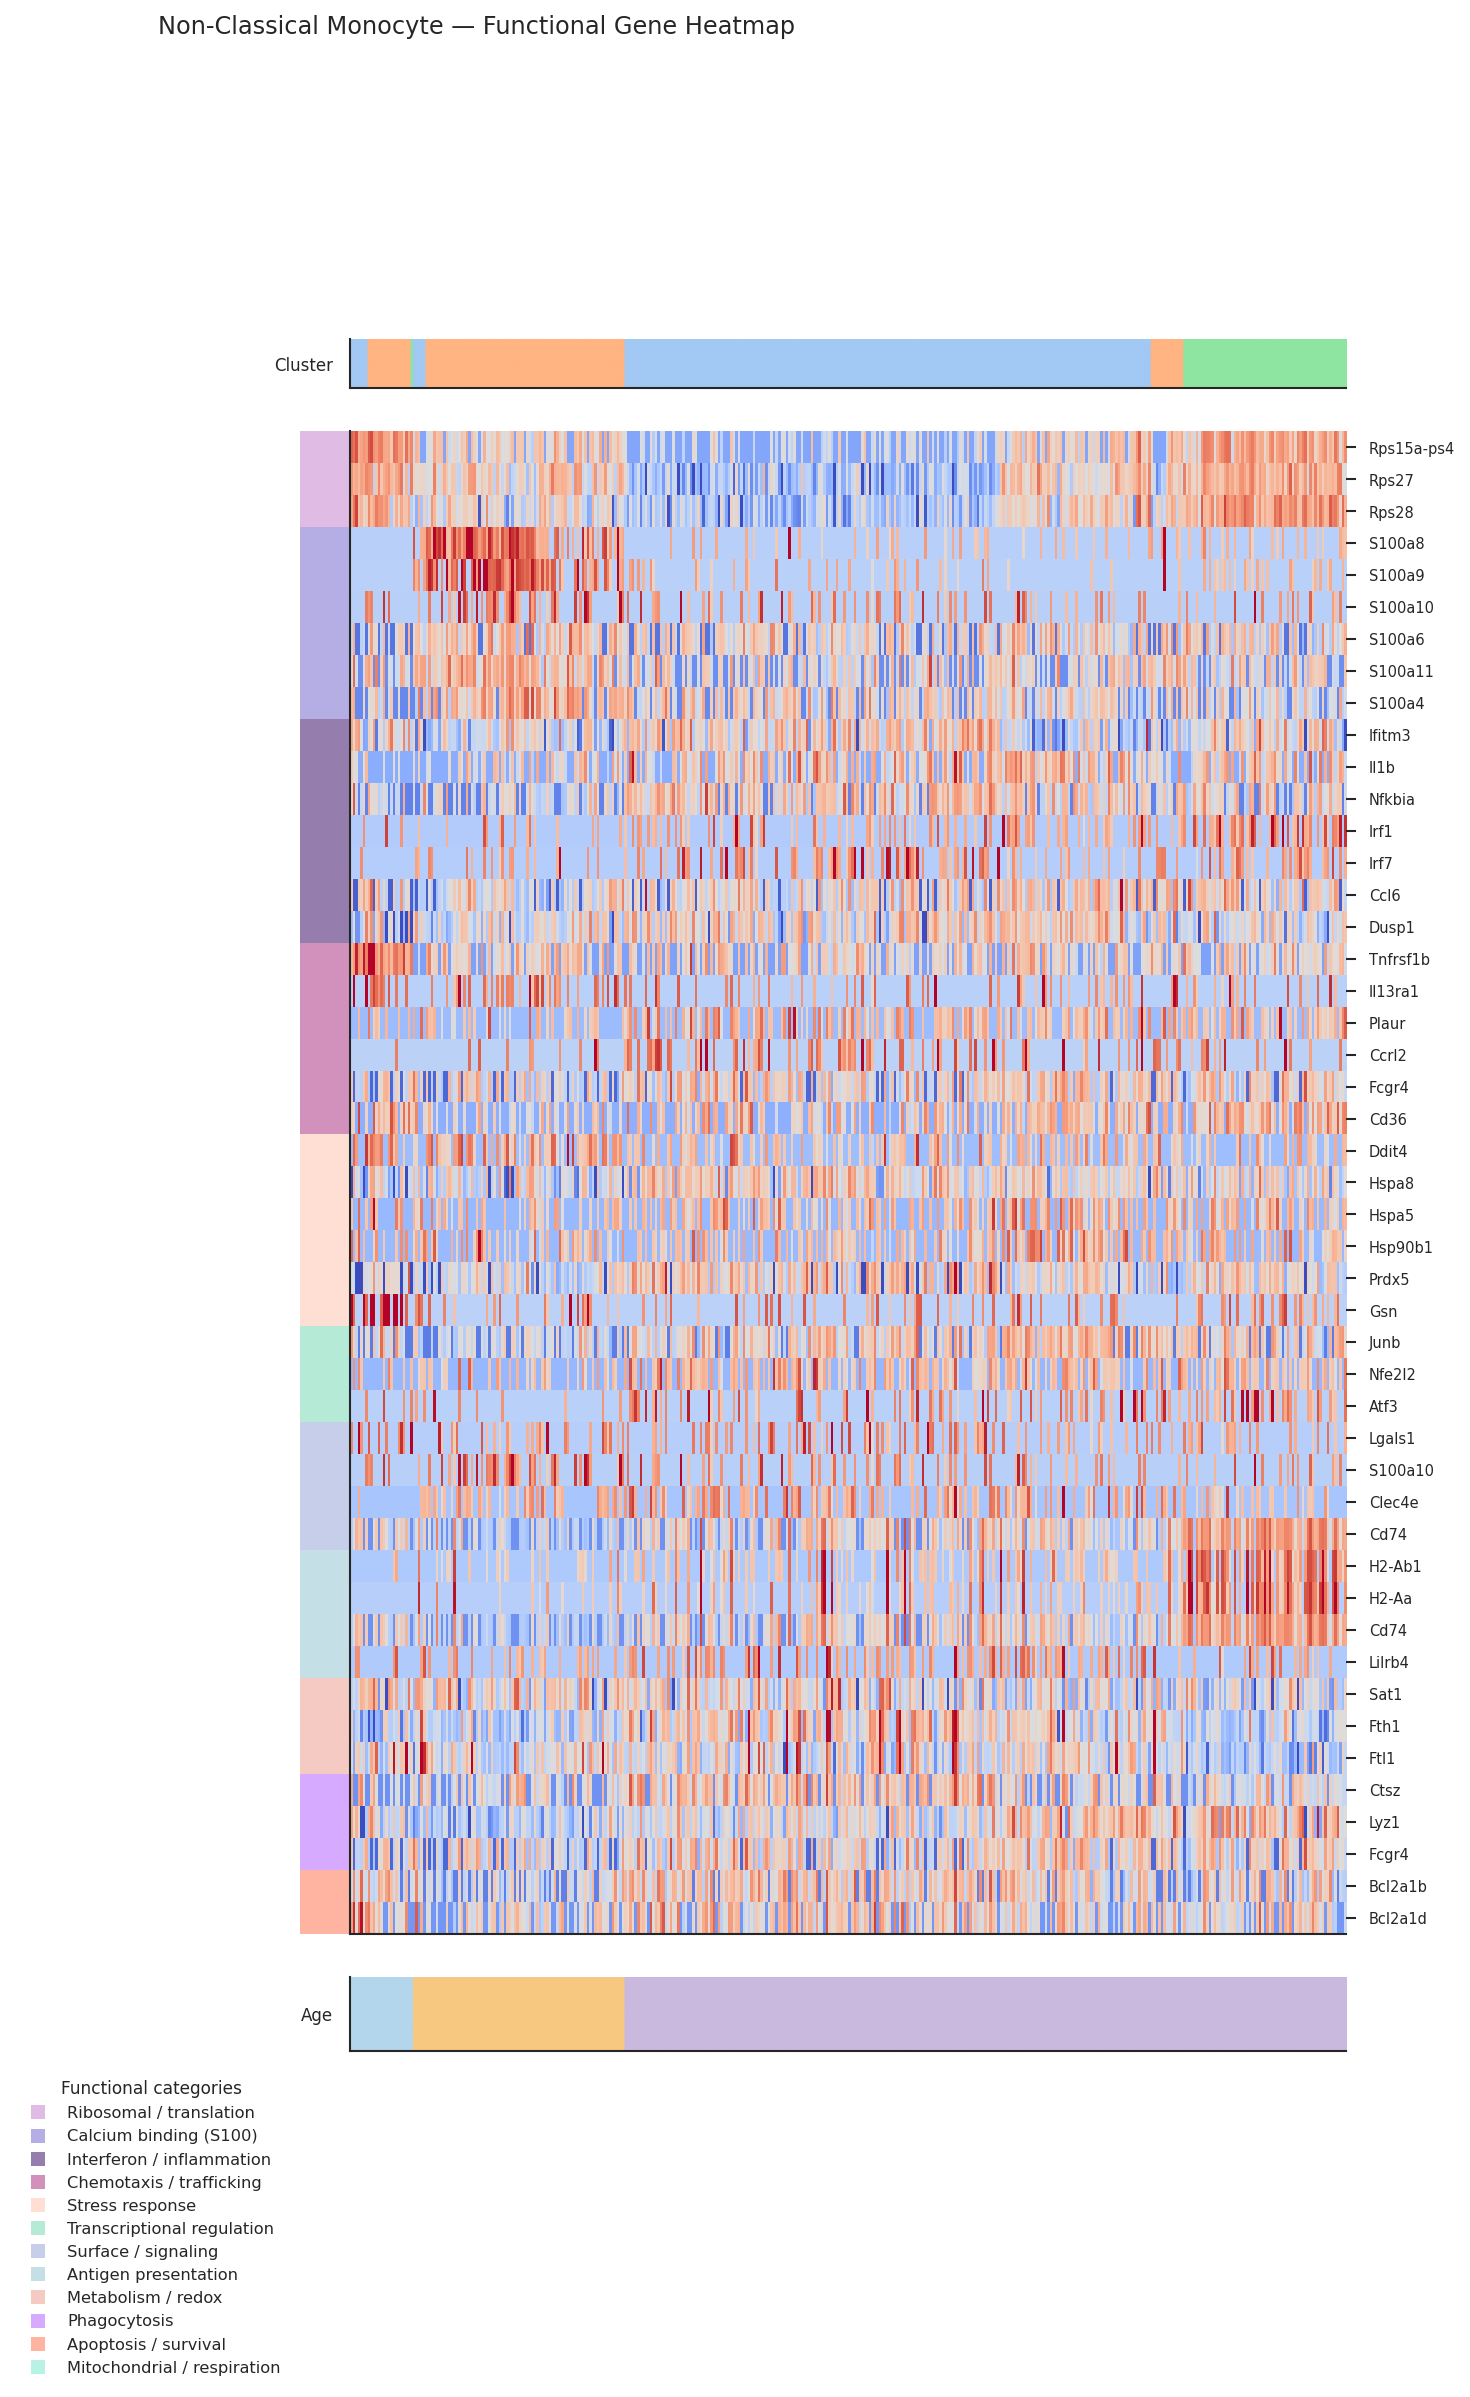

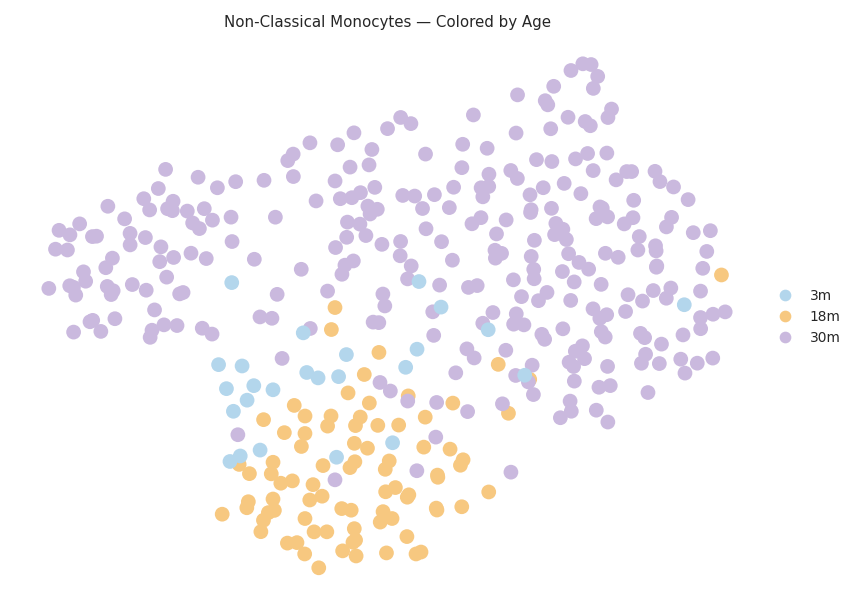

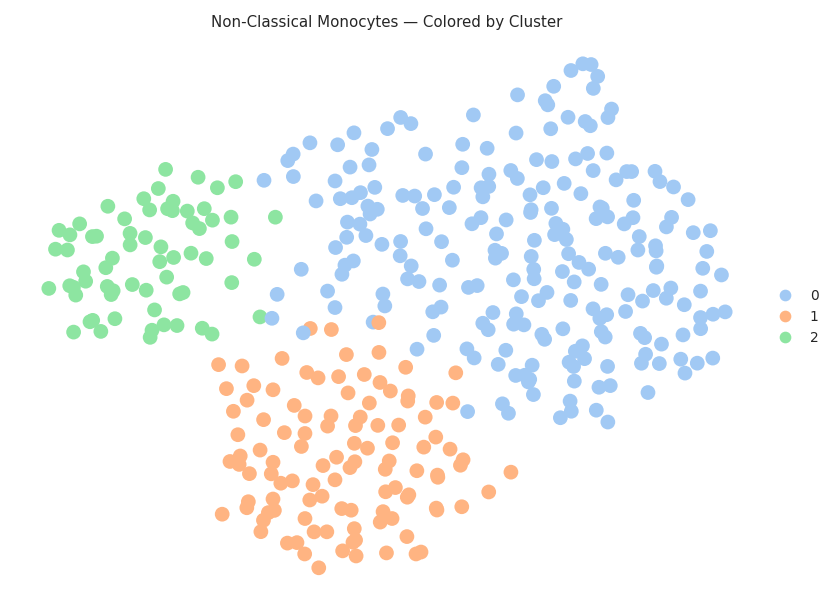

In [110]:
# ============================================================
# Non-Classical Monocyte Heatmap + UMAPs (Expanded Categories)
# ============================================================

import os, datetime as dt
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec

# ------------------ CONFIG ------------------
H5AD_PATH  = "/mnt/data/melhajjar/tabula_muris/all_tissues/Lung.h5ad"
OUTPUT_DIR = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy"

AGE_KEY = "age"
SEX_KEY = "sex"
CELLTYPE_KEY = "cell_ontology_class"
FILTER_CELLTYPE = "non-classical monocyte"
KEEP_SEX_VALUE = "male"
DROP_AGE_VALUES = {"1m"}
SHOW_GENE_LABELS = True

# ------------------ CATEGORY MAPPING ------------------
categories = {
    "Ribosomal / translation": [
        "Rps15a-ps4", "Rps27", "Rpl28", "Rpl37a", "Rpl37", "Rpl41", "Rpl32", 
        "Rpl36", "Rplp0", "Rps9", "Rpl7a", "Rps18", "Rps27a", "Rpl18", "Rps5", 
        "Rps28", "Rpl24"
    ],
    "Calcium binding (S100)": [
        "S100a8", "S100a9", "S100a10", "S100a6", "S100a11", "S100a4"
    ],
    "Interferon / inflammation": [
        "Ifitm3", "Il1b", "Nfkbia", "Irf1", "Irf7", "Ifitm1", 
        "Ccl6", "Ifitm6","Trim25", "Dusp1", "Ifitm1"
    ],
    "Chemotaxis / trafficking": [
        "Tnfrsf1b", "Il17ra", "Il13ra1", "Plaur", "Ccrl2", "Ccr7", "Itga4", "Trem2", 
        "Fcgr4", "Cd36", "Cd55"
    ],
    # "Lipid / membrane": [
    #     "Retnlg", "Ldlrad3", "Npc2", "Scarb1", "Pla2g7", "Cyp39a1", "Cd36"
    # ],
    "Stress response": [
        "Ddit4", "Hspa8", "Txn1", "Hspa5", "Hsp90b1", "Dnaja1", "Prdx5", "Prdx2", 
        "Gas5", "Gsn"
    ],
    "Transcriptional regulation": [
        "Junb", "Nfe2l2", "Cited2", "Atf3", "Klf3"
    ],
    "Surface / signaling": [
        "Lgals3", "Lgals1", "S100a10", "Anxa2", "Tlr4", "Clec4e", "Clec12a", 
        "Ceacam1", "Cd74", "Itgb7"
    ],
    "Antigen presentation": [
        "H2-Ab1", "H2-Eb2", "H2-Aa", "Cd74", "Lilrb3", "Lilrb4"
    ],
    "Metabolism / redox": [
        "Gapdh", "Eef2", "Gpi1", "Sat1", "Fth1", "Ftl1", "Cox4i1", "Cox5a", "Cox7c"
    ],
    # "Chaperones / proteostasis": [
    #     "Ubb", "Psap", "Hspa8", "Eif1ax", "Eif3e", "Btf3", "Naca", "Pabpc1"
    # ],
    "Phagocytosis": [
        "Mpeg1", "Ctss", "Ctsb", "Ctsd", "Ctsz", "Lyz1", "Lyz2", "Fcgr4"
    ],
    # "Cell adhesion / ECM": [
    #     "Fbn1", "Eln", "Tmsb10", "Actg1", "Tln1", "Itgb7"
    # ],
    "Apoptosis / survival": [
        "Bcl2a1b", "Bcl2a1d", "Mcl1", "Samhd1"
    ],
    "Mitochondrial / respiration": [
        "Cox4i1", "Cox5a", "Cox7c", "Cox7a2l", "Mrpl30", "Higd2a"
    ]
}

pathway_colors = {
    "Ribosomal / translation"        : "#E0BBE4",
    "Calcium binding (S100)"         : "#B5AEE4",
    "Interferon / inflammation"      : "#957DAD",
    "Chemotaxis / trafficking"       : "#D291BC",
    # "Lipid / membrane"               : "#FEC8D8",
    "Stress response"                : "#FFDFD3",
    "Transcriptional regulation"     : "#B5EAD7",
    "Surface / signaling"            : "#C7CEEA",
    "Antigen presentation"           : "#C4DFE6",
    "Metabolism / redox"             : "#F5CAC3",
    # "Chaperones / proteostasis"      : "#F6E2B3",
    "Phagocytosis"                   : "#D5AAFF",
    # "Cell adhesion / ECM"            : "#A3D2CA",
    "Apoptosis / survival"           : "#FFB4A2",
    "Mitochondrial / respiration"    : "#B8F2E6"
}


# ------------------ LOAD DATA ------------------
adata = sc.read_h5ad(H5AD_PATH)
adata = adata[adata.obs[SEX_KEY] == KEEP_SEX_VALUE].copy()
adata = adata[~adata.obs[AGE_KEY].isin(DROP_AGE_VALUES)].copy()
adata = adata[adata.obs[CELLTYPE_KEY].str.lower() == FILTER_CELLTYPE.lower()].copy()

# ------------------ CLUSTERING & UMAP ------------------
if "leiden" not in adata.obs:
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True)
    sc.pp.scale(adata)
    sc.tl.pca(adata)
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)
    sc.tl.umap(adata)
    sc.tl.leiden(adata, resolution=0.25)
elif "X_umap" not in adata.obsm.keys():
    sc.tl.umap(adata)

# ------------------ EXTRACT GENES (GROUPED) ------------------
adata_genes = pd.Index(adata.var_names.astype(str))
final_gene_order = []
gene_categories = []

for cat, genes in categories.items():
    for g in genes:
        if g in adata_genes:
            final_gene_order.append(g)
            gene_categories.append(cat)

# Z-score normalization
X = adata[:, final_gene_order].X
X = X.toarray() if hasattr(X, "toarray") else np.asarray(X)
Z = ((X - X.mean(0)) / np.maximum(X.std(0), 1e-4)).T  # genes × cells

# ------------------ SORT CELLS ------------------
age_vals = adata.obs[AGE_KEY].astype(str).to_numpy()
cluster_vals = adata.obs["leiden"].astype(str).to_numpy()

def _to_month(s): return float(s[:-1]) if s.endswith("m") else float(s)
age_sorted = sorted(set(age_vals), key=_to_month)
order_cells = np.lexsort((cluster_vals, [age_sorted.index(a) for a in age_vals]))
Z = Z[:, order_cells]
age_vals_sorted = age_vals[order_cells]
cluster_vals_sorted = cluster_vals[order_cells]

# ------------------ COLOR MAPPINGS ------------------
def pastel_palette(classes):
    base = ["#B3D6EC", "#F7C880", "#CAB9DE"]
    return {c: base[i % len(base)] for i, c in enumerate(classes)}

age_pal = pastel_palette(age_sorted)

cluster_unique = sorted(set(cluster_vals_sorted), key=int)
cluster_colors = sns.color_palette("pastel", len(cluster_unique))
cluster_pal = {cl: cluster_colors[i] for i, cl in enumerate(cluster_unique)}
left_cols = [pathway_colors[cat] for cat in gene_categories]

# ------------------ HEATMAP FIGURE ------------------
n_genes, n_cells = Z.shape
h_main, h_cluster, h_age = max(2.0, min(0.26 * n_genes, 14.0)), 0.4, 0.6
w_fig = max(9.0, min(0.0035 * n_cells + 6.0, 22.0))

fig = plt.figure(figsize=(w_fig, h_main + h_cluster + h_age + 1.6))
gs = gridspec.GridSpec(3, 2, width_ratios=[0.05, 1], height_ratios=[h_cluster, h_main, h_age],
                       wspace=0, hspace=0.08)

# Cluster bar
ax_cluster = fig.add_subplot(gs[0,1])
cluster_cols = np.array([mpl.colors.to_rgb(cluster_pal[c]) for c in cluster_vals_sorted]).reshape(1,n_cells,3)
ax_cluster.imshow(cluster_cols, aspect="auto")
ax_cluster.set_yticks([0]); ax_cluster.set_yticklabels(["Cluster"], fontsize=8)
ax_cluster.set_xticks([]); [ax_cluster.spines[s].set_visible(False) for s in ["top","right"]]

# Category strip
ax_left = fig.add_subplot(gs[1,0])
left_rgb = np.array([mpl.colors.to_rgb(c) for c in left_cols]).reshape(n_genes,1,3)
ax_left.imshow(left_rgb, aspect="auto")
ax_left.set_xticks([]); ax_left.set_yticks([])
[ax_left.spines[s].set_visible(False) for s in ax_left.spines]

# Heatmap
ax = fig.add_subplot(gs[1,1])
ax.imshow(Z, aspect="auto", cmap="coolwarm", vmin=-2.5, vmax=2.5, interpolation="none")
ax.set_xticks([])
if SHOW_GENE_LABELS:
    ax.set_yticks(np.arange(n_genes))
    fs = 9 if n_genes <= 40 else 7 if n_genes <= 100 else 6
    ax.set_yticklabels(final_gene_order, fontsize=fs)
    ax.yaxis.tick_right(); ax.tick_params(axis='y', pad=6)
else:
    ax.set_yticks([])
[ax.spines[s].set_visible(False) for s in ["top","right"]]

# Age bar
ax_age = fig.add_subplot(gs[2,1])
age_cols = np.array([mpl.colors.to_rgb(age_pal[a]) for a in age_vals_sorted]).reshape(1,n_cells,3)
ax_age.imshow(age_cols, aspect="auto")
ax_age.set_yticks([0]); ax_age.set_yticklabels(["Age"], fontsize=8)
ax_age.set_xticks([]); [ax_age.spines[s].set_visible(False) for s in ["top","right"]]

# Legend
ax_leg = fig.add_subplot(gs[2,0]); ax_leg.axis("off")
handles = [plt.Line2D([0],[0],marker='s',linestyle='',markersize=7,
                      markerfacecolor=pathway_colors.get(cat,"#DDD"),markeredgecolor="none") 
           for cat in categories.keys()]
ax_leg.legend(handles, categories.keys(), title="Functional categories",
              loc="upper right", bbox_to_anchor=(-0.1,-0.2), frameon=False, fontsize=7.8, title_fontsize=8.2)

fig.suptitle("Non-Classical Monocyte — Functional Gene Heatmap", 
             x=0.02, y=1.015, ha="left", va="bottom", fontsize=11.5)
fig.tight_layout(rect=[0,0,0.985,0.985])

os.makedirs(OUTPUT_DIR, exist_ok=True)
ts = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
fig.savefig(os.path.join(OUTPUT_DIR, f"NCMono_FunctionalGrouped_Heatmap_{ts}.pdf"), bbox_inches="tight", dpi=500)
fig.savefig(os.path.join(OUTPUT_DIR, f"NCMono_FunctionalGrouped_Heatmap_{ts}.png"), bbox_inches="tight", dpi=500)
plt.show()

# ------------------ UMAPS ------------------
plt.rcParams.update({"axes.facecolor": "white", "figure.dpi": 150})
sc.pl.umap(adata, color=[AGE_KEY], palette=list(age_pal.values()), frameon=False,
           title="Non-Classical Monocytes — Colored by Age", size=200,
           save="_NCMono_cluster_age.png", show=True)

sc.pl.umap(adata, color=["leiden"], palette=cluster_colors,
           title="Non-Classical Monocytes — Colored by Cluster", size=200, frameon=False,
           save="_NCMono_cluster_leiden.png", show=True)


/bioinformatics/miniconda3/envs/scanpy_env/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:210: UserWarning: When using a mask parameter with anndata<0.9 on a dense array, the PCAcan have slightly different results due the array being column major instead of row major.
  warnings.warn(
/tmp/ipykernel_8634/1355044194.py:207: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0,0,0.985,0.985])


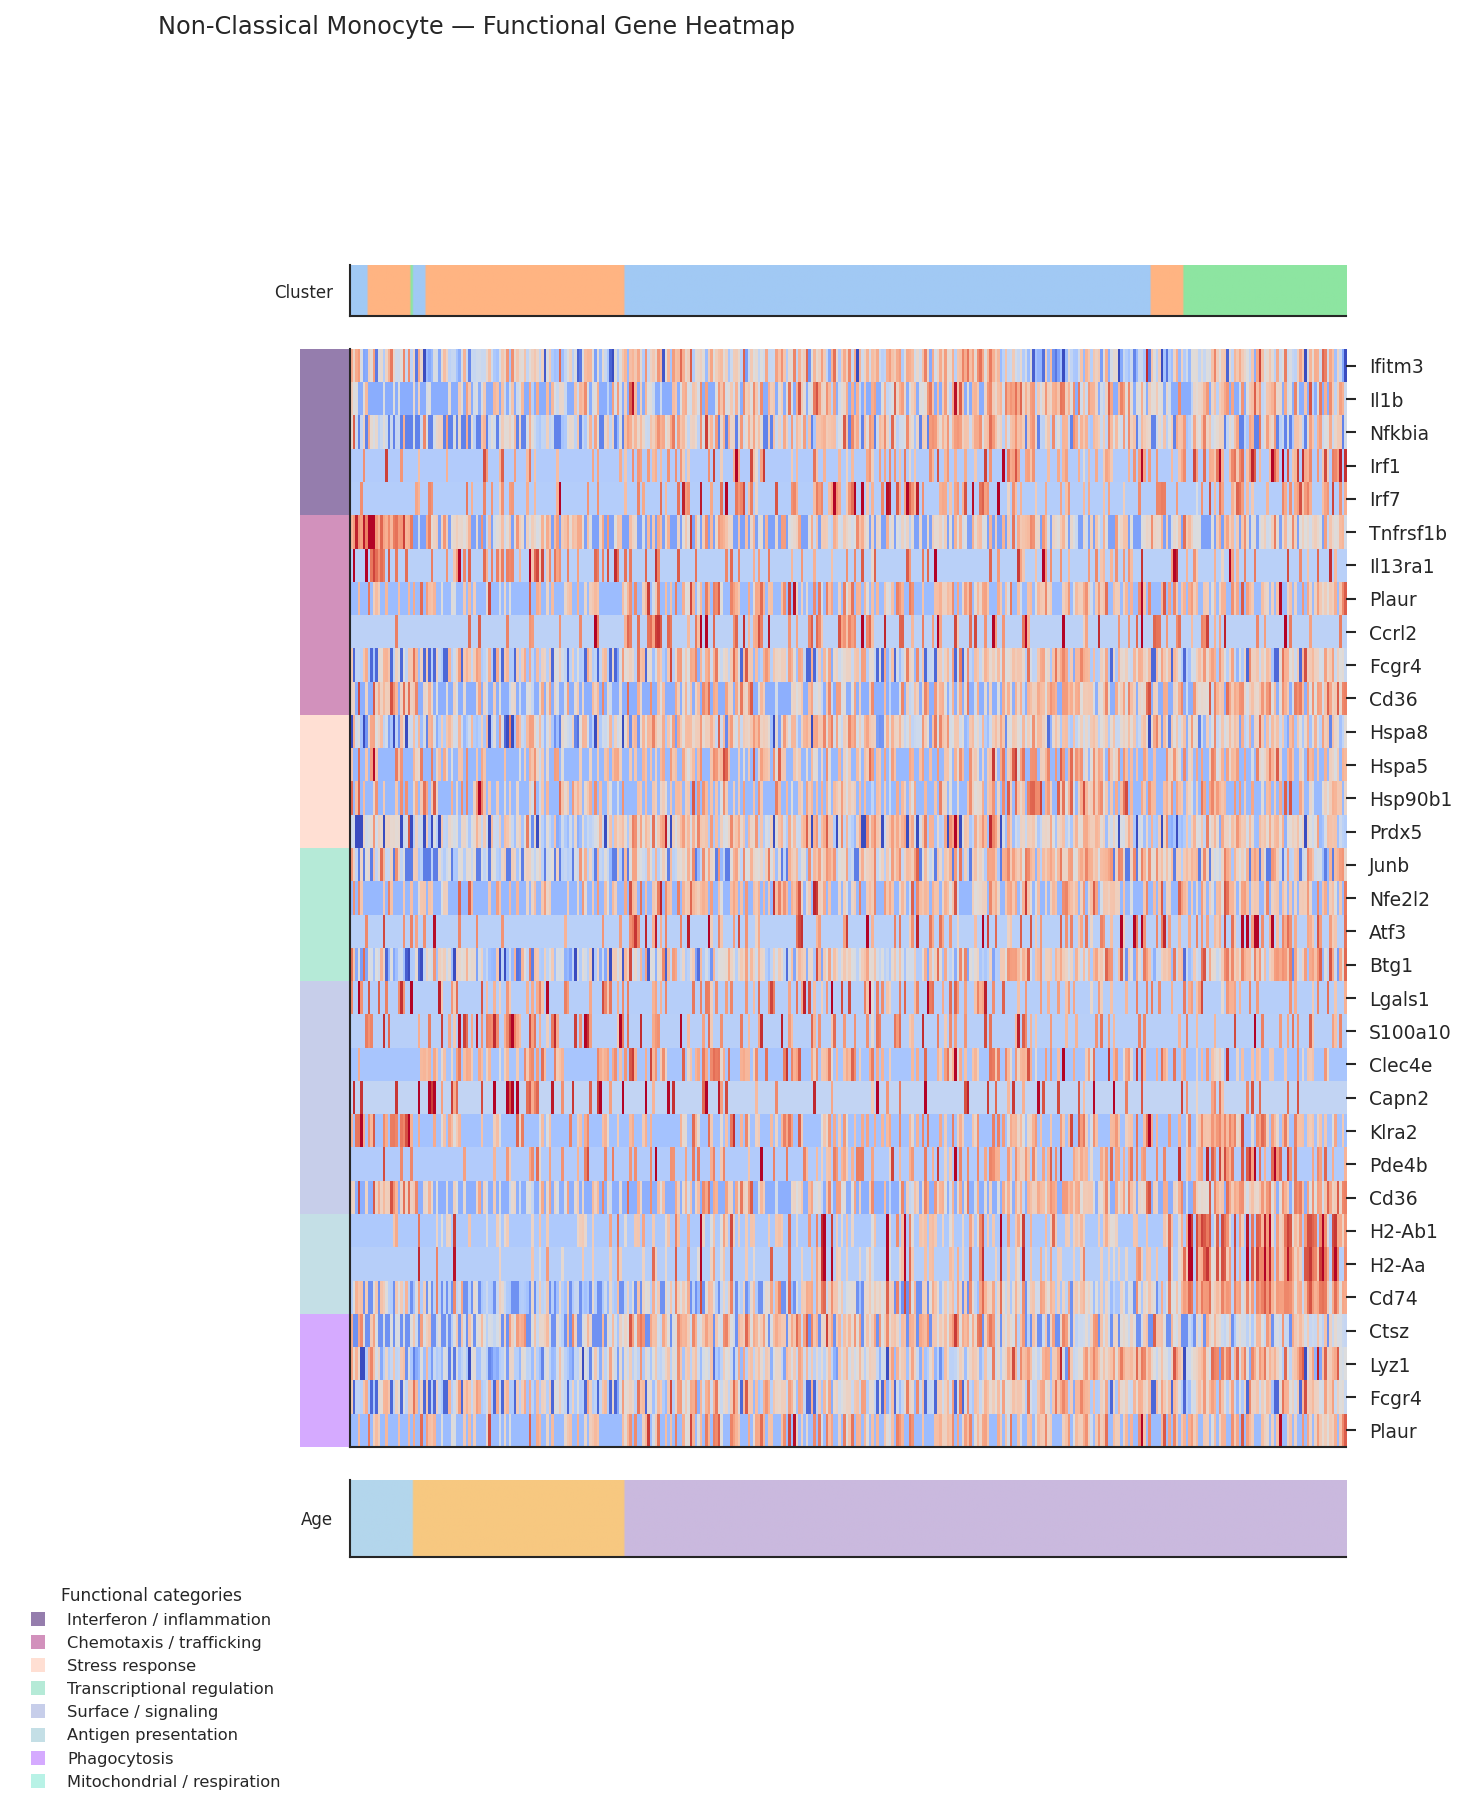

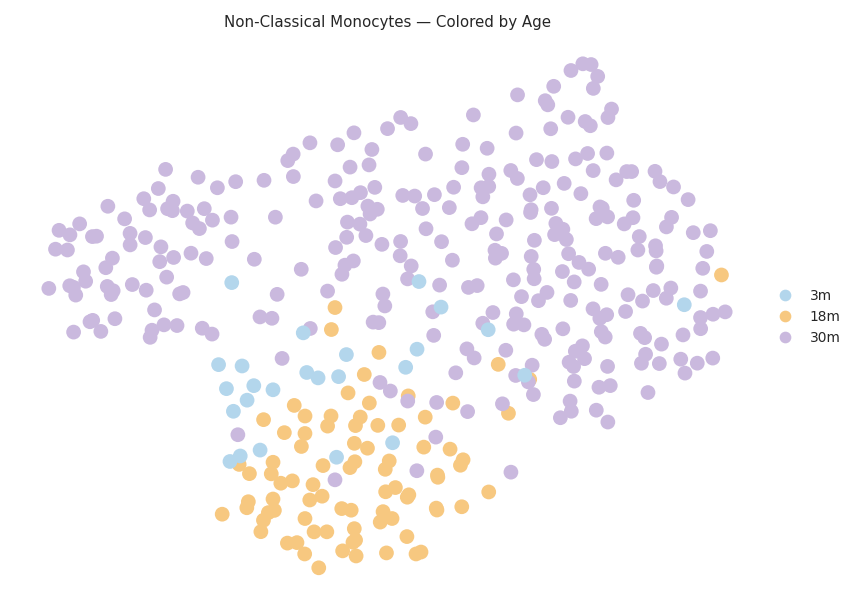

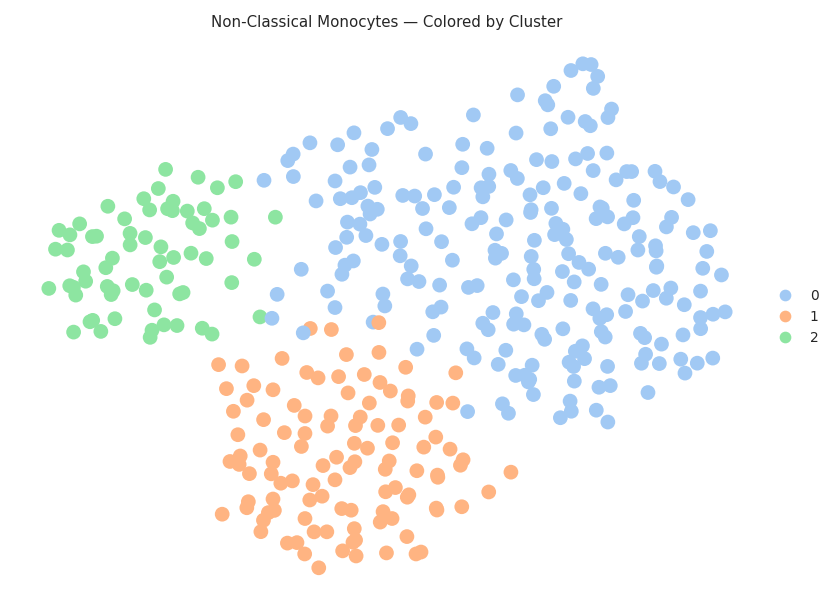

In [122]:
# ============================================================
# Non-Classical Monocyte Heatmap + UMAPs (Expanded Categories)
# ============================================================

import os, datetime as dt
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec

# ------------------ CONFIG ------------------
H5AD_PATH  = "/mnt/data/melhajjar/tabula_muris/all_tissues/Lung.h5ad"
OUTPUT_DIR = "/mnt/data/melhajjar/tabula_muris/all_tissues/scanvi_age_features_regression_model_final5_test2final_PLS_no1m_pres_final_workingcopy"

AGE_KEY = "age"
SEX_KEY = "sex"
CELLTYPE_KEY = "cell_ontology_class"
FILTER_CELLTYPE = "non-classical monocyte"
KEEP_SEX_VALUE = "male"
DROP_AGE_VALUES = {"1m"}
SHOW_GENE_LABELS = True

# ------------------ CATEGORY MAPPING ------------------
# ------------------ CATEGORY MAPPING ------------------
categories = {
    # "Ribosomal / translation": [
    #     "Rps15a-ps4", "Rps27", "Rpl28", "Rpl37a", "Rpl37", "Rpl41", "Rpl32", 
    #     "Rpl36", "Rplp0", "Rps9", "Rpl7a", "Rps18", "Rps27a", "Rpl18", "Rps5", 
    #     "Rps28", "Rpl24"
    # ],
    # "Calcium binding (S100)": [
    #     "S100a8", "S100a9", "S100a10", "S100a6", "S100a11", "S100a4"
    # ],
    "Interferon / inflammation": [
        "Ifitm3", "Il1b", "Nfkbia", "Irf1", "Irf7", "Ifitm1", 
        "Ifitm6", "Trim25"
    ],
    "Chemotaxis / trafficking": [
        "Tnfrsf1b", "Il17ra", "Il13ra1", "Plaur", "Ccrl2", "Ccr7", 
        "Itga4", "Trem2", "Fcgr4", "Cd36", "Cd55"
    ],
    "Stress response": [
        "Hspa8", "Txn1", "Hspa5", "Hsp90b1", "Dnaja1", 
        "Prdx5", "Prdx2", "Gas5"
    ],
    "Transcriptional regulation": [
        "Junb", "Nfe2l2", "Cited2", "Atf3", "Klf3", "Tpt1", "Jmjd7", 
        "Btg1", "Myeov2", "Naca"
    ],
    "Surface / signaling": [
        "Lgals3", "Lgals1", "S100a10", "Anxa2", "Tlr4", "Clec4e", 
        "Clec12a", "Ceacam1", "Itgb7", "Capn2", "Klra2", 
        "Pde4b", "Tmem167", "Cd36", "Cd55"
    ],
    "Antigen presentation": [
        "H2-Ab1", "H2-Eb2", "H2-Aa", "Cd74"
    ],
    # "Metabolism / redox": [
    #     "Gapdh", "Eef2", "Gpi1", "Sat1", "Fth1", "Ftl1", "Cox4i1", 
    #     "Cox5a", "Cox7c", "Cox7a2l", "Mrpl30", "Higd2a", "Slc25a4", 
    #     "Slc25a5", "Ak2", "Gda", "Alox5ap", "Txn1", "Gyk"
    # ],
    "Phagocytosis": [
        "Mpeg1", "Ctss", "Ctsb", "Ctsd", "Ctsz", "Lyz1", "Lyz2", 
        "Fcgr4", "Plaur", "Trem2", "Cd55"
    ],
    # "Apoptosis / survival": [
    #     "Bcl2a1b", "Bcl2a1d", "Mcl1", "Samhd1", "Ptpn1", "Serping1", "Akna"
    # ],
    "Mitochondrial / respiration": [
        "Cox4i1", "Cox5a", "Cox7c", "Cox7a2l", "Mrpl30", "Higd2a", 
        "Slc25a4", "Slc25a5"
    ]
}

pathway_colors = {
    # "Ribosomal / translation"        : "#E0BBE4",
    # "Calcium binding (S100)"         : "#B5AEE4",
    "Interferon / inflammation"      : "#957DAD",
    "Chemotaxis / trafficking"       : "#D291BC",
    "Stress response"                : "#FFDFD3",
    "Transcriptional regulation"     : "#B5EAD7",
    "Surface / signaling"            : "#C7CEEA",
    "Antigen presentation"           : "#C4DFE6",
    # "Metabolism / redox"             : "#F5CAC3",
    "Phagocytosis"                   : "#D5AAFF",
    # "Apoptosis / survival"           : "#FFB4A2",
    "Mitochondrial / respiration"    : "#B8F2E6"
}



# ------------------ LOAD DATA ------------------
adata = sc.read_h5ad(H5AD_PATH)
adata = adata[adata.obs[SEX_KEY] == KEEP_SEX_VALUE].copy()
adata = adata[~adata.obs[AGE_KEY].isin(DROP_AGE_VALUES)].copy()
adata = adata[adata.obs[CELLTYPE_KEY].str.lower() == FILTER_CELLTYPE.lower()].copy()

# ------------------ CLUSTERING & UMAP ------------------
if "leiden" not in adata.obs:
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True)
    sc.pp.scale(adata)
    sc.tl.pca(adata)
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)
    sc.tl.umap(adata)
    sc.tl.leiden(adata, resolution=0.25)
elif "X_umap" not in adata.obsm.keys():
    sc.tl.umap(adata)

# ------------------ EXTRACT GENES (GROUPED) ------------------
adata_genes = pd.Index(adata.var_names.astype(str))
final_gene_order = []
gene_categories = []

for cat, genes in categories.items():
    for g in genes:
        if g in adata_genes:
            final_gene_order.append(g)
            gene_categories.append(cat)

# Z-score normalization
X = adata[:, final_gene_order].X
X = X.toarray() if hasattr(X, "toarray") else np.asarray(X)
Z = ((X - X.mean(0)) / np.maximum(X.std(0), 1e-4)).T  # genes × cells

# ------------------ SORT CELLS ------------------
age_vals = adata.obs[AGE_KEY].astype(str).to_numpy()
cluster_vals = adata.obs["leiden"].astype(str).to_numpy()

def _to_month(s): return float(s[:-1]) if s.endswith("m") else float(s)
age_sorted = sorted(set(age_vals), key=_to_month)
order_cells = np.lexsort((cluster_vals, [age_sorted.index(a) for a in age_vals]))
Z = Z[:, order_cells]
age_vals_sorted = age_vals[order_cells]
cluster_vals_sorted = cluster_vals[order_cells]

# ------------------ COLOR MAPPINGS ------------------
def pastel_palette(classes):
    base = ["#B3D6EC", "#F7C880", "#CAB9DE"]
    return {c: base[i % len(base)] for i, c in enumerate(classes)}

age_pal = pastel_palette(age_sorted)

cluster_unique = sorted(set(cluster_vals_sorted), key=int)
cluster_colors = sns.color_palette("pastel", len(cluster_unique))
cluster_pal = {cl: cluster_colors[i] for i, cl in enumerate(cluster_unique)}
left_cols = [pathway_colors[cat] for cat in gene_categories]

# ------------------ HEATMAP FIGURE ------------------
n_genes, n_cells = Z.shape
h_main, h_cluster, h_age = max(2.0, min(0.26 * n_genes, 14.0)), 0.4, 0.6
w_fig = max(9.0, min(0.0035 * n_cells + 6.0, 22.0))

fig = plt.figure(figsize=(w_fig, h_main + h_cluster + h_age + 1.6))
gs = gridspec.GridSpec(3, 2, width_ratios=[0.05, 1], height_ratios=[h_cluster, h_main, h_age],
                       wspace=0, hspace=0.08)

# Cluster bar
ax_cluster = fig.add_subplot(gs[0,1])
cluster_cols = np.array([mpl.colors.to_rgb(cluster_pal[c]) for c in cluster_vals_sorted]).reshape(1,n_cells,3)
ax_cluster.imshow(cluster_cols, aspect="auto")
ax_cluster.set_yticks([0]); ax_cluster.set_yticklabels(["Cluster"], fontsize=8)
ax_cluster.set_xticks([]); [ax_cluster.spines[s].set_visible(False) for s in ["top","right"]]

# Category strip
ax_left = fig.add_subplot(gs[1,0])
left_rgb = np.array([mpl.colors.to_rgb(c) for c in left_cols]).reshape(n_genes,1,3)
ax_left.imshow(left_rgb, aspect="auto")
ax_left.set_xticks([]); ax_left.set_yticks([])
[ax_left.spines[s].set_visible(False) for s in ax_left.spines]

# Heatmap
ax = fig.add_subplot(gs[1,1])
ax.imshow(Z, aspect="auto", cmap="coolwarm", vmin=-2.5, vmax=2.5, interpolation="none")
ax.set_xticks([])
if SHOW_GENE_LABELS:
    ax.set_yticks(np.arange(n_genes))
    fs = 9 if n_genes <= 40 else 7 if n_genes <= 100 else 6
    ax.set_yticklabels(final_gene_order, fontsize=fs)
    ax.yaxis.tick_right(); ax.tick_params(axis='y', pad=6)
else:
    ax.set_yticks([])
[ax.spines[s].set_visible(False) for s in ["top","right"]]

# Age bar
ax_age = fig.add_subplot(gs[2,1])
age_cols = np.array([mpl.colors.to_rgb(age_pal[a]) for a in age_vals_sorted]).reshape(1,n_cells,3)
ax_age.imshow(age_cols, aspect="auto")
ax_age.set_yticks([0]); ax_age.set_yticklabels(["Age"], fontsize=8)
ax_age.set_xticks([]); [ax_age.spines[s].set_visible(False) for s in ["top","right"]]

# Legend
ax_leg = fig.add_subplot(gs[2,0]); ax_leg.axis("off")
handles = [plt.Line2D([0],[0],marker='s',linestyle='',markersize=7,
                      markerfacecolor=pathway_colors.get(cat,"#DDD"),markeredgecolor="none") 
           for cat in categories.keys()]
ax_leg.legend(handles, categories.keys(), title="Functional categories",
              loc="upper right", bbox_to_anchor=(-0.1,-0.2), frameon=False, fontsize=7.8, title_fontsize=8.2)

fig.suptitle("Non-Classical Monocyte — Functional Gene Heatmap", 
             x=0.02, y=1.015, ha="left", va="bottom", fontsize=11.5)
fig.tight_layout(rect=[0,0,0.985,0.985])

os.makedirs(OUTPUT_DIR, exist_ok=True)
ts = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
fig.savefig(os.path.join(OUTPUT_DIR, f"NCMono_FunctionalGrouped_Heatmap_{ts}.pdf"), bbox_inches="tight", dpi=500)
fig.savefig(os.path.join(OUTPUT_DIR, f"NCMono_FunctionalGrouped_Heatmap_{ts}.png"), bbox_inches="tight", dpi=500)
plt.show()

# ------------------ UMAPS ------------------
plt.rcParams.update({"axes.facecolor": "white", "figure.dpi": 150})
sc.pl.umap(adata, color=[AGE_KEY], palette=list(age_pal.values()), frameon=False,
           title="Non-Classical Monocytes — Colored by Age", size=200,
           save="_NCMono_cluster_age.png", show=True)

sc.pl.umap(adata, color=["leiden"], palette=cluster_colors,
           title="Non-Classical Monocytes — Colored by Cluster", size=200, frameon=False,
           save="_NCMono_cluster_leiden.png", show=True)


cluster_df shape: (2, 2)
edges_df   shape: (17, 1)
topgene_df shape: (2, 2)
fc_df      shape: (0, 0)
pval_df    shape: (0, 0)


,cluster,value
0,0,"[NK cell, fibroblast of lung, fibroblast of lu..."
1,1,"[classical monocyte, bronchial smooth muscle c..."


,0
0,"[12, 0]"
1,"[15, 1]"
2,"[7, 2]"
3,"[12, 4]"
4,"[12, 5]"
5,"[12, 6]"
6,"[13, 7]"
7,"[0, 8]"
8,"[6, 10]"
9,"[13, 11]"


,cluster,value
0,0,"[[Ccl5, Nkg7, AW112010, Gzma, Klrd1, Rac2, Ptp..."
1,1,"[[Plac8, Ctss, Lyz2, Lyz1, Ifitm3, Ms4a6c, Tgf..."


,cluster,value
0,0,"[[Ccl5, Nkg7, AW112010, Gzma, Klrd1, Rac2, Ptp..."
1,1,"[[Plac8, Ctss, Lyz2, Lyz1, Ifitm3, Ms4a6c, Tgf..."


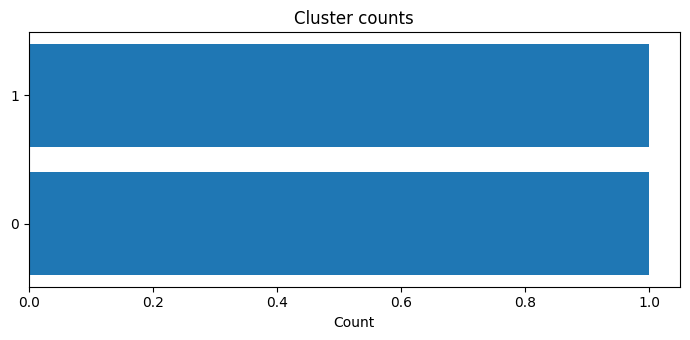

In [ ]:
import pickle, pandas as pd, numpy as np
from collections.abc import Mapping
from pprint import pprint

pkl_path = "/mnt/data/archive/ageing_bleo_data_2024/single_cell/unagi/4/stagedata/attribute.pkl"
with open(pkl_path, "rb") as f:
    root = pickle.load(f)

# OverloadedDict → plain dict
def unwrap(obj):
    if isinstance(obj, Mapping):
        return {k: unwrap(obj[k]) for k in obj.keys()}
    if isinstance(obj, (list, tuple)):
        return [unwrap(x) for x in obj]
    return obj

data = unwrap(root)
list(data.keys())

def as_df(x, key_name="key"):
    """
    Turn a variety of mappings/sequences into a tidy DataFrame.
    - dict of scalars/lists -> DataFrame
    - dict of dicts -> flattened long format
    - list/array of dicts -> DataFrame
    """
    if isinstance(x, pd.DataFrame):
        return x.copy()

    if isinstance(x, Mapping):
        # If values are dicts, make long table
        if all(isinstance(v, Mapping) for v in x.values()):
            rows = []
            for k, sub in x.items():
                row = {"_group": k}
                for sk, sv in sub.items():
                    row[sk] = sv
                rows.append(row)
            return pd.DataFrame(rows)
        # If values are lists/arrays of same length, DataFrame directly
        if all(isinstance(v, (list, tuple, np.ndarray)) for v in x.values()):
            lens = {k: len(v) for k, v in x.items()}
            if len(set(lens.values())) == 1:
                return pd.DataFrame(x)
        # Fallback: two-column key/value
        return pd.DataFrame([(k, v) for k, v in x.items()], columns=[key_name, "value"])

    if isinstance(x, (list, tuple)):
        if len(x) and isinstance(x[0], Mapping):
            return pd.DataFrame(x)
        return pd.DataFrame({ "value": list(x) })

    if isinstance(x, np.ndarray):
        if x.ndim == 2:
            return pd.DataFrame(x)
        return pd.DataFrame({ "value": x.ravel() })

    return pd.DataFrame({ "value": [x] })

cluster_df = as_df(data.get("clusterType", {}), key_name="cluster")
edges_df   = as_df(data.get("edges", {}),       key_name="edge")
topgene_df = as_df(data.get("topGene", {}),     key_name="cluster")

fc_df      = as_df(data.get("top_gene_fold_change", {}), key_name="cluster")
pval_df    = as_df(data.get("top_gene_pvals_adj", {}),   key_name="cluster")

print("cluster_df shape:", cluster_df.shape)
print("edges_df   shape:", edges_df.shape)
print("topgene_df shape:", topgene_df.shape)
print("fc_df      shape:", fc_df.shape)
print("pval_df    shape:", pval_df.shape)

display(cluster_df.head(10))
display(edges_df.head(10))
display(topgene_df.head(10))

# Heuristics to find likely gene/name & score columns
candidate_gene_cols  = [c for c in topgene_df.columns if c.lower() in {"gene", "genes"} or "gene" in c.lower()]
candidate_score_cols = [c for c in topgene_df.columns if any(s in c.lower() for s in ["score","vip","coef","weight","log2","fc"])]

# If topgene_df came out wide (e.g., columns are clusters), melt it
if len(candidate_gene_cols) == 0 and len(topgene_df.columns) > 2 and "cluster" not in topgene_df.columns:
    tg_long = topgene_df.melt(var_name="cluster", value_name="gene")
else:
    tg_long = topgene_df.copy()
    if "cluster" not in tg_long.columns:
        tg_long.rename(columns={"_group":"cluster"}, inplace=True)

# Add fold-change / pvals if they’re non-empty and share a key to merge on
def is_nonempty(df): 
    return isinstance(df, pd.DataFrame) and len(df) > 0 and df.dropna(how="all").shape[0] > 0

if is_nonempty(fc_df):
    # guess merge key
    merge_key = "cluster" if "cluster" in fc_df.columns and "cluster" in tg_long.columns else None
    if merge_key:
        tg_long = tg_long.merge(fc_df, on=merge_key, how="left", suffixes=("", "_fc"))

if is_nonempty(pval_df):
    merge_key = "cluster" if "cluster" in pval_df.columns and "cluster" in tg_long.columns else None
    if merge_key:
        tg_long = tg_long.merge(pval_df, on=merge_key, how="left", suffixes=("", "_p"))

display(tg_long.head(20))



In [14]:
import pickle, pandas as pd, numpy as np

# If you already have `data` from earlier, skip loading; otherwise:
# with open("results_unagi.pkl","rb") as f:
#     data = pickle.load(f)

# If it's an AnnData OverloadedDict, coerce to plain dict
def unwrap(obj):
    from collections.abc import Mapping
    if isinstance(obj, Mapping) or hasattr(obj, "keys"):
        try:
            keys = list(obj.keys())
            return {k: unwrap(obj[k]) for k in keys}
        except Exception:
            return obj
    if isinstance(obj, (list, tuple)):
        return [unwrap(x) for x in obj]
    return obj

data = unwrap(data)  # if you already had `data` from your previous cell

# ---- pick the right base level ----
# Case A: top level has 'data' -> use it; Case B: keys are already at top level
base = data["data"] if (isinstance(data, dict) and "data" in data and isinstance(data["data"], dict)) else data

# ---- clusterType ----
cluster_map = base.get("clusterType", {})
cluster_df = pd.DataFrame({
    "cluster": [int(k) for k in cluster_map.keys()],
    "cell_types": [", ".join(v) if isinstance(v, (list, tuple)) else str(v) for v in cluster_map.values()]
}).sort_values("cluster").reset_index(drop=True)

# ---- edges ----
# Could be {'value': [[u,v], ...]} or just [[u,v], ...]
edges_raw = base.get("edges", {})
edges_list = edges_raw.get("value", edges_raw) if isinstance(edges_raw, dict) else edges_raw
edges_list = list(edges_list) if edges_list is not None else []
# Ensure 2 columns
edges_df = pd.DataFrame(edges_list, columns=["source", "target"]) if len(edges_list) and len(edges_list[0]) >= 2 else pd.DataFrame(columns=["source","target"])

# ---- topGene ----
topgene_map = base.get("topGene", {})
def _extract_gene_list(v):
    # Handles shapes like: [[gene1, gene2, ...]] or [gene1, gene2, ...]
    if isinstance(v, list) and len(v) and isinstance(v[0], list):
        return v[0]
    return v if isinstance(v, list) else [v]

topgene_df = pd.DataFrame({
    "cluster": [int(k) for k in topgene_map.keys()],
    "genes":   [_extract_gene_list(v) for v in topgene_map.values()]
}).sort_values("cluster").reset_index(drop=True)

display(cluster_df.head())
display(edges_df.head())
display(topgene_df.head())
print("cluster_df:", cluster_df.shape, "| edges_df:", edges_df.shape, "| topgene_df:", topgene_df.shape)


,cluster,cell_types
0,0,['NK cell' 'fibroblast of lung' 'fibroblast of...
1,1,['classical monocyte' 'bronchial smooth muscle...


,source,target


,cluster,genes
0,0,"[[[Ccl5, Nkg7, AW112010, Gzma, Klrd1, Rac2, Pt..."
1,1,"[[[Plac8, Ctss, Lyz2, Lyz1, Ifitm3, Ms4a6c, Tg..."


cluster_df: (2, 2) | edges_df: (0, 2) | topgene_df: (2, 2)


,source,target
0,12,0
1,15,1
2,7,2
3,12,4
4,12,5


edges_df shape: (17, 2)


,cluster,genes
0,0,"[[[Ccl5, Nkg7, AW112010, Gzma, Klrd1, Rac2, Pt..."
1,1,"[[[Plac8, Ctss, Lyz2, Lyz1, Ifitm3, Ms4a6c, Tg..."


/tmp/ipykernel_16858/3013744009.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(); plt.show()


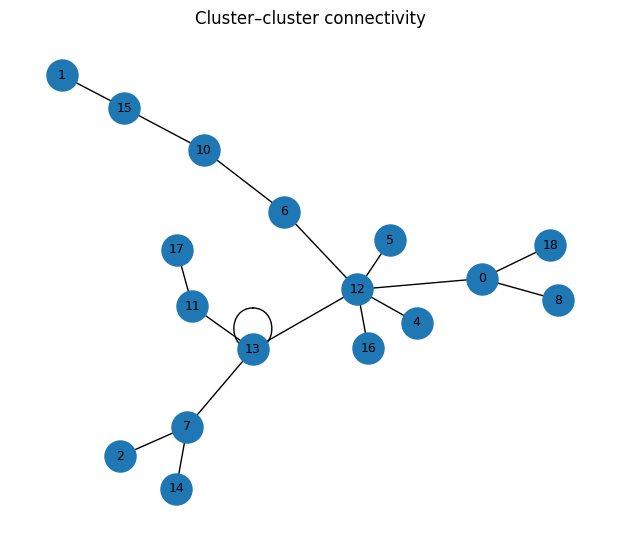

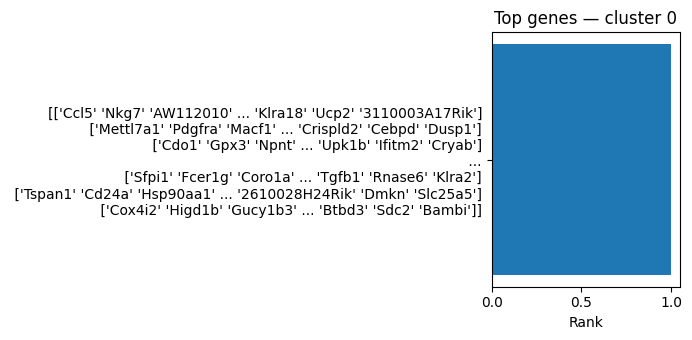

In [15]:
# --- Fix edges (handle single 'value' column or nested lists) ---
def coerce_edges(raw):
    # raw could be {}, {'value': [[u,v],...]}, a DataFrame/Series with lists, or a list of [u,v]
    import pandas as pd, numpy as np
    # 1) dict case
    if isinstance(raw, dict):
        if "value" in raw:
            pairs = raw["value"]
        else:
            # find first list-of-pairs entry
            pairs = next((v for v in raw.values()
                          if isinstance(v, (list, tuple)) and len(v) and isinstance(v[0], (list, tuple, np.ndarray))), [])
        return pd.DataFrame(pairs, columns=["source", "target"]) if pairs else pd.DataFrame(columns=["source","target"])
    # 2) DataFrame / Series with a single column of pairs
    if isinstance(raw, pd.DataFrame):
        if "value" in raw.columns and len(raw):
            pairs = raw["value"].tolist()
            return pd.DataFrame(pairs, columns=["source", "target"])
        # already 2+ columns? try to pick first two
        if raw.shape[1] >= 2:
            return raw.iloc[:, :2].set_axis(["source","target"], axis=1)
        return pd.DataFrame(columns=["source","target"])
    if isinstance(raw, pd.Series):
        pairs = raw.tolist()
        return pd.DataFrame(pairs, columns=["source","target"]) if len(pairs) else pd.DataFrame(columns=["source","target"])
    # 3) plain list of pairs
    if isinstance(raw, (list, tuple)) and raw and isinstance(raw[0], (list, tuple, np.ndarray)):
        return pd.DataFrame(raw, columns=["source","target"])
    return pd.DataFrame(columns=["source","target"])

# Rebuild edges_df from your current `base`
edges_df = coerce_edges(base.get("edges", {}))
display(edges_df.head())
print("edges_df shape:", edges_df.shape)

# --- Flatten topGene one more time (remove the extra list layer) ---
def flatten_genes(g):
    # turns [[g1,g2,...]] -> [g1,g2,...]; leaves [g1,g2,...] as-is
    if isinstance(g, list) and len(g) and isinstance(g[0], list):
        return g[0]
    return g

topgene_df["genes"] = topgene_df["genes"].apply(flatten_genes)
display(topgene_df)

# --- Quick visuals (only run if edges now exist) ---
import matplotlib.pyplot as plt
if len(edges_df):
    try:
        import networkx as nx
        G = nx.from_pandas_edgelist(edges_df, "source", "target")
        plt.figure(figsize=(6,5))
        nx.draw(G, with_labels=True, node_size=500, font_size=9)
        plt.title("Cluster–cluster connectivity")
        plt.tight_layout(); plt.show()
    except Exception as e:
        print("Network plot skipped:", e)

# Show first cluster’s top genes as a sanity check
if len(topgene_df):
    row0 = topgene_df.iloc[0]
    genes = row0["genes"][:10]
    y = range(len(genes))
    plt.figure(figsize=(7, max(3.5, 0.25*len(genes)+1.5)))
    plt.barh(list(y), [1]*len(genes))
    plt.yticks(list(y), genes)
    plt.gca().invert_yaxis()
    plt.title(f"Top genes — cluster {row0['cluster']}")
    plt.xlabel("Rank")
    plt.tight_layout(); plt.show()
